In [1]:
import numpy as np
import pandas as pd

from scipy.stats import norm, skew, kurtosis

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.graphics.gofplots as sm

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import PowerTransformer, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import BayesianRidge, LinearRegression, Lars
from sklearn.ensemble import StackingRegressor, BaggingRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error, r2_score

import pycaret.regression as pr

import optuna

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

# 1) Loading Data

In [2]:
df = pd.read_csv("data.csv")
df.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd       None   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0       196.0        Gd        TA      PConc       Gd       TA           No   
1         0.0        TA        TA     CBlock       Gd       TA           Gd   
2       162.0        Gd        TA      PConc       Gd       TA           Mn   
3         0.0        TA        TA     BrkTil       TA       Gd           No   
4       350.0        Gd        TA      PConc       Gd       TA           Av   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          GLQ         706          Unf           0        150          856   
1          ALQ         978          Unf           0        284         1262   
2          GLQ         486          Unf           0        434          920   
3          ALQ         216          Unf           0        540          756   
4          GLQ         655          Unf           0        490         1145   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        Ex          Y      SBrkr       856       854             0   
1    GasA        Ex          Y      SBrkr      1262         0             0   
2    GasA        Ex          Y      SBrkr       920       866             0   
3    GasA        Gd          Y      SBrkr       961       756             0   
4    GasA        Ex          Y      SBrkr      1145      1053             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0       1710             1             0         2         1             3   
1       1262             0             1         2         0             3   
2       1786             1             0         2         1             3   
3       1717             1             0         1         0             3   
4       2198             1             0         2         1             4   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          Gd             8        Typ           0         NaN   
1             1          TA             6        Typ           1          TA   
2             1          Gd             6        Typ           1          TA   
3             1          Gd            

In [3]:
df.drop(['Id'], axis=1, inplace=True)
df.head()

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          60       RL         65.0     8450   Pave   NaN      Reg   
1          20       RL         80.0     9600   Pave   NaN      Reg   
2          60       RL         68.0    11250   Pave   NaN      IR1   
3          70       RL         60.0     9550   Pave   NaN      IR1   
4          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd       None   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0       196.0        Gd        TA      PConc       Gd       TA           No   
1         0.0        TA        TA     CBlock       Gd       TA           Gd   
2       162.0        Gd        TA      PConc       Gd       TA           Mn   
3         0.0        TA        TA     BrkTil       TA       Gd           No   
4       350.0        Gd        TA      PConc       Gd       TA           Av   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          GLQ         706          Unf           0        150          856   
1          ALQ         978          Unf           0        284         1262   
2          GLQ         486          Unf           0        434          920   
3          ALQ         216          Unf           0        540          756   
4          GLQ         655          Unf           0        490         1145   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        Ex          Y      SBrkr       856       854             0   
1    GasA        Ex          Y      SBrkr      1262         0             0   
2    GasA        Ex          Y      SBrkr       920       866             0   
3    GasA        Gd          Y      SBrkr       961       756             0   
4    GasA        Ex          Y      SBrkr      1145      1053             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0       1710             1             0         2         1             3   
1       1262             0             1         2         0             3   
2       1786             1             0         2         1             3   
3       1717             1             0         1         0             3   
4       2198             1             0         2         1             4   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          Gd             8        Typ           0         NaN   
1             1          TA             6        Typ           1          TA   
2             1          Gd             6        Typ           1          TA   
3             1          Gd             7        Typ           

In [4]:
df1 = df.copy()

# 2) Missing Values

In [5]:
def missing_vals(df):
    
    missing = df.isna().sum()[df.isna().sum() > 0].sort_values(ascending=False).values
    
    percentage = (df.isna().mean()*100)[df.isna().mean()*100 > 0].sort_values(ascending=False).values
    
    names = df.isna().sum()[df.isna().sum() > 0].sort_values(ascending=False).index
    
    dtypes = df[names].dtypes.values
    
    data = np.array([dtypes, missing, percentage]).T
    
    return pd.DataFrame(data=data, index=names, columns=['Dtypes', '#Missing Values', '%Missing Values'])

In [6]:
missing_vals(df1)

Dtypes #Missing Values %Missing Values
PoolQC         object            1453       99.520548
MiscFeature    object            1406        96.30137
Alley          object            1369       93.767123
Fence          object            1179       80.753425
FireplaceQu    object             690       47.260274
LotFrontage   float64             259       17.739726
GarageType     object              81        5.547945
GarageYrBlt   float64              81        5.547945
GarageFinish   object              81        5.547945
GarageQual     object              81        5.547945
GarageCond     object              81        5.547945
BsmtExposure   object              38         2.60274
BsmtFinType2   object              38         2.60274
BsmtFinType1   object              37        2.534247
BsmtCond       object              37        2.534247
BsmtQual       object              37        2.534247
MasVnrArea    float64               8        0.547945
MasVnrType     object               8        0.547945
Electrical     object               1        0.068493

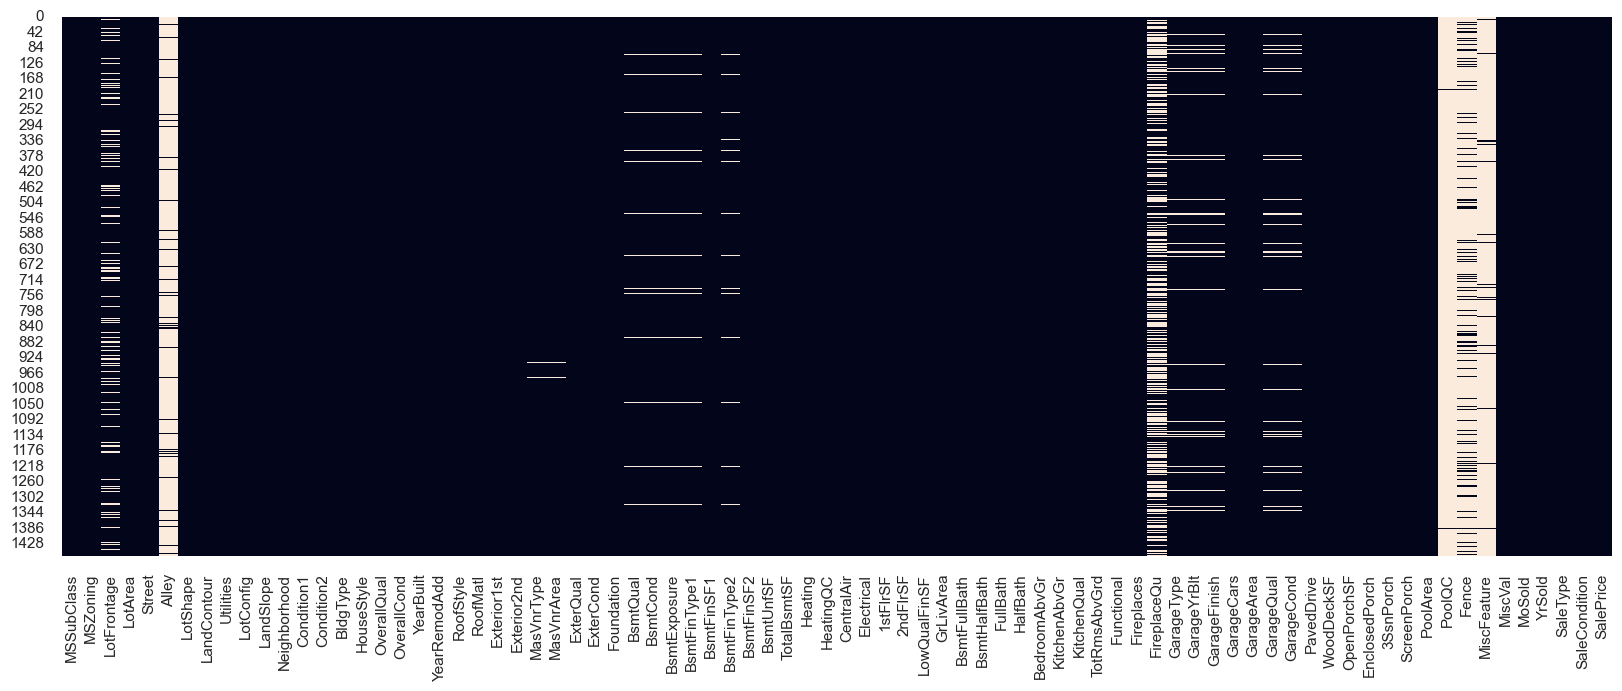

In [7]:
plt.figure(figsize=(20, 7))
sns.heatmap(df1.isna(), cbar=False)
plt.show()

In [8]:
fill_zero = ['MasVnrArea', 'GarageArea', 'GarageYrBlt']
df1[fill_zero] = SimpleImputer(strategy='constant', fill_value=0).fit_transform(df1[fill_zero])

change_cat = ['MSSubClass', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'MoSold', 'YrSold', 'OverallQual', 'OverallCond']
df1[change_cat] = df1[change_cat].astype(object)

fill_none = ['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'MasVnrType']
df1[fill_none] = SimpleImputer(strategy='constant', fill_value='None').fit_transform(df1[fill_none])

delete_rows = ['Electrical']
df1.dropna(axis=0, subset=delete_rows, inplace=True)

fill_num = ['LotFrontage']
knn_imputer = KNNImputer(n_neighbors=5)
df1[fill_num] = knn_imputer.fit_transform(df1[fill_num])

In [9]:
missing_vals(df1)

Empty DataFrame
Columns: [Dtypes, #Missing Values, %Missing Values]
Index: []

In [10]:
df2 = df1.copy()

# 3) Feature Engineering

In [11]:
# Square per Room
df2["SqFtPerRoom"] = df2["GrLivArea"] / (df2["TotRmsAbvGrd"] + df2["FullBath"] + df2["HalfBath"] + df2["KitchenAbvGr"])

# Total Home Quality
df2['Total_Home_Quality'] = df2['OverallQual'] + df2['OverallCond']

# Total Bathrooms
df2['Total_Bathrooms'] = (df2['FullBath'] + (0.5*df2['HalfBath']) + df2['BsmtFullBath'] + (0.5*df2['BsmtHalfBath']))

# HighQualSF
df2["HighQualSF"] = df2["1stFlrSF"] + df2["2ndFlrSF"]

In [12]:
df3 = df2.copy()

# 4) Target Transformation

In [13]:
def skew_kurtosis(df):
    
    numeric_features = df.dtypes[df.dtypes != 'object'].index
    
    skewness_vals = df[numeric_features].apply(axis=0, func=lambda x: skew(x)).values
    
    kurtosis_vals = df[numeric_features].apply(axis=0, func=lambda x: kurtosis(x)).values
    
    data = np.array([skewness_vals, kurtosis_vals]).T
    
    return pd.DataFrame(data=data, index=numeric_features, columns=['Skewness', 'Kurtosis'])

In [14]:
skew_kurtosis(df3[['SalePrice']])

Skewness  Kurtosis
SalePrice  1.880008  6.502799

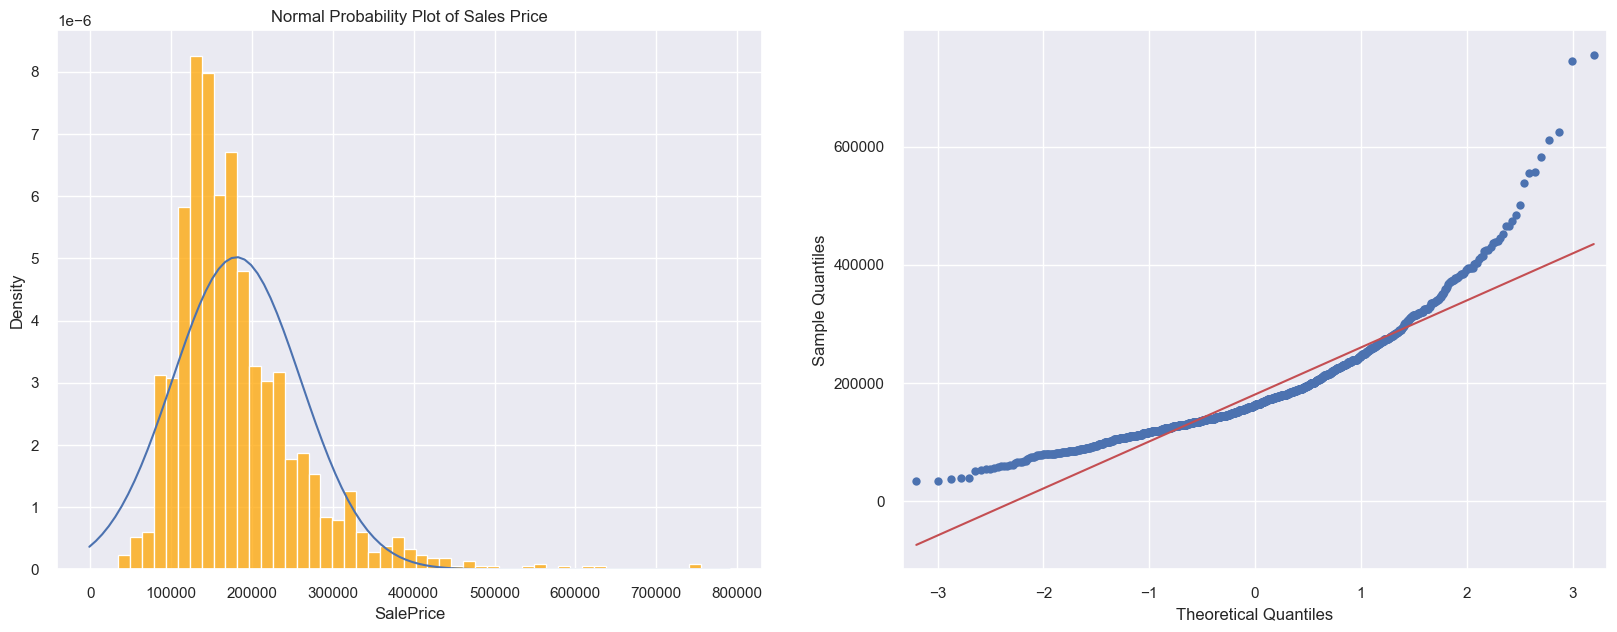

In [15]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(20, 7))

sns.histplot(df3['SalePrice'], stat='density', color='orange', ax=ax1)
mu, std = norm.fit(df3['SalePrice'])
xx = np.linspace(*ax1.get_xlim(),100)
ax1.set_title('Sales Price Distribution')
sns.lineplot(x=xx, y=norm.pdf(xx, mu, std), ax=ax1)

sm.ProbPlot(df3['SalePrice']).qqplot(line='s', ax=ax2)
ax1.set_title('Normal Probability Plot of Sales Price')

plt.show()

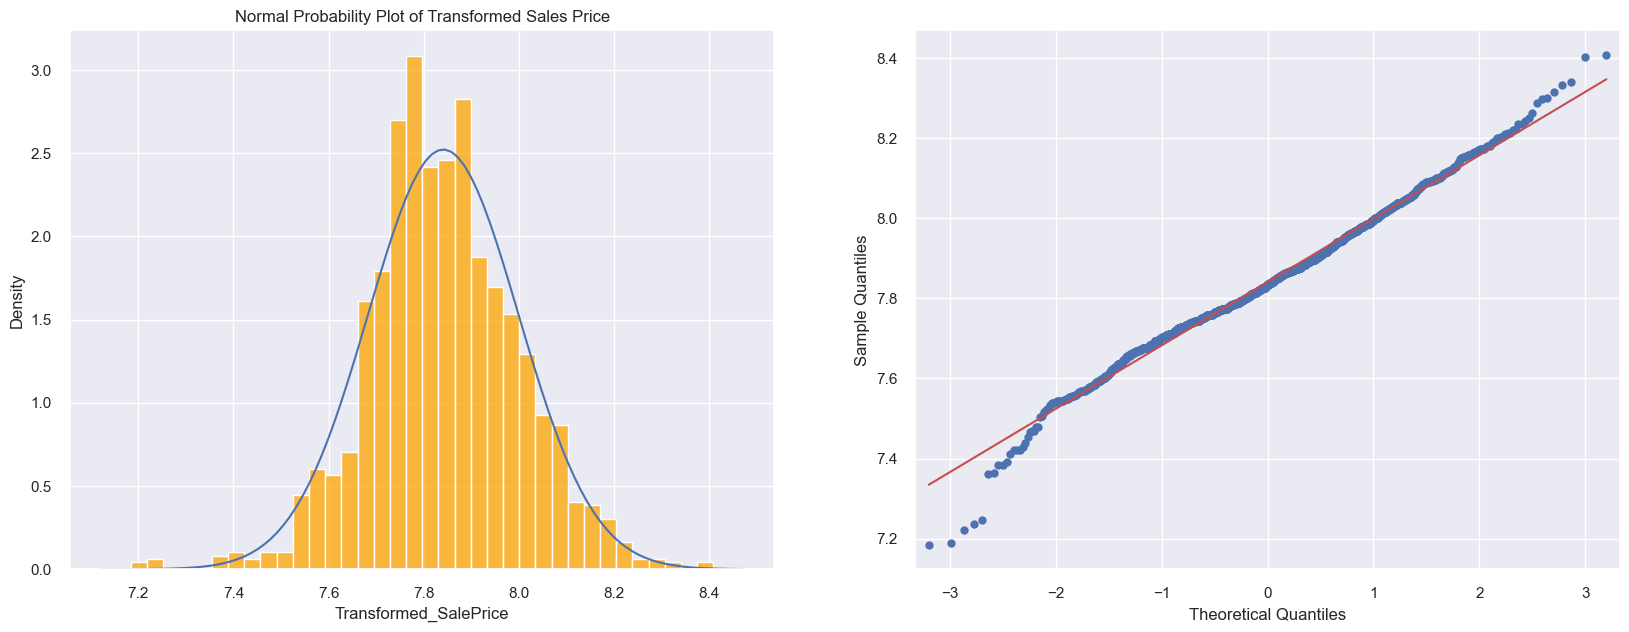

In [16]:
target_transformer = PowerTransformer(method='yeo-johnson', standardize=False)

df3['Transformed_SalePrice'] = target_transformer.fit_transform(df3[['SalePrice']]).T[0]

fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(20, 7))

sns.histplot(df3['Transformed_SalePrice'], stat='density', color='orange', ax=ax1)
mu, std = norm.fit(df3['Transformed_SalePrice'])
xx = np.linspace(*ax1.get_xlim(),100)
ax1.set_title('Transformed Sales Price Distribution')
sns.lineplot(x=xx, y=norm.pdf(xx, mu, std), ax=ax1)

sm.ProbPlot(df3['Transformed_SalePrice']).qqplot(line='s', ax=ax2)
ax1.set_title('Normal Probability Plot of Transformed Sales Price')

plt.show()

In [17]:
df3.drop(['SalePrice'], axis=1, inplace=True)
df4 = df3.copy()

# 5) Features Transformation

In [18]:
skew_kurtosis(df4.drop(['Transformed_SalePrice'], axis=1))

Skewness    Kurtosis
LotFrontage       2.382060   21.754015
LotArea          12.190881  202.402120
MasVnrArea        2.673798   10.095230
BsmtFinSF1        1.683465   11.079615
BsmtFinSF2        4.249219   20.023898
BsmtUnfSF         0.918367    0.466639
TotalBsmtSF       1.525190   13.232154
1stFlrSF          1.375089    5.724629
2ndFlrSF          0.813466   -0.554484
LowQualFinSF      8.998885   82.885802
GrLivArea         1.364297    4.868582
BsmtFullBath      0.594354   -0.841470
BsmtHalfBath      4.097541   16.322022
FullBath          0.037821   -0.858040
HalfBath          0.677275   -1.073973
BedroomAbvGr      0.211839    2.215847
KitchenAbvGr      4.482026   21.436776
TotRmsAbvGrd      0.676068    0.872000
Fireplaces        0.647913   -0.221309
GarageCars       -0.341494    0.214062
GarageArea        0.179081    0.907592
WoodDeckSF        1.539362    2.974720
OpenPorchSF       2.361099    8.452397
EnclosedPorch     3.085342   10.381118
3SsnPorch        10.290132  123.147774
ScreenPorch       4.116334   18.356321
PoolArea         14.807992  222.344724
MiscVal          24.443278  698.121807
SqFtPerRoom       0.980318    2.875496
Total_Bathrooms   0.265074   -0.138523
HighQualSF        1.328266    4.853191

In [19]:
skewed_values = skew_kurtosis(df4.drop(['Transformed_SalePrice'], axis=1))

threshold = (np.abs(skewed_values['Skewness']) < 2) | (np.abs(skewed_values['Kurtosis']) < 7)

skewed_values[threshold]

Skewness   Kurtosis
BsmtFinSF1       1.683465  11.079615
BsmtUnfSF        0.918367   0.466639
TotalBsmtSF      1.525190  13.232154
1stFlrSF         1.375089   5.724629
2ndFlrSF         0.813466  -0.554484
GrLivArea        1.364297   4.868582
BsmtFullBath     0.594354  -0.841470
FullBath         0.037821  -0.858040
HalfBath         0.677275  -1.073973
BedroomAbvGr     0.211839   2.215847
TotRmsAbvGrd     0.676068   0.872000
Fireplaces       0.647913  -0.221309
GarageCars      -0.341494   0.214062
GarageArea       0.179081   0.907592
WoodDeckSF       1.539362   2.974720
SqFtPerRoom      0.980318   2.875496
Total_Bathrooms  0.265074  -0.138523
HighQualSF       1.328266   4.853191

In [20]:
skewed_features = skewed_values[threshold].index
skewed_features

parameter_transformer = PowerTransformer(method='yeo-johnson', standardize=False)

df4[skewed_features] = parameter_transformer.fit_transform(df4[skewed_features])

In [21]:
df5 = df4.copy()

# 6) Encoding

## I) Ordinal Encoding

In [22]:
ordinal_features = ['MSSubClass', 'OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC', 'Functional', 'Fence', 'GarageFinish', 'LandSlope', 'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'YrSold', 'MoSold', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'Total_Home_Quality']
ordinal_encoder = OrdinalEncoder()
df5[ordinal_features] = ordinal_encoder.fit_transform(df5[ordinal_features])

In [23]:
standardize_features = df5.dtypes[df5.dtypes != 'object'].index
standardize_features = standardize_features[:-1]

In [24]:
df6 = df5.copy()

## II) OHE

In [25]:
ohe_features = df6[df6.dtypes[df6.dtypes == 'object'].index].columns
ohe_encoder = OneHotEncoder(sparse=False, drop=None)
ohe_encoded = ohe_encoder.fit_transform(df6[ohe_features])

In [26]:
ohe_categories = []
counter = 0

for i in ohe_encoder.categories_:
    for j in i:
        counter += 1
        ohe_categories.append(j + str(counter)) 

df6.drop(ohe_features, axis=1, inplace=True)
other_features = df6.columns.values

In [27]:
concatenated_data = np.concatenate((df6.values, ohe_encoded), axis=1)

transformed_data = pd.DataFrame(data=concatenated_data, columns=[*other_features, *ohe_categories])

In [28]:
df7 = transformed_data.copy()

# 7) Scaling

In [29]:
standard_scaler = StandardScaler()

df7[standardize_features] = standard_scaler.fit_transform(df7[standardize_features])

In [30]:
df8 =df7.copy()

# 8) Feature Selection

## I) Correlation Analysis

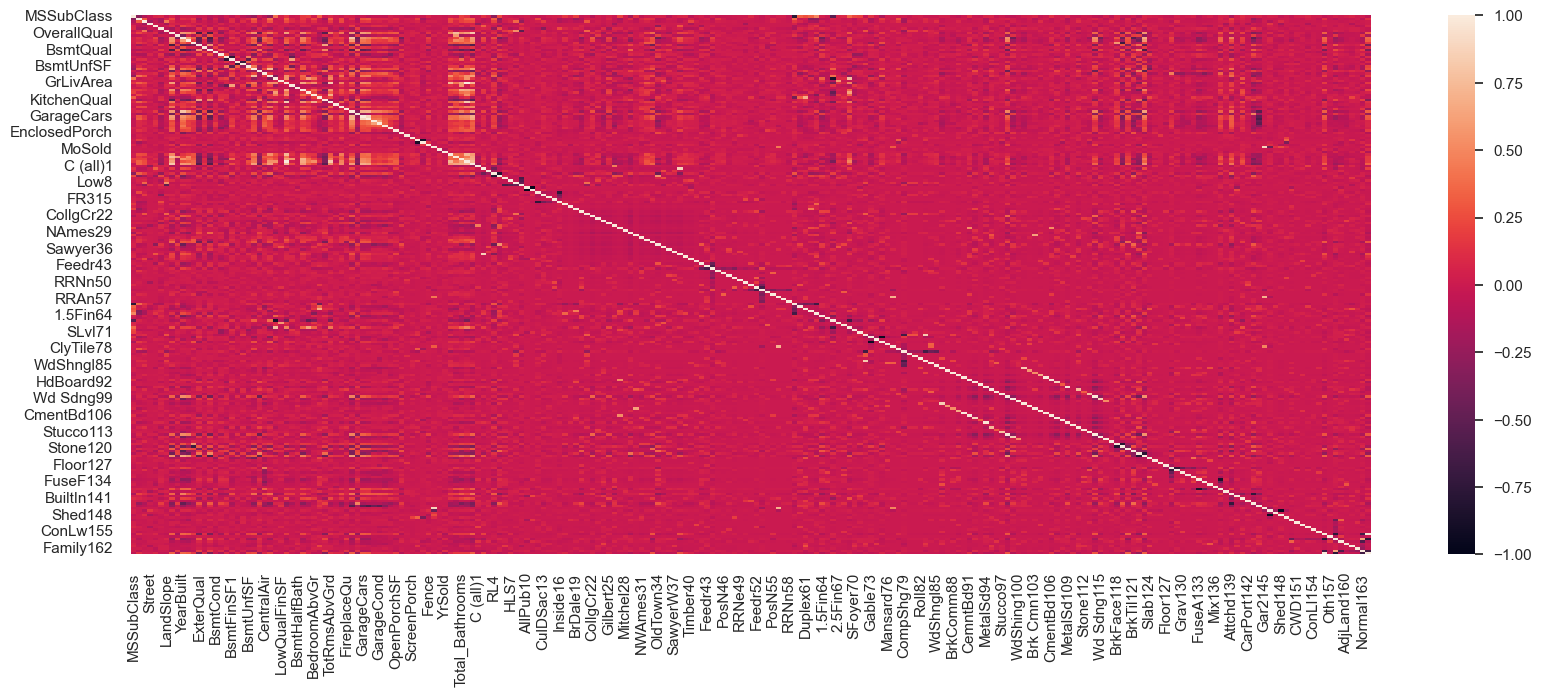

In [31]:
plt.figure(figsize=(20, 7))
sns.heatmap(df8.corr(method='pearson'))
plt.show()

In [32]:
corr = df8.corr(method='pearson')[['Transformed_SalePrice']].sort_values(by=['Transformed_SalePrice'], ascending=False)
corr

Transformed_SalePrice
Transformed_SalePrice               1.000000
OverallQual                         0.815235
HighQualSF                          0.736232
GrLivArea                           0.729388
GarageCars                          0.683783
Total_Bathrooms                     0.676208
GarageArea                          0.647242
Total_Home_Quality                  0.645402
TotalBsmtSF                         0.611456
1stFlrSF                            0.607305
GarageYrBlt                         0.602061
YearBuilt                           0.599856
SqFtPerRoom                         0.592996
FullBath                            0.592231
YearRemodAdd                        0.567088
TotRmsAbvGrd                        0.538937
PConc123                            0.530161
Fireplaces                          0.511809
MasVnrArea                          0.421457
Attchd139                           0.419819
CentralAir                          0.359202
NridgHt33                           0.345854
WoodDeckSF                          0.339848
VinylSd114                          0.337379
VinylSd98                           0.336058
LotFrontage                         0.334677
GarageCond                          0.328811
HalfBath                            0.327143
New156                              0.325124
Partial164                          0.320497
OpenPorchSF                         0.318939
SBrkr137                            0.309984
PavedDrive                          0.309818
Stone120                            0.308008
RL4                                 0.301860
GarageQual                          0.280126
NoRidge32                           0.272289
2Story69                            0.262972
LotArea                             0.255398
BsmtFinSF1                          0.250216
BsmtFullBath                        0.239102
BrkFace118                          0.232787
BuiltIn141                          0.221329
BsmtUnfSF                           0.212554
BedroomAbvGr                        0.211827
Hip75                               0.194732
StoneBr39                           0.182381
Somerst38                           0.171580
2ndFlrSF                            0.170099
ExterCond                           0.150589
CulDSac13                           0.148036
Timber40                            0.140437
Fence                               0.138255
GasA128                             0.137490
Functional                          0.131936
1Fam59                              0.131030
BsmtCond                            0.124651
FV2                                 0.121648
ScreenPorch                         0.121467
CollgCr22                           0.120901
Norm44                              0.118284
WdShngl85                           0.115388
Alley                               0.114373
HLS7                                0.109537
CemntBd91                           0.090820
CmentBd106                          0.088605
Crawfor23                           0.087532
Gilbert25                           0.081697
None146                             0.077541
ClearCr21                           0.076456
BsmtFinType2                        0.071824
Veenker41                           0.069781
PoolArea                            0.068404
NWAmes31                            0.063694
PosN46                              0.061950
Street                              0.058665
MoSold                              0.057466
3SsnPorch                           0.055342
WdShake84                           0.053083
PosA45                              0.052883
Norm53                              0.046246
PosA54                              0.043103
ImStucc108                          0.043102
PosN55                              0.042944
Con152                              0.042371
Other110                            0.041940
Blmngtn17                           0.040785
Stone96                             0.040018
Low8              

In [33]:
selected_features_1 = corr[(np.abs(corr['Transformed_SalePrice']) <= 1) & (np.abs(corr['Transformed_SalePrice']) >= 0.4)]
features_1 = selected_features_1.index[1:]
selected_features_1

Transformed_SalePrice
Transformed_SalePrice               1.000000
OverallQual                         0.815235
HighQualSF                          0.736232
GrLivArea                           0.729388
GarageCars                          0.683783
Total_Bathrooms                     0.676208
GarageArea                          0.647242
Total_Home_Quality                  0.645402
TotalBsmtSF                         0.611456
1stFlrSF                            0.607305
GarageYrBlt                         0.602061
YearBuilt                           0.599856
SqFtPerRoom                         0.592996
FullBath                            0.592231
YearRemodAdd                        0.567088
TotRmsAbvGrd                        0.538937
PConc123                            0.530161
Fireplaces                          0.511809
MasVnrArea                          0.421457
Attchd139                           0.419819
GarageFinish                       -0.414034
HeatingQC                          -0.425112
KitchenQual                        -0.526739
BsmtQual                           -0.572155
ExterQual                          -0.574202

In [34]:
df9 = df8[selected_features_1.index].copy()

## II) Multicollinearity Analysis

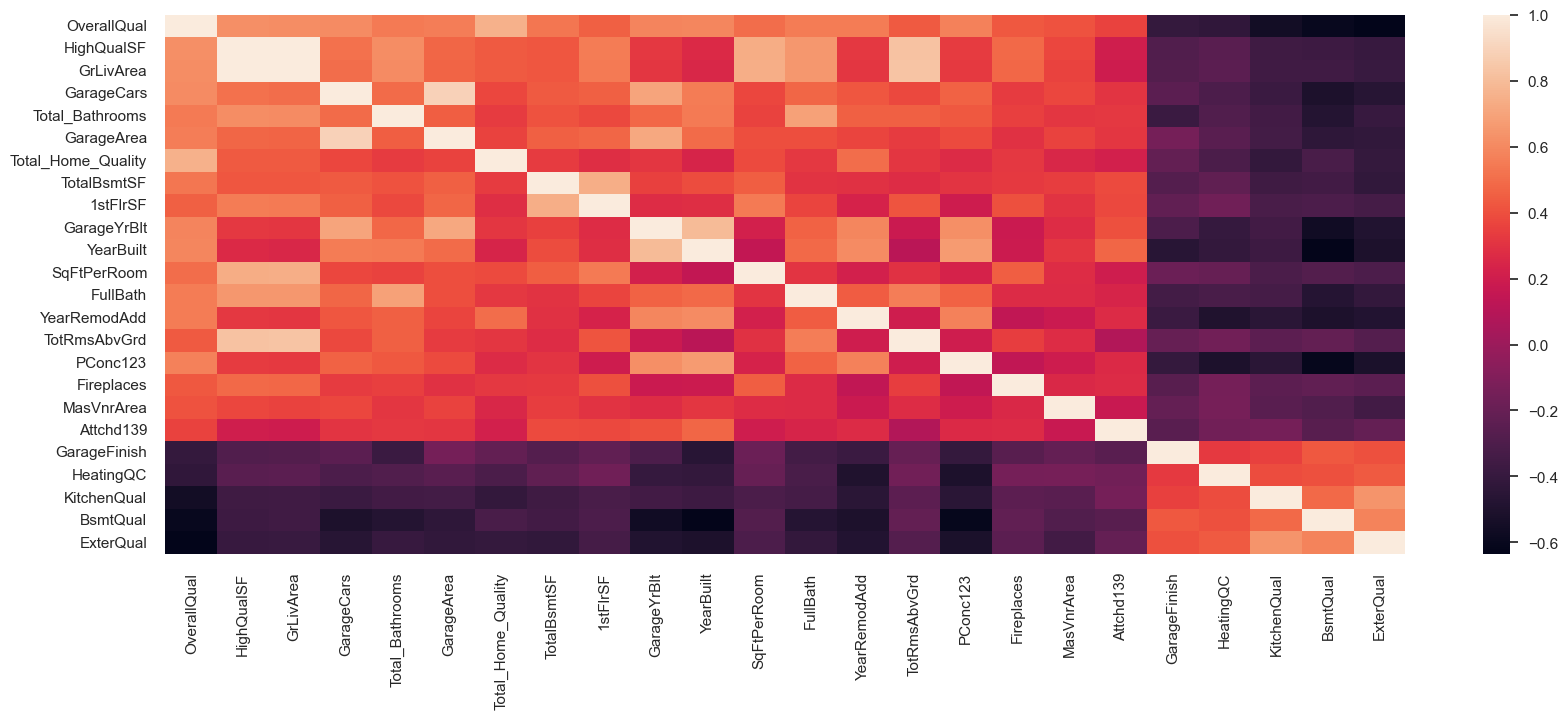

In [35]:
plt.figure(figsize=(20, 7))
sns.heatmap(df9[features_1].corr())
plt.show()

In [36]:
def compute_vif(df, considered_features):
    
    X = df[considered_features]
    X = add_constant(X)
    
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='const']
    
    return vif.sort_values(by=['VIF'], ascending=False)

In [37]:
def reduce_vif(df, threshold, considered_features):
    
    vif = compute_vif(df, considered_features)
    discarded_features = []
    
    while vif.iloc[0, 1] > threshold:
        discarded_features.append(vif.iloc[0, 0])
        vif = compute_vif(df, considered_features.drop(discarded_features))
    
    return vif

In [38]:
compute_vif(df9, features_1)

Variable         VIF
3            GrLivArea  172.929295
2           HighQualSF  111.020176
15        TotRmsAbvGrd   22.159986
12         SqFtPerRoom   18.155202
1          OverallQual    7.166322
6           GarageArea    6.526810
4           GarageCars    5.715406
11           YearBuilt    5.358260
10         GarageYrBlt    5.153571
7   Total_Home_Quality    3.707992
9             1stFlrSF    3.407825
13            FullBath    3.311463
5      Total_Bathrooms    2.881309
8          TotalBsmtSF    2.805675
16            PConc123    2.627893
14        YearRemodAdd    2.562225
24           ExterQual    2.399325
23            BsmtQual    2.281713
22         KitchenQual    1.963198
21           HeatingQC    1.558463
20        GarageFinish    1.540274
19           Attchd139    1.531702
17          Fireplaces    1.518575
18          MasVnrArea    1.359740

In [39]:
selected_features_2 = reduce_vif(df9, 5, features_1)
features_2 = selected_features_2['Variable'].to_list()
selected_features_2

Variable       VIF
7            YearBuilt  4.748294
6          GarageYrBlt  4.138371
5             1stFlrSF  3.138479
4          TotalBsmtSF  2.702933
1           GarageCars  2.681481
9             FullBath  2.556512
12            PConc123  2.537507
2      Total_Bathrooms  2.488452
10        YearRemodAdd  2.407694
20           ExterQual  2.336097
19            BsmtQual  2.227776
18         KitchenQual  1.946509
11        TotRmsAbvGrd  1.910599
8          SqFtPerRoom  1.803938
3   Total_Home_Quality  1.774004
17           HeatingQC  1.546306
15           Attchd139  1.528695
16        GarageFinish  1.504329
13          Fireplaces  1.498017
14          MasVnrArea  1.344485

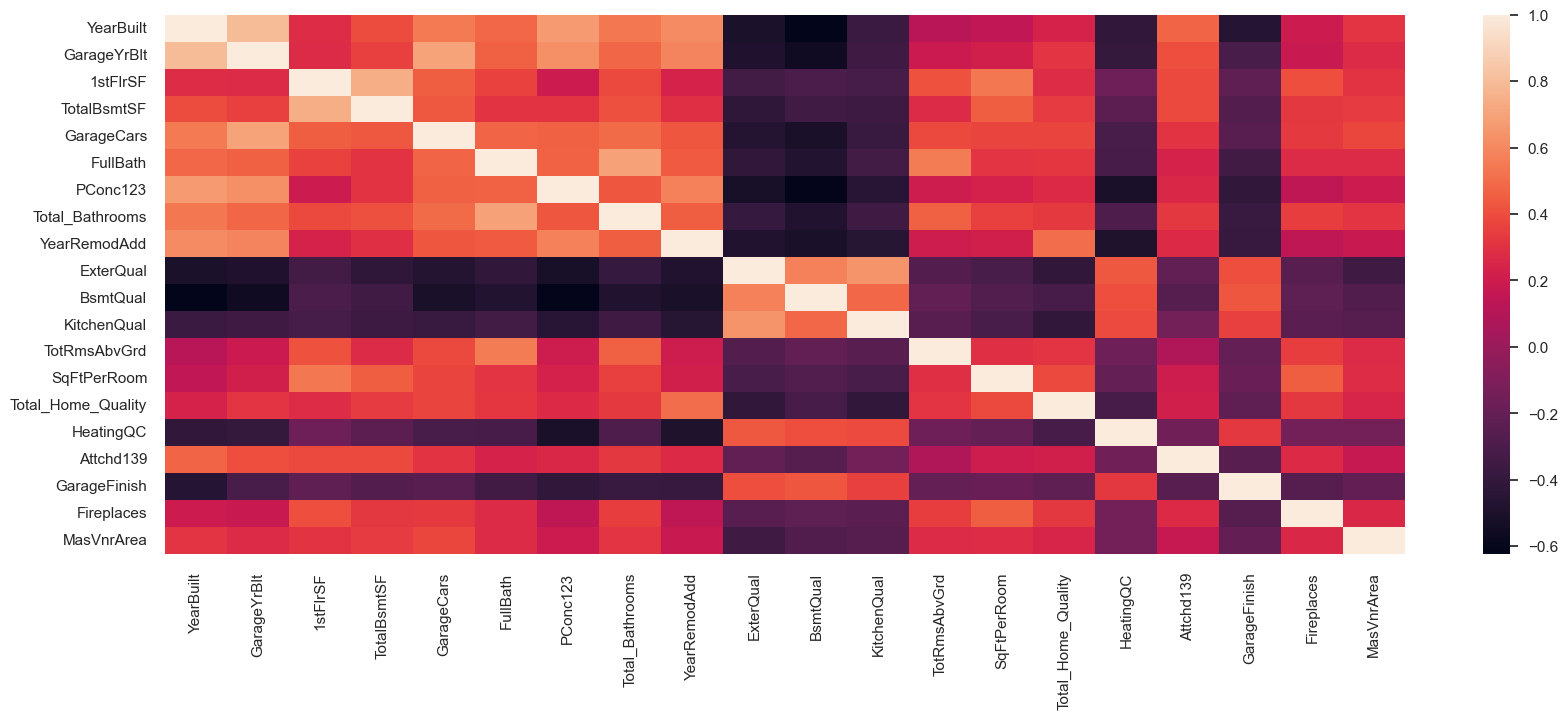

In [40]:
plt.figure(figsize=(20, 7))
sns.heatmap(df9[features_2].corr())
plt.show()

In [41]:
features_2.append('Transformed_SalePrice')
df10 = df9[features_2].copy()

# 9) EDA & Outlier Removal

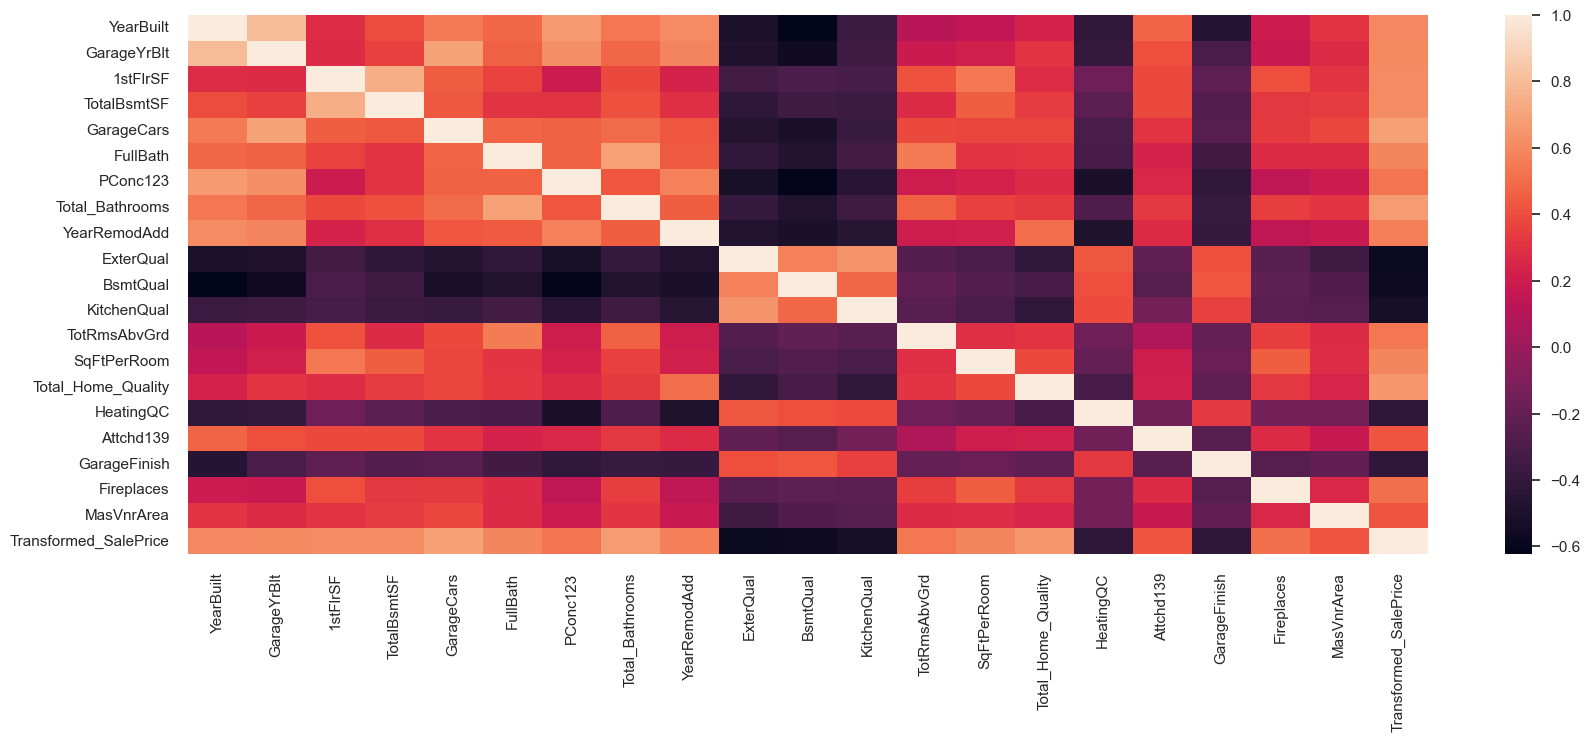

In [42]:
plt.figure(figsize=(20, 7))
sns.heatmap(df10.corr())
plt.show()

In [43]:
def simple_graph(df, x, y):
    
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(20, 21))
    
    sns.histplot(data=df, x=x, ax=ax1)
    sns.regplot(data=df, x=x, y=y, ax=ax2)
    sns.boxplot(data=df, x=x, y=y, ax=ax3)
    ax3.get_xaxis().set_ticks([])
    
    plt.suptitle(x)
    
    plt.show()
    
    return

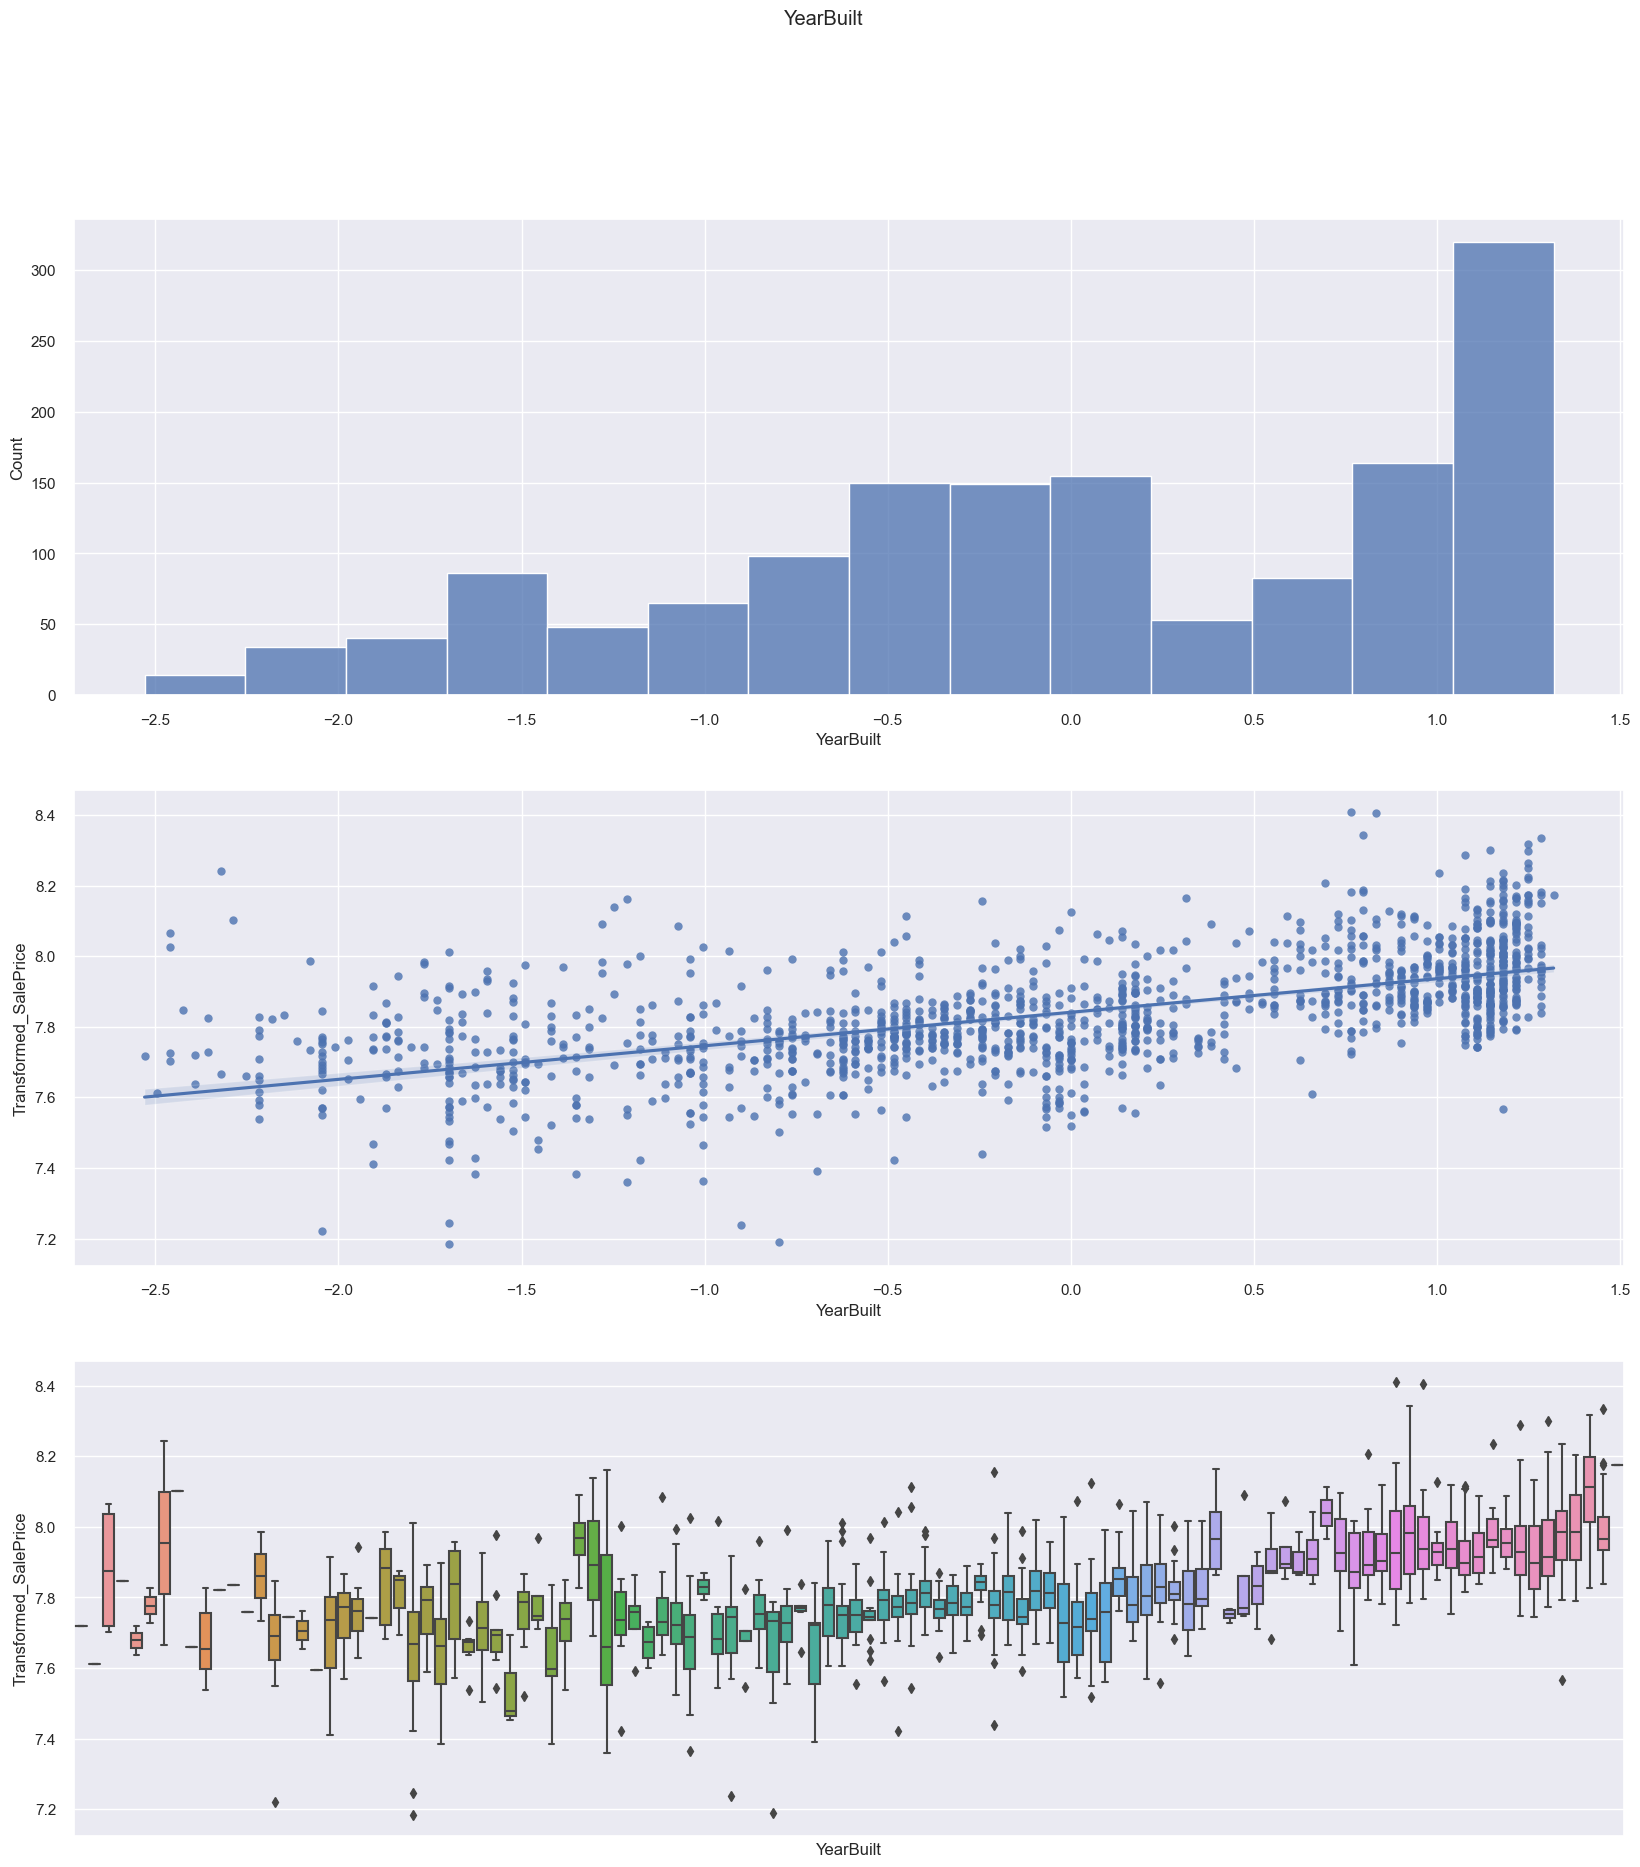

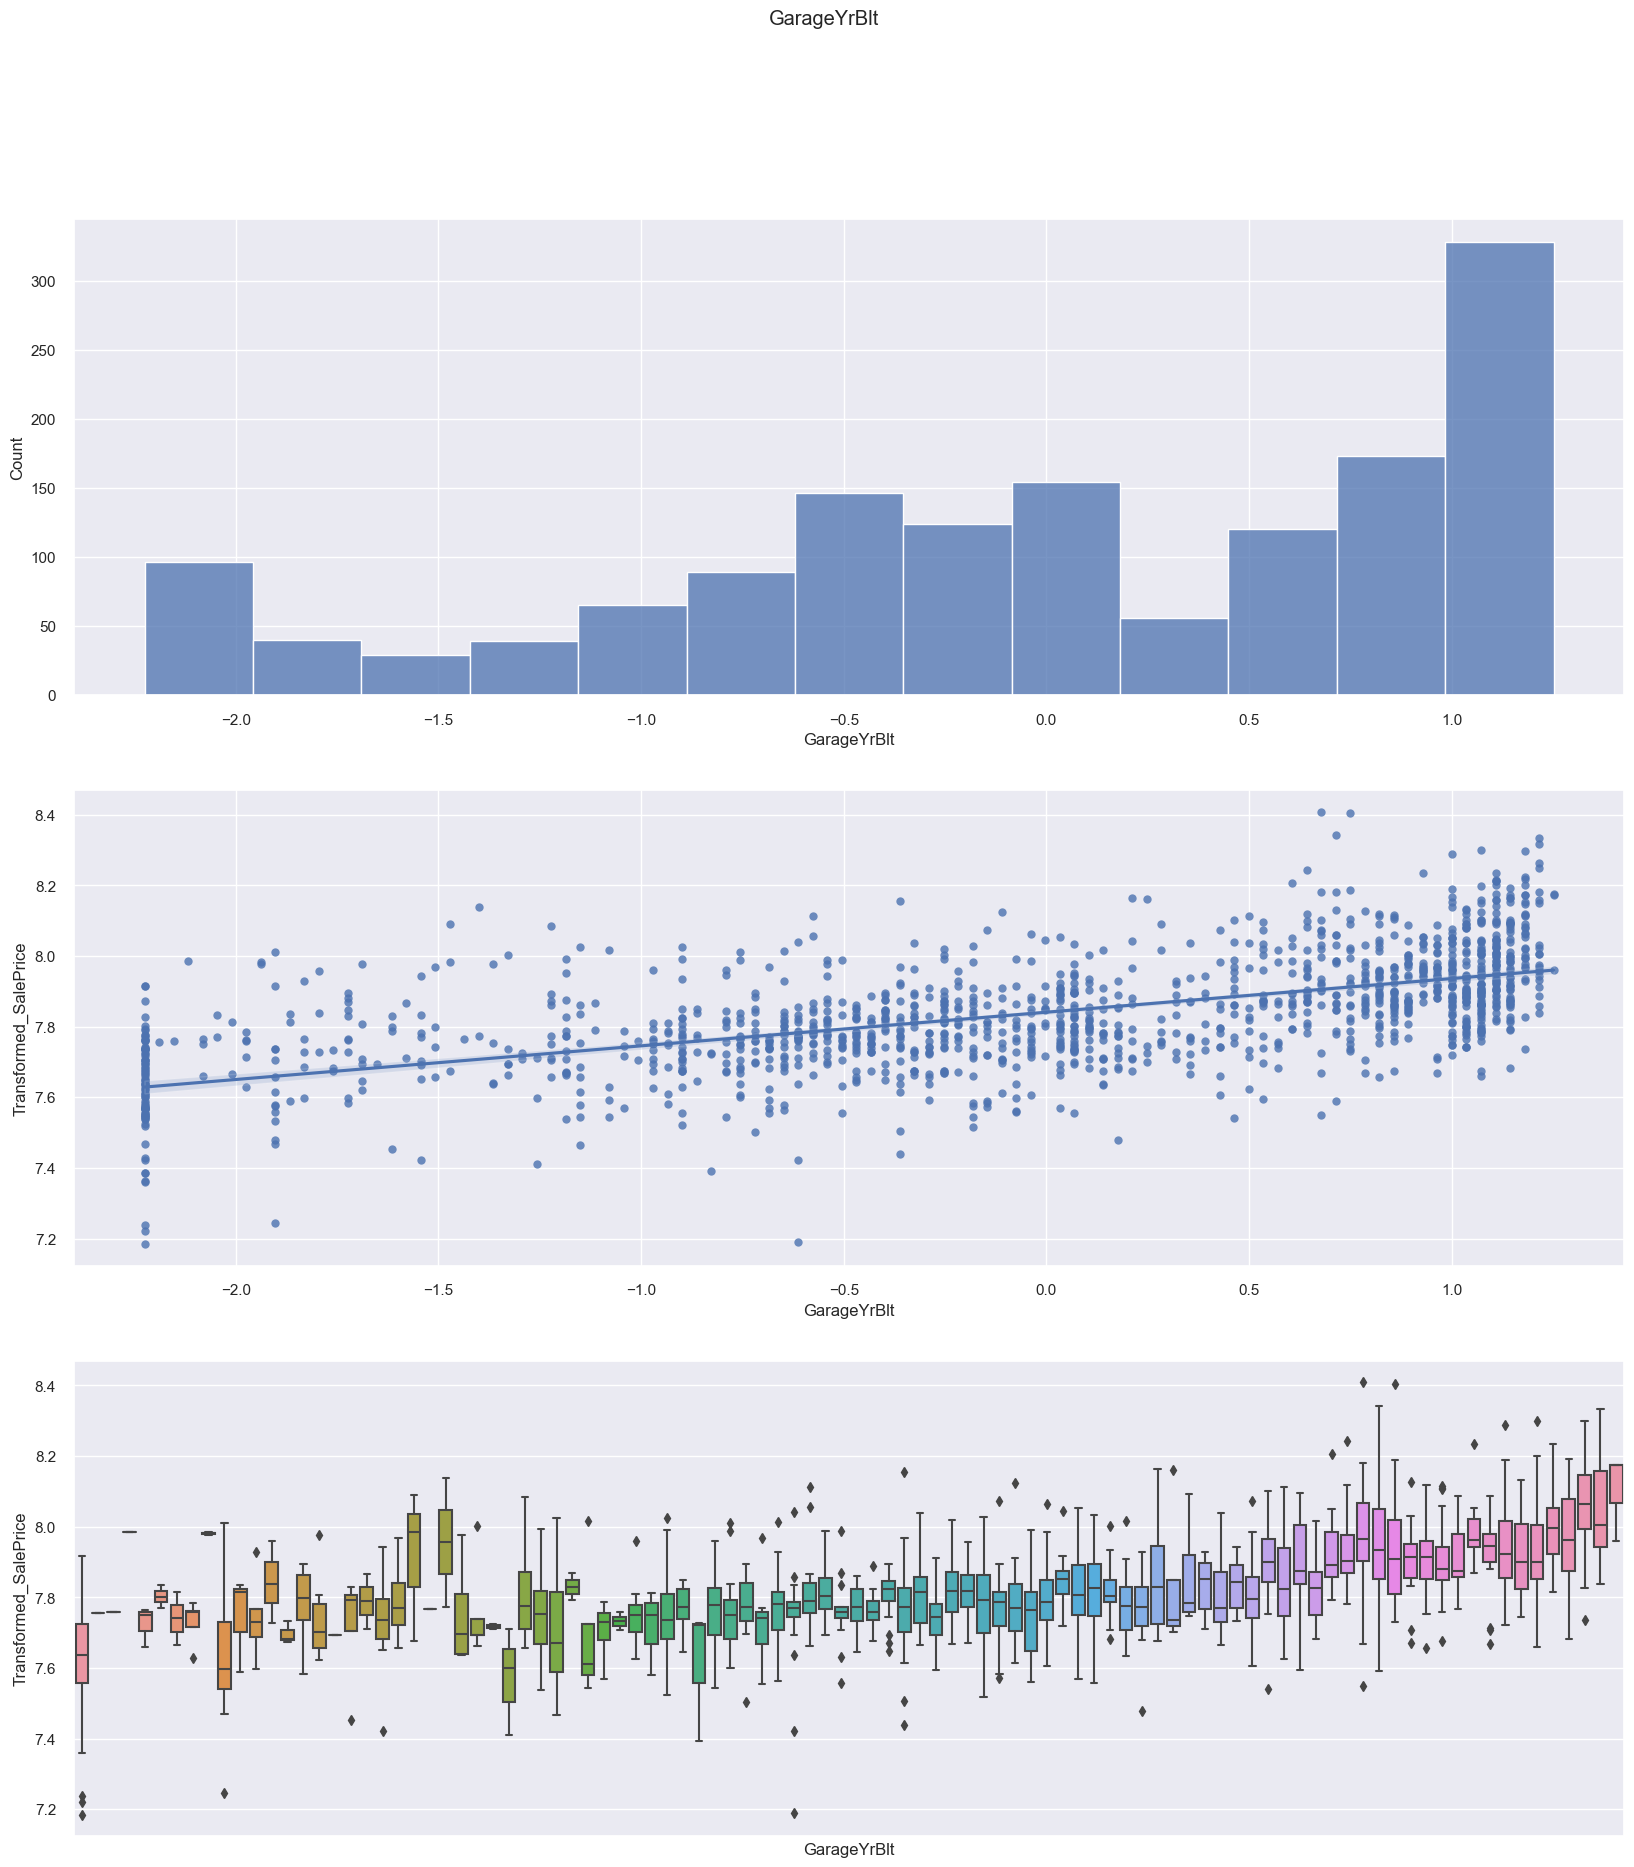

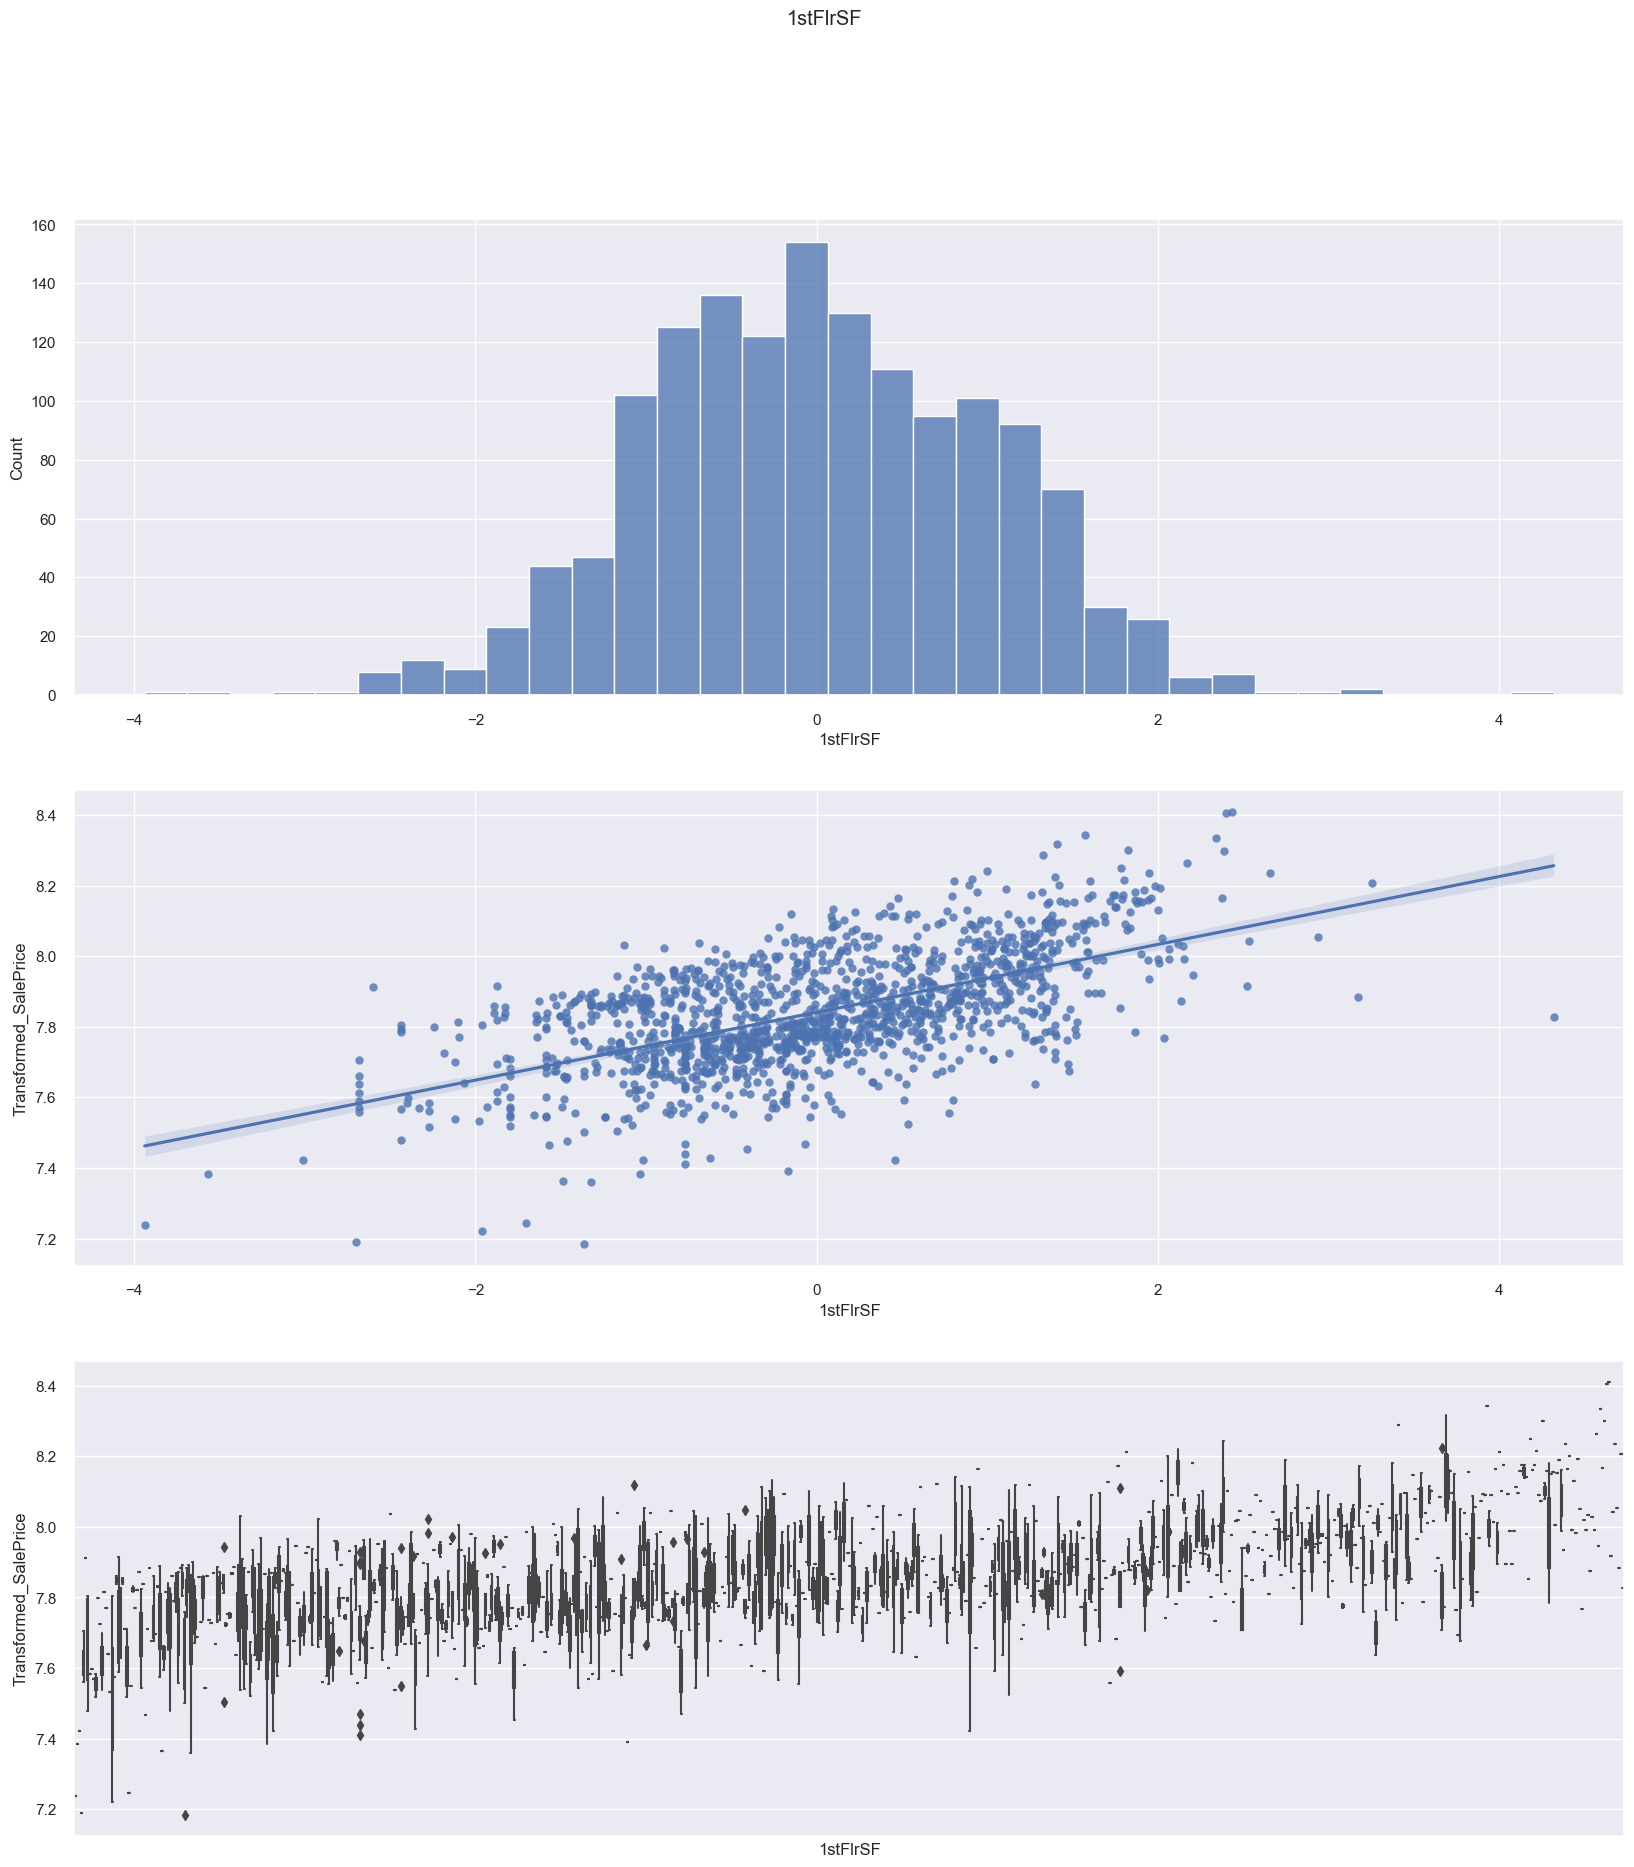

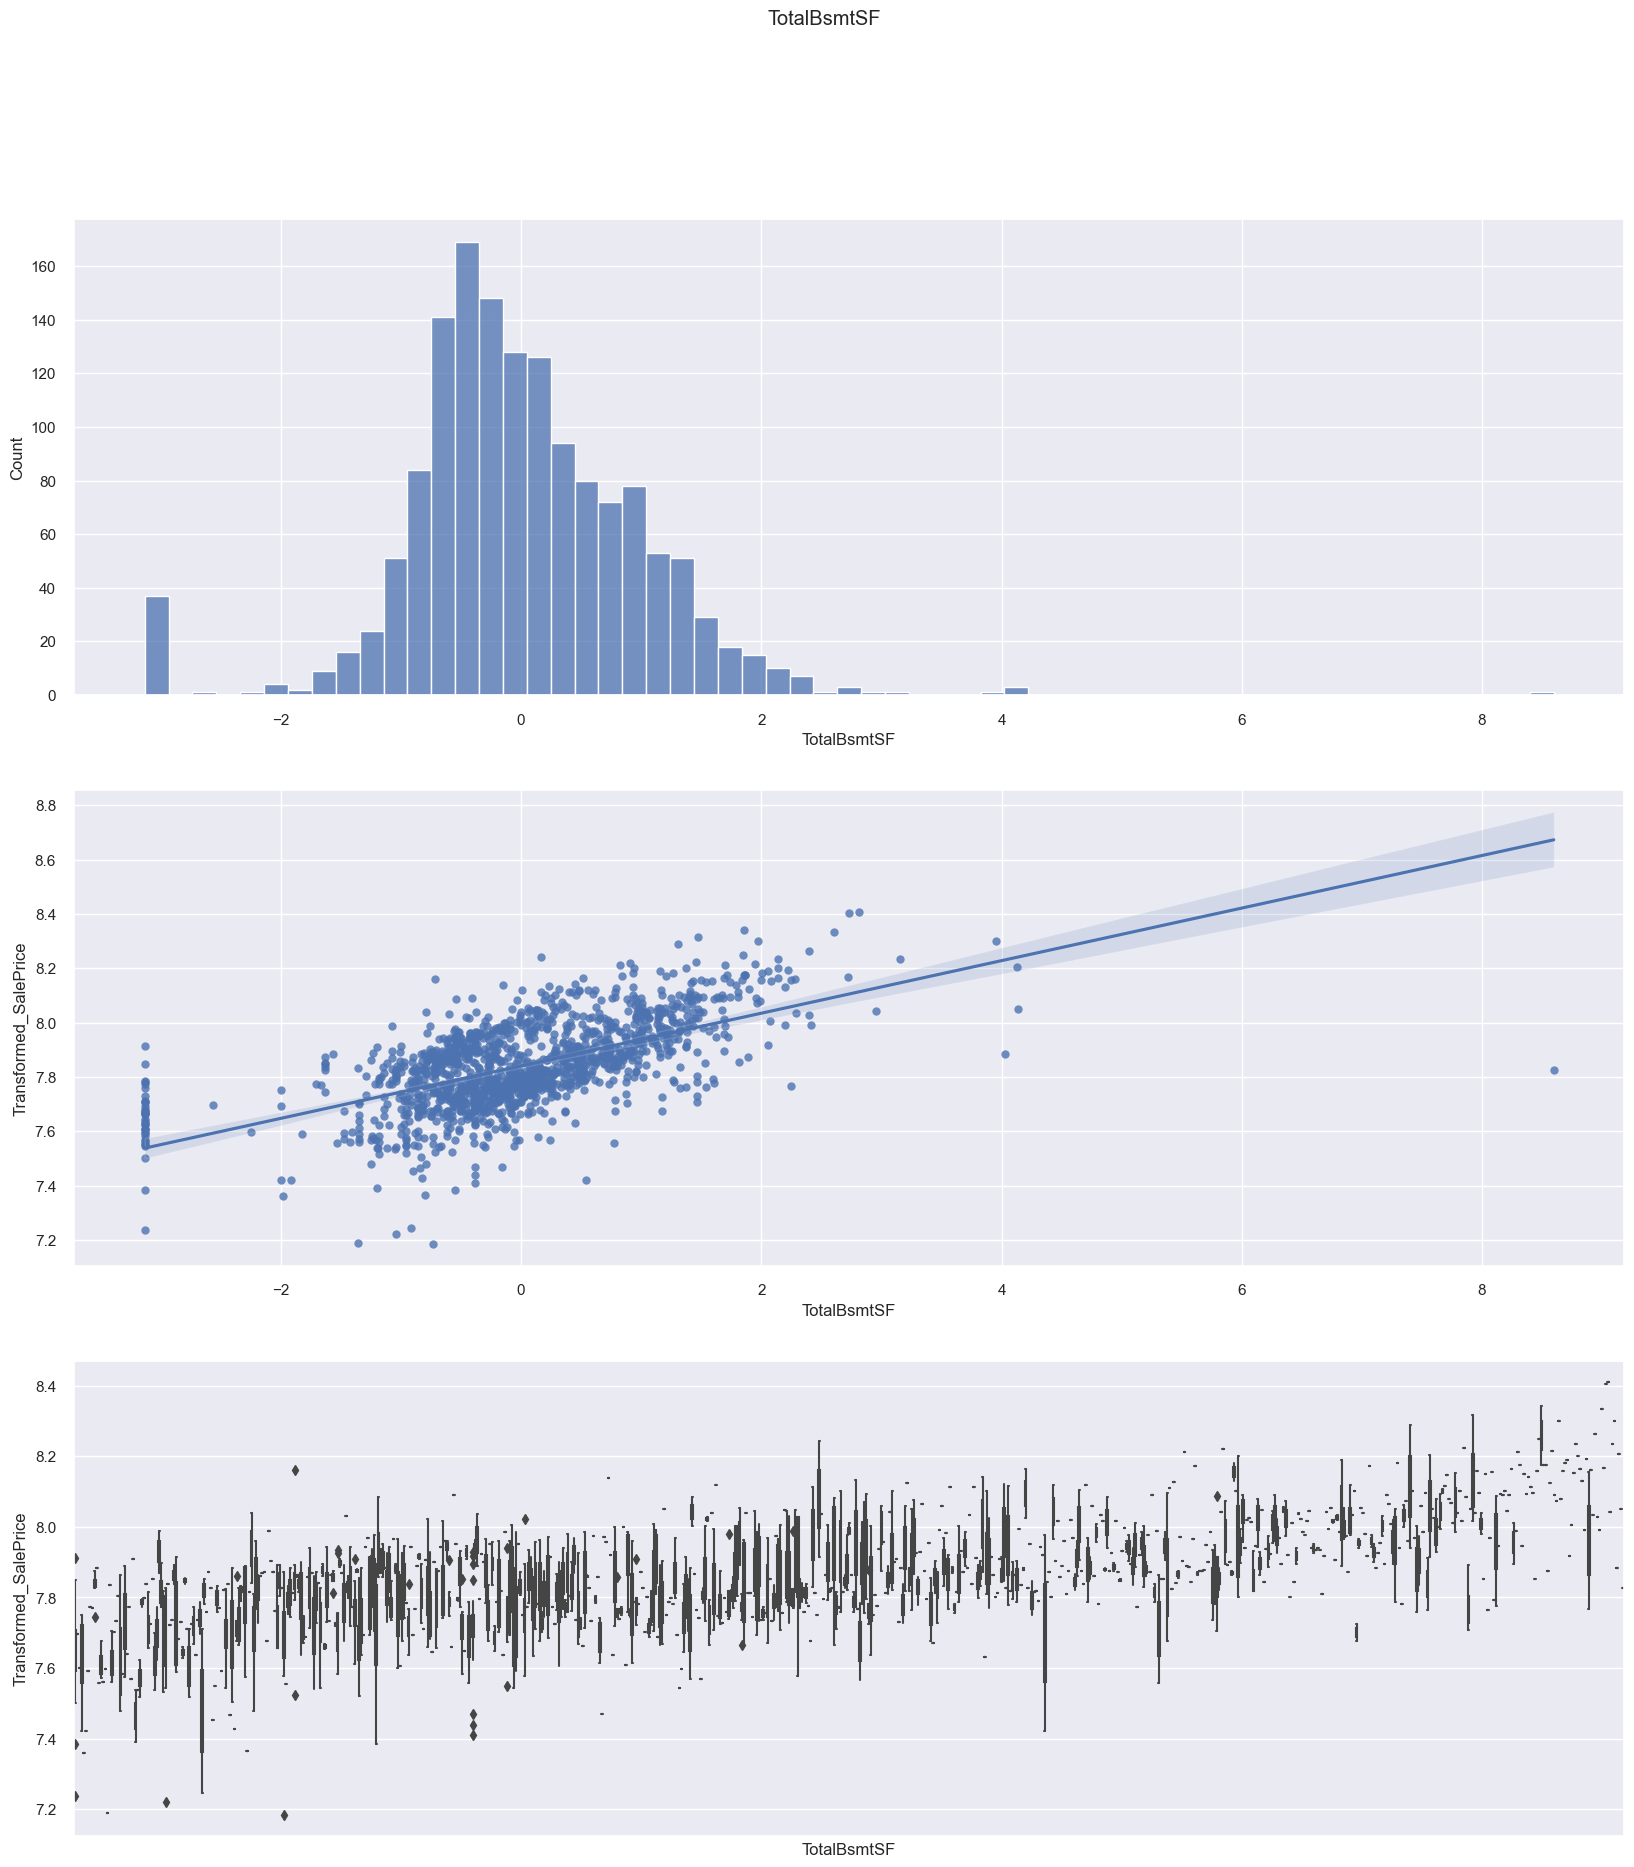

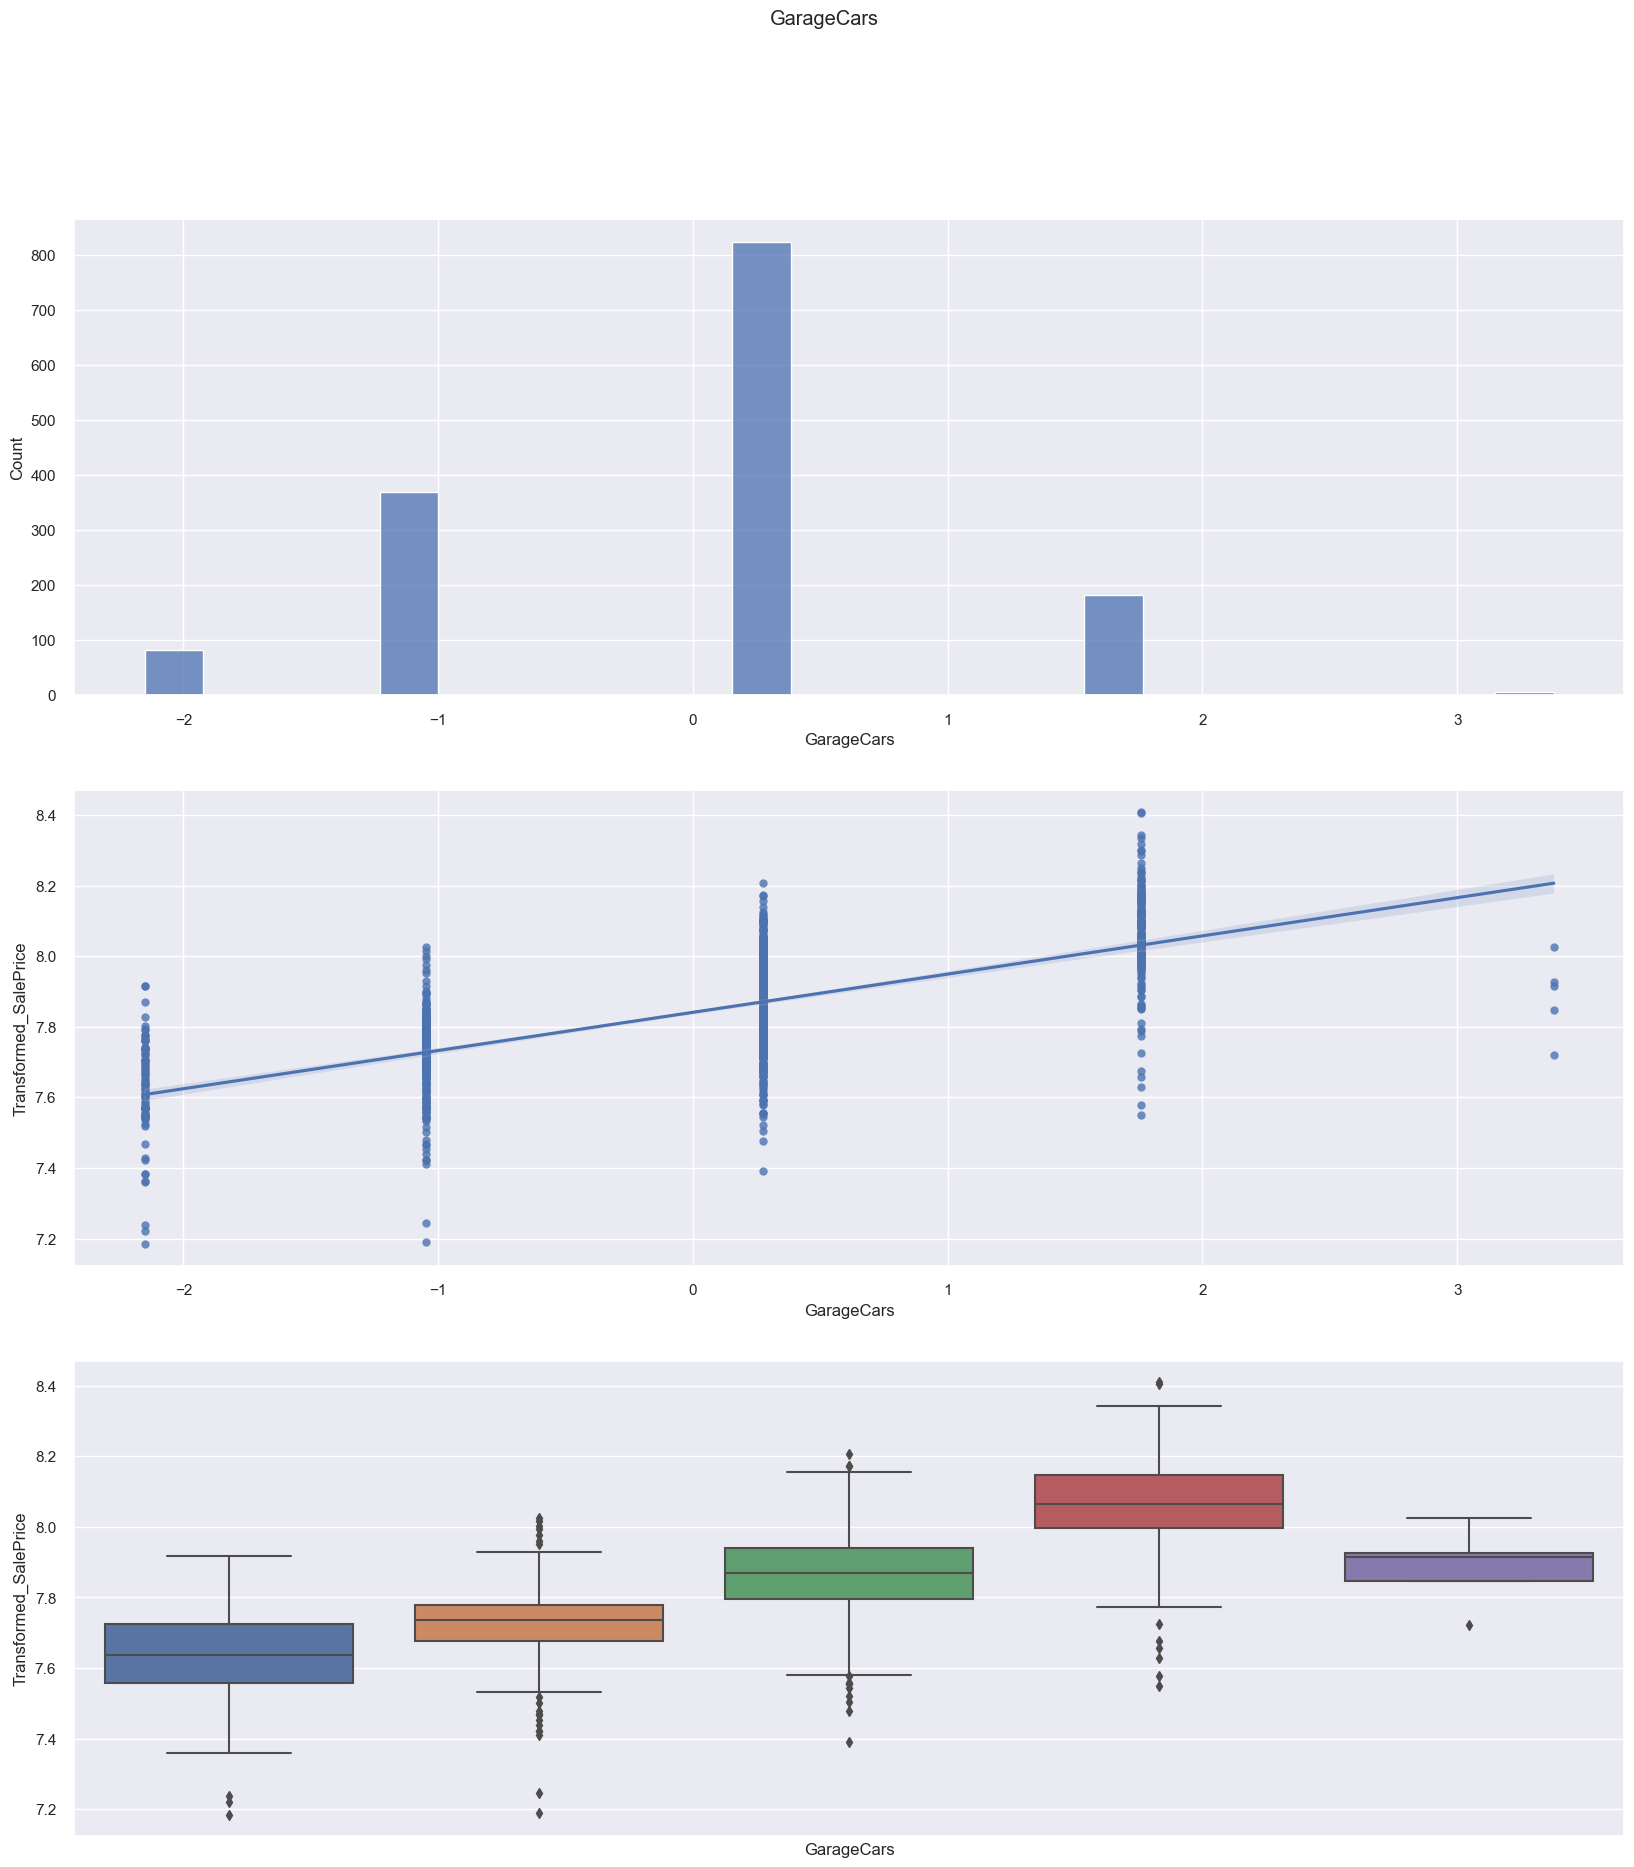

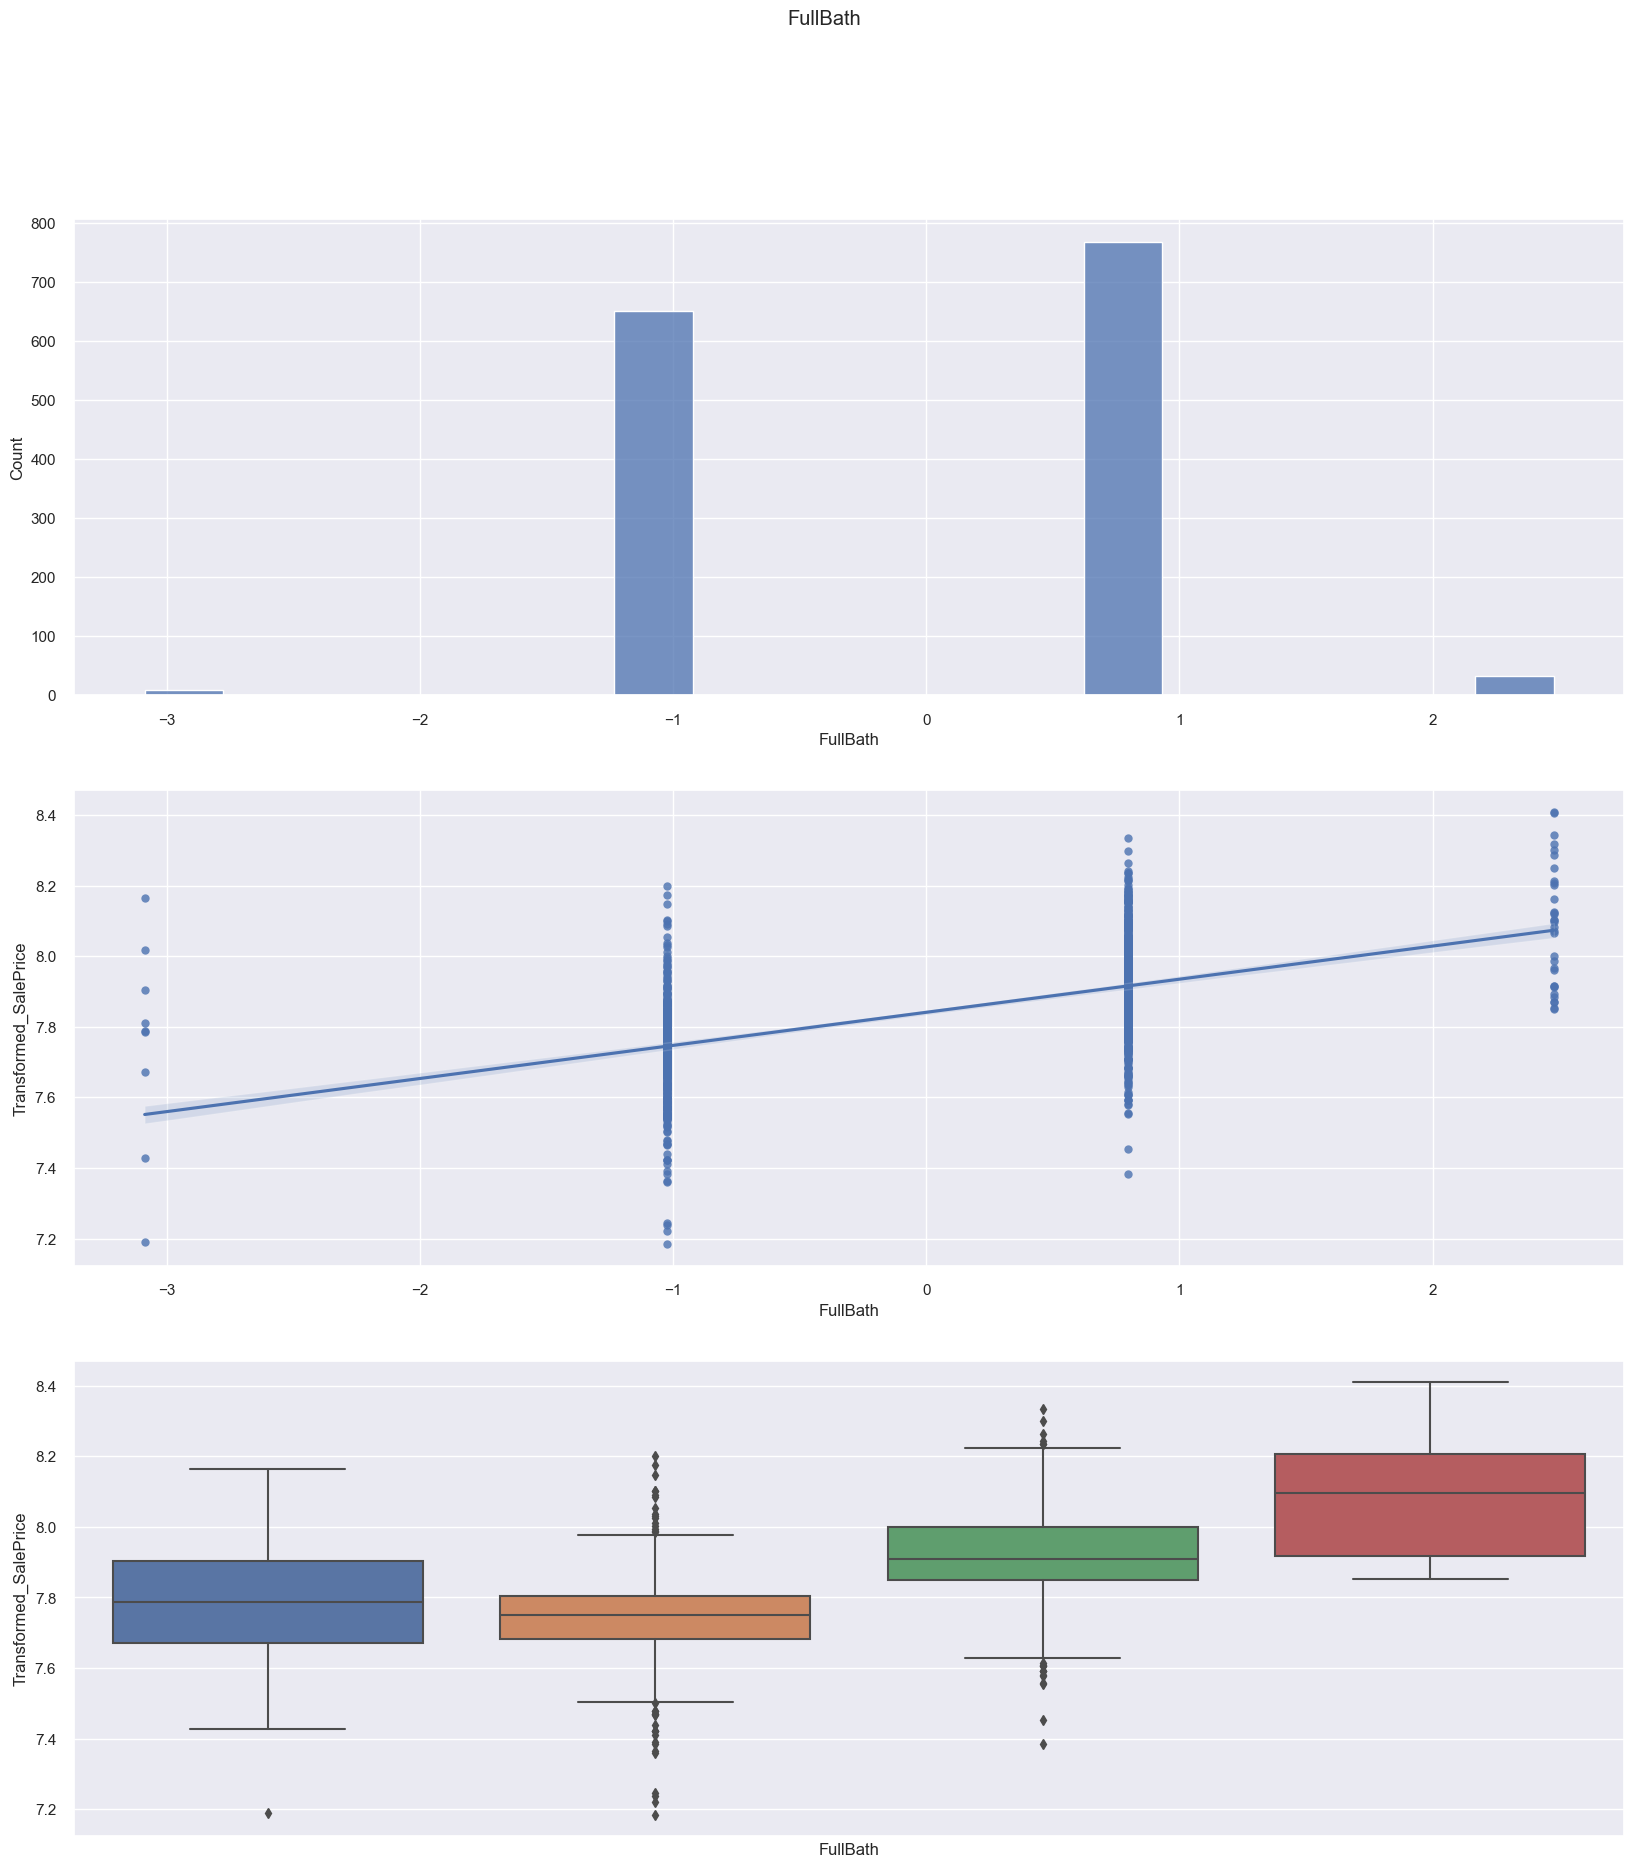

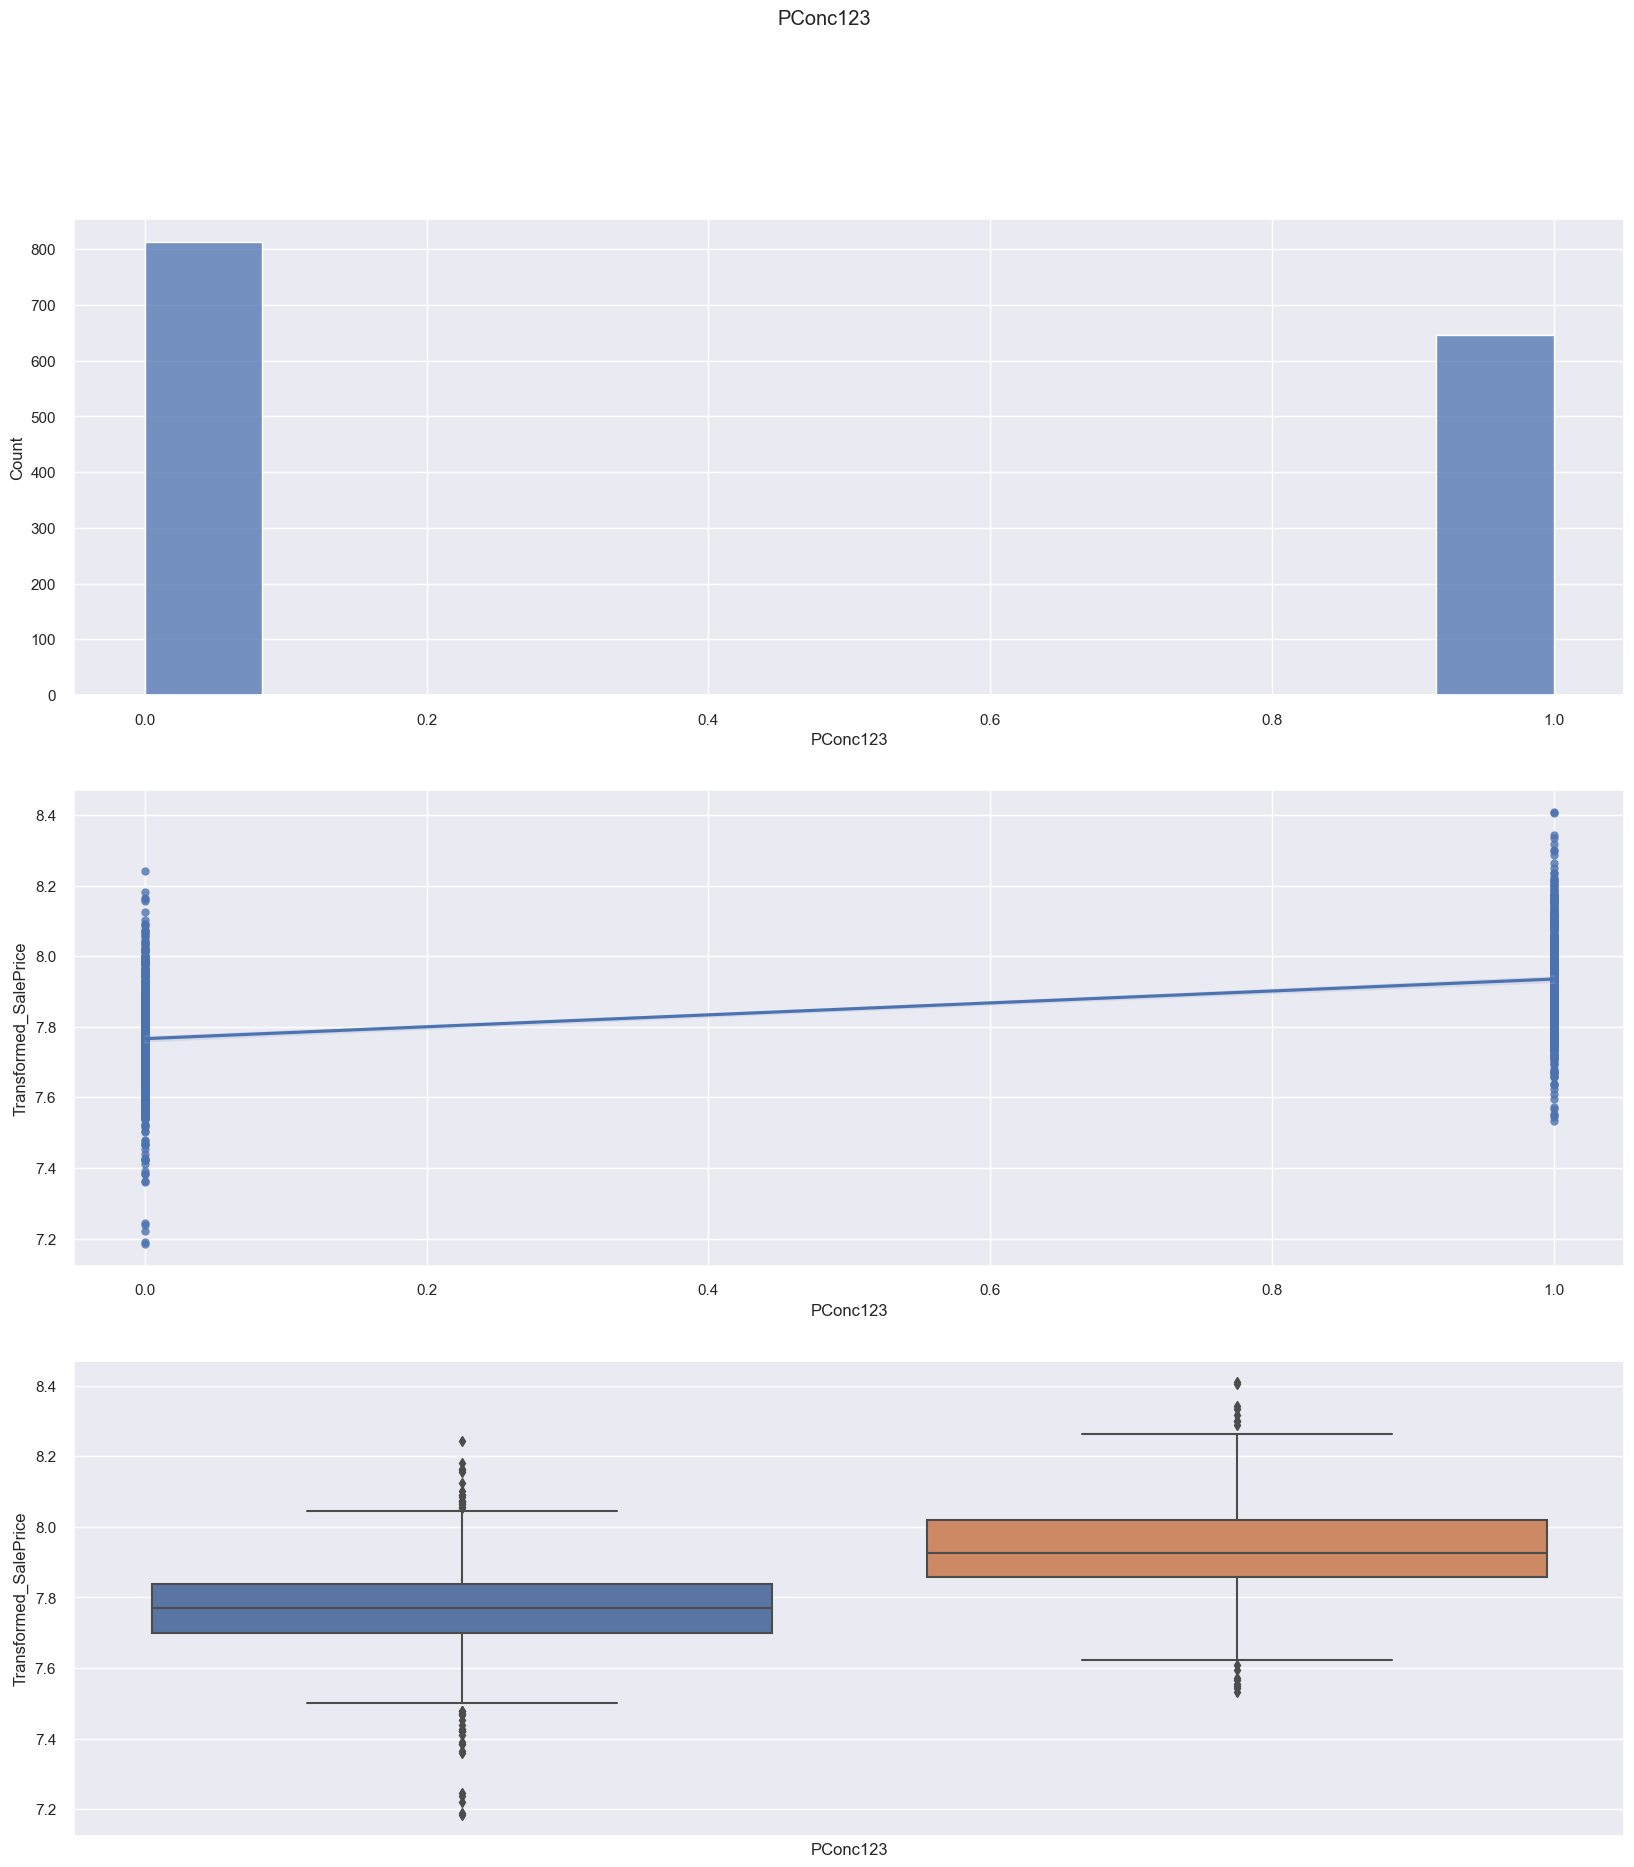

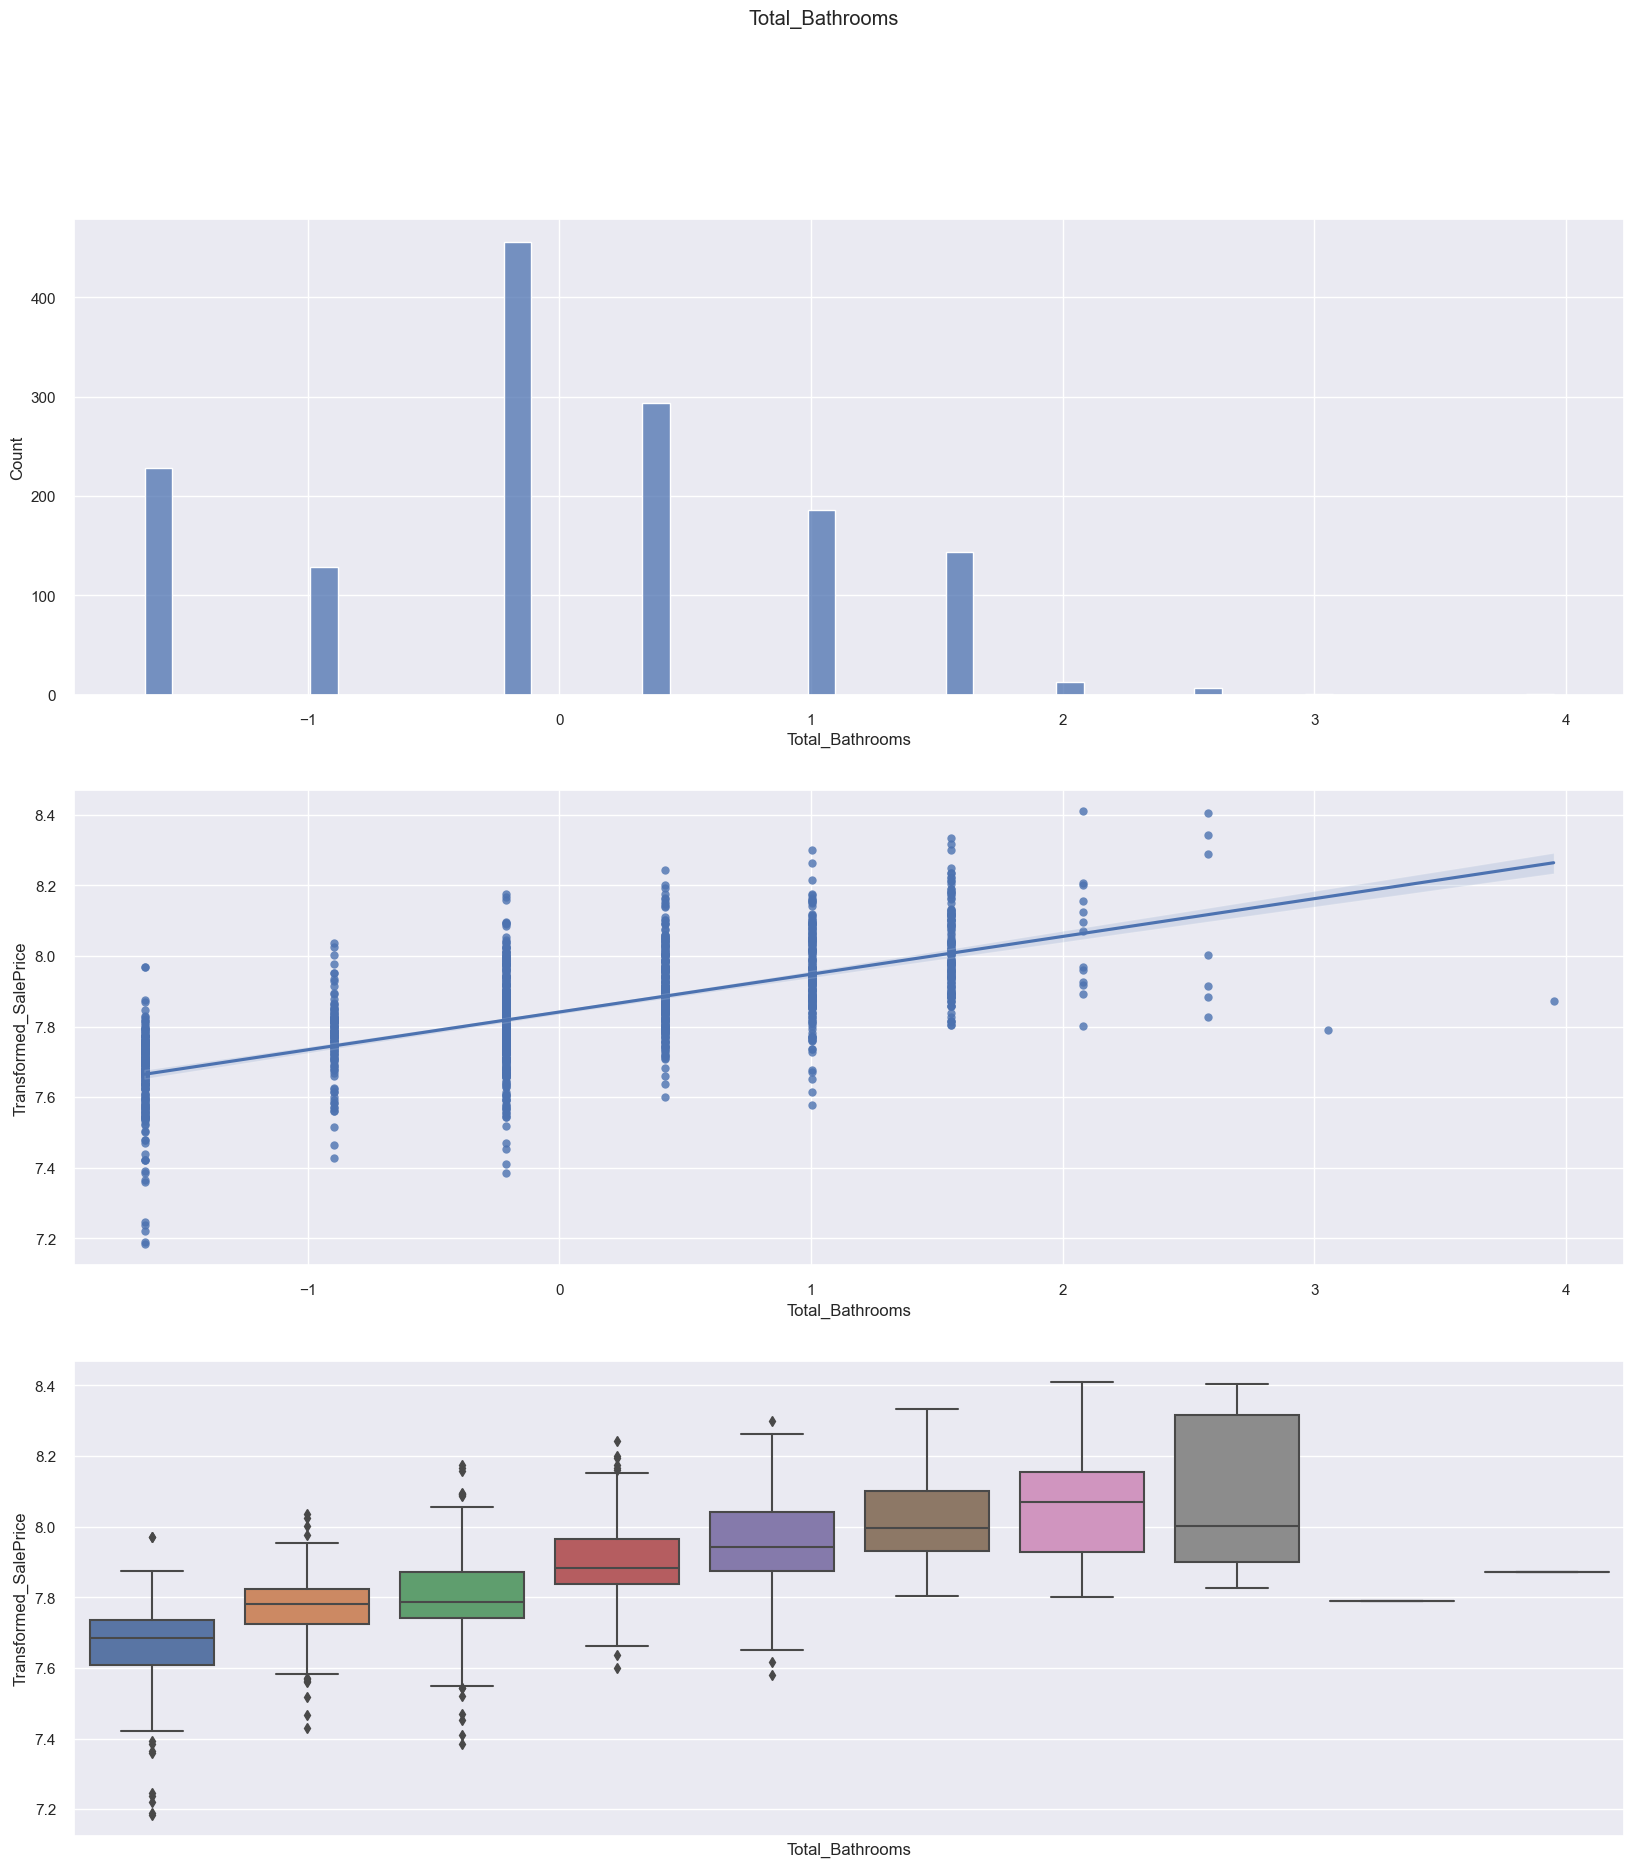

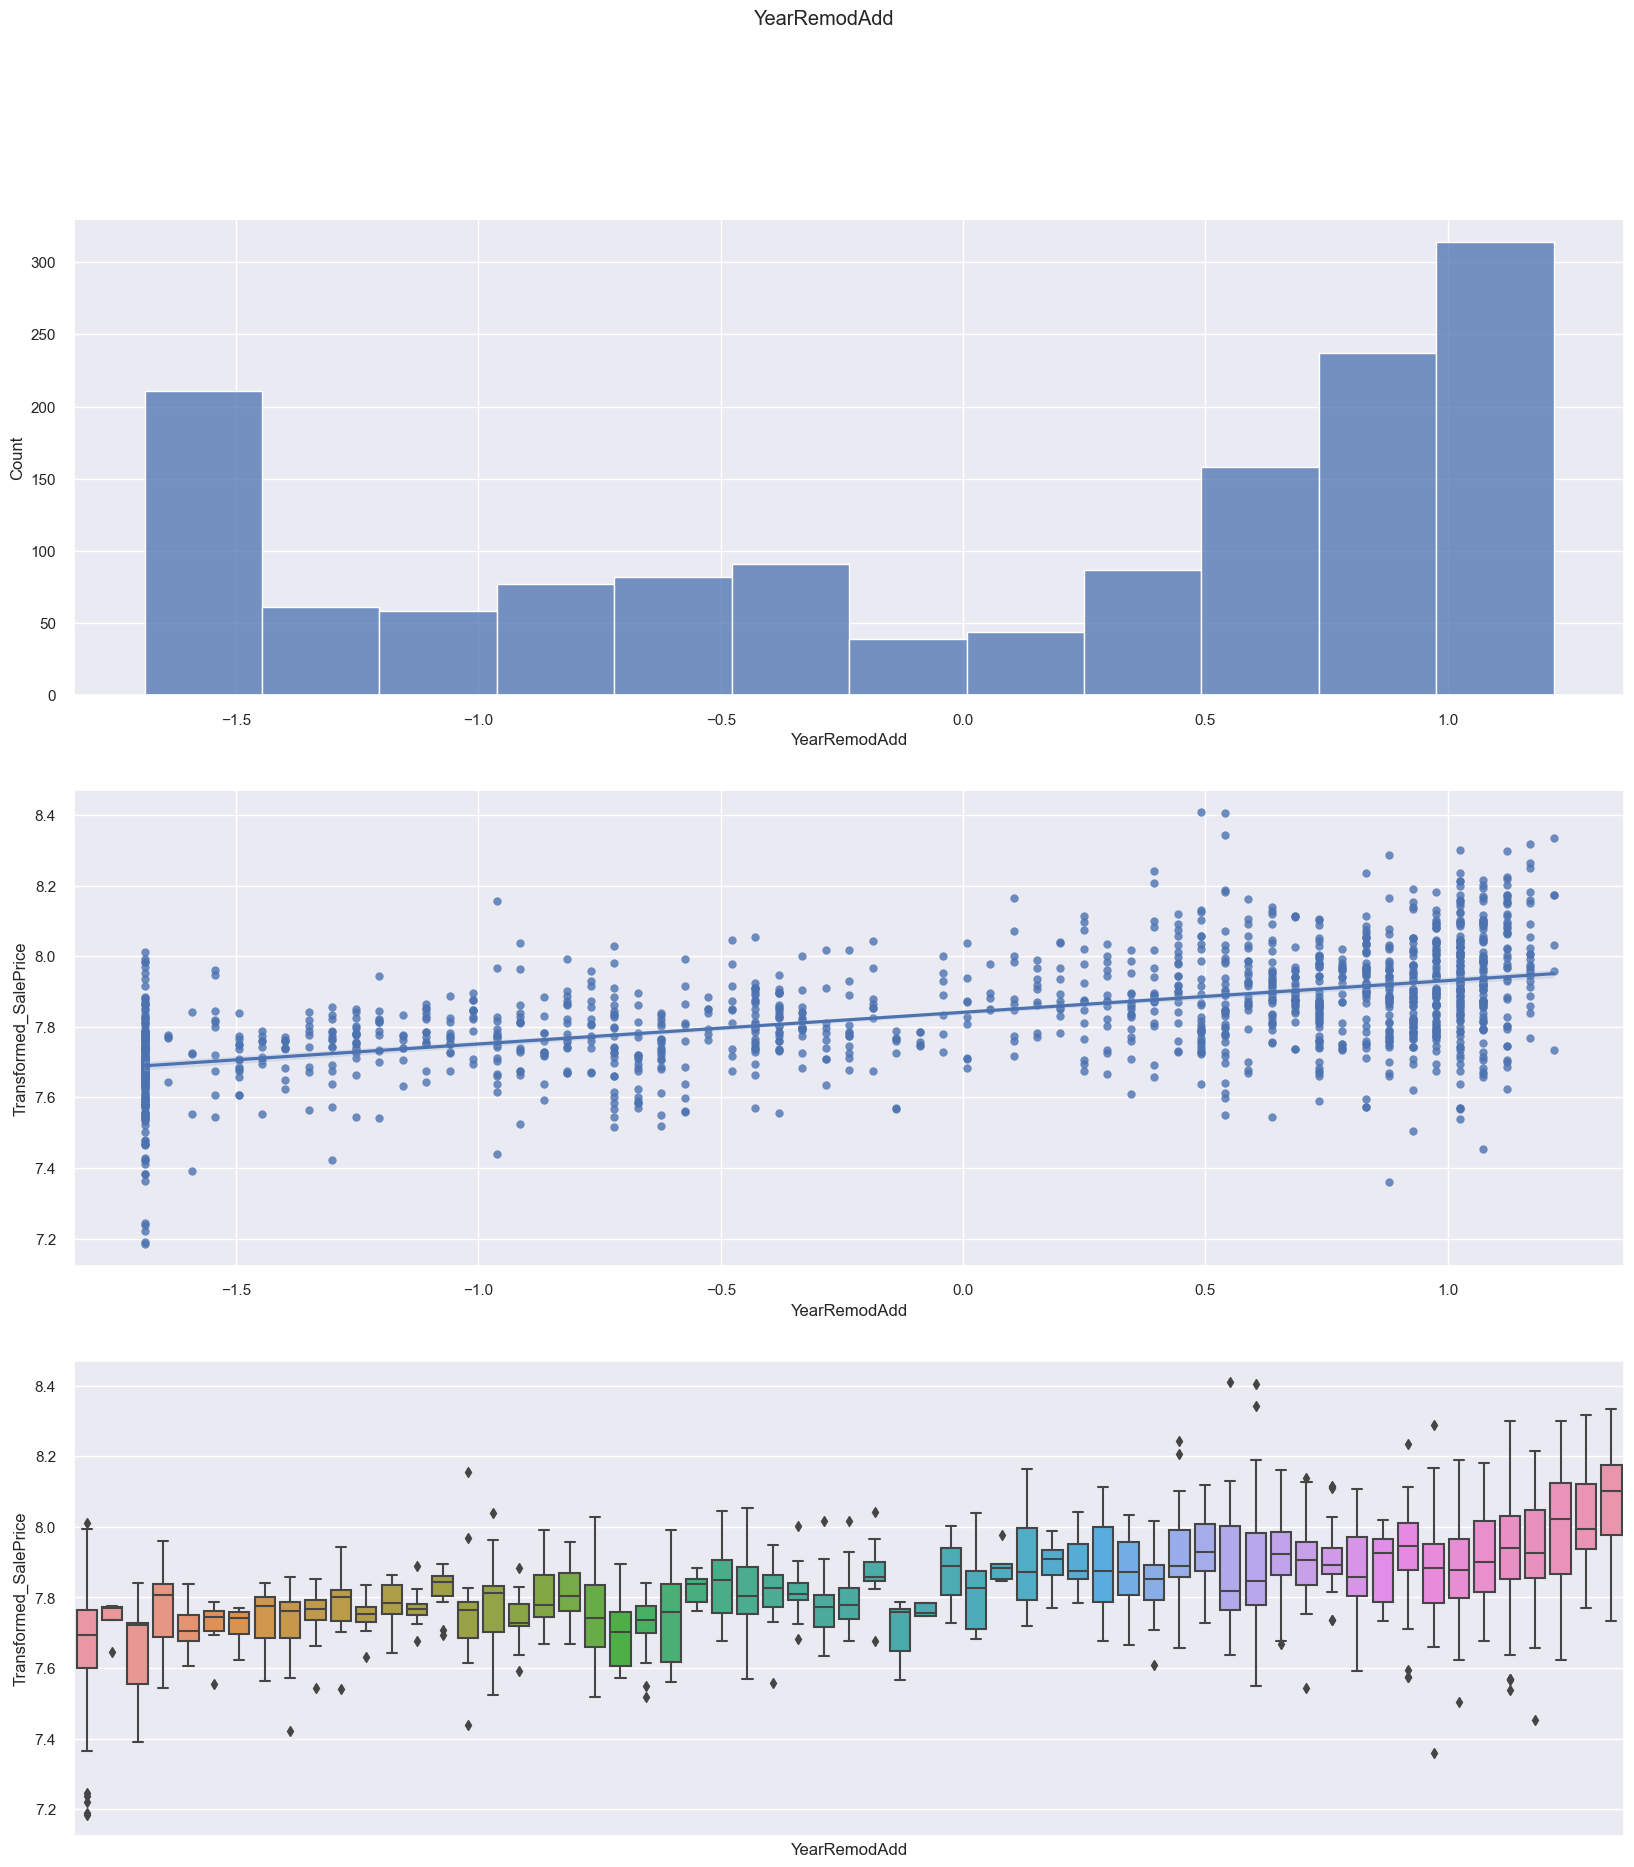

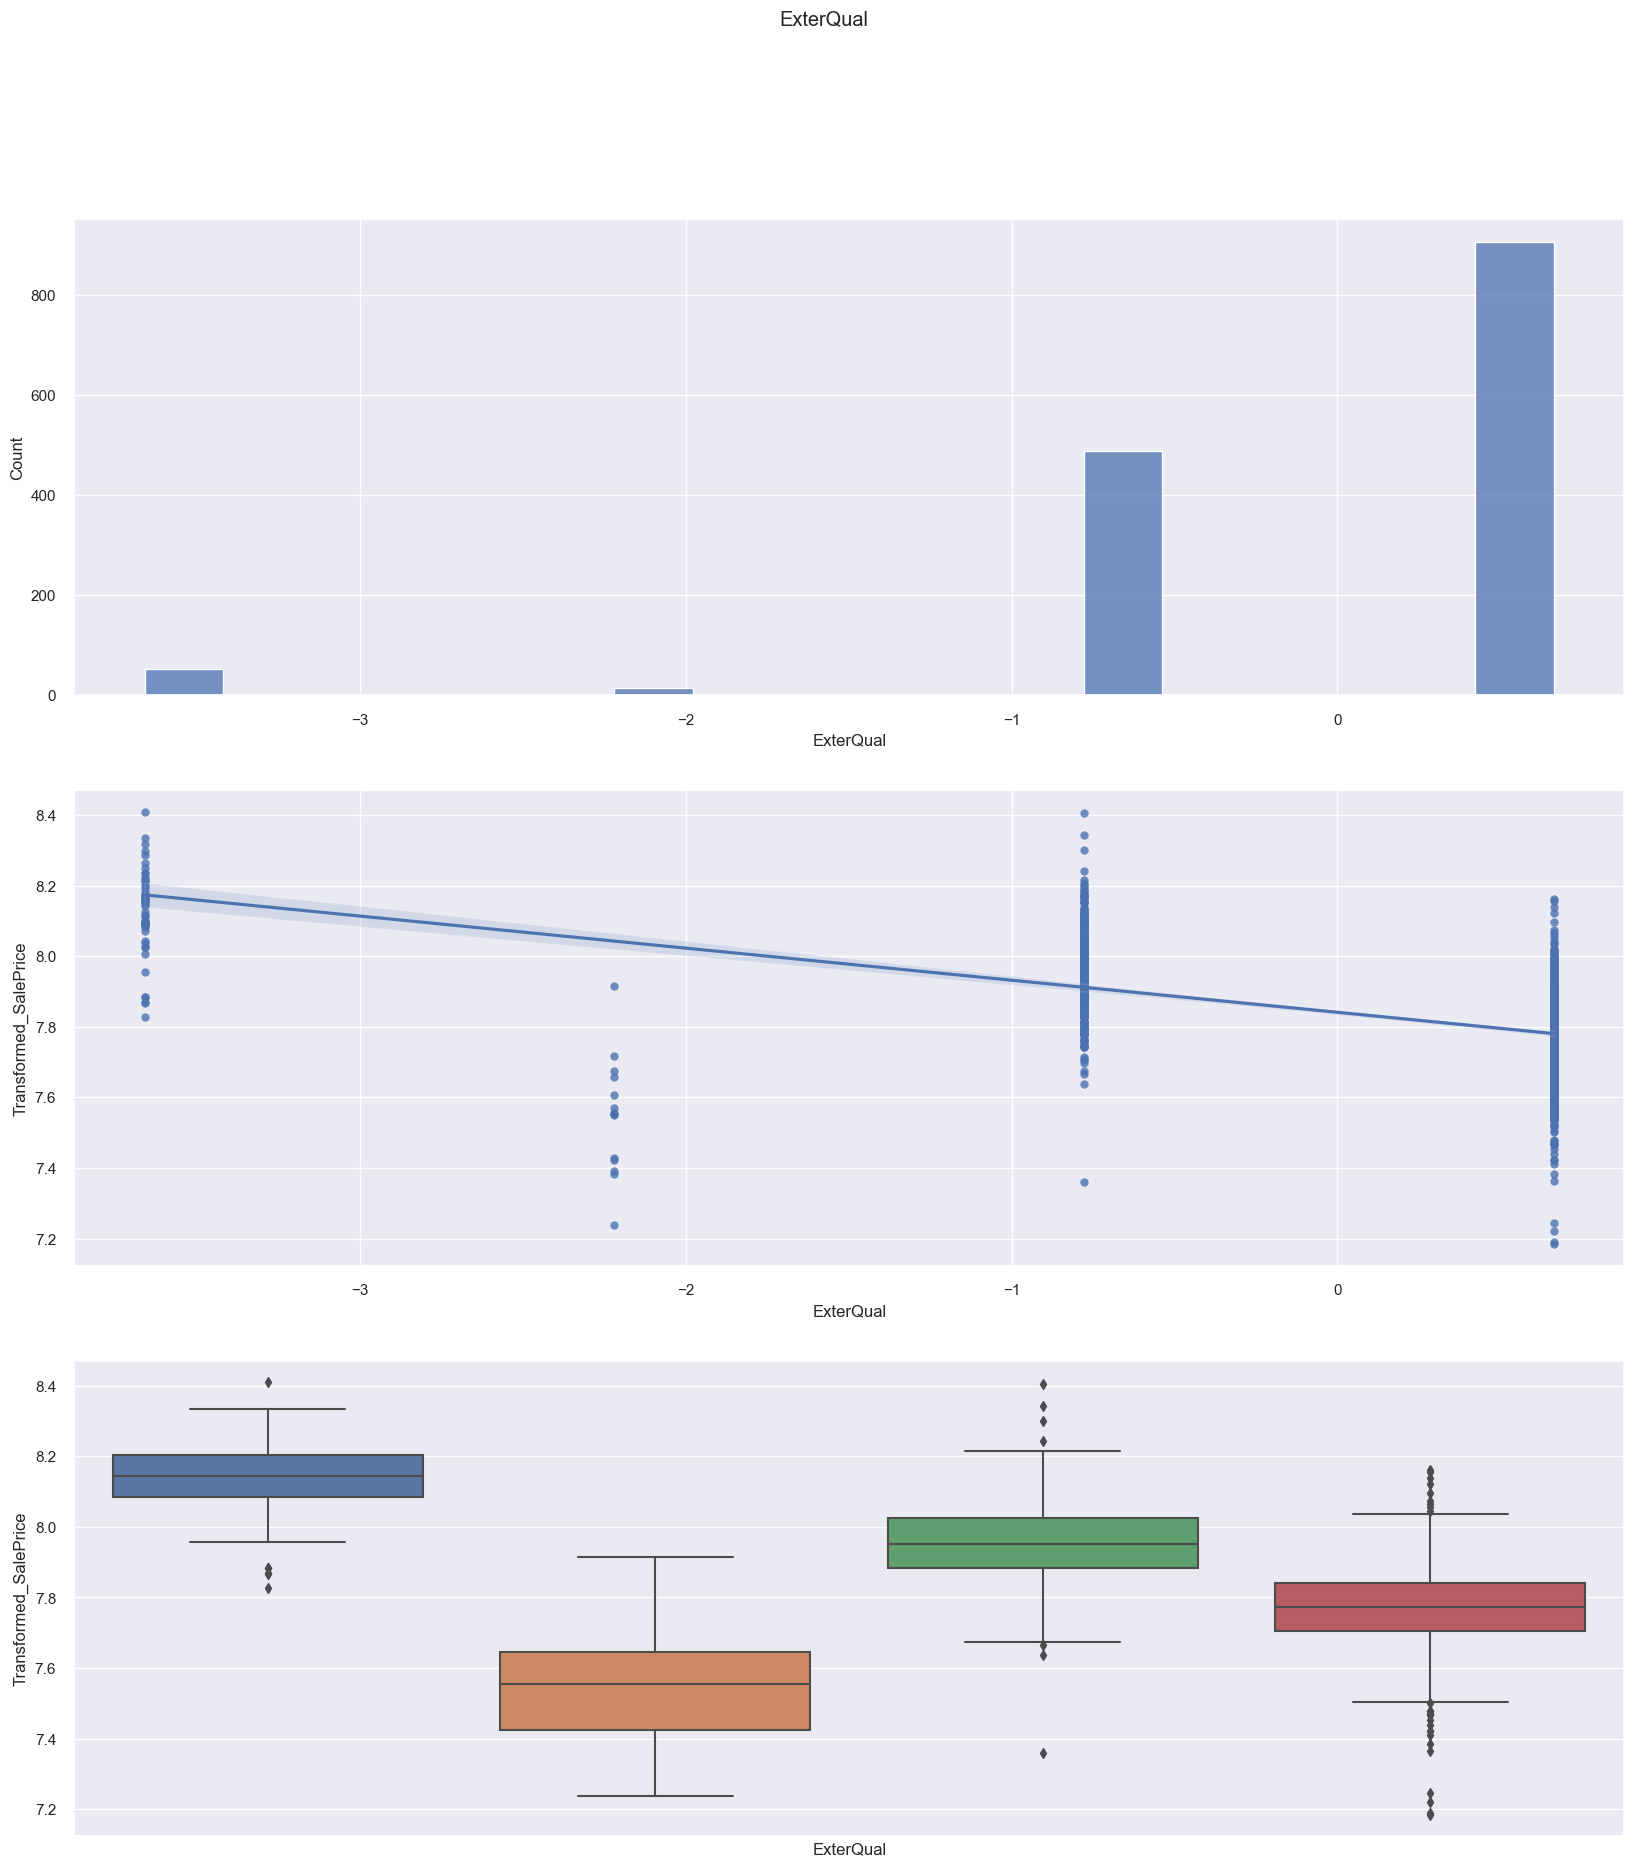

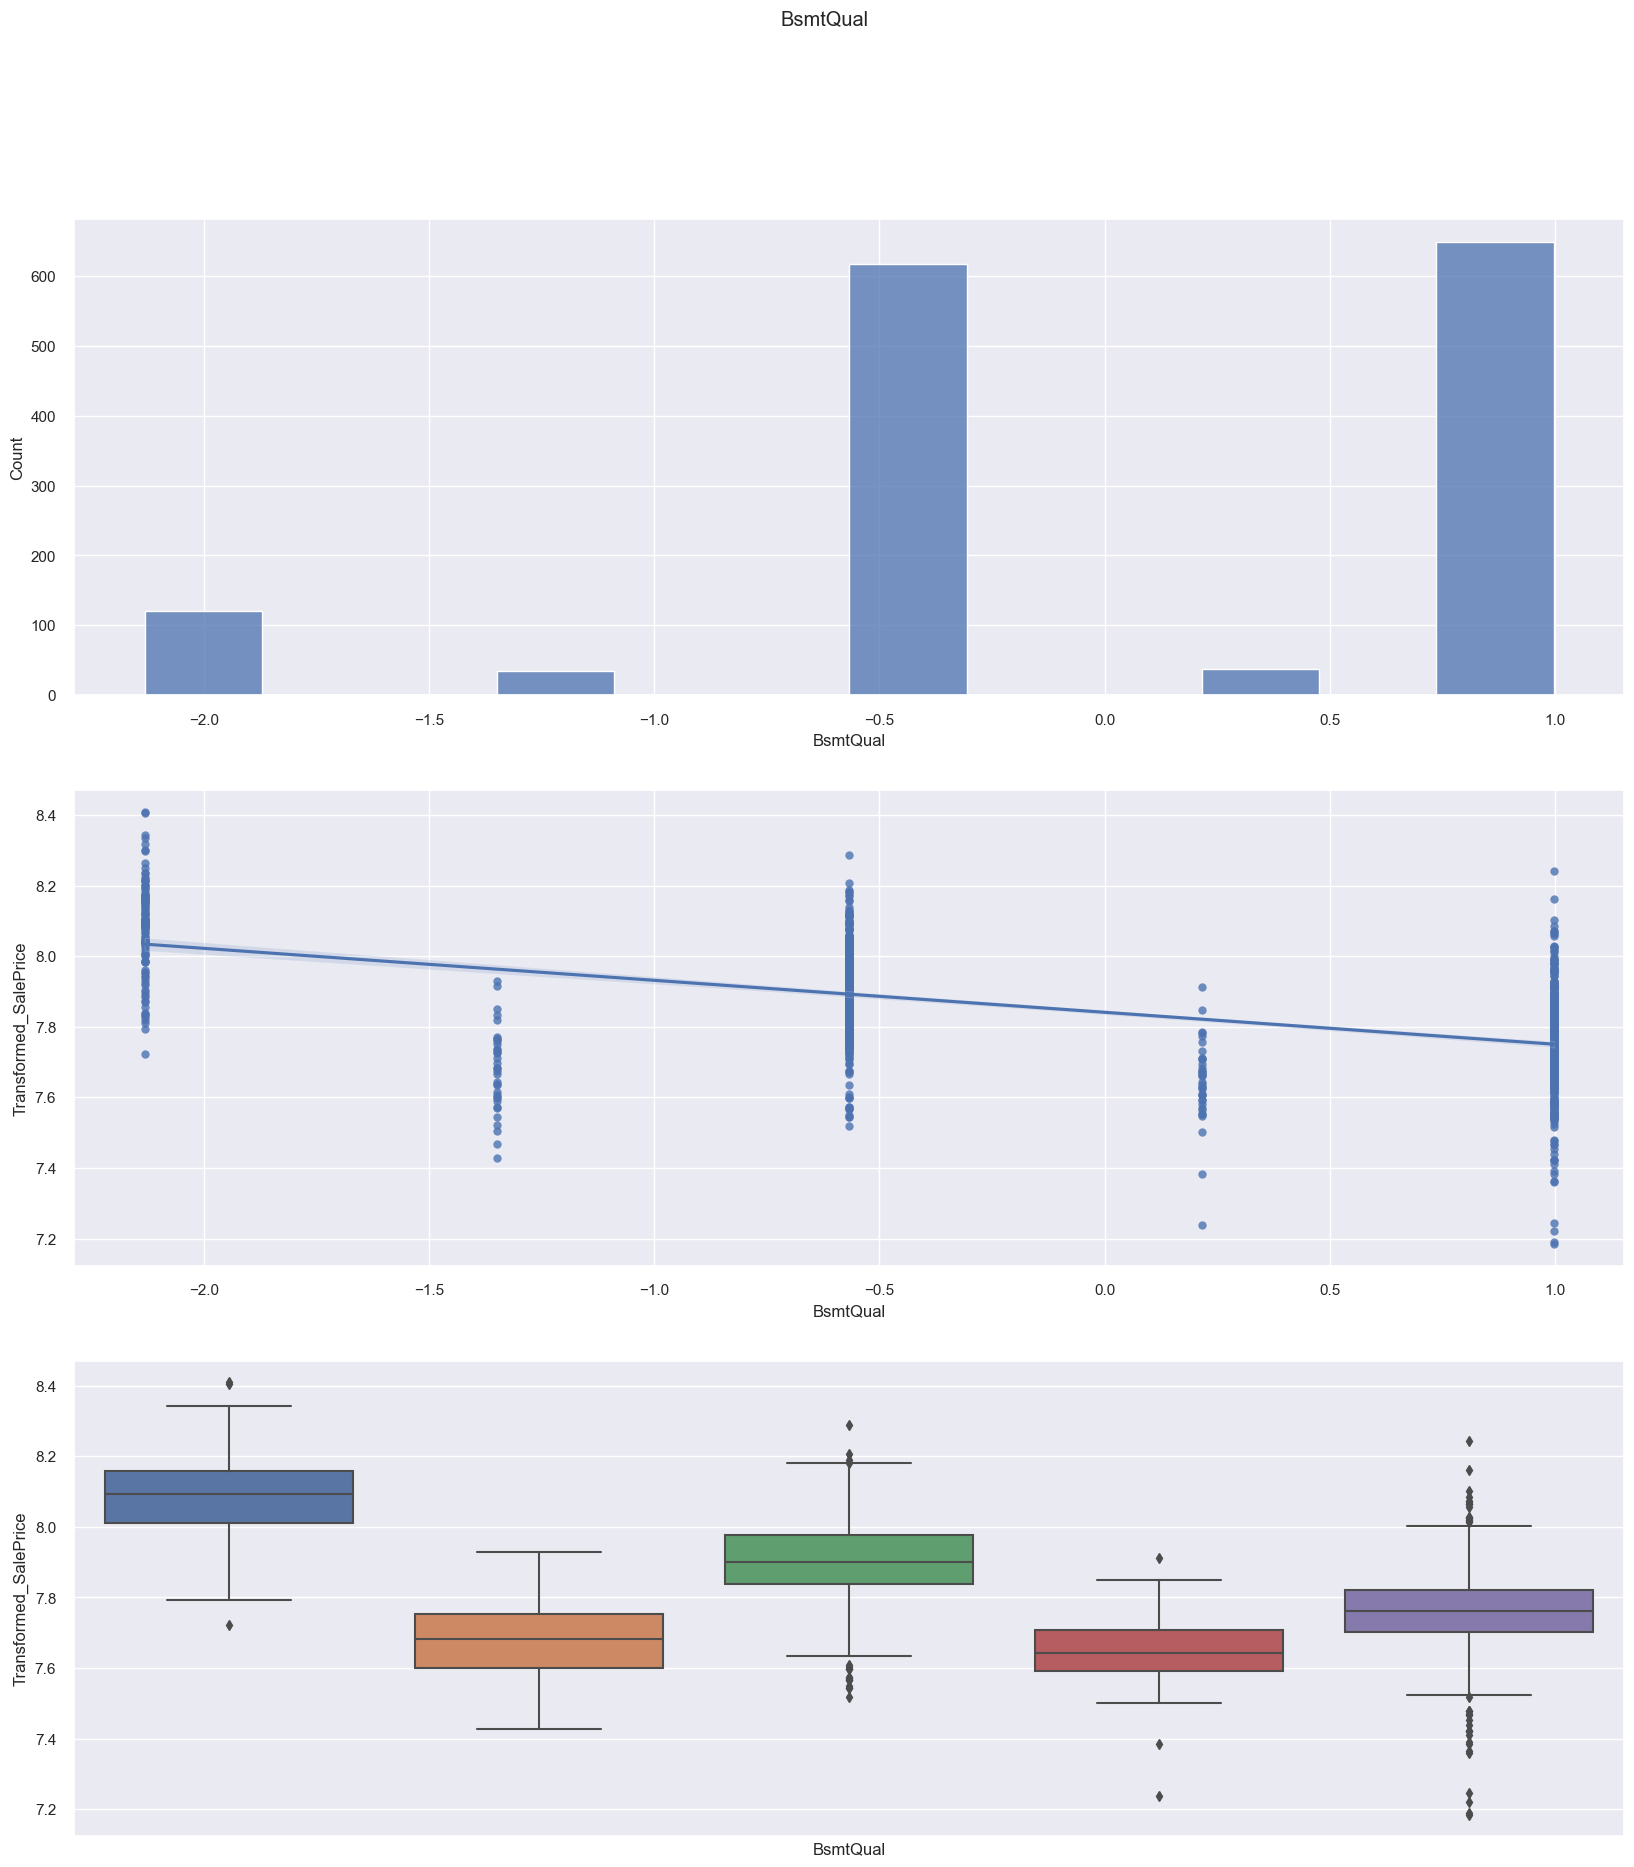

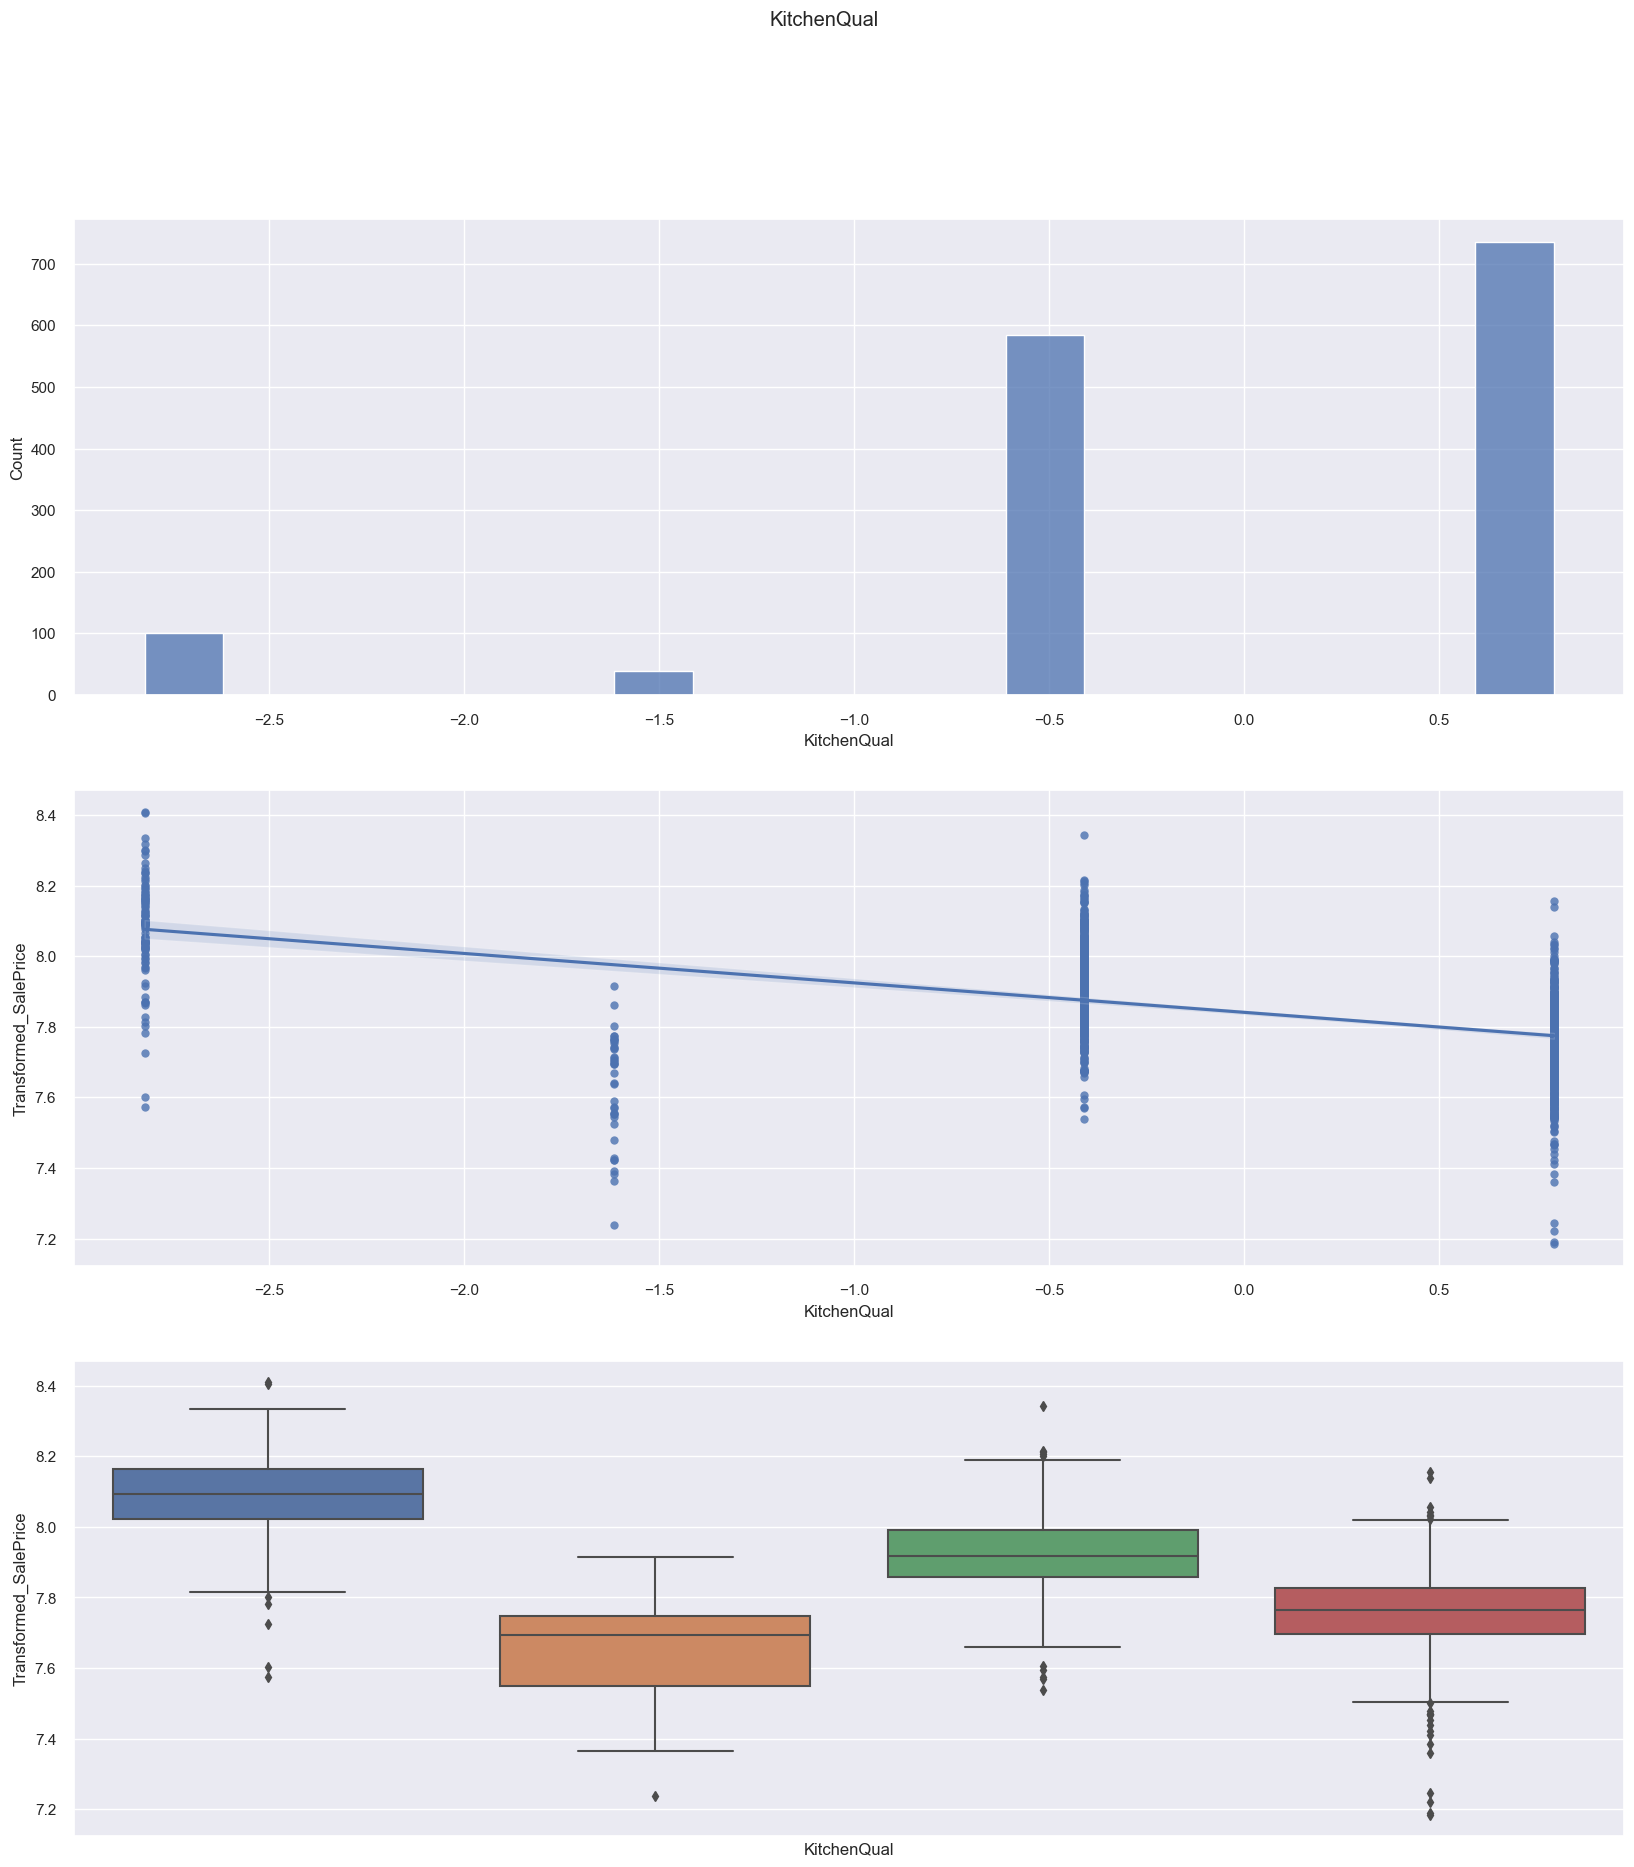

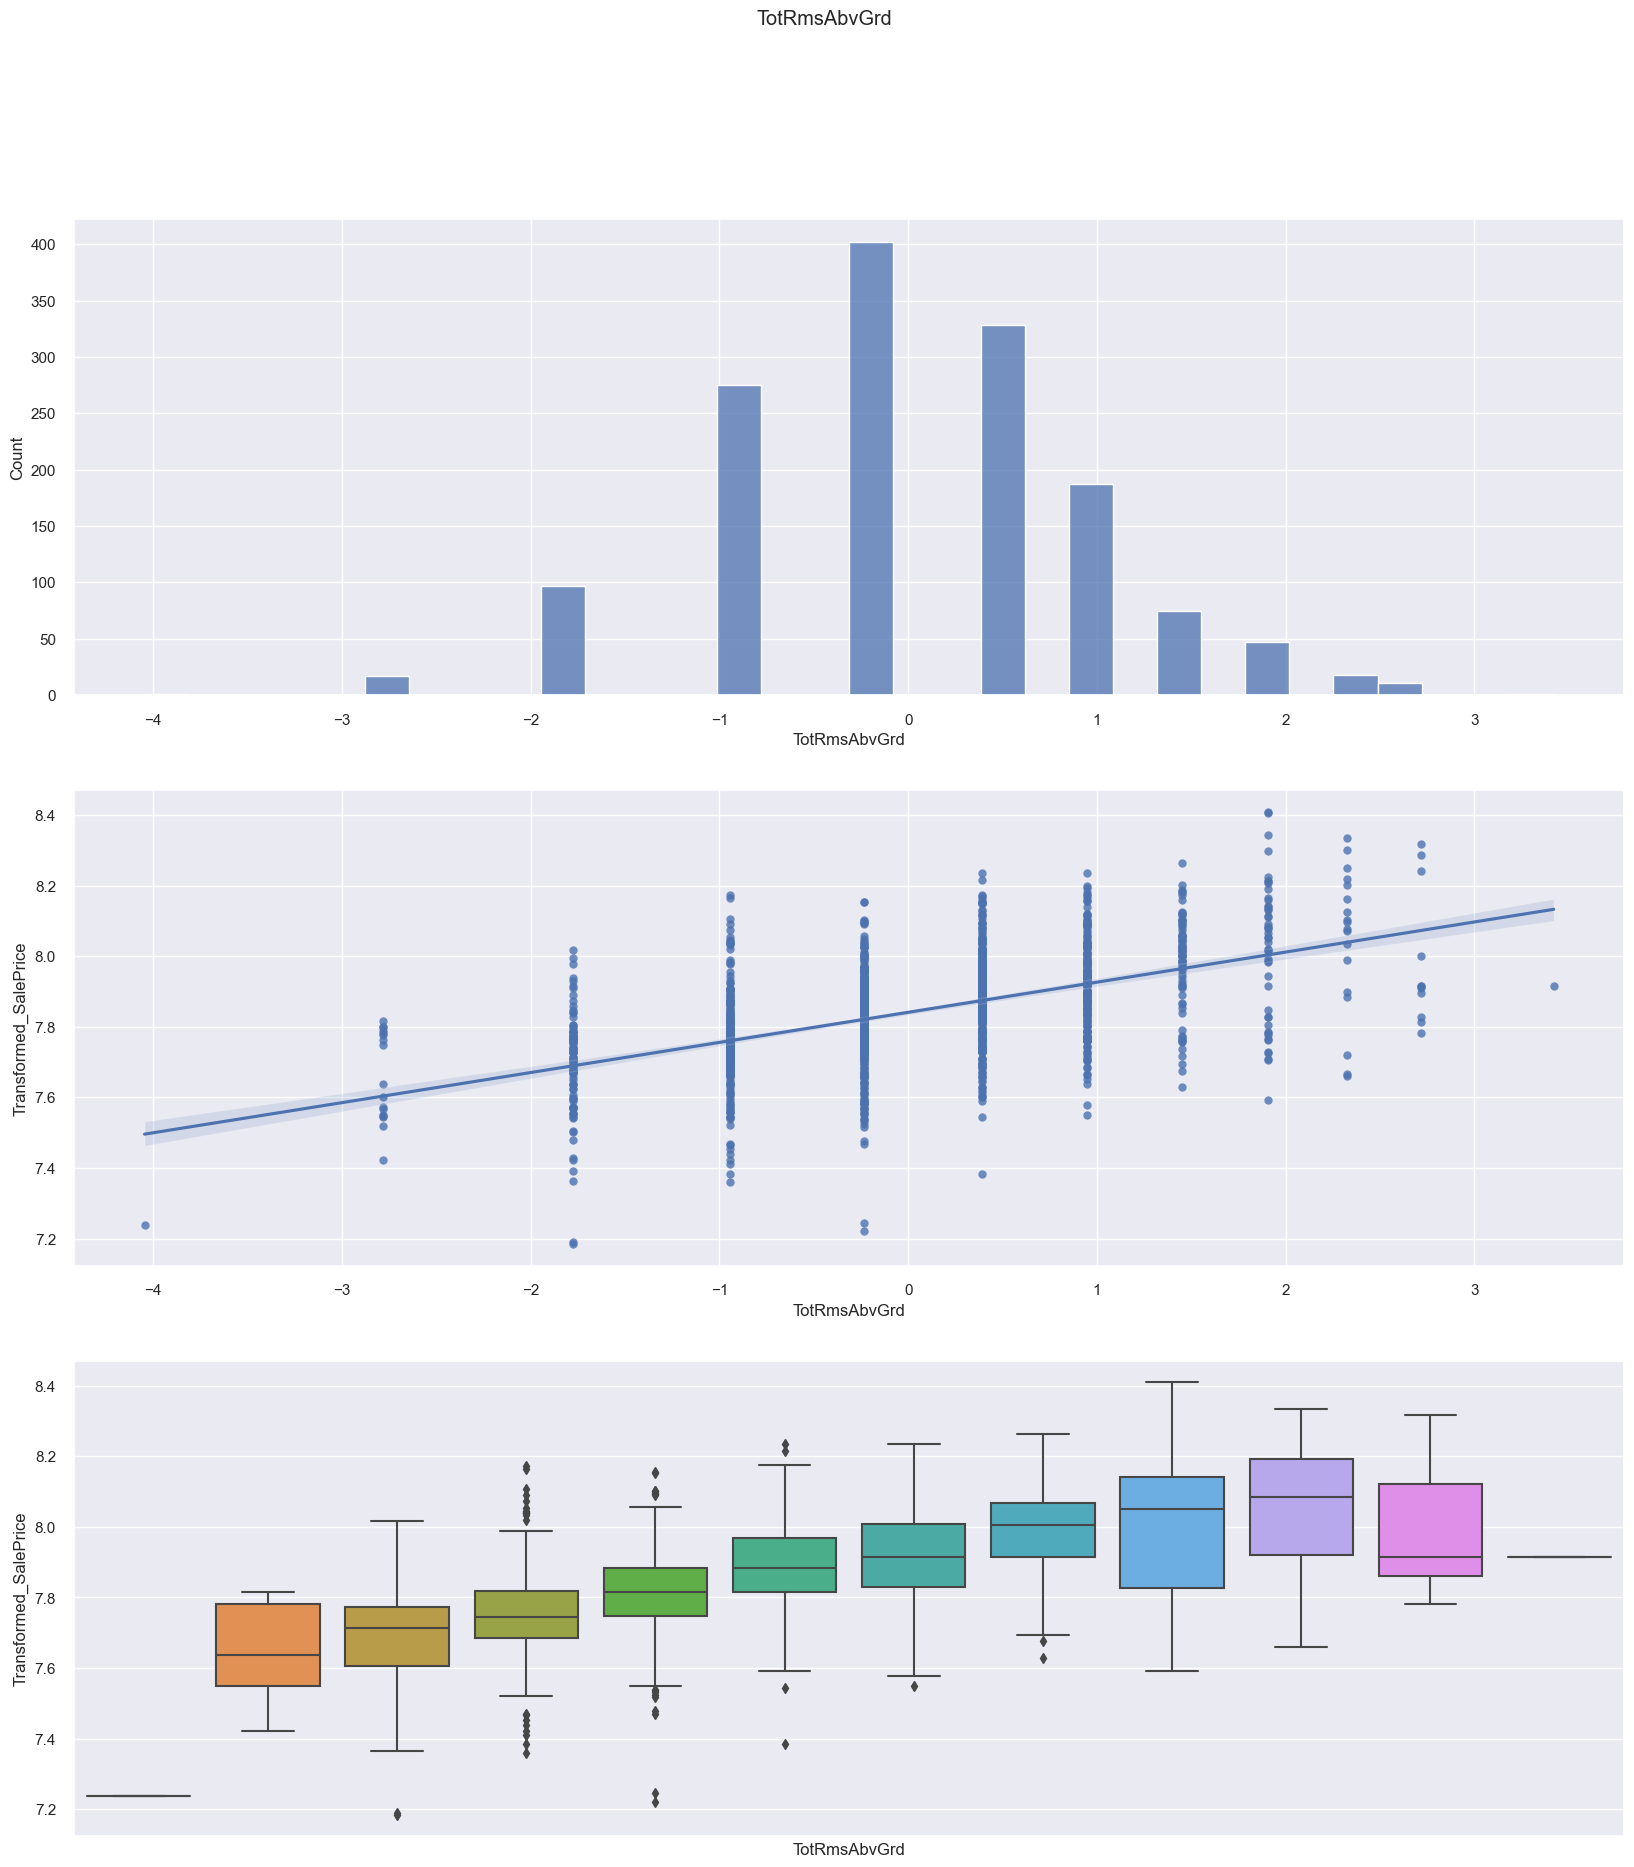

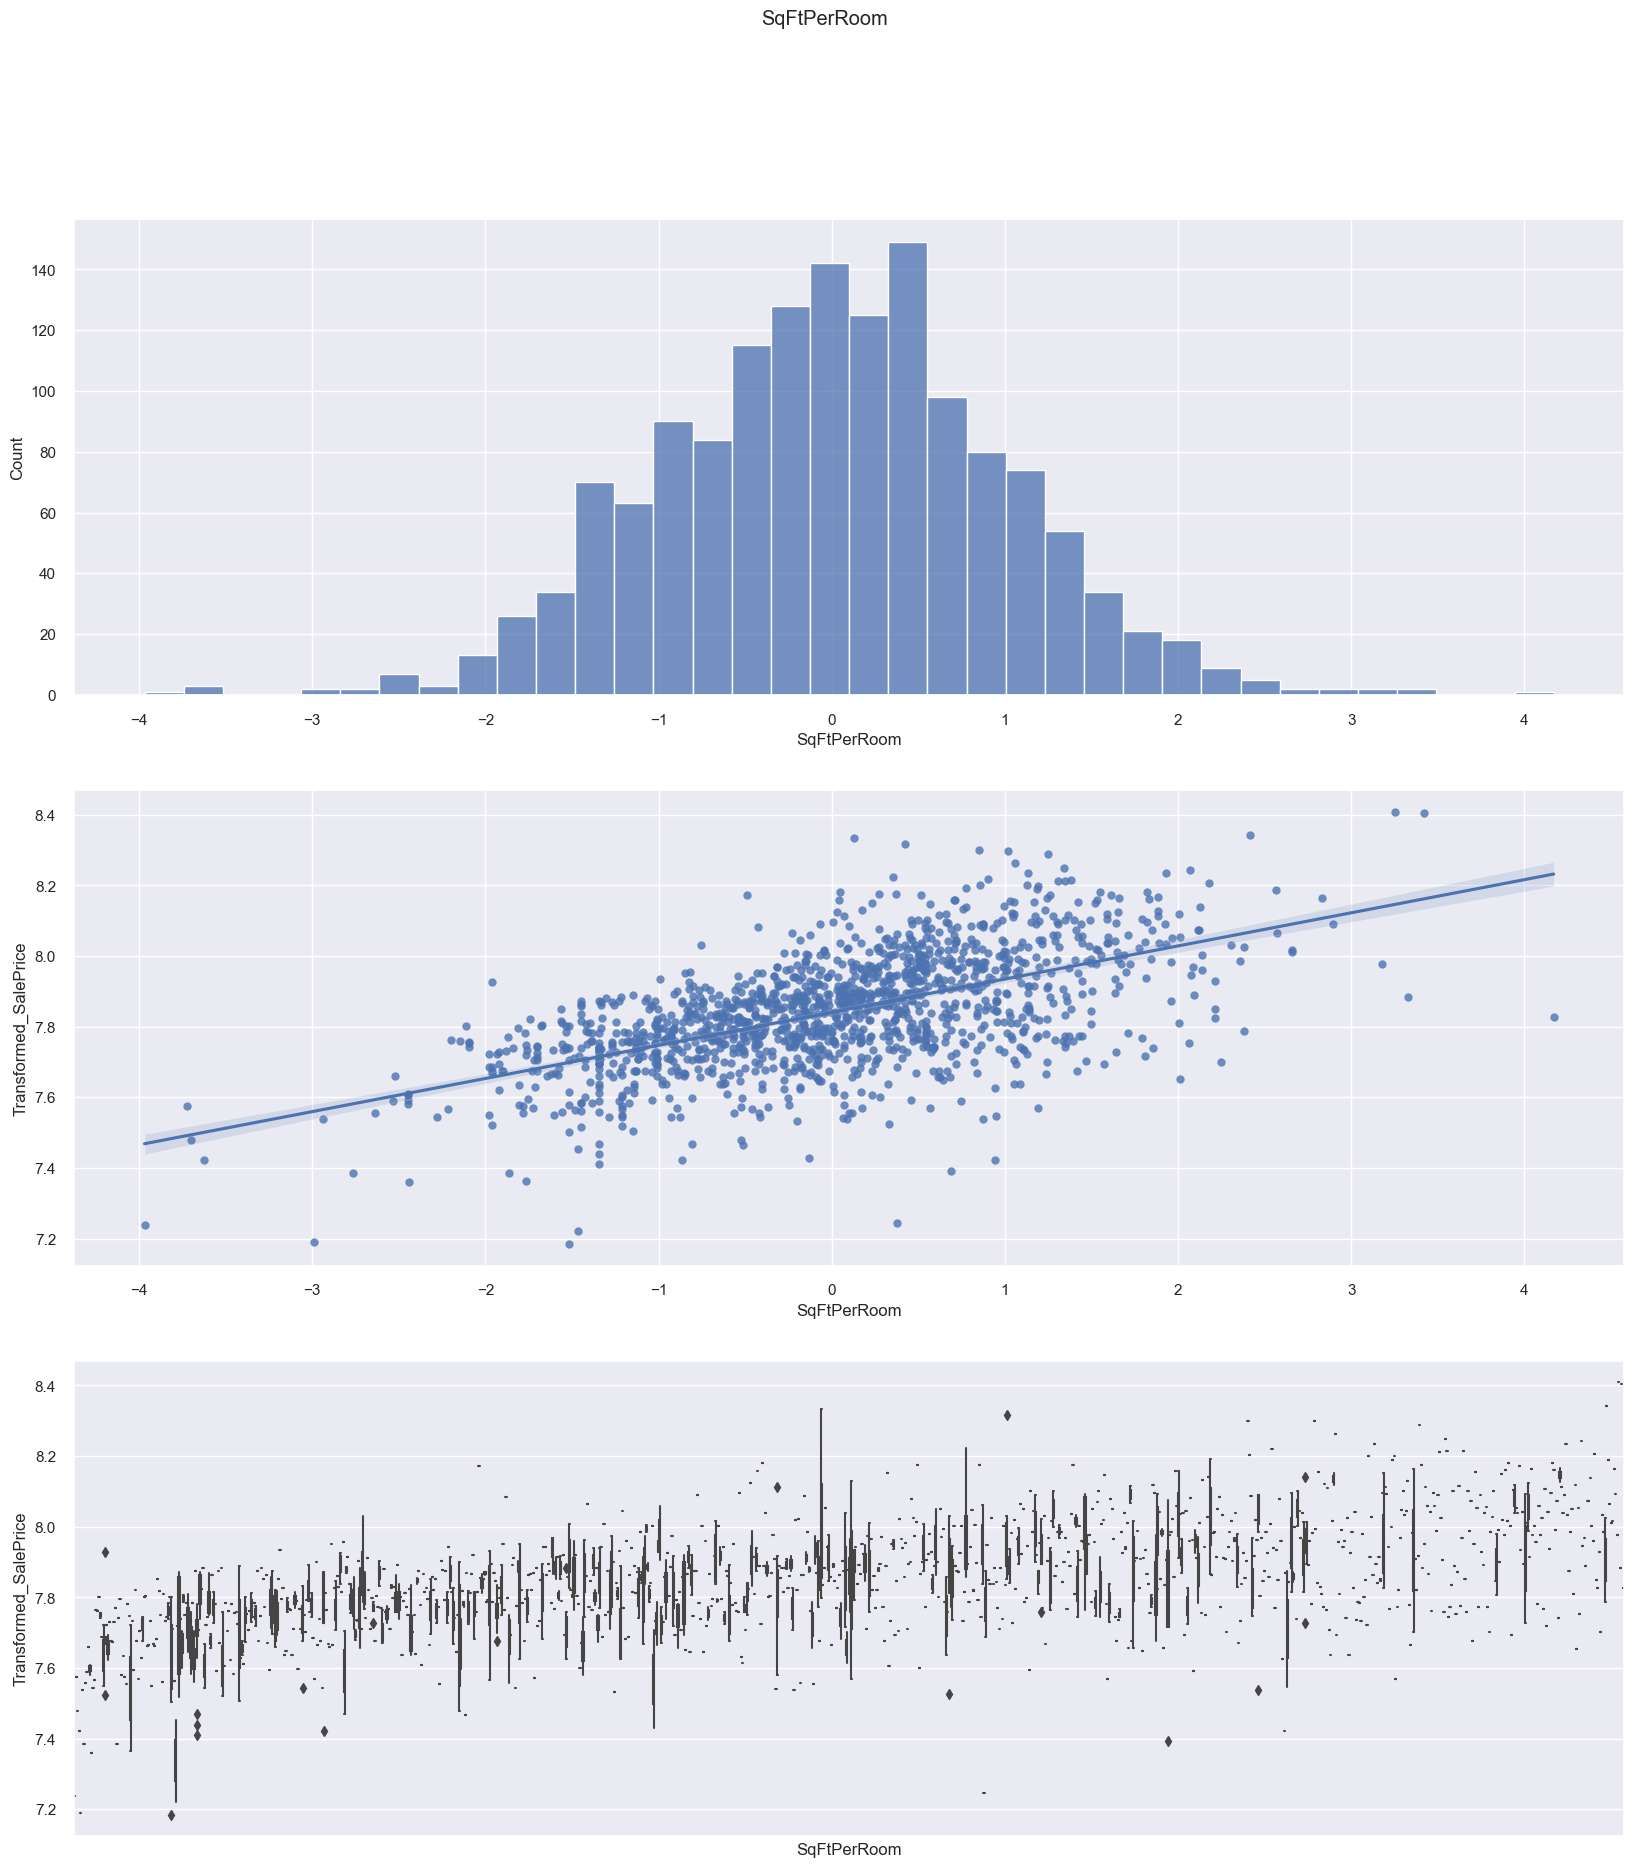

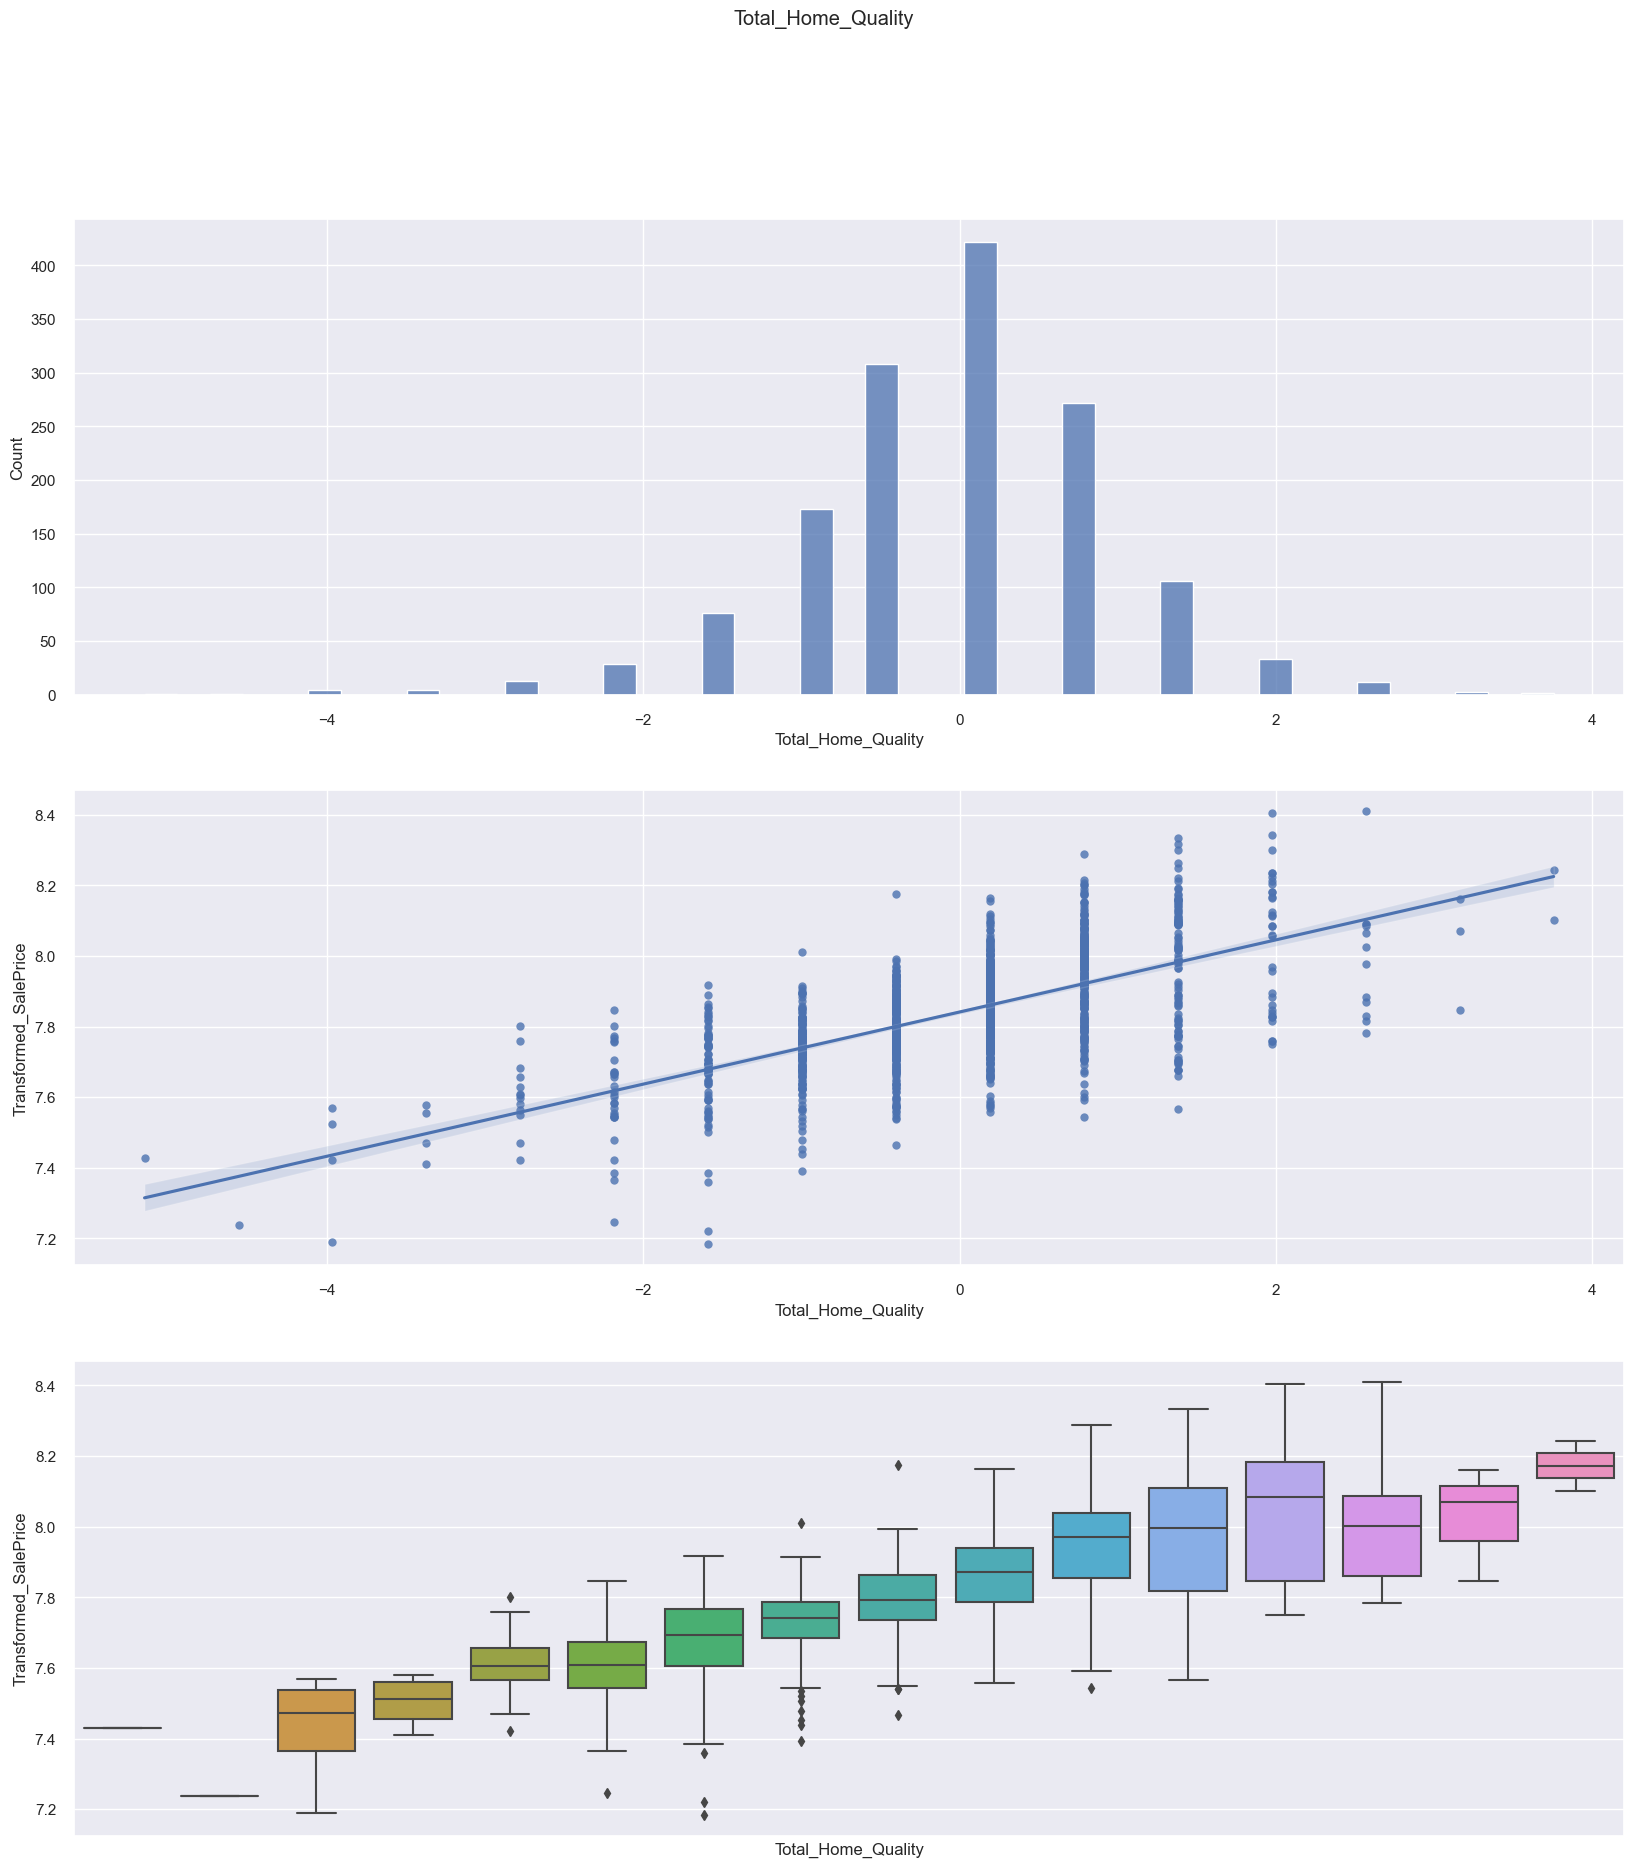

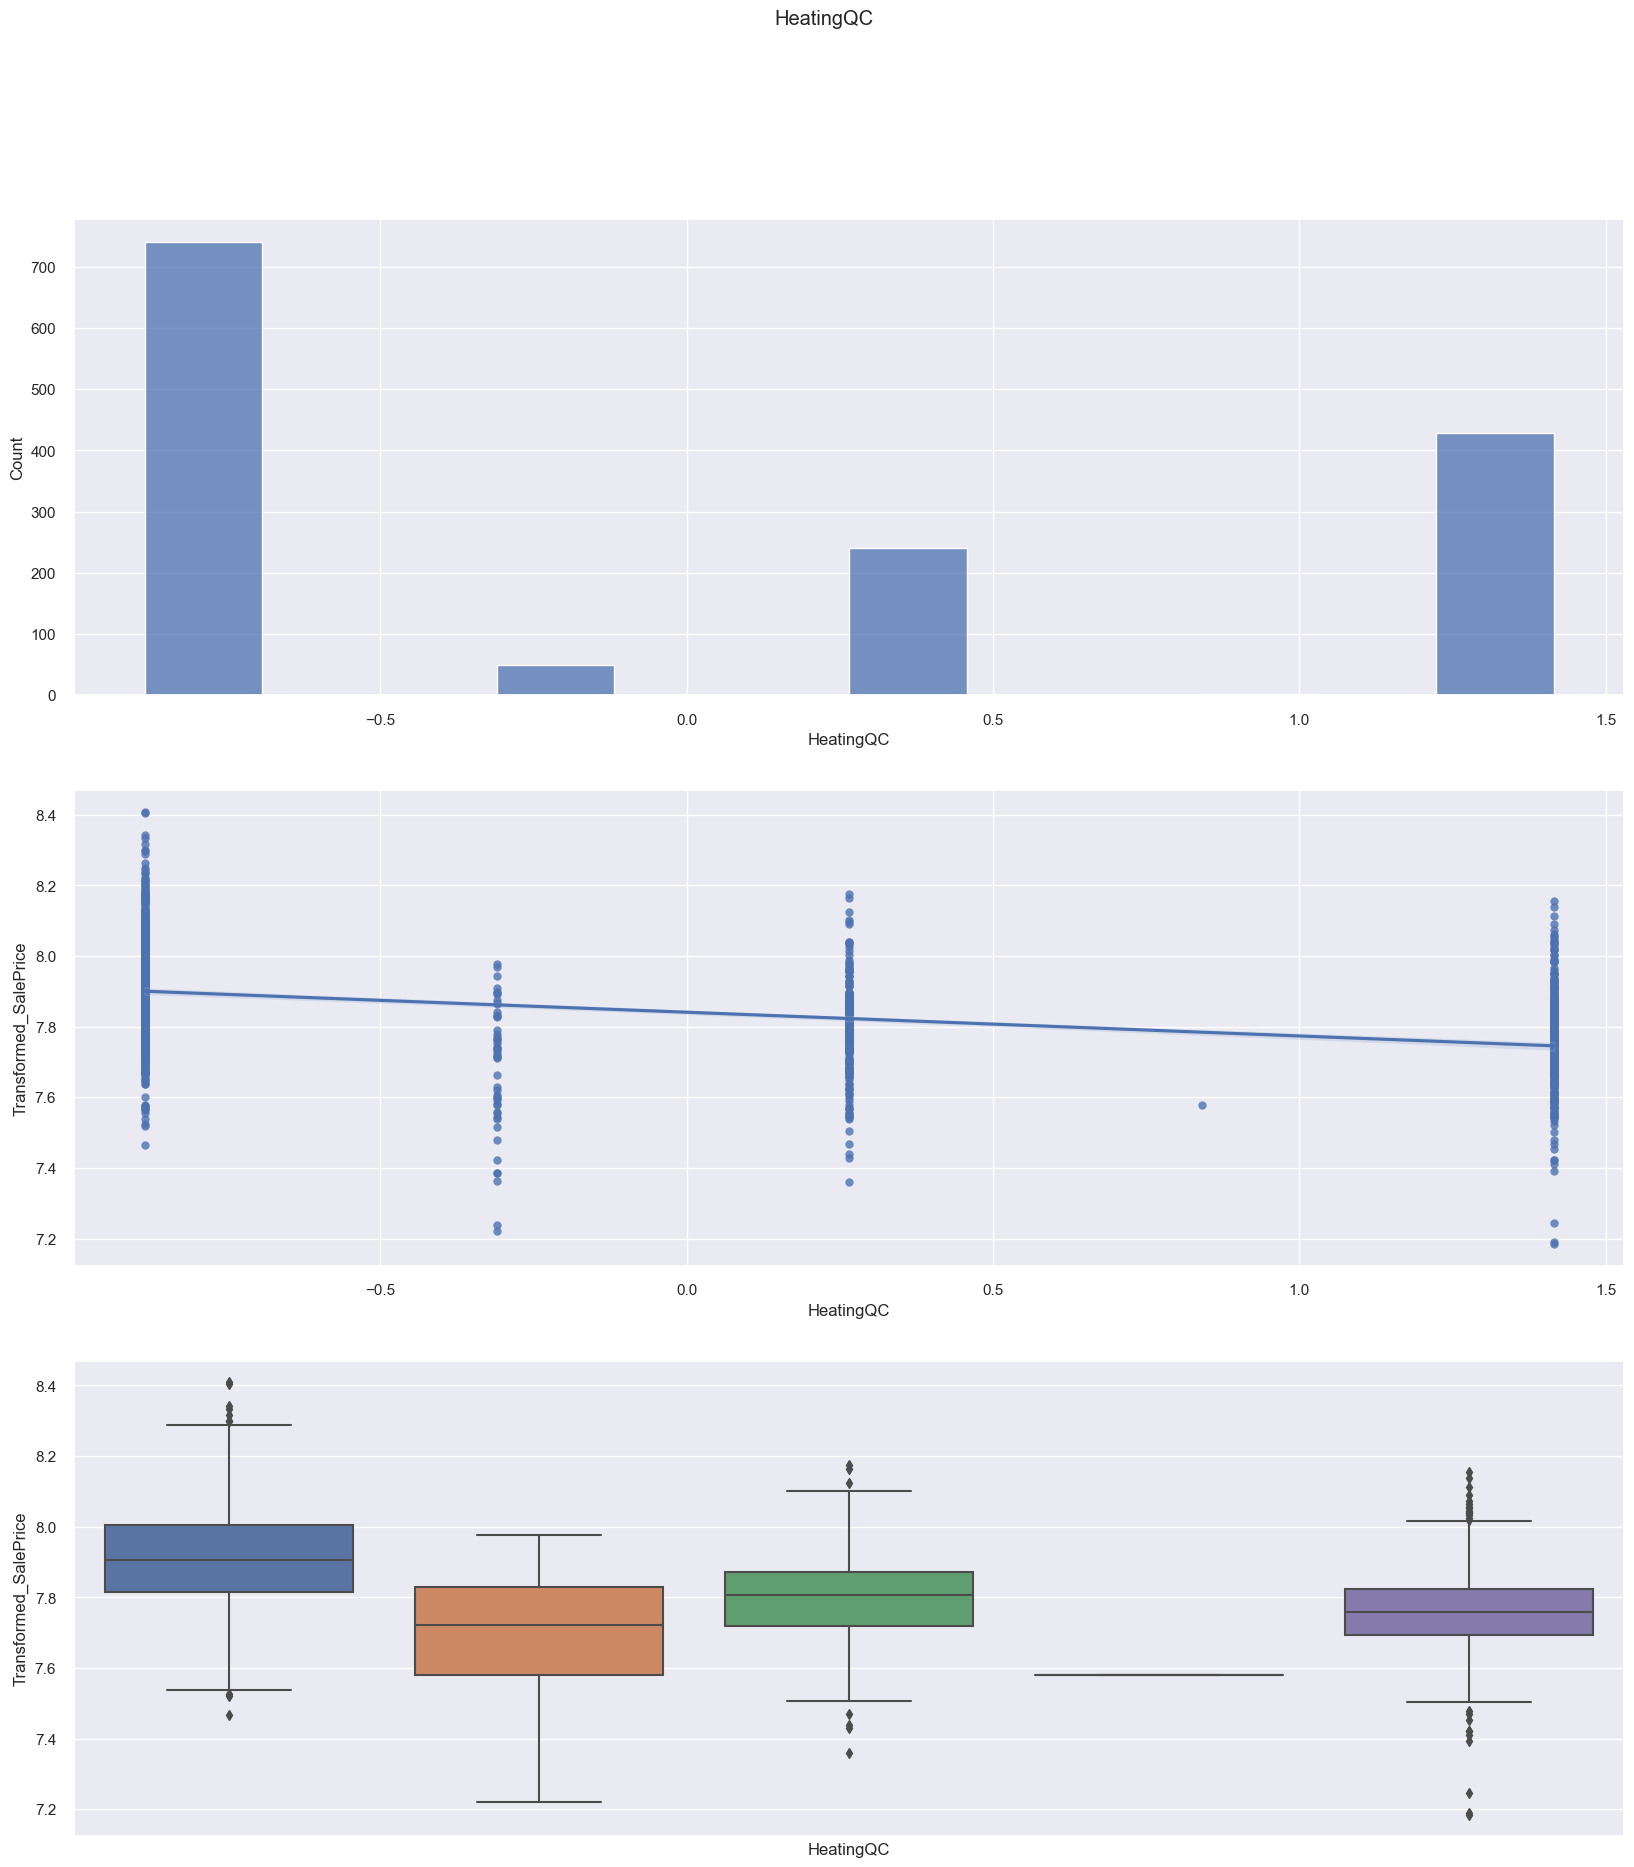

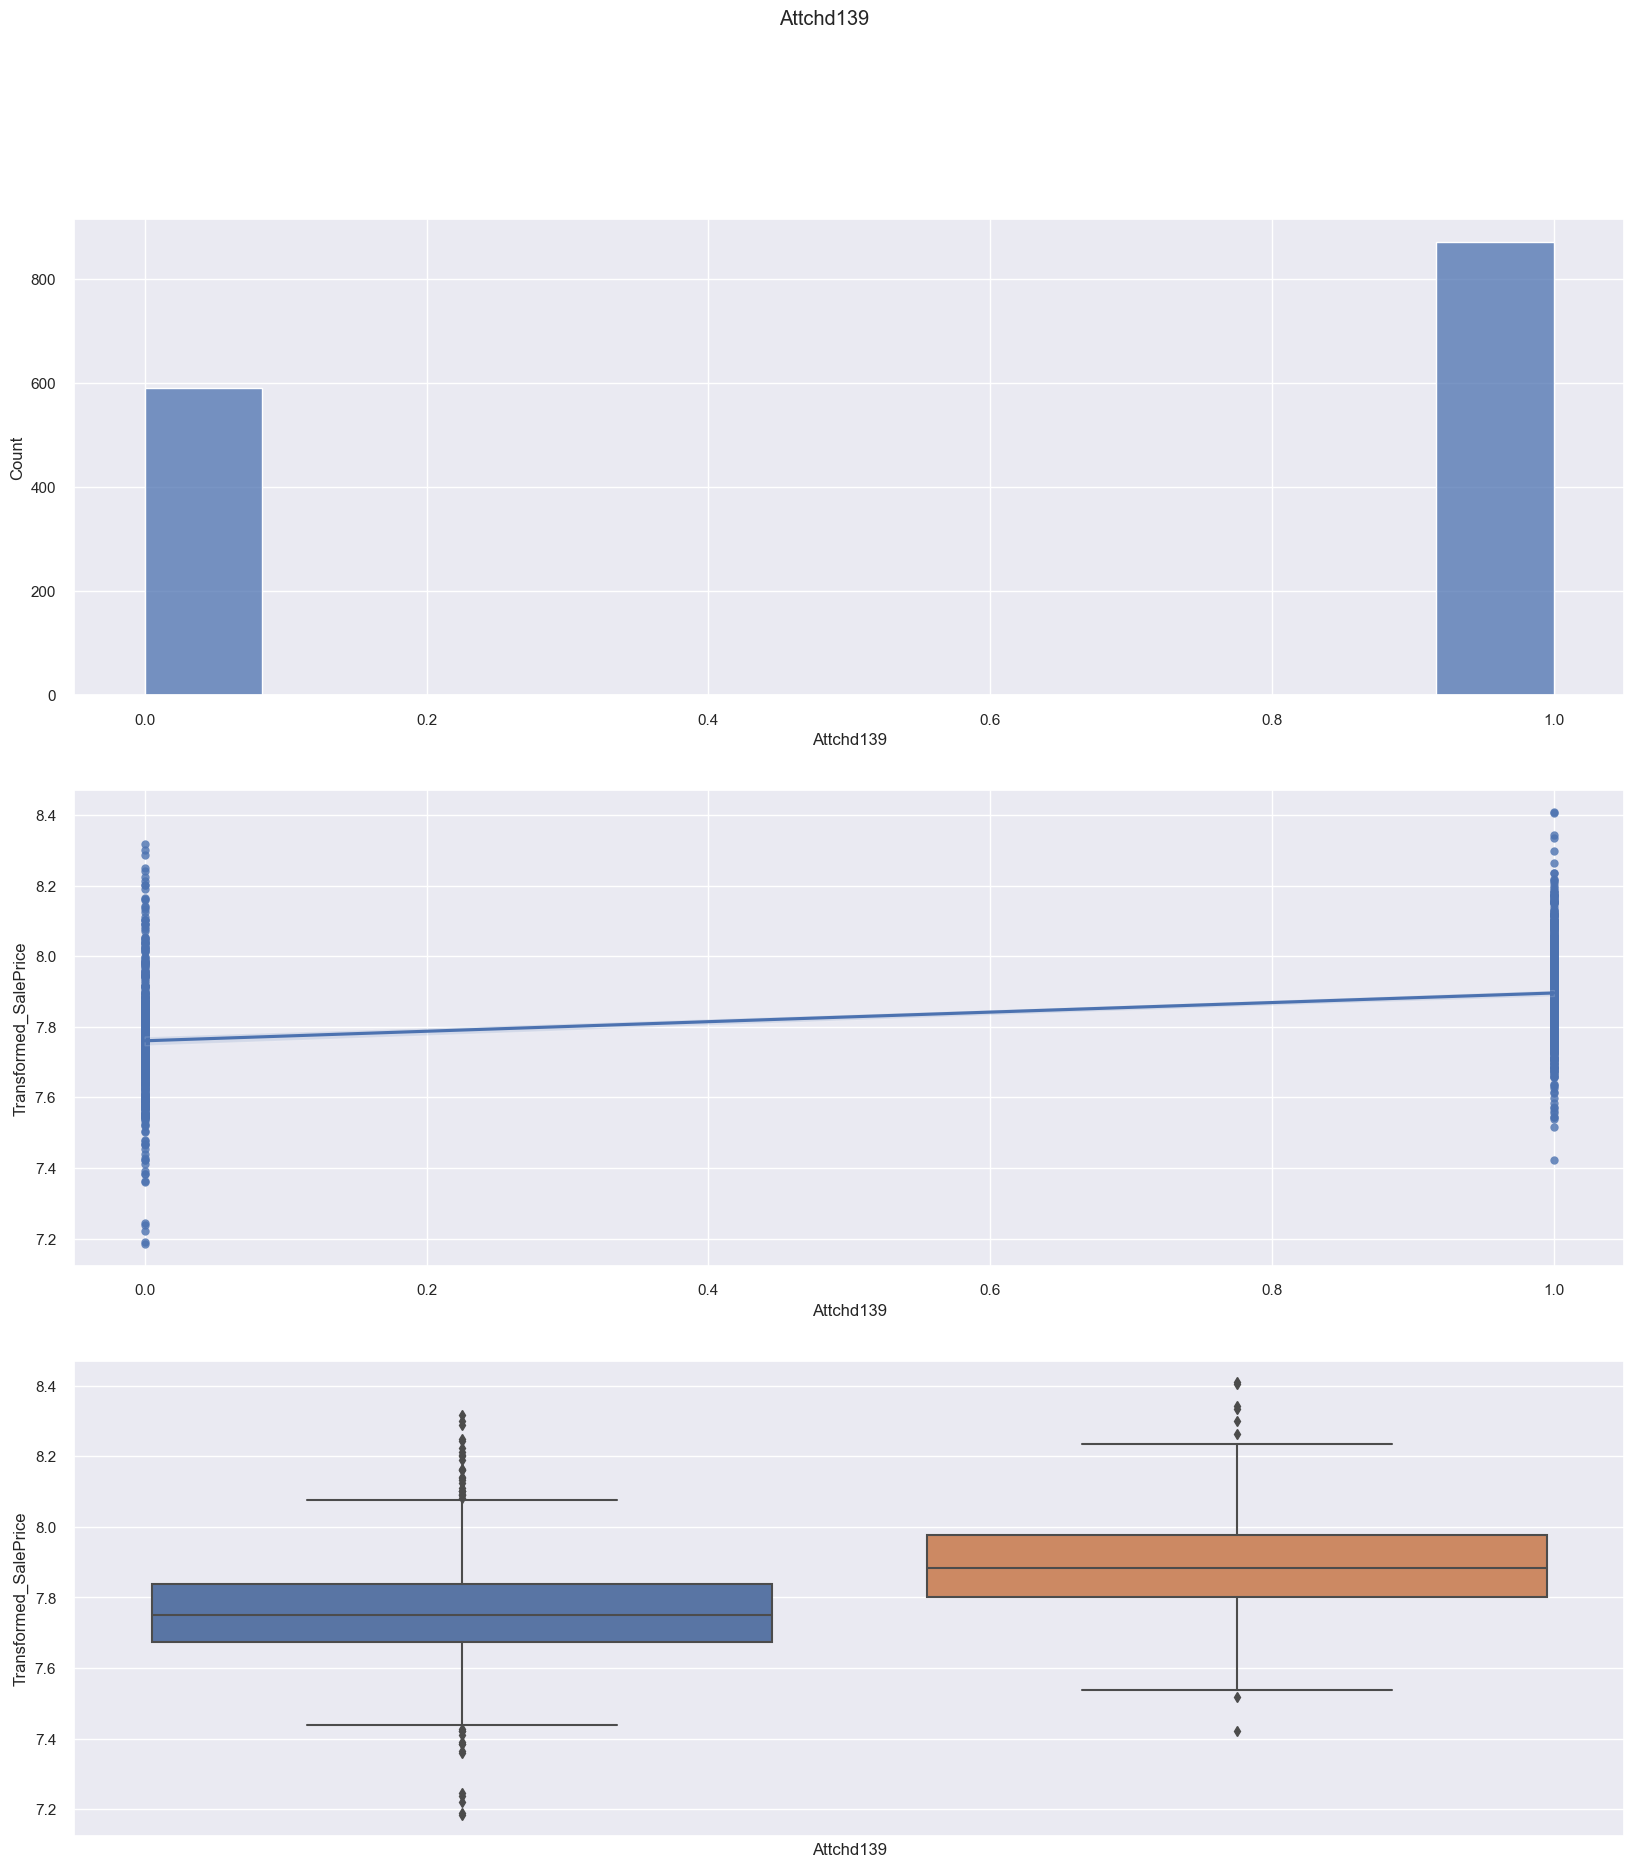

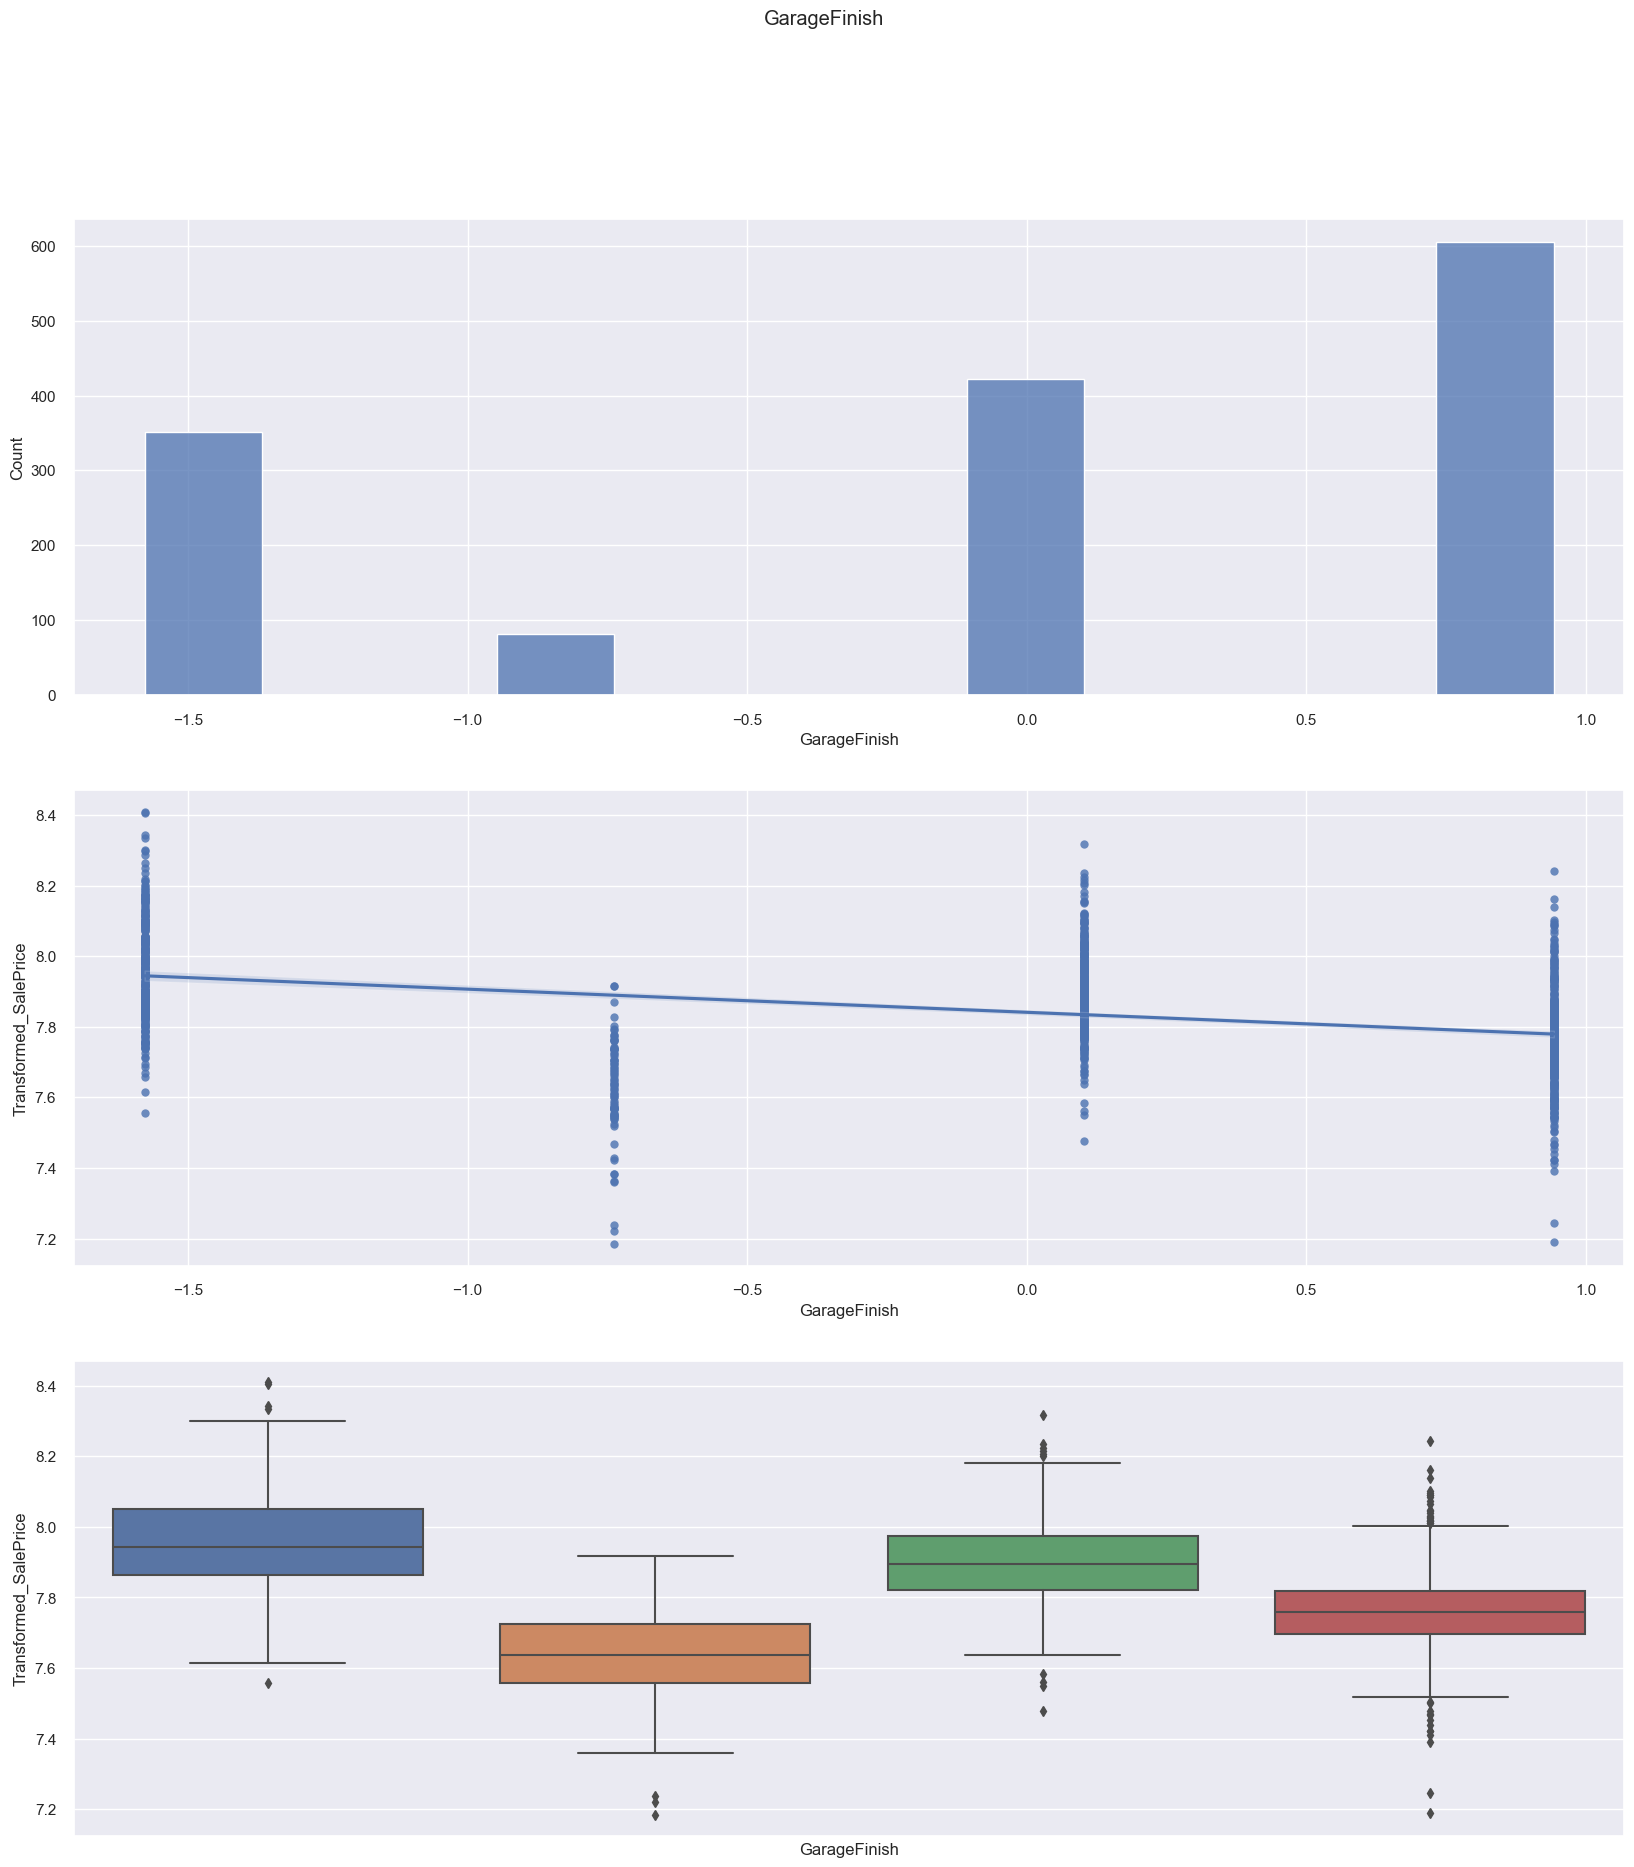

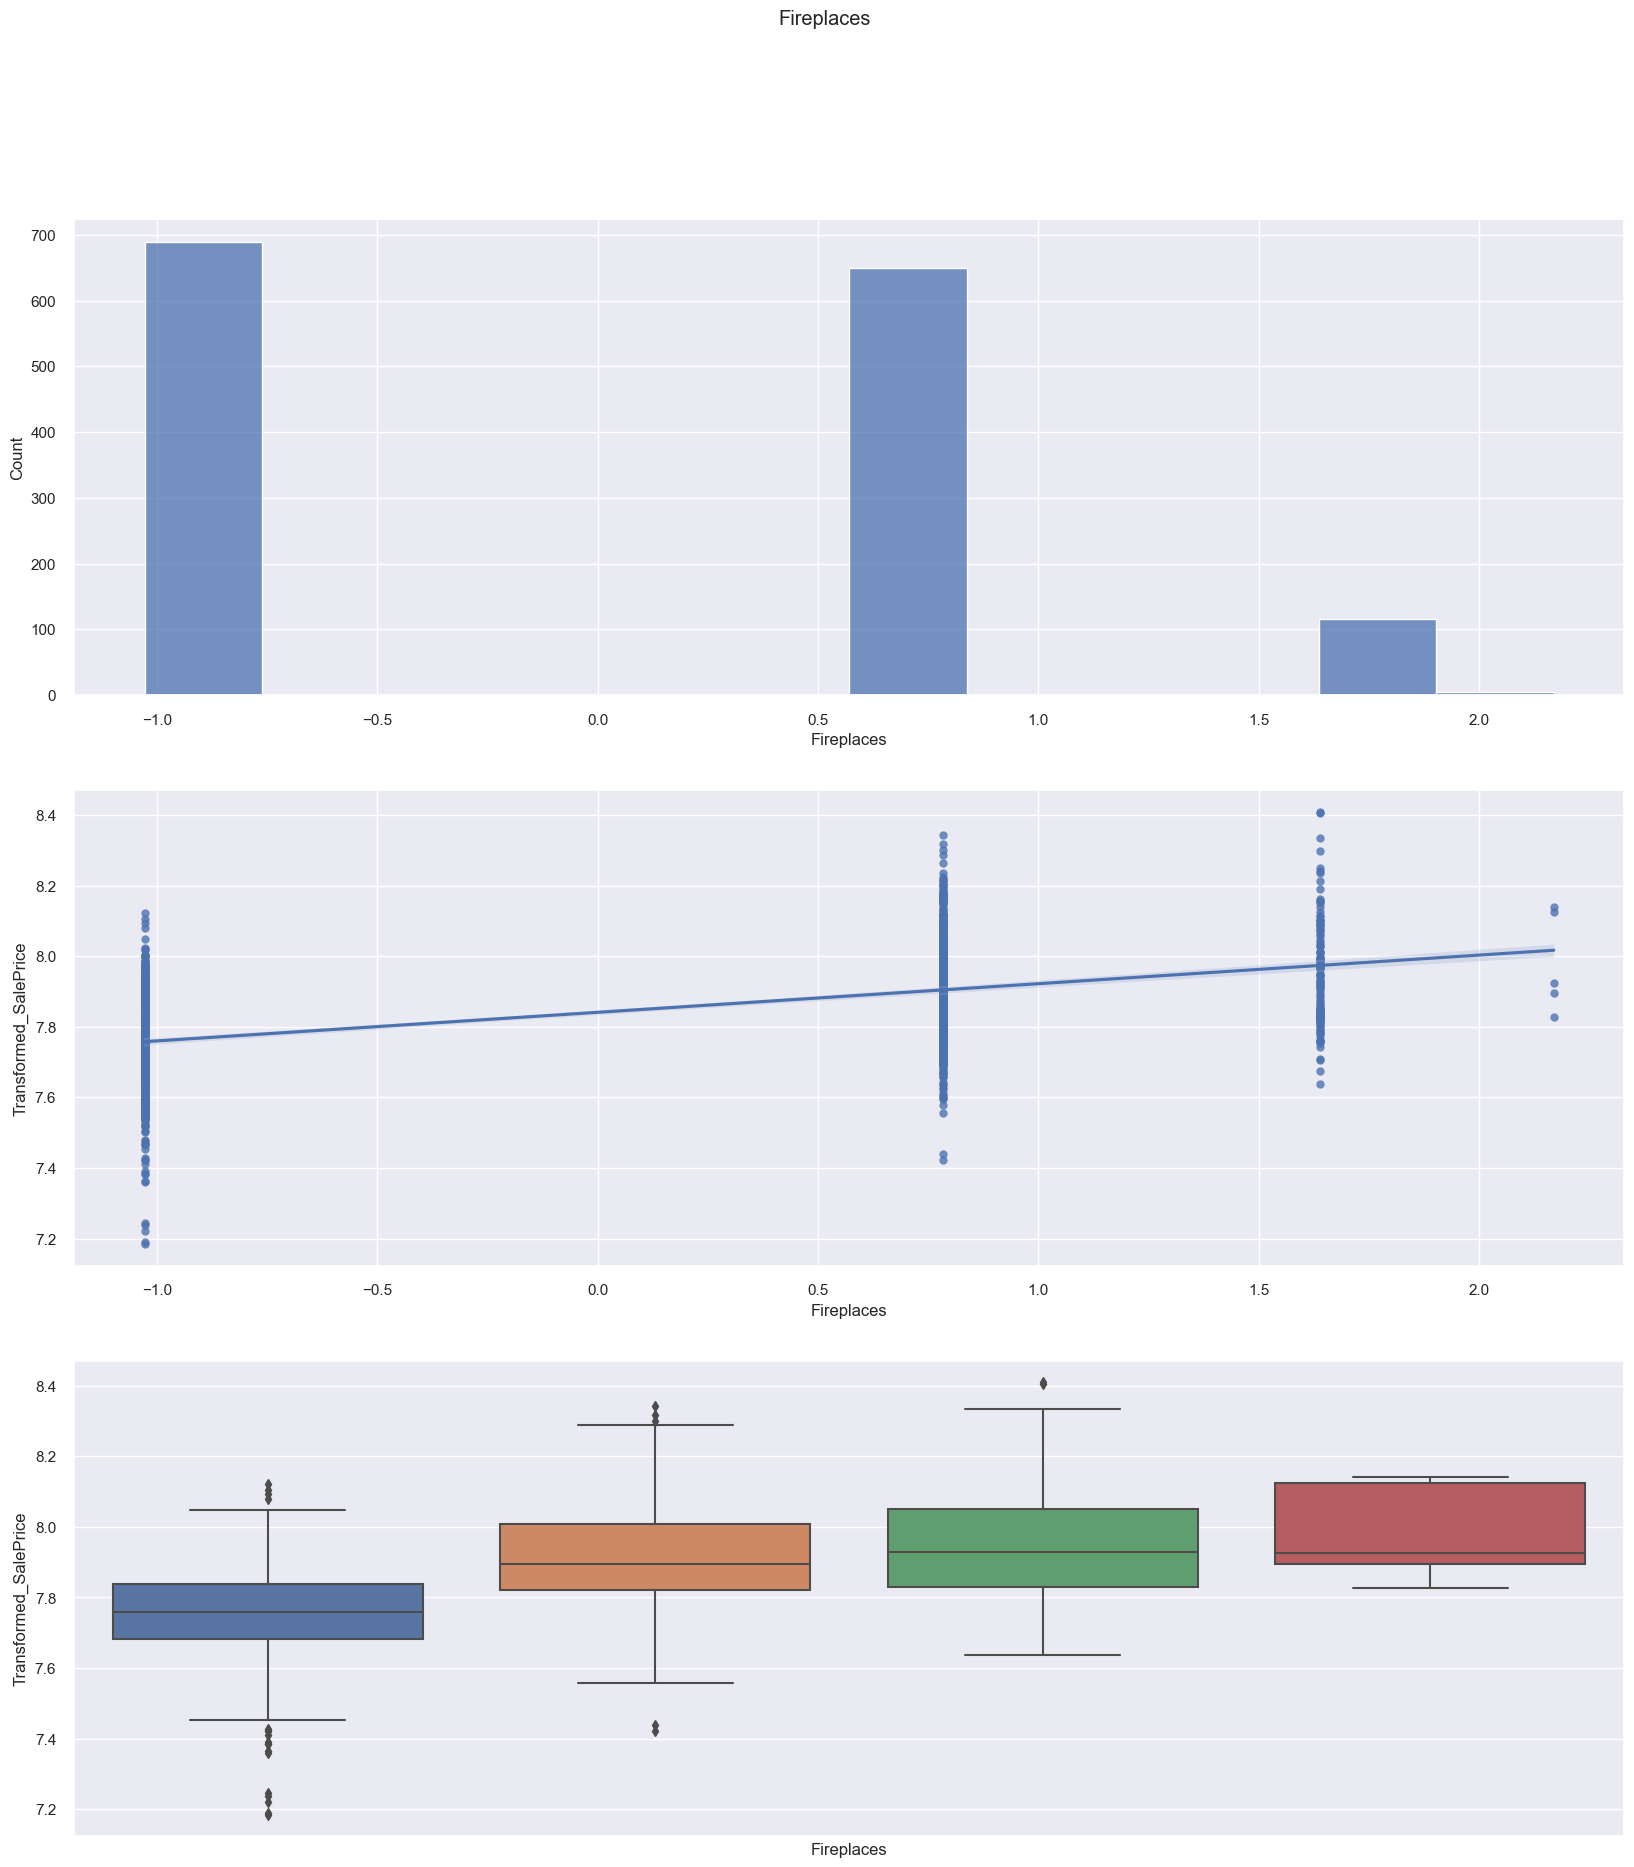

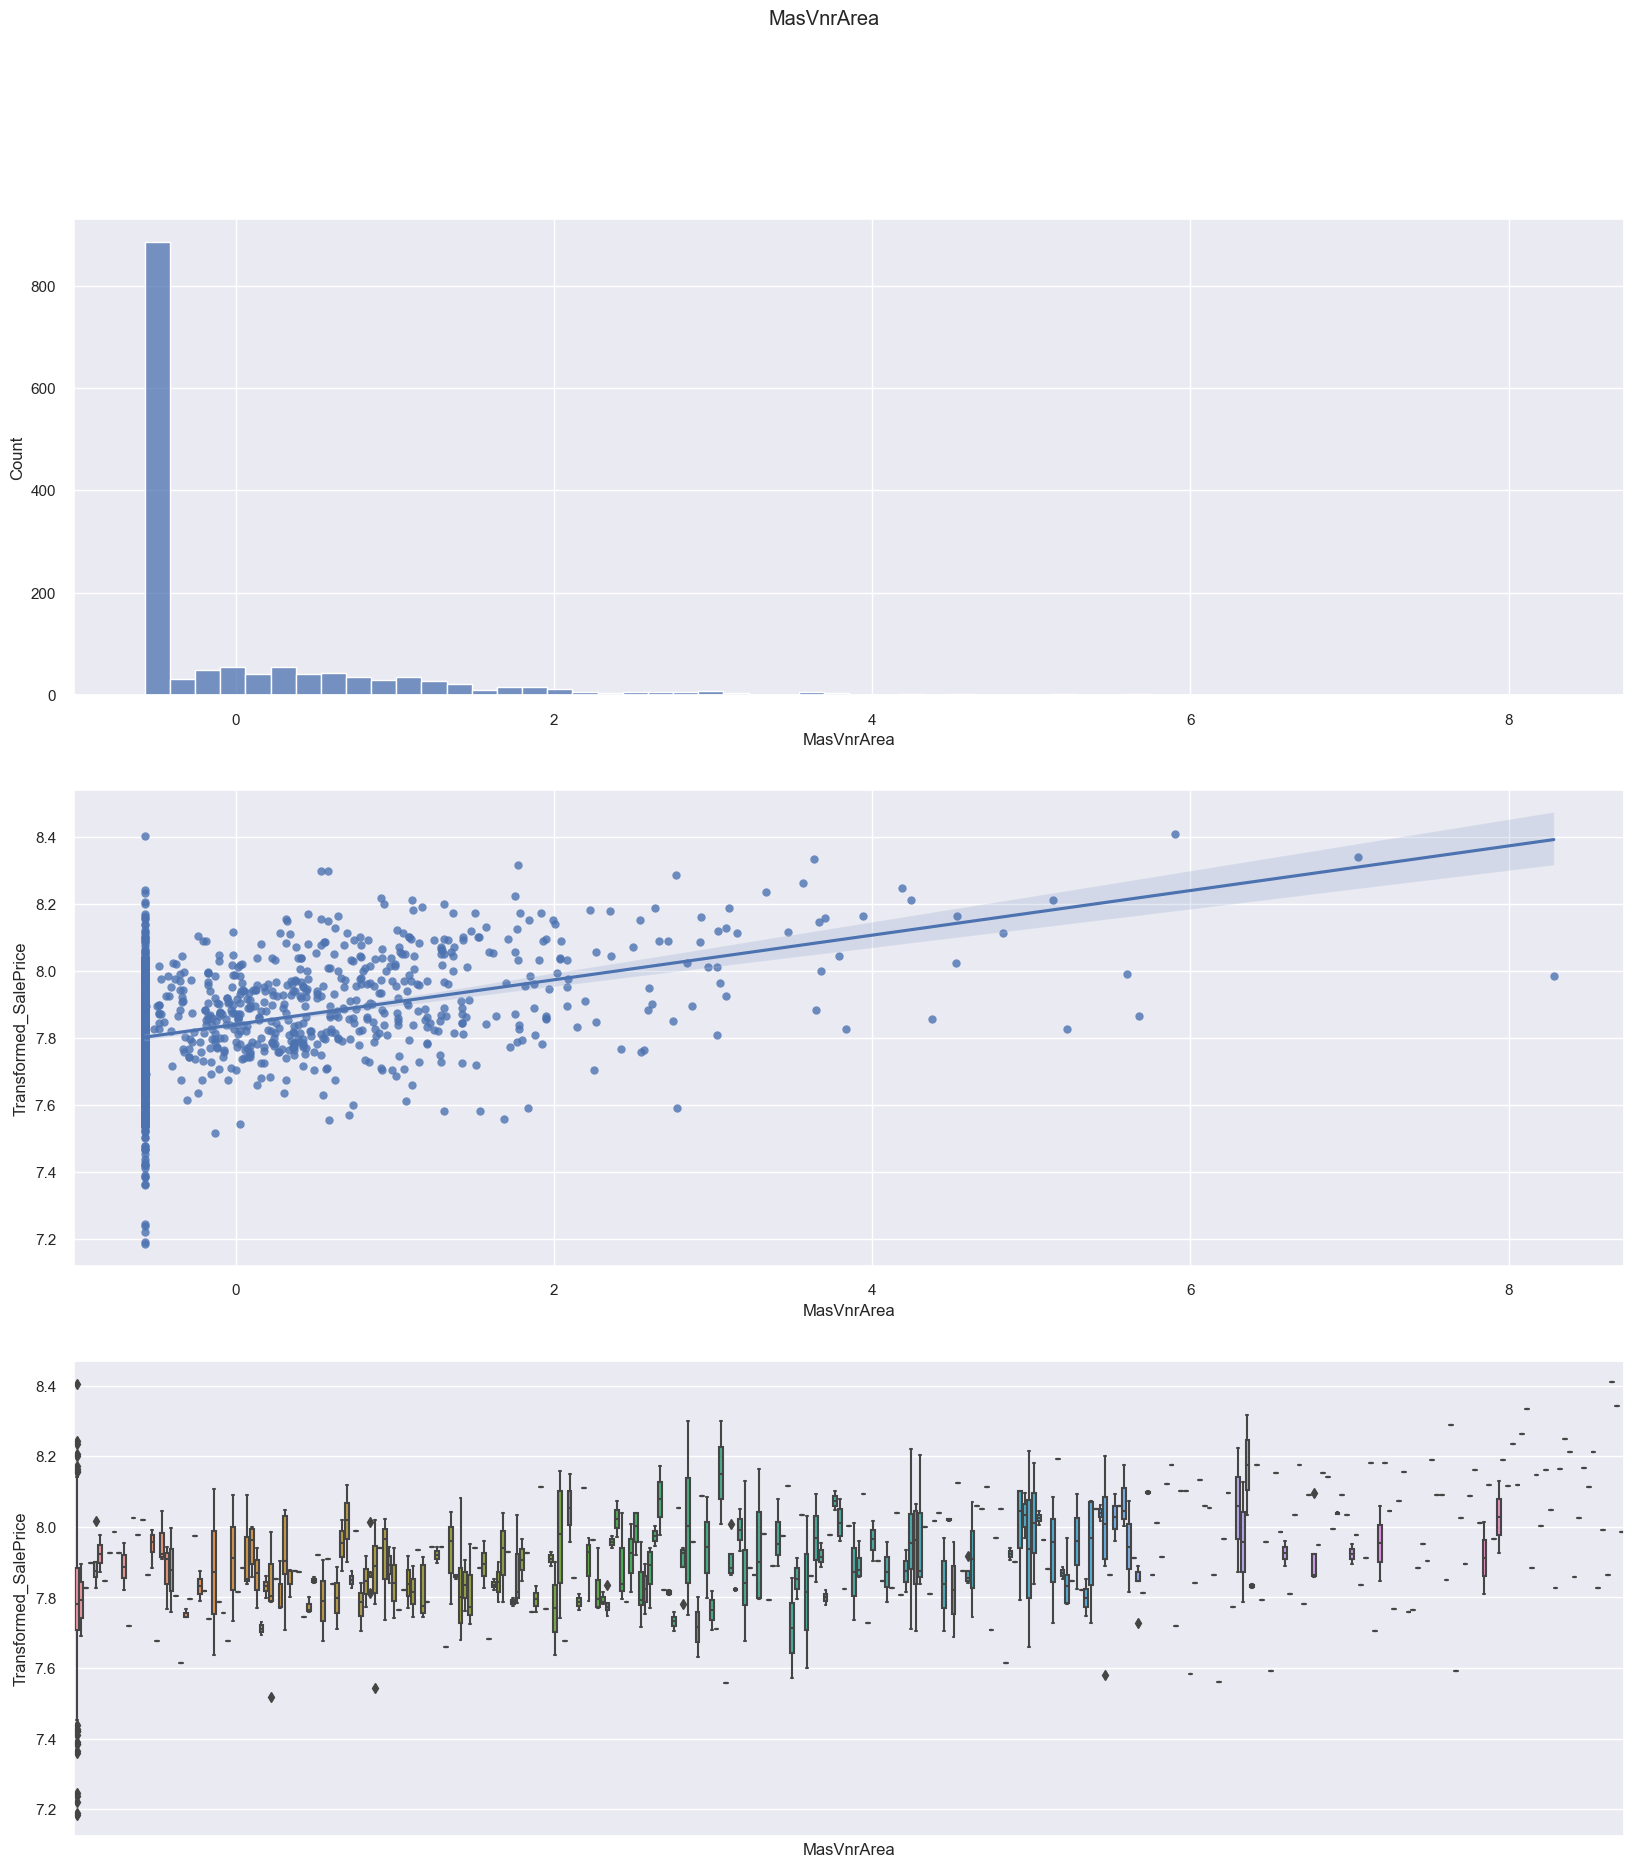

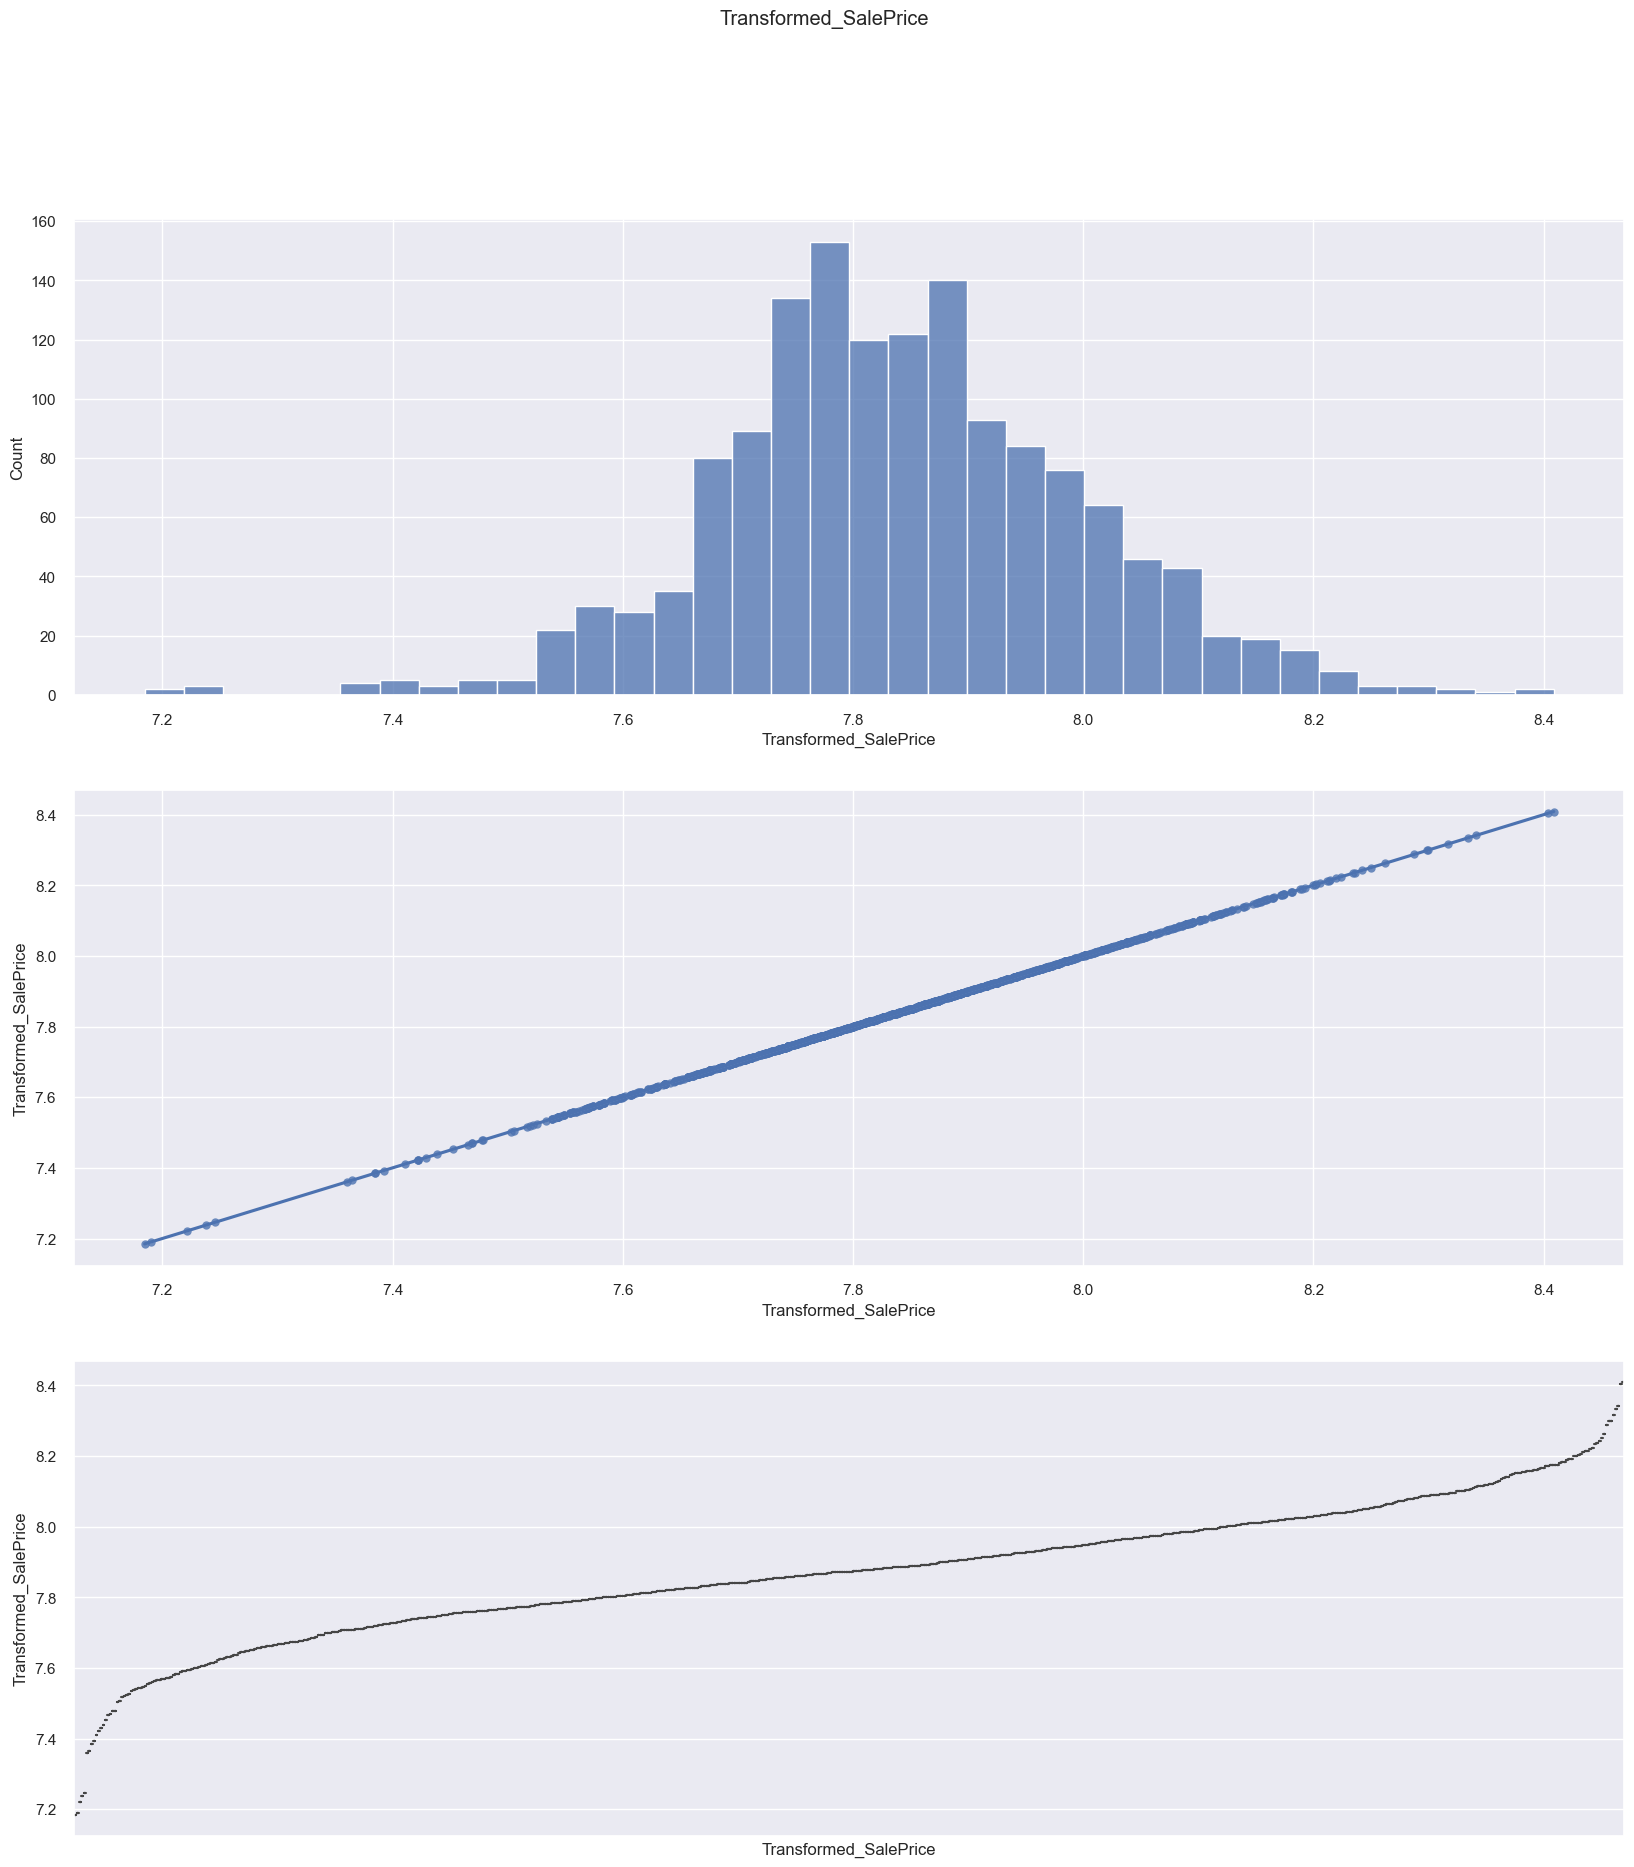

In [44]:
for i in df10.columns:
    simple_graph(df10, y='Transformed_SalePrice', x=i)

In [45]:
outlier_detector = LocalOutlierFactor(n_neighbors=20)
outlier_detector.fit_predict(df10)
df10['NOF'] = outlier_detector.negative_outlier_factor_

In [46]:
print('Original Shape', df10.shape)
df10 = df10[df10['NOF'] >= -1.4]
df10.drop(['NOF'], axis=1, inplace=True)
print('New Shape', df10.shape)

Original Shape (1459, 22)
New Shape (1387, 21)


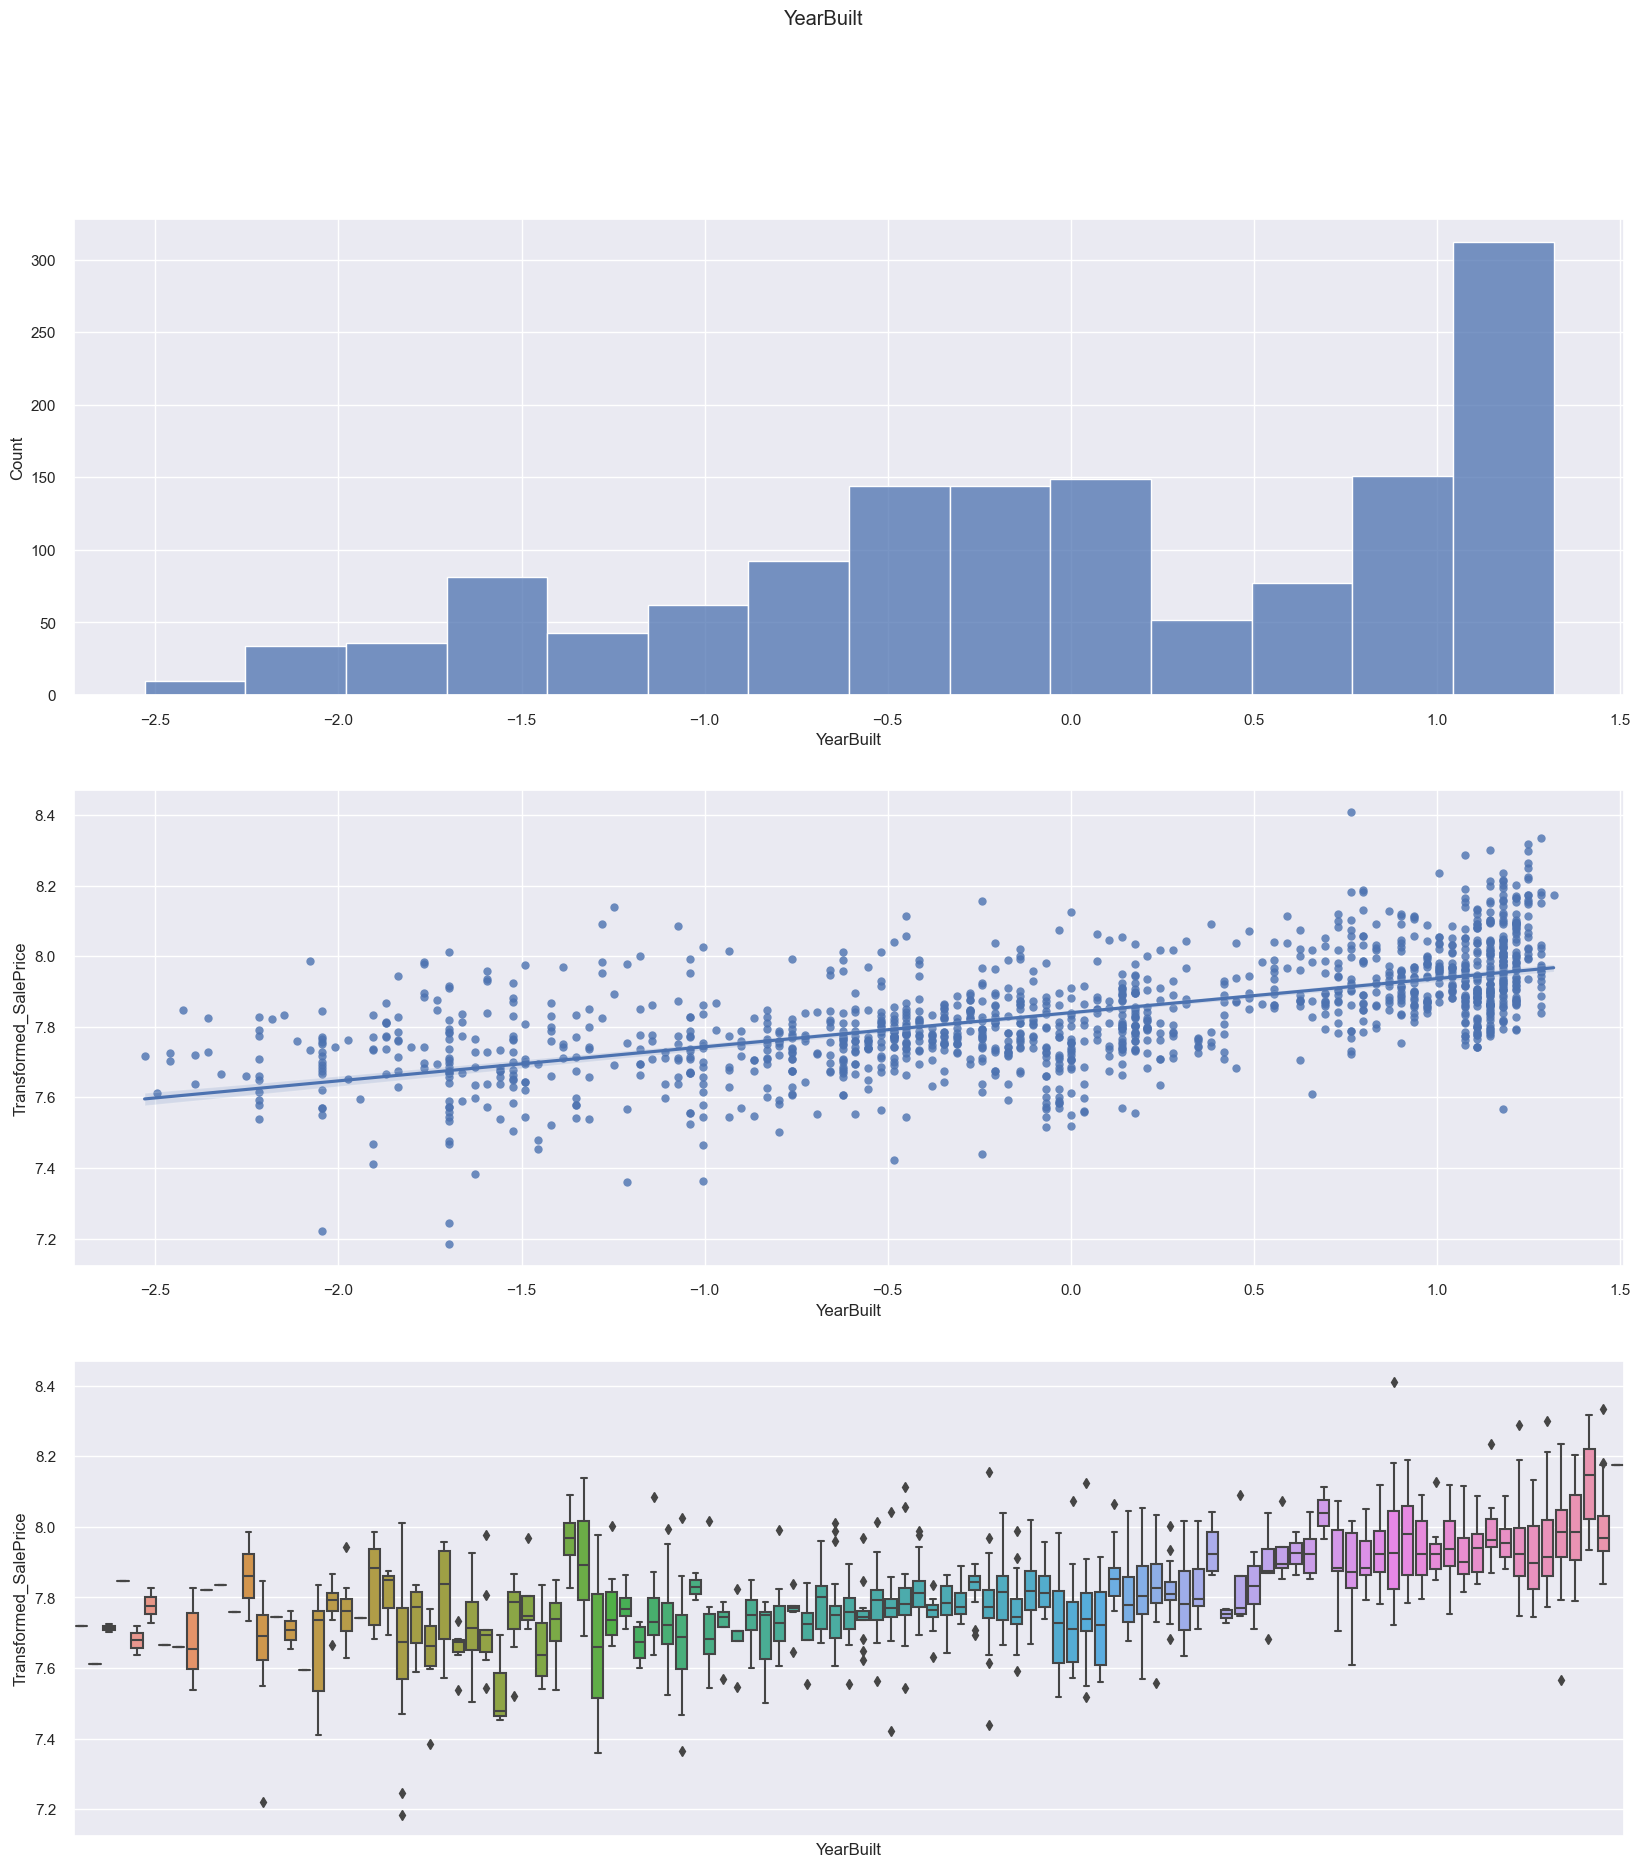

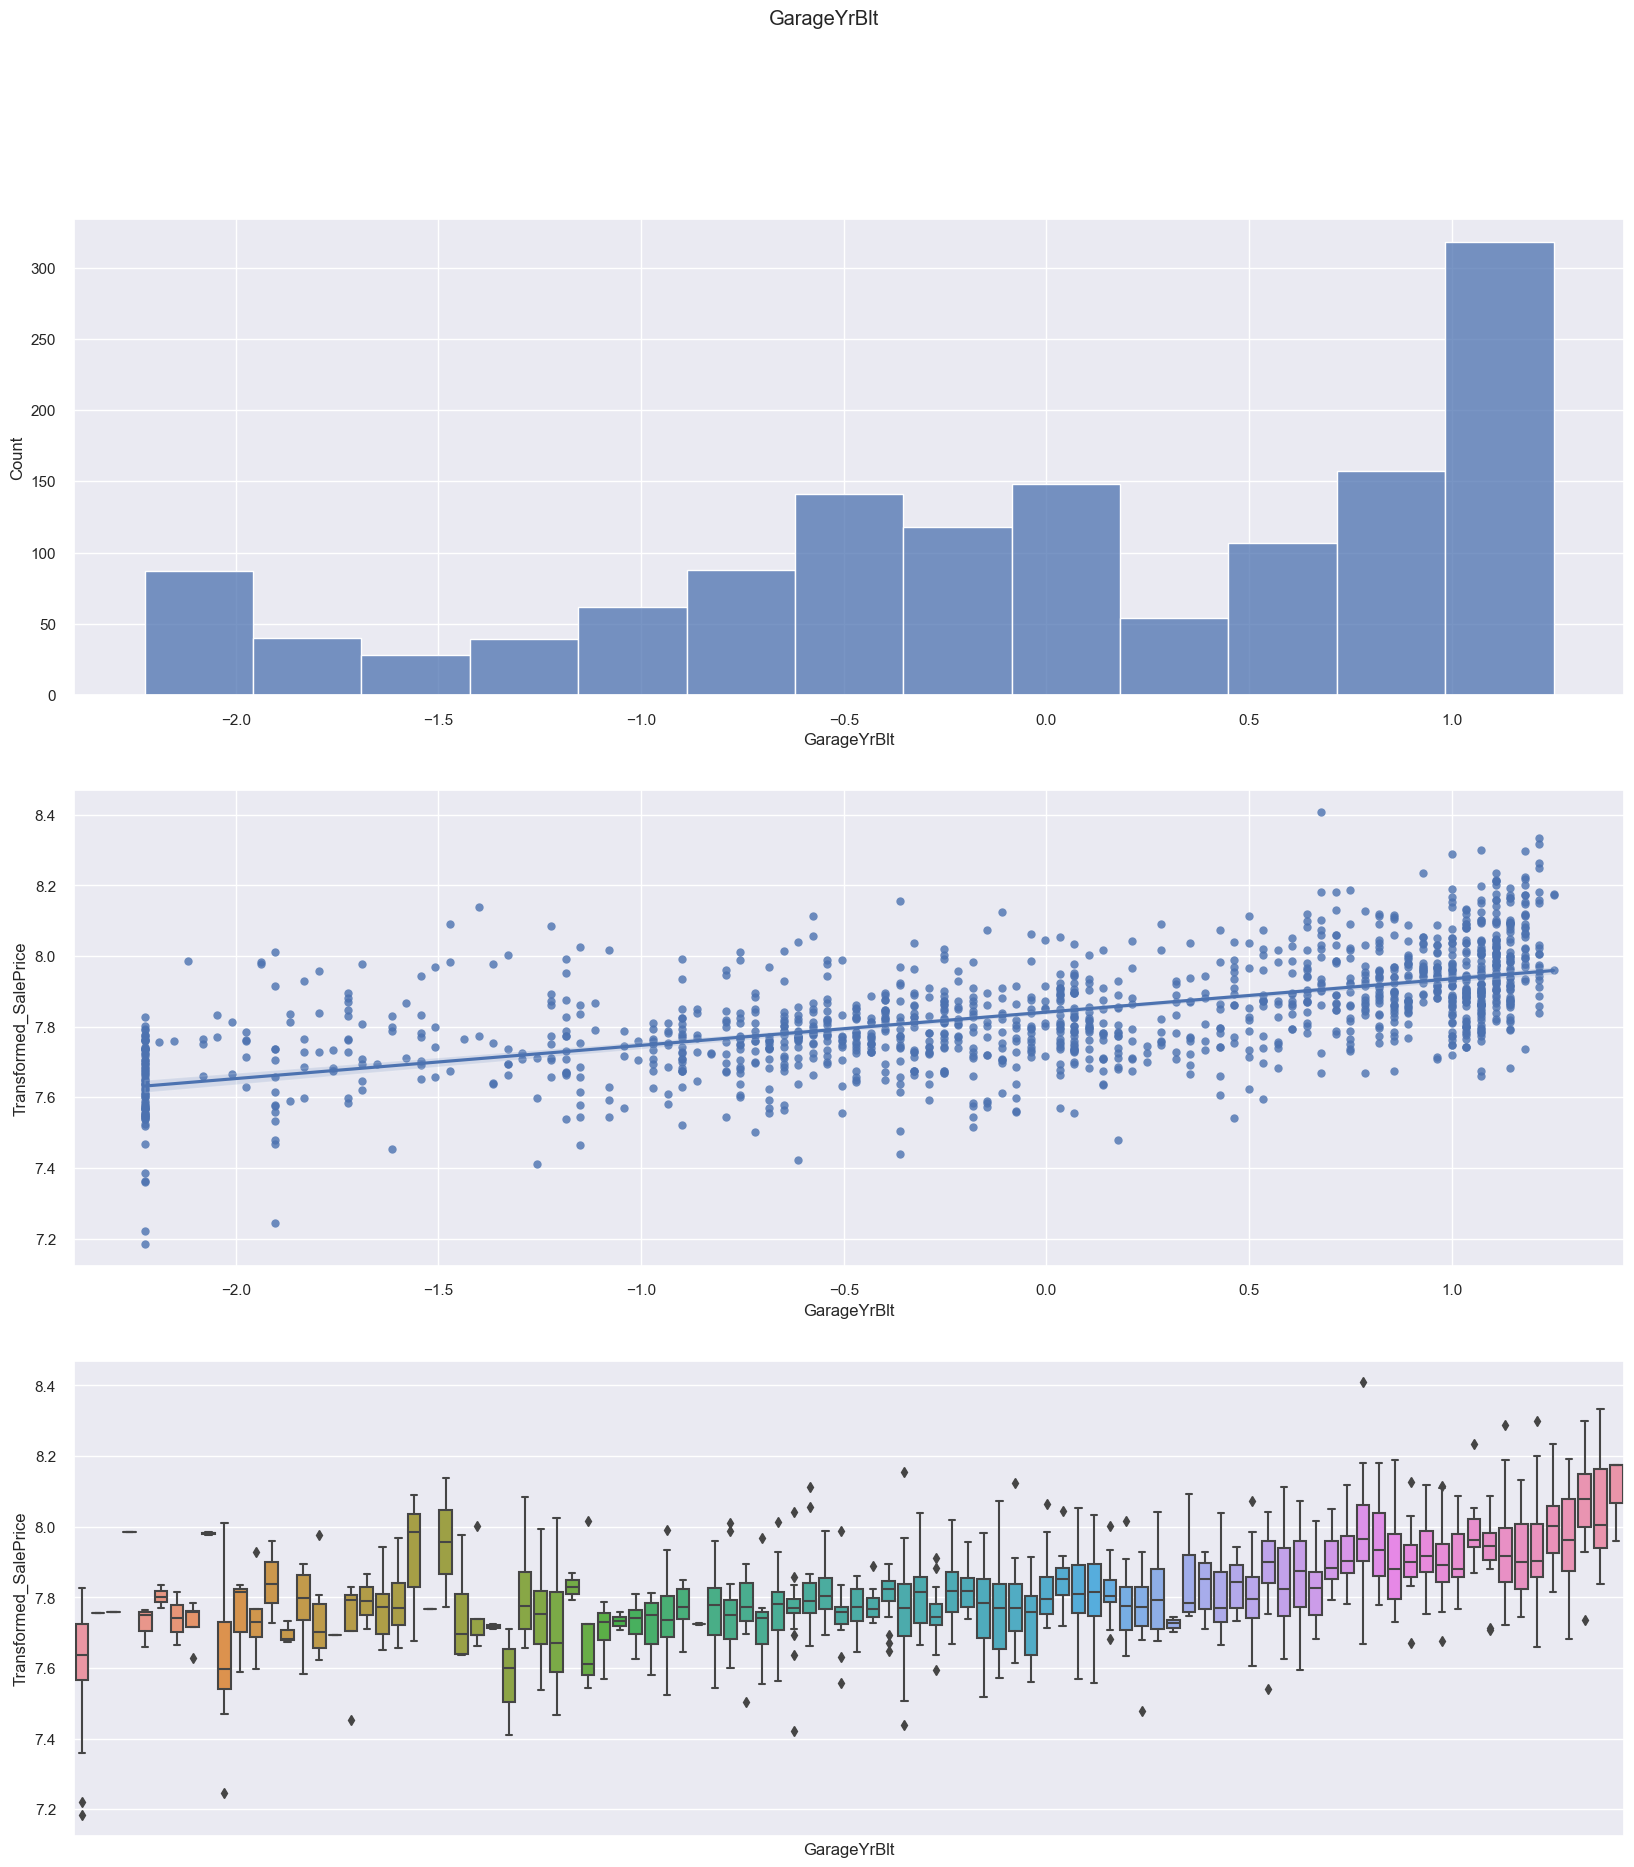

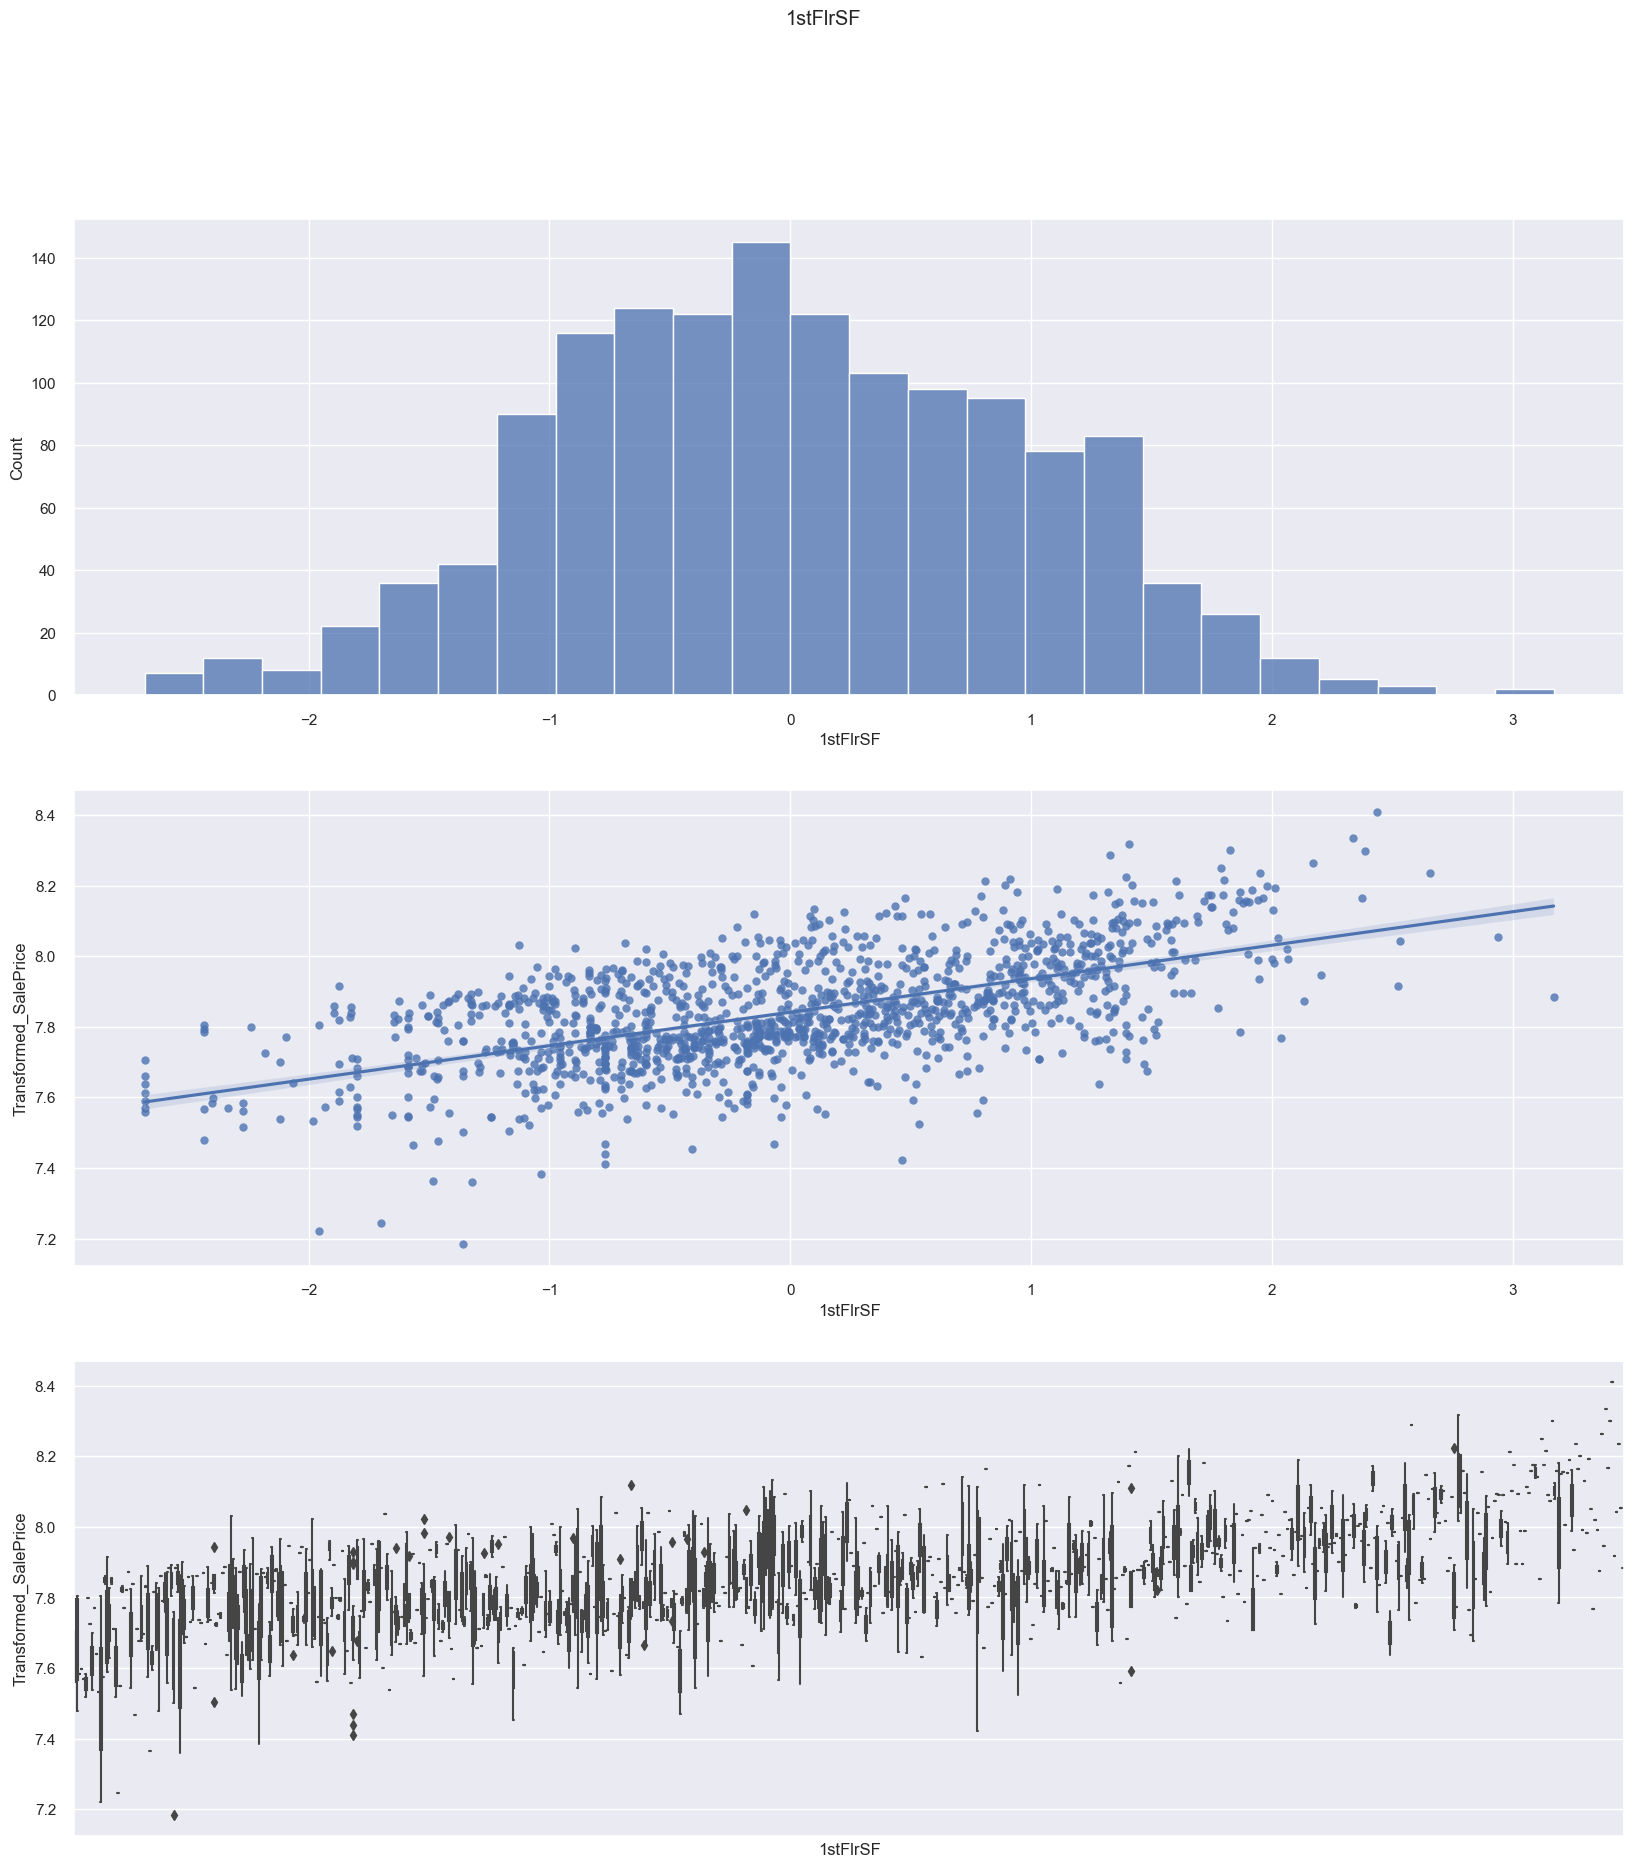

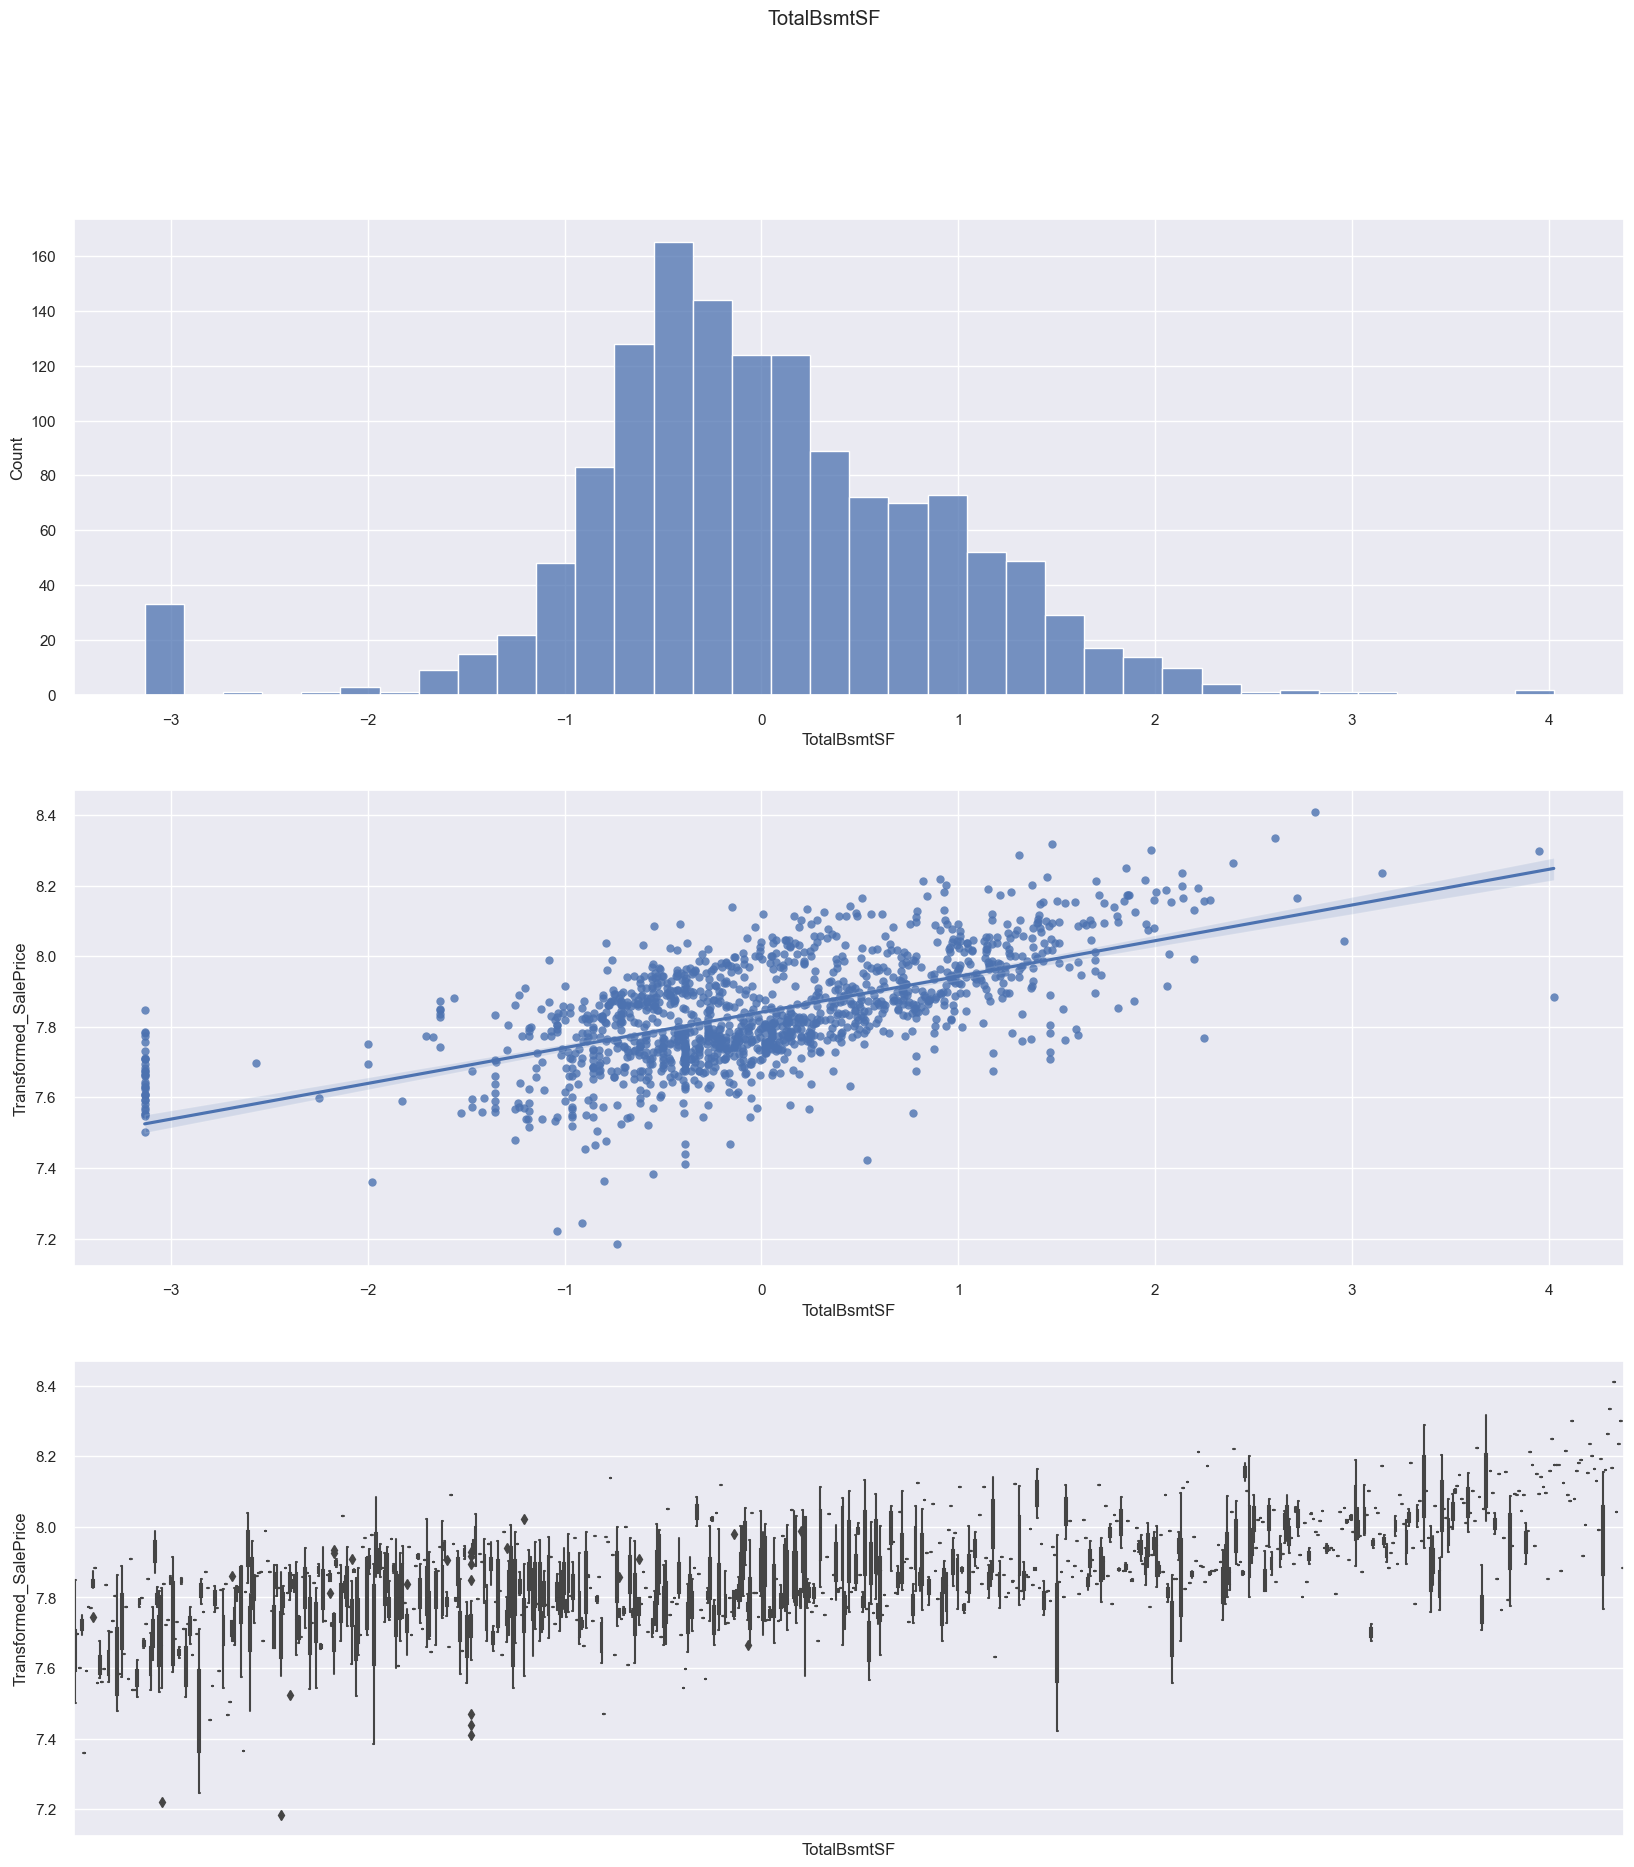

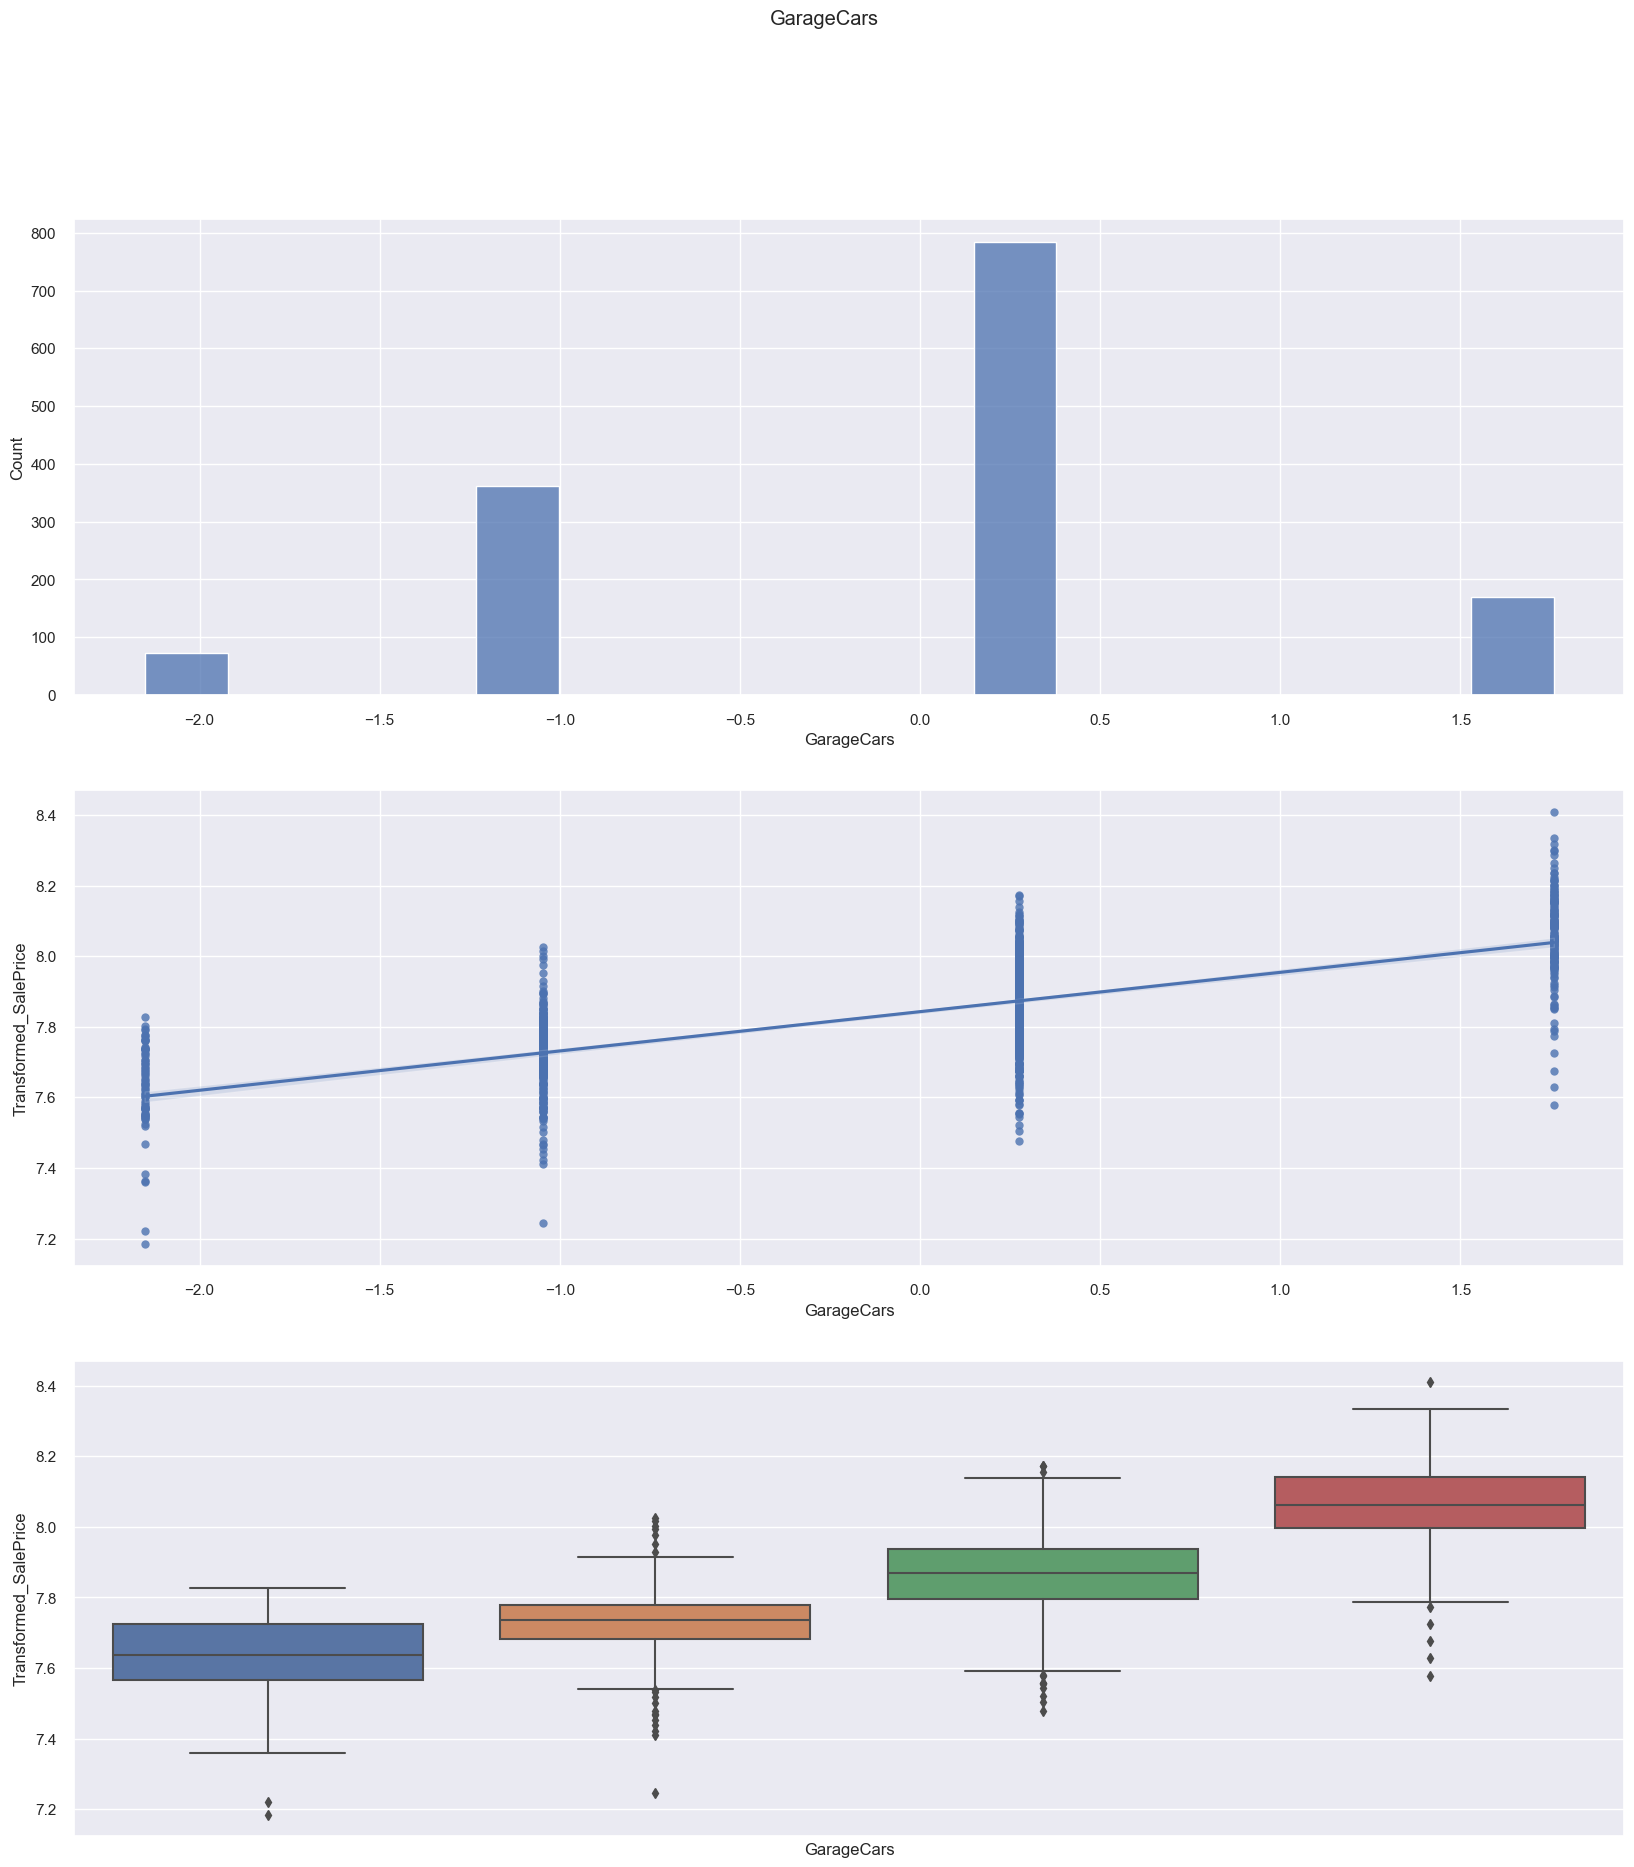

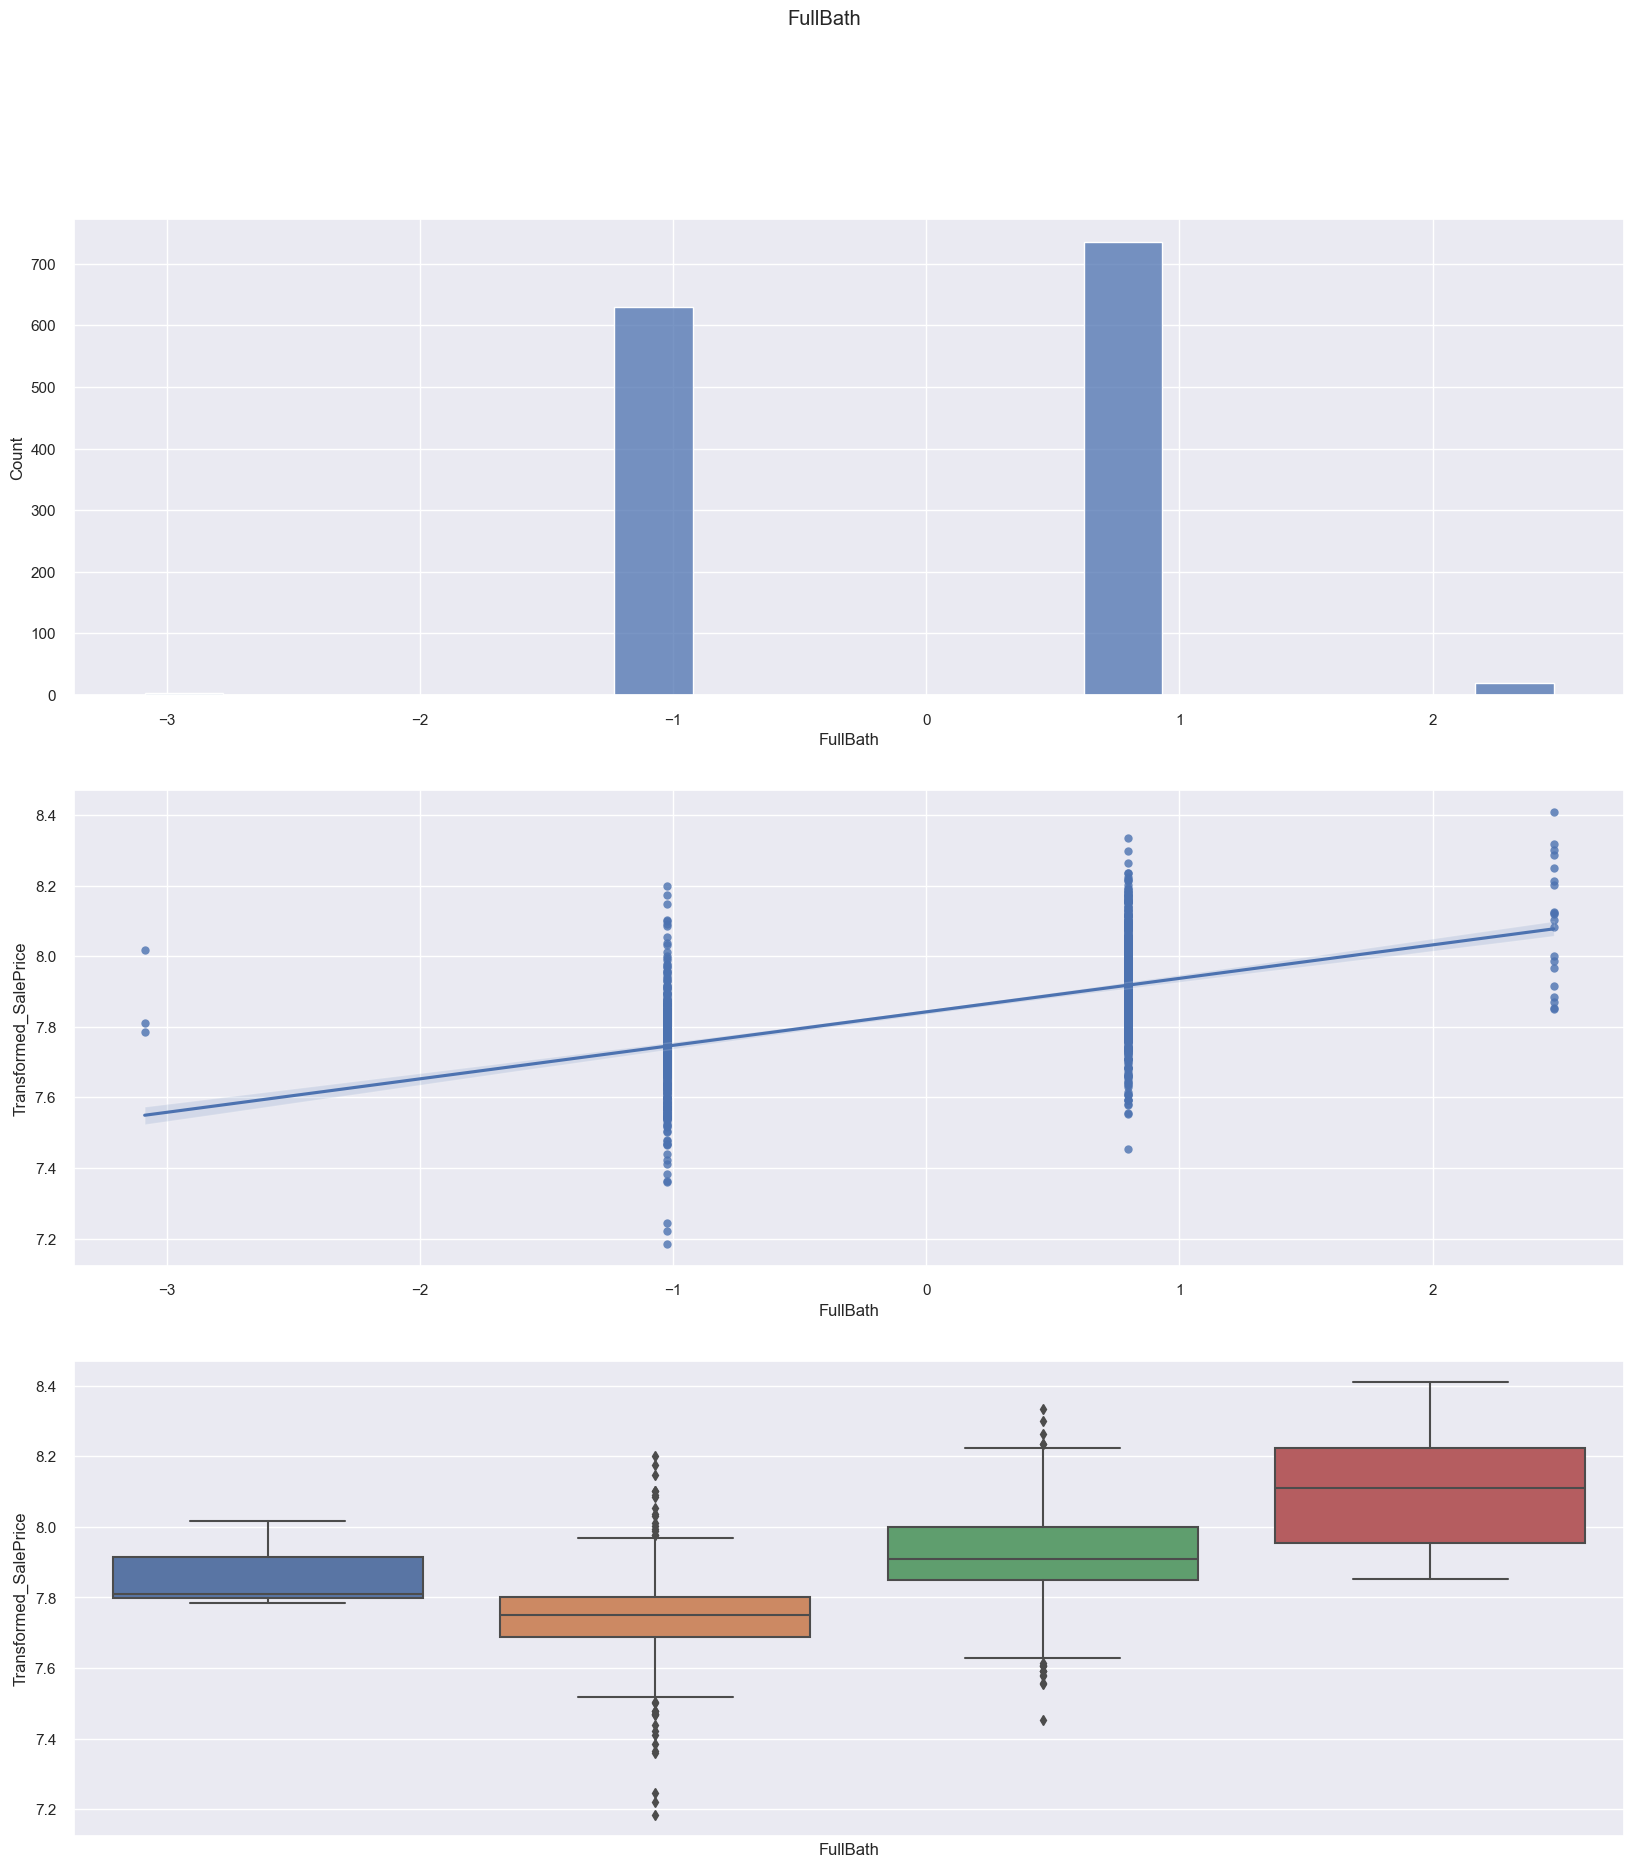

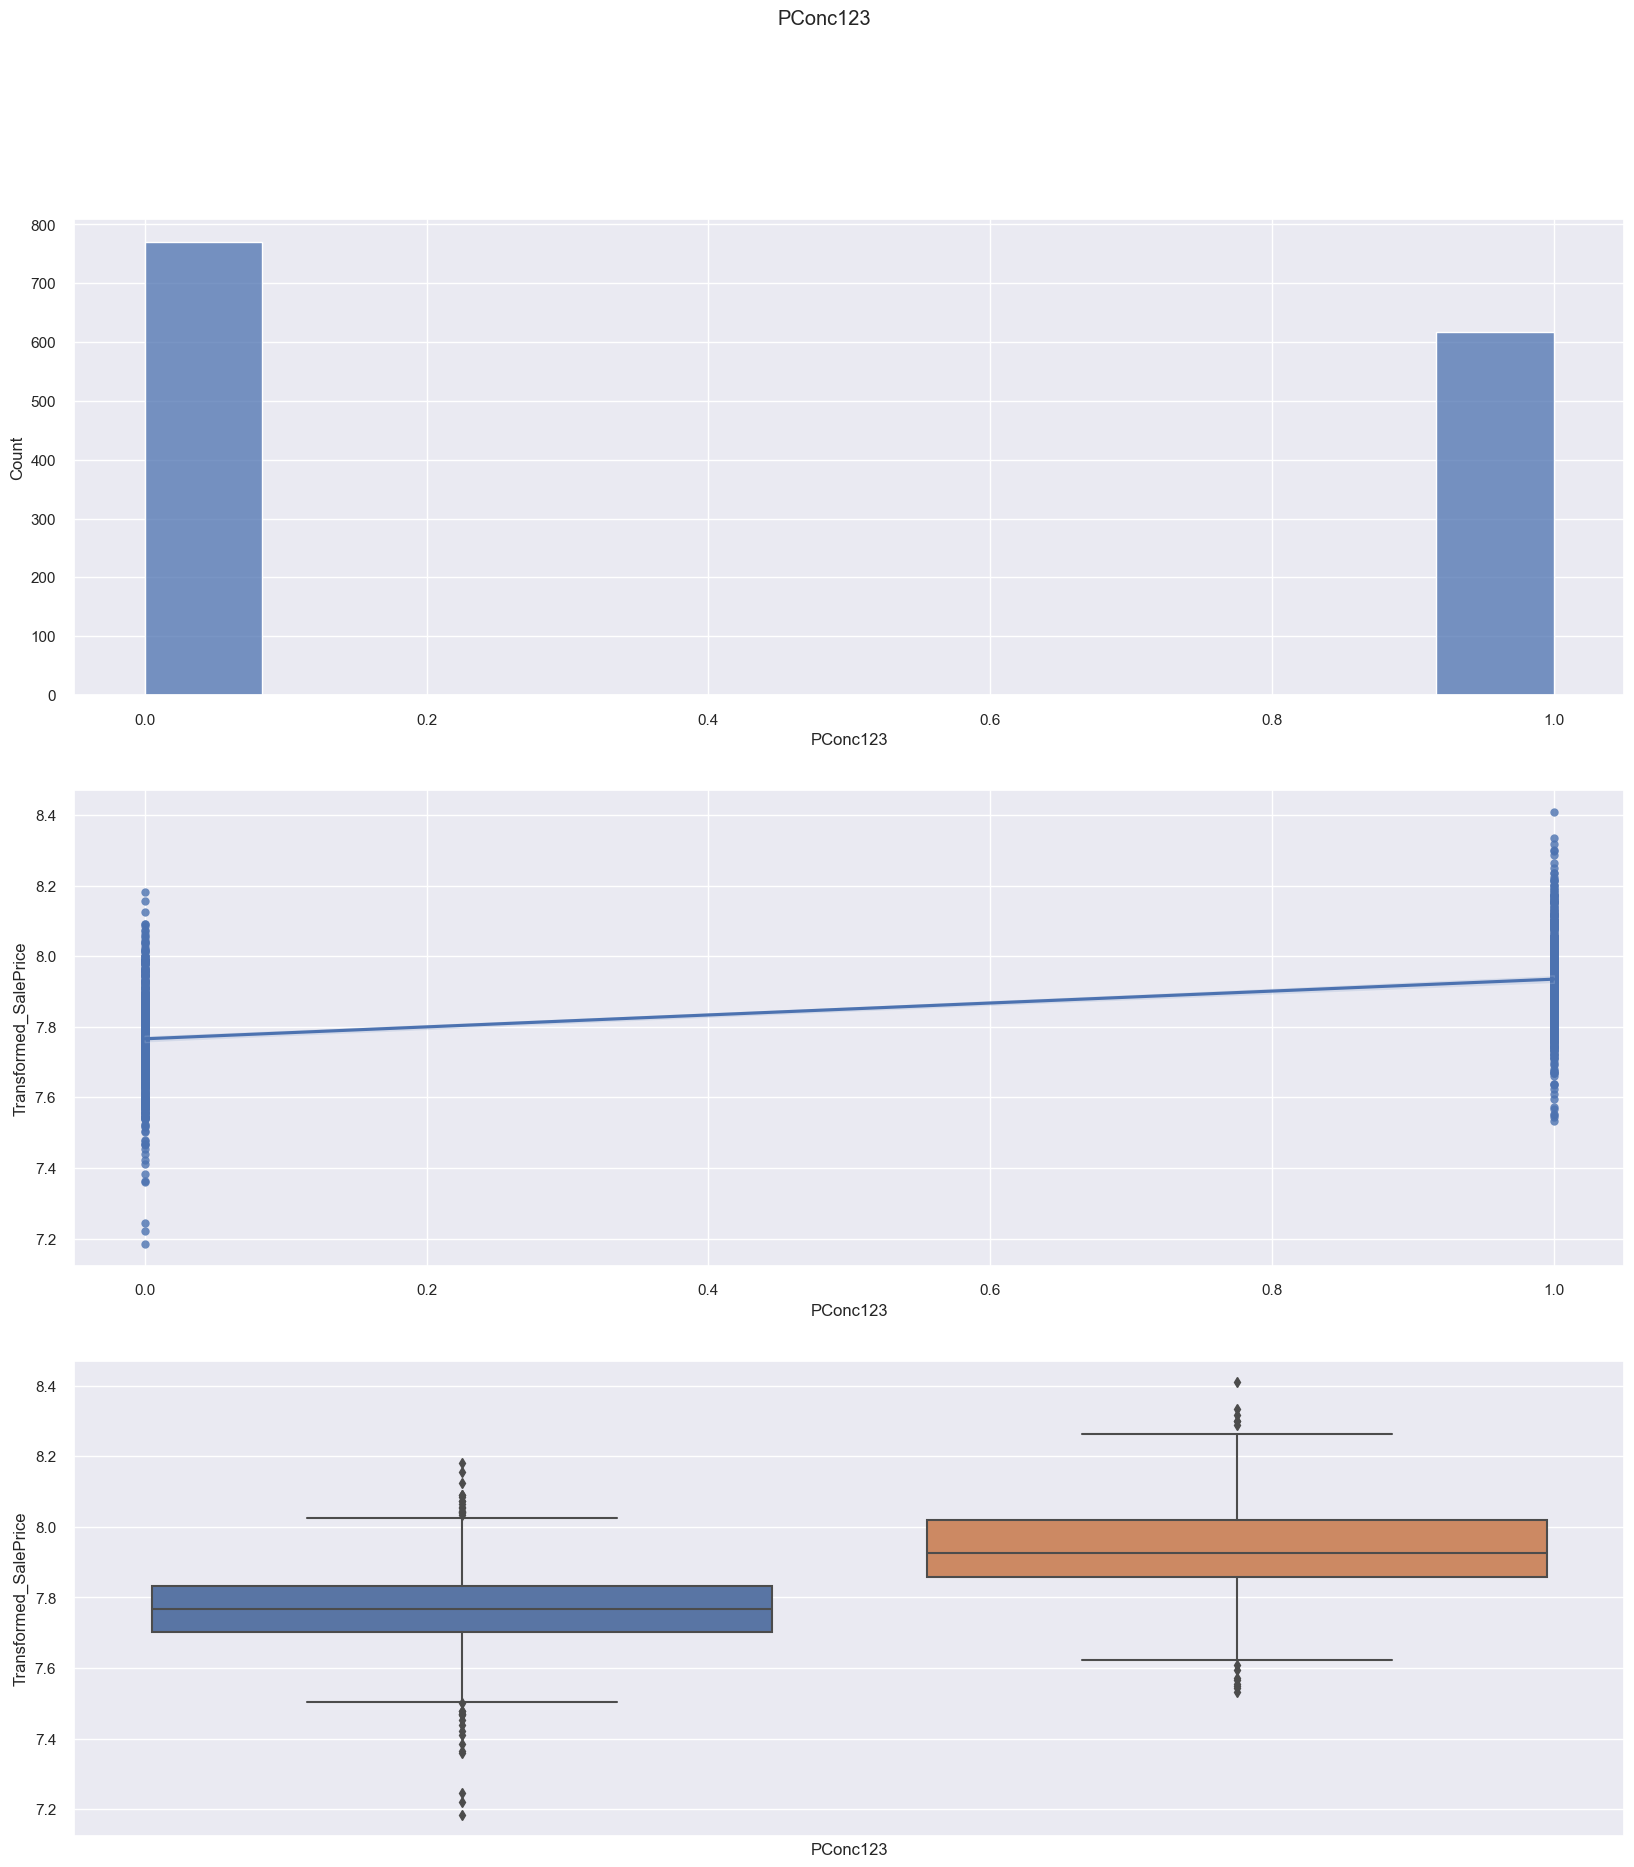

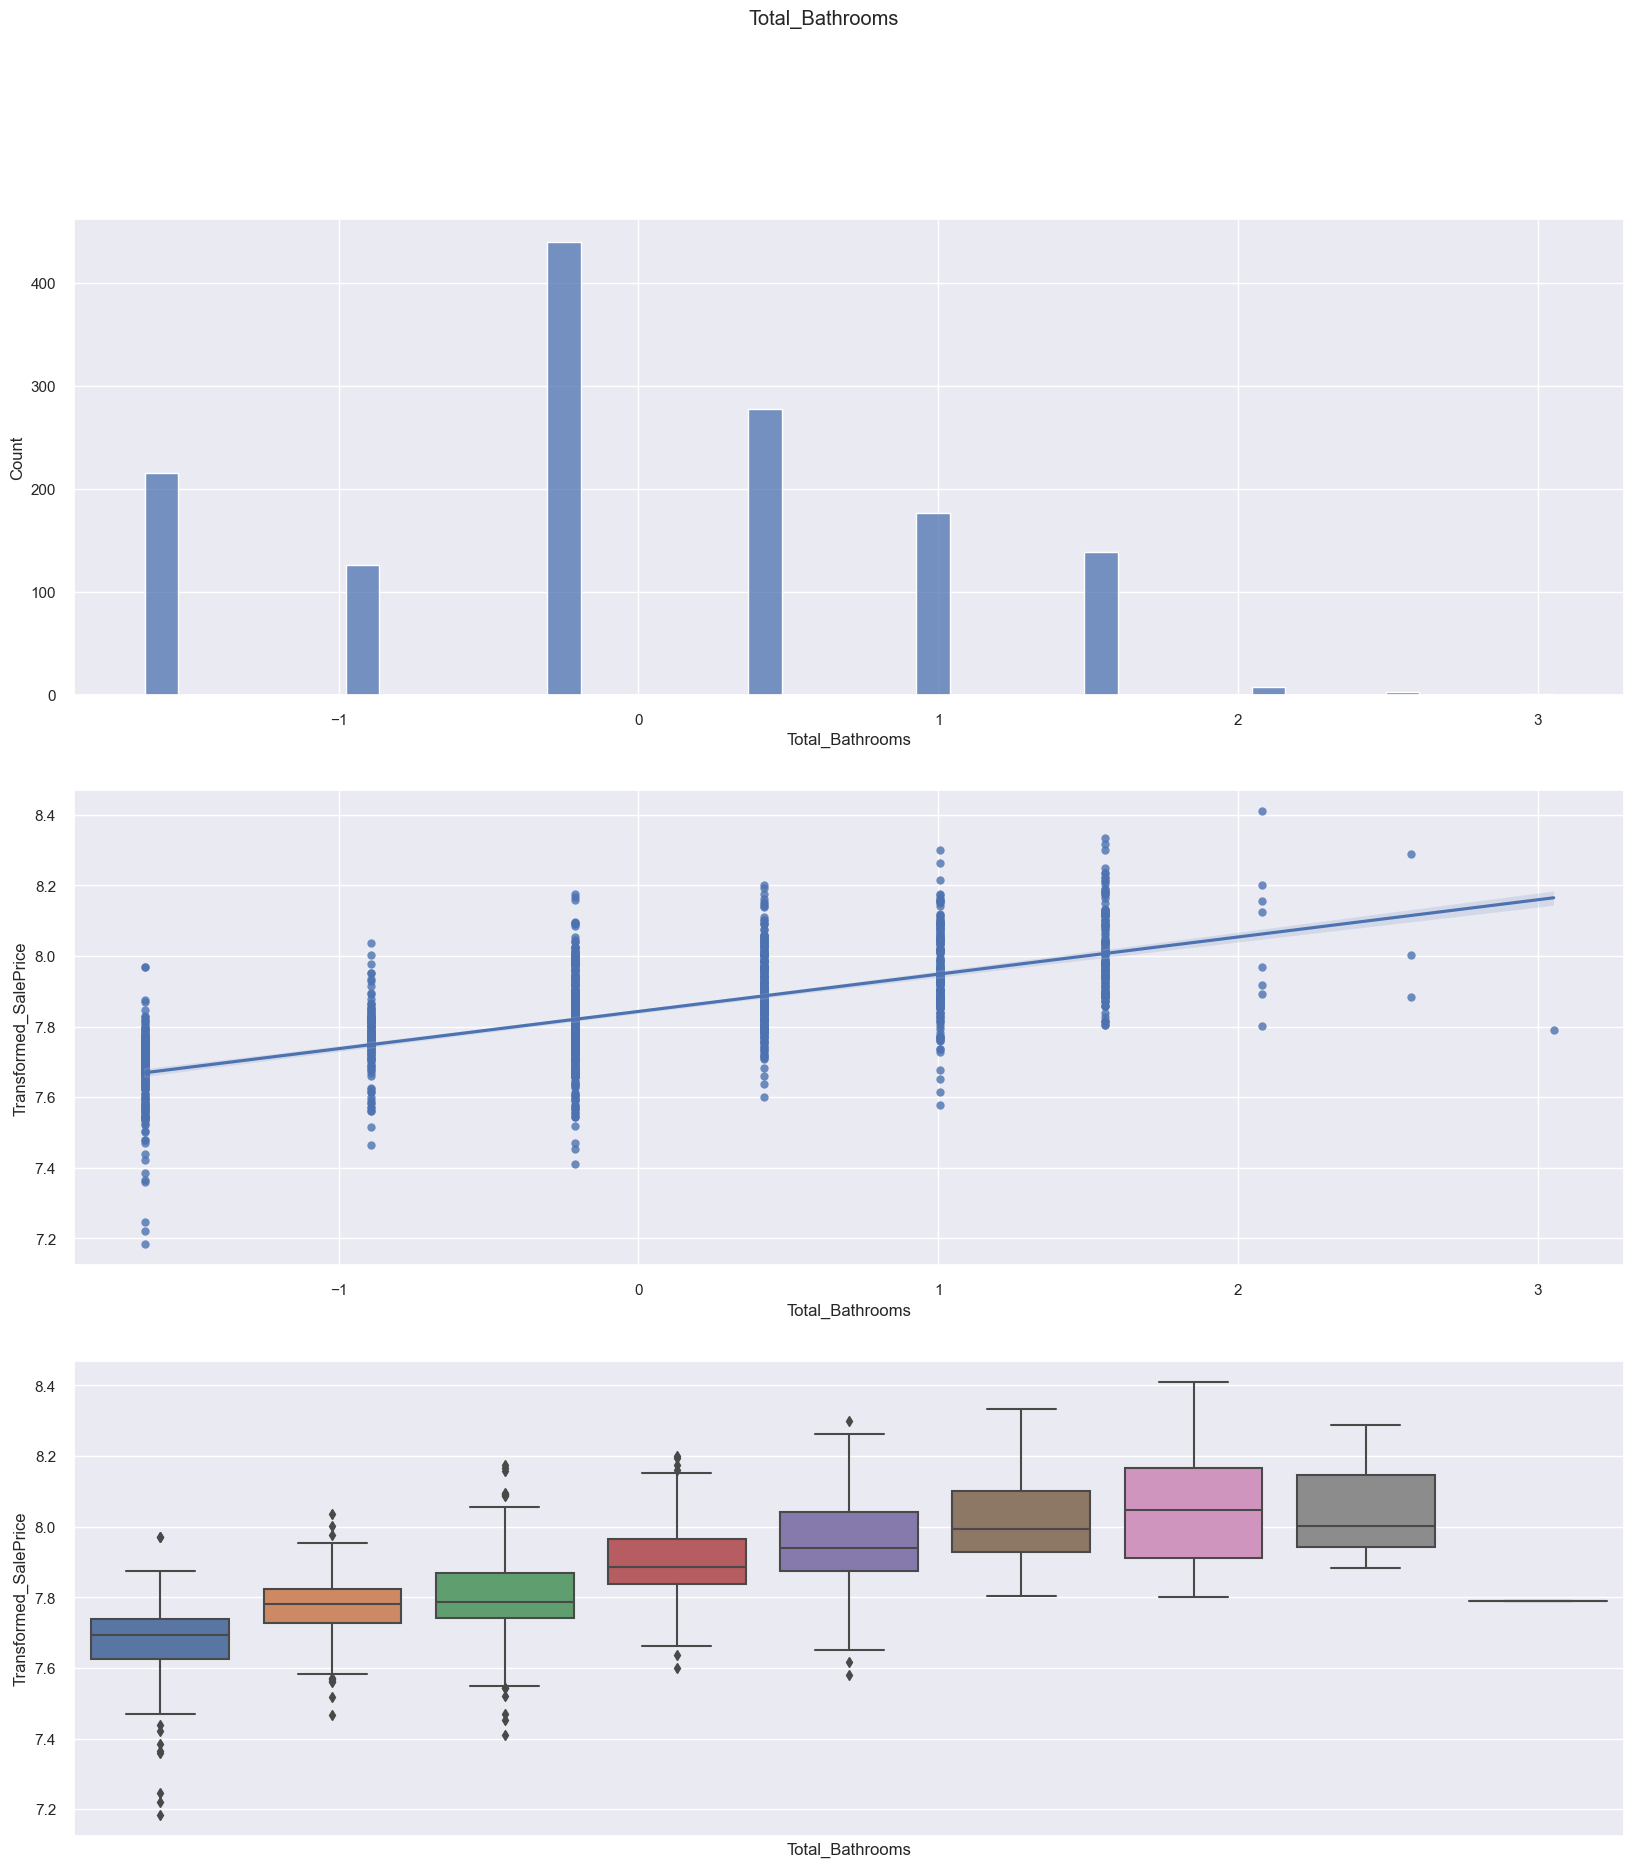

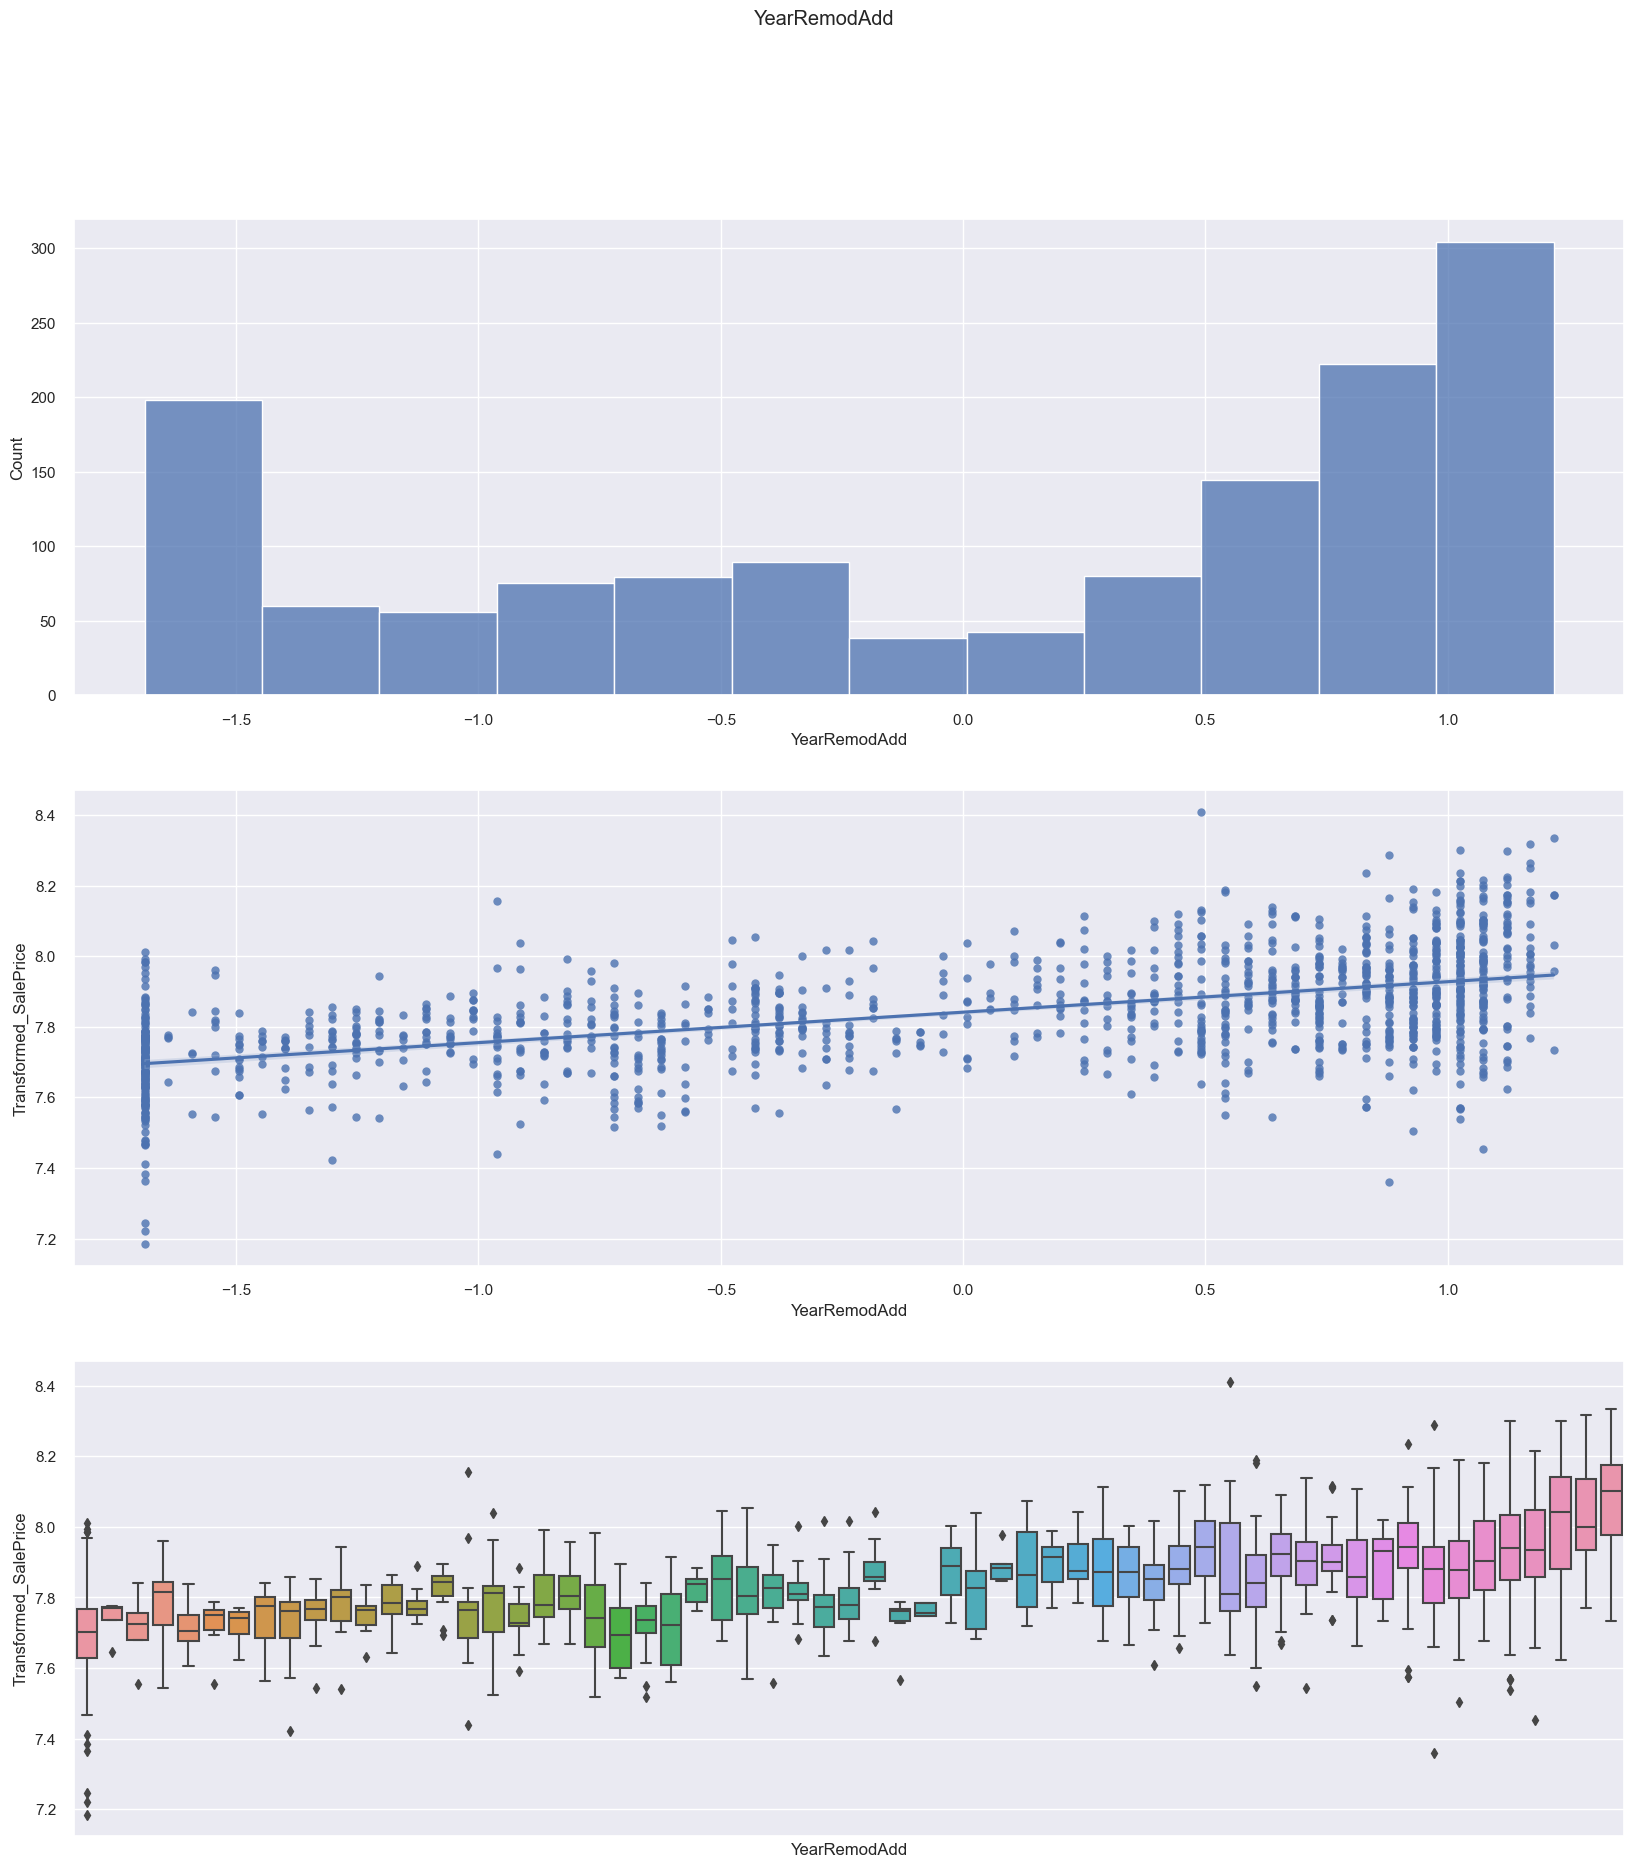

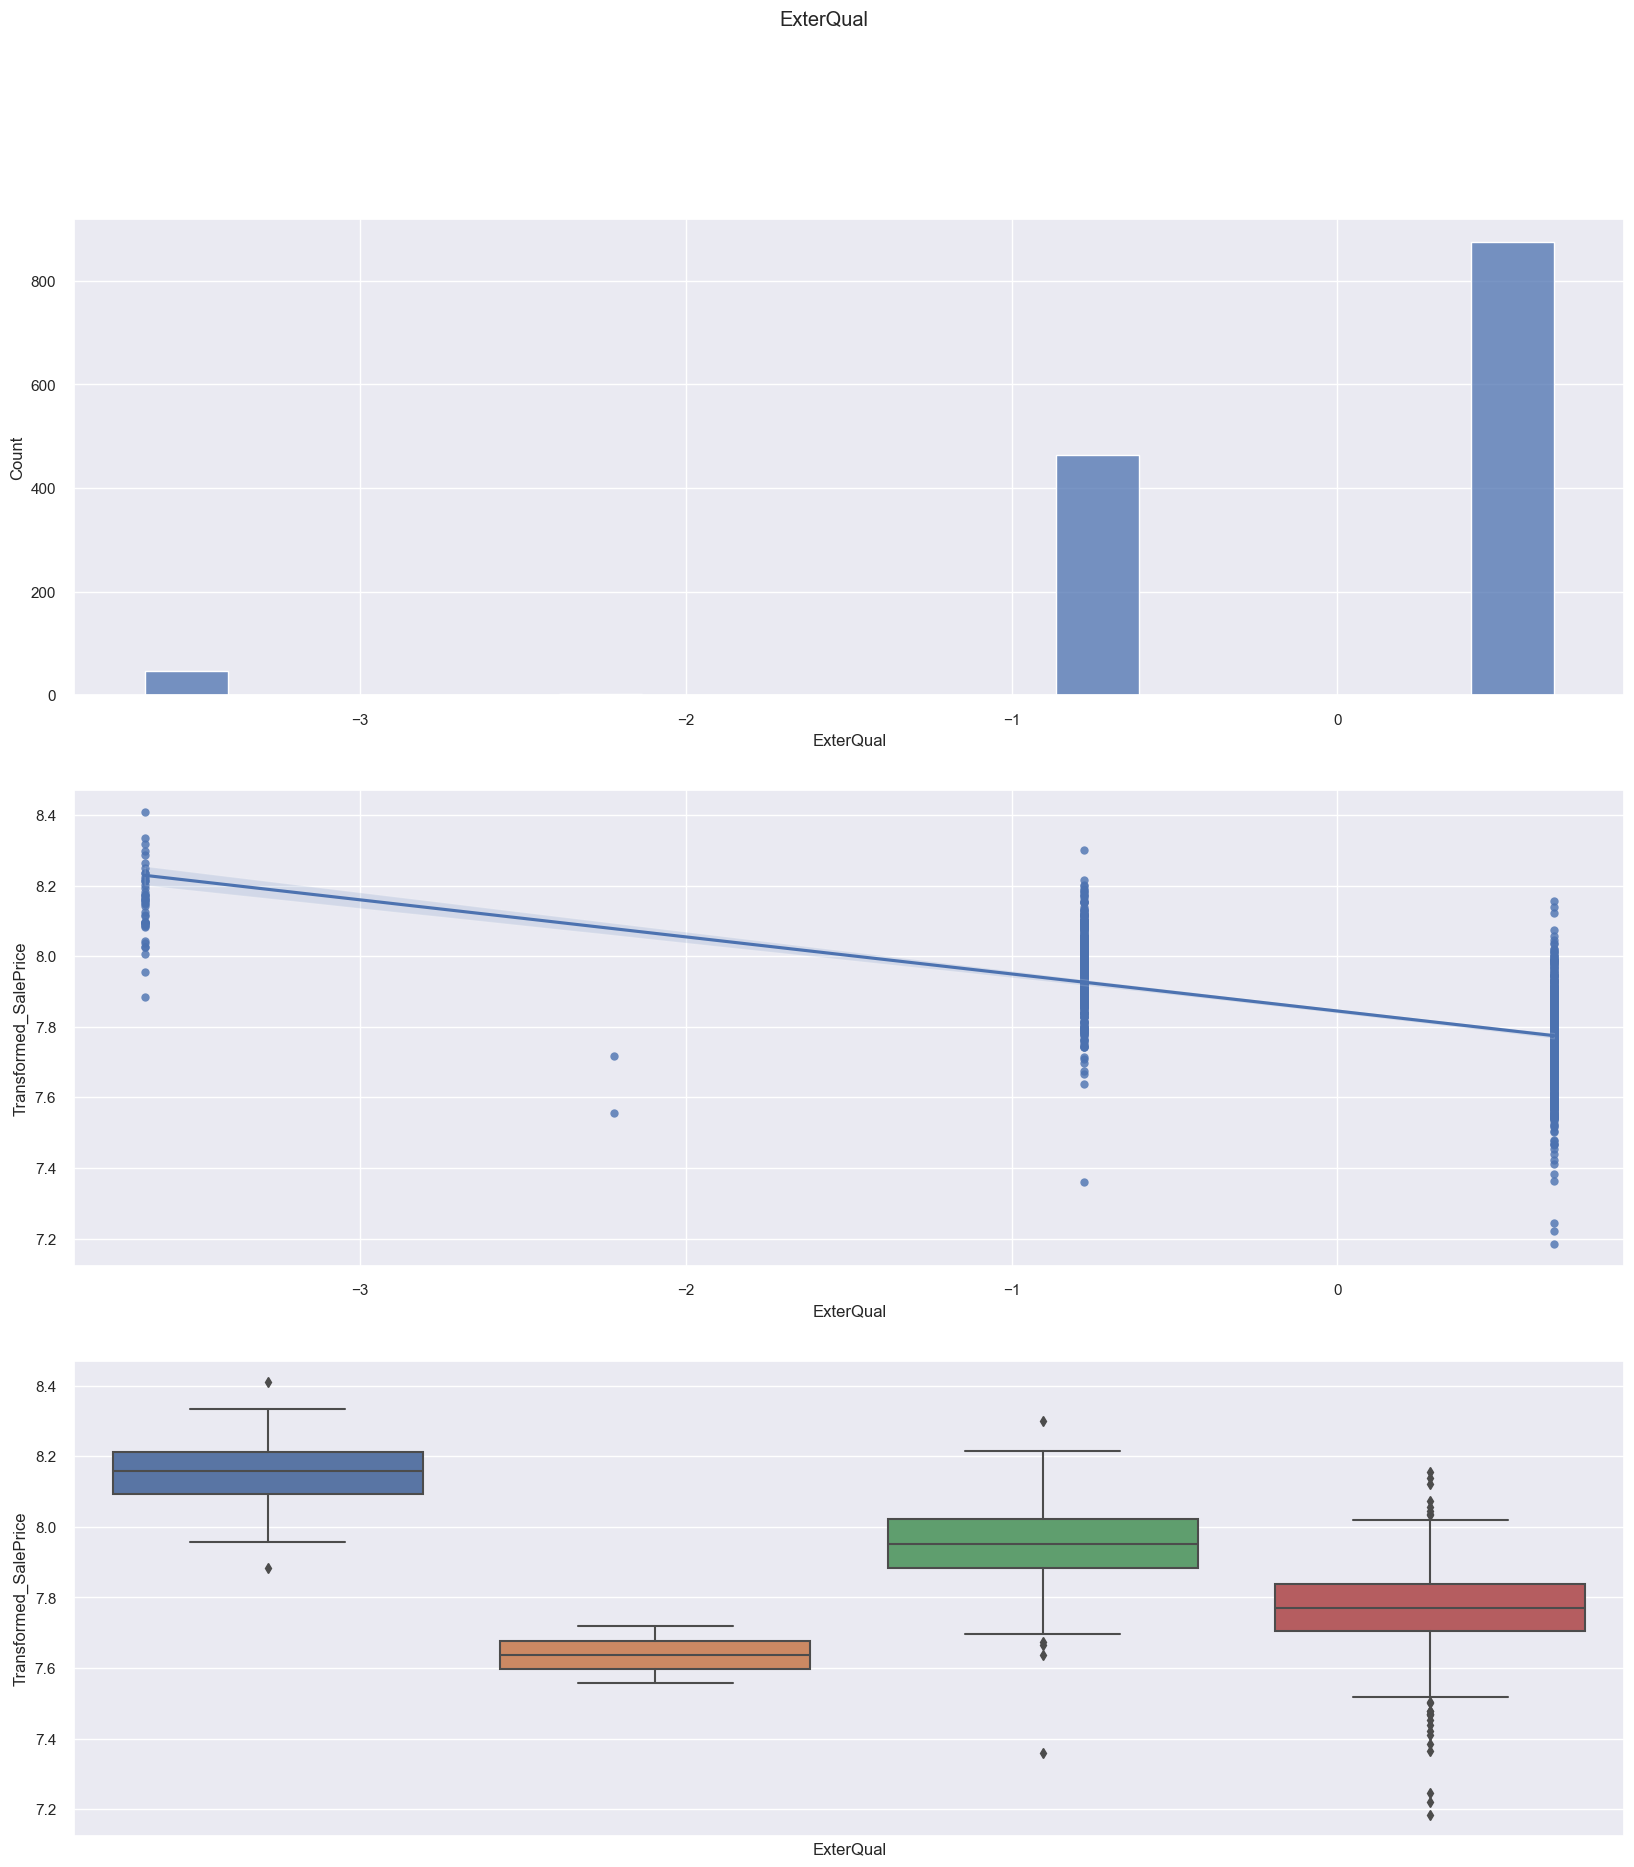

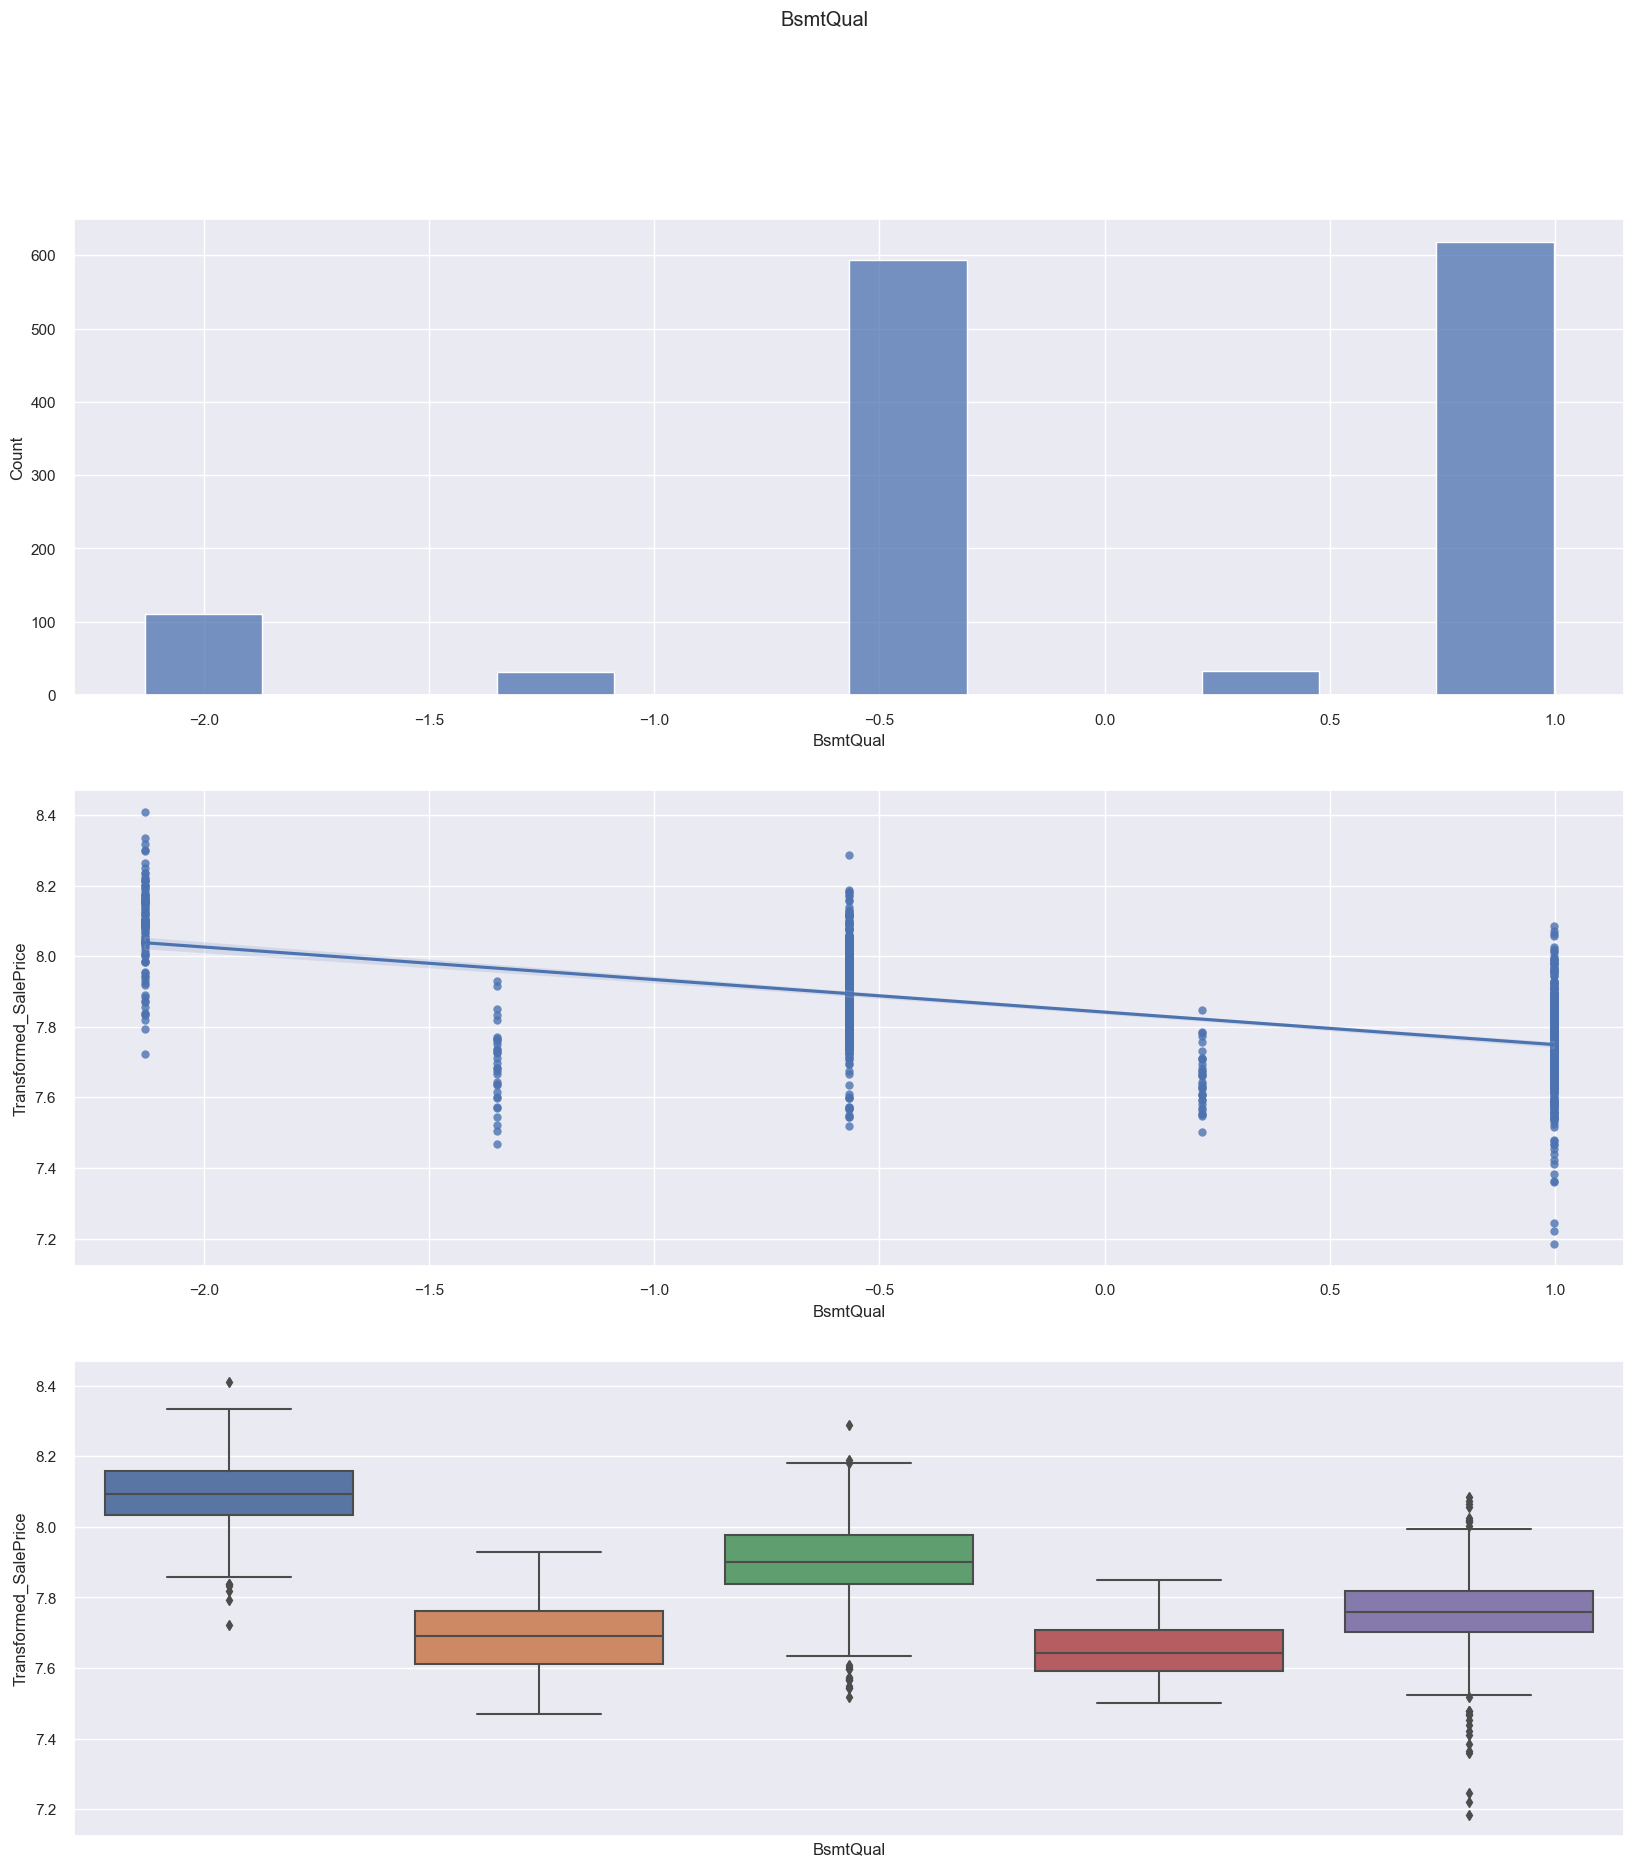

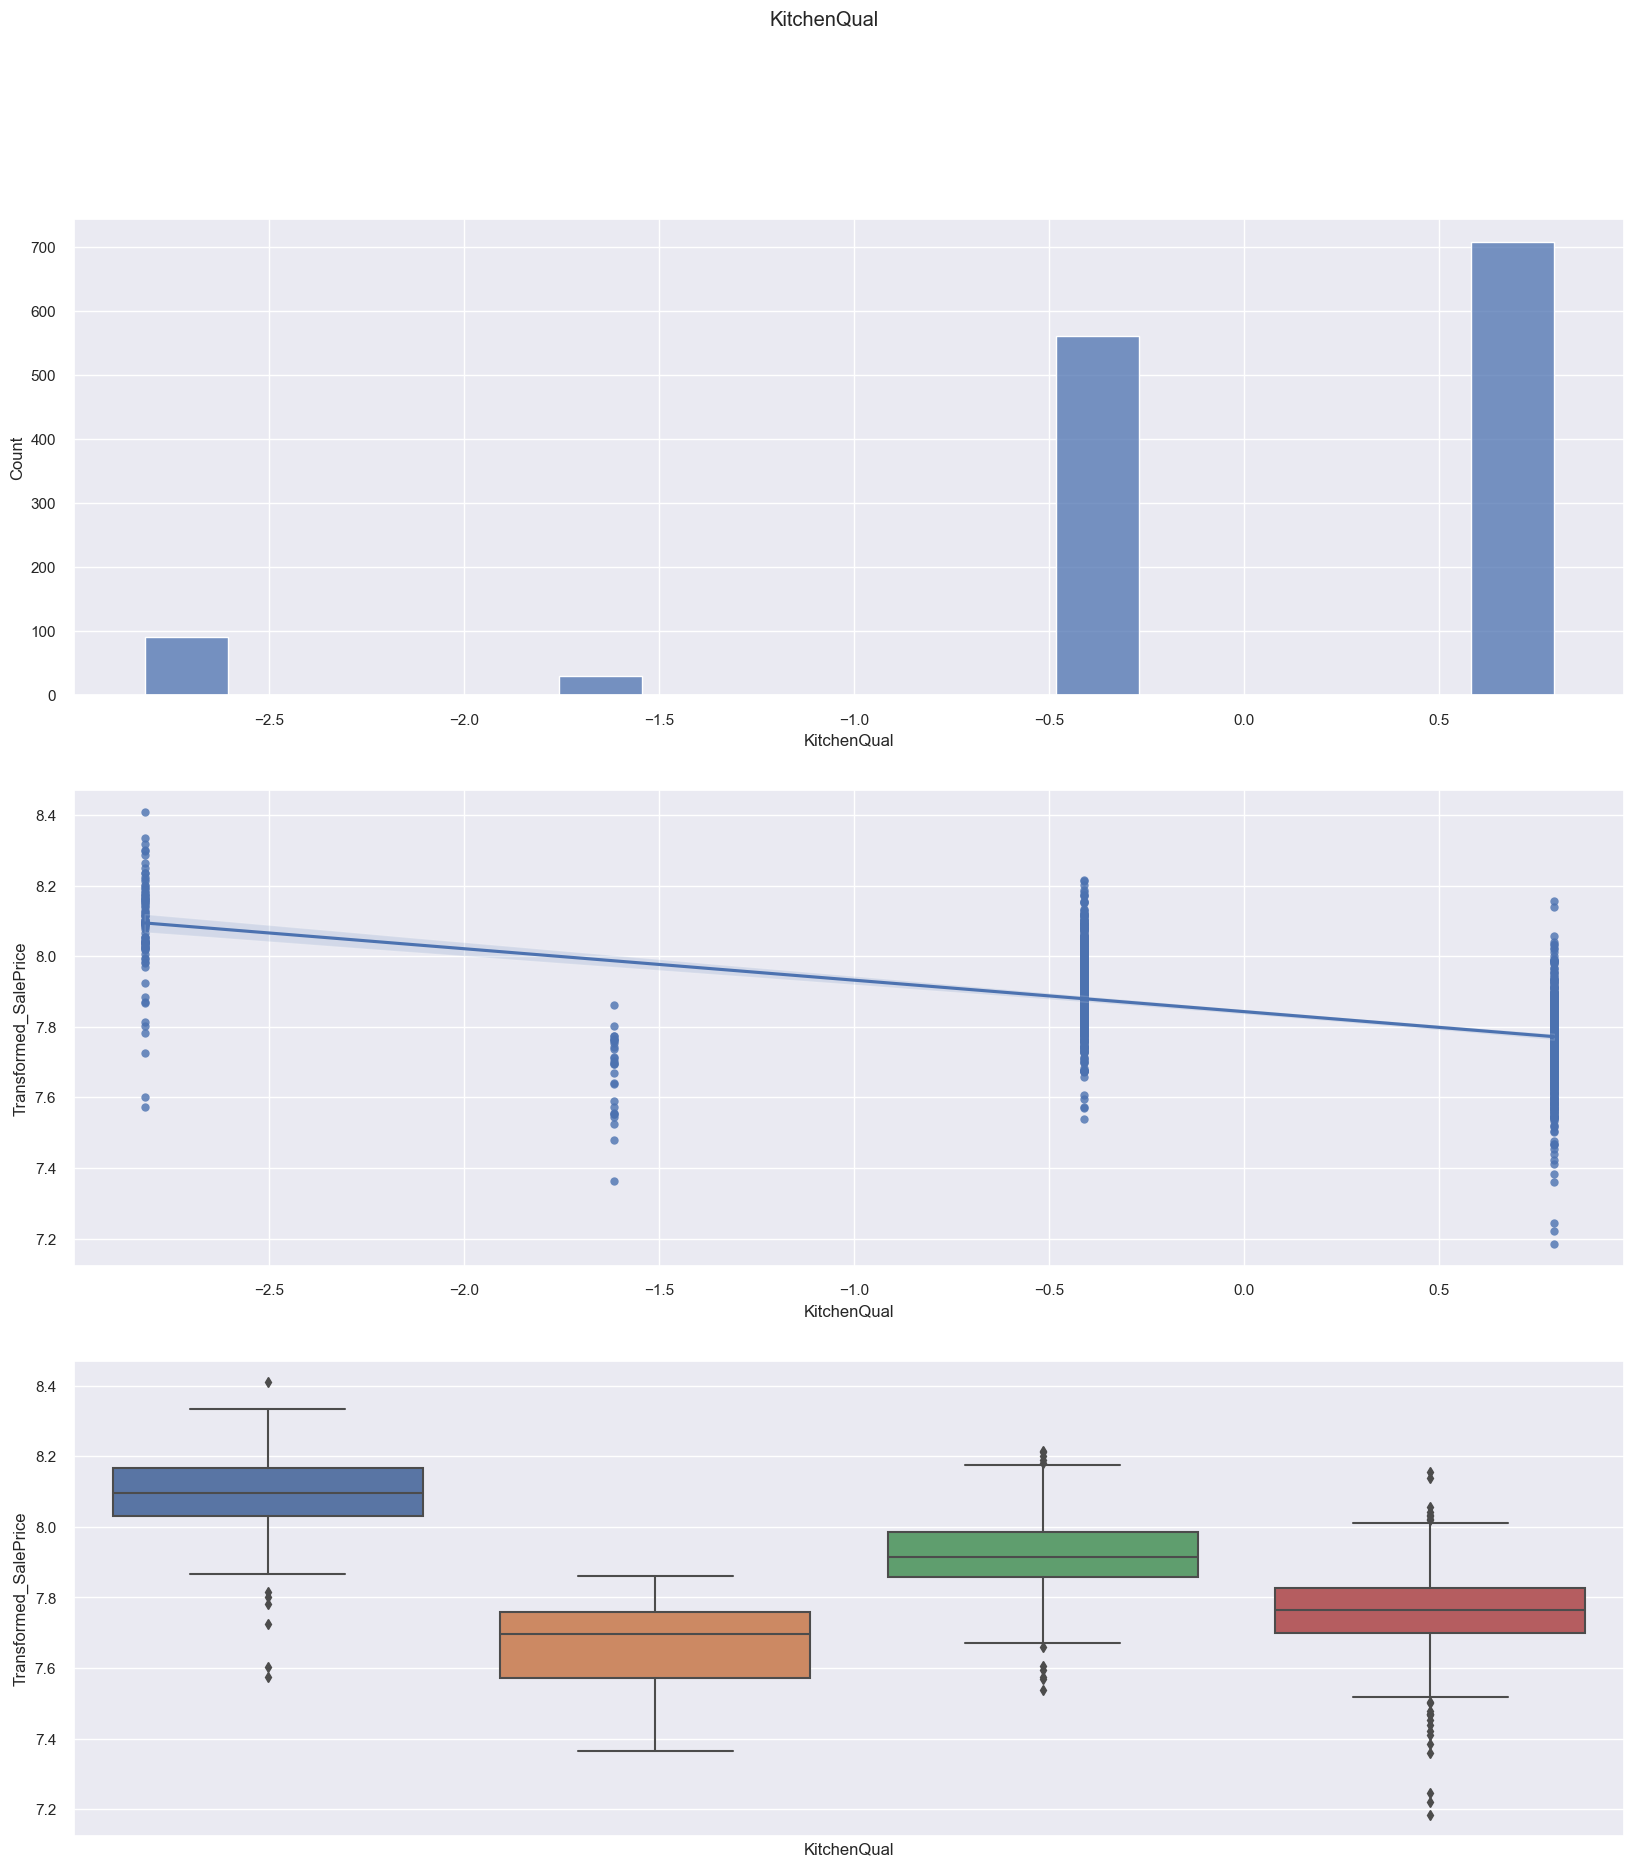

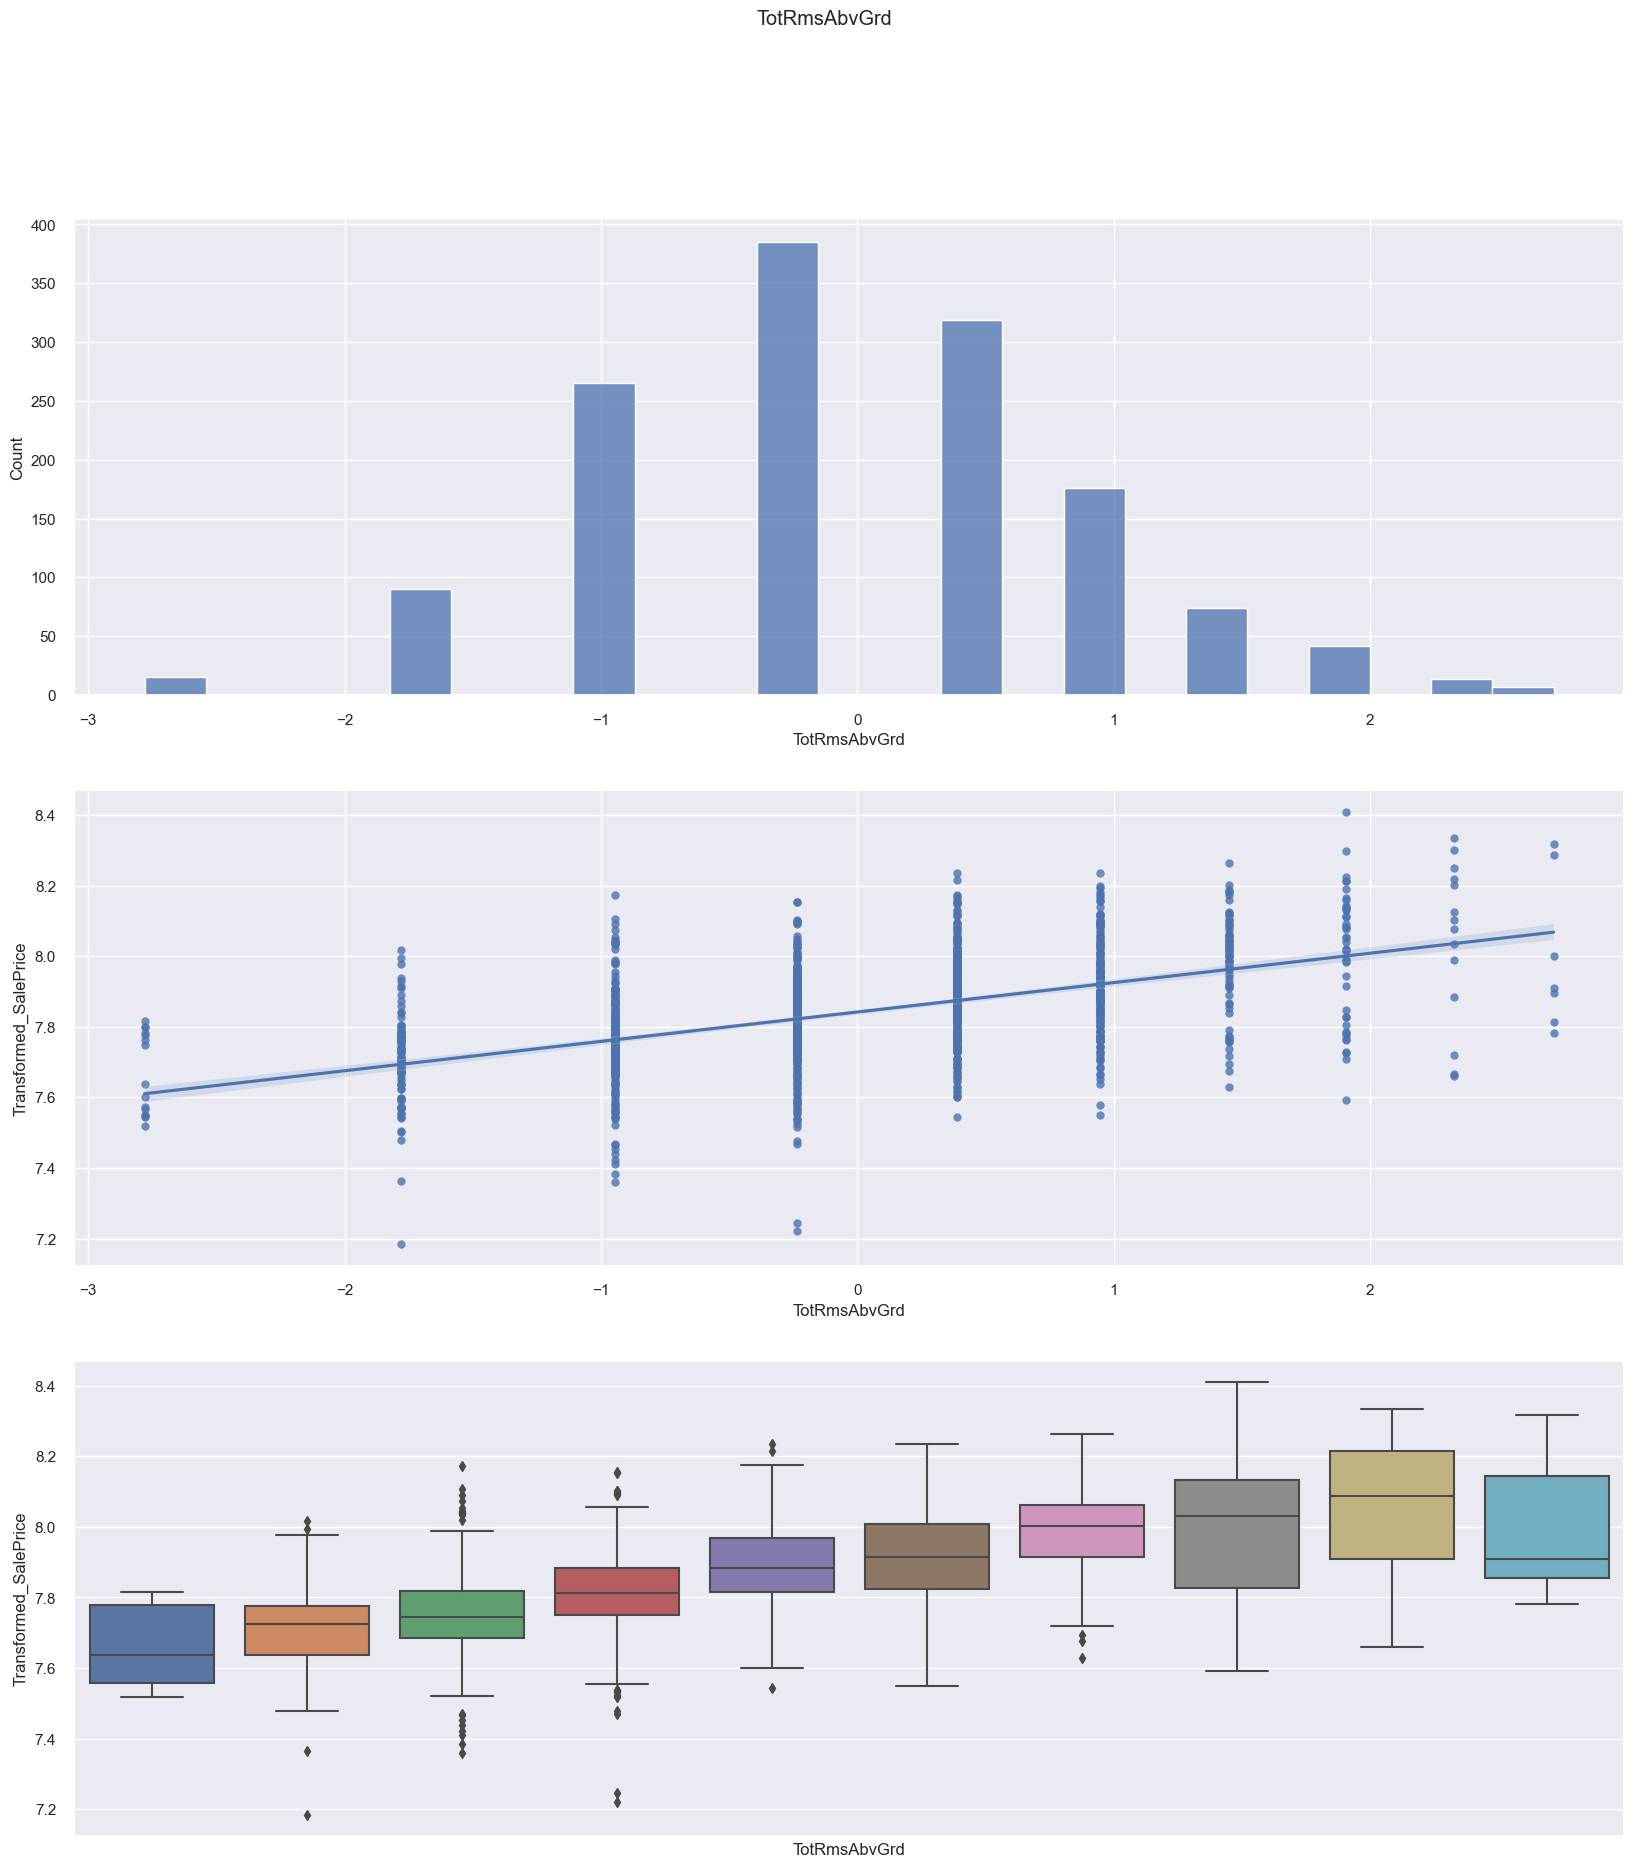

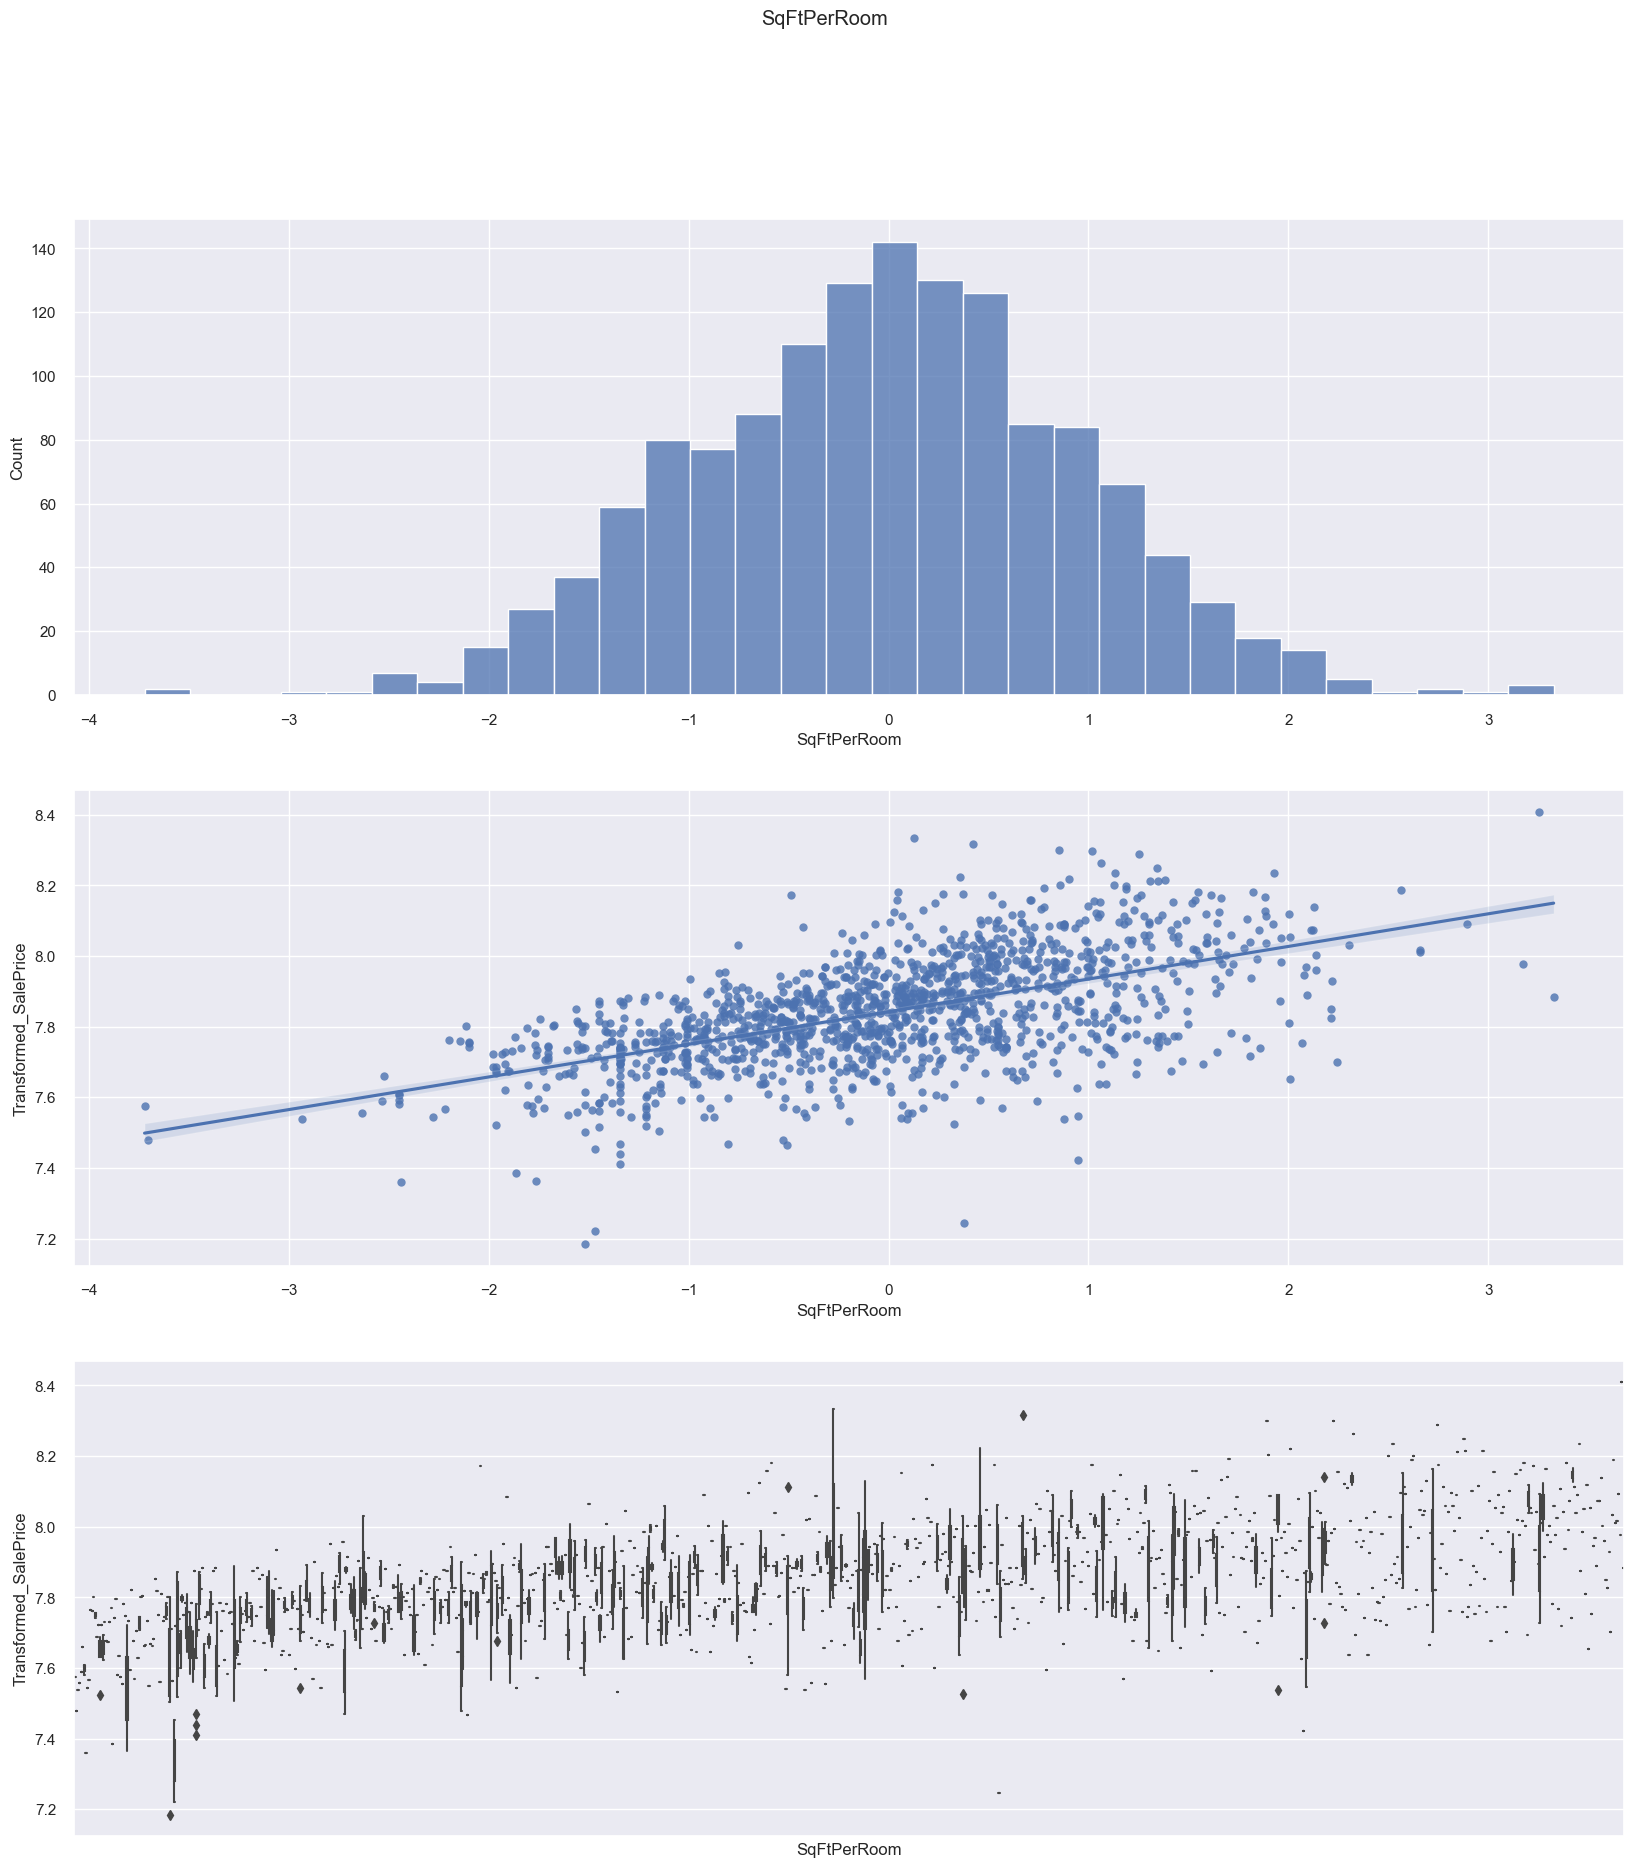

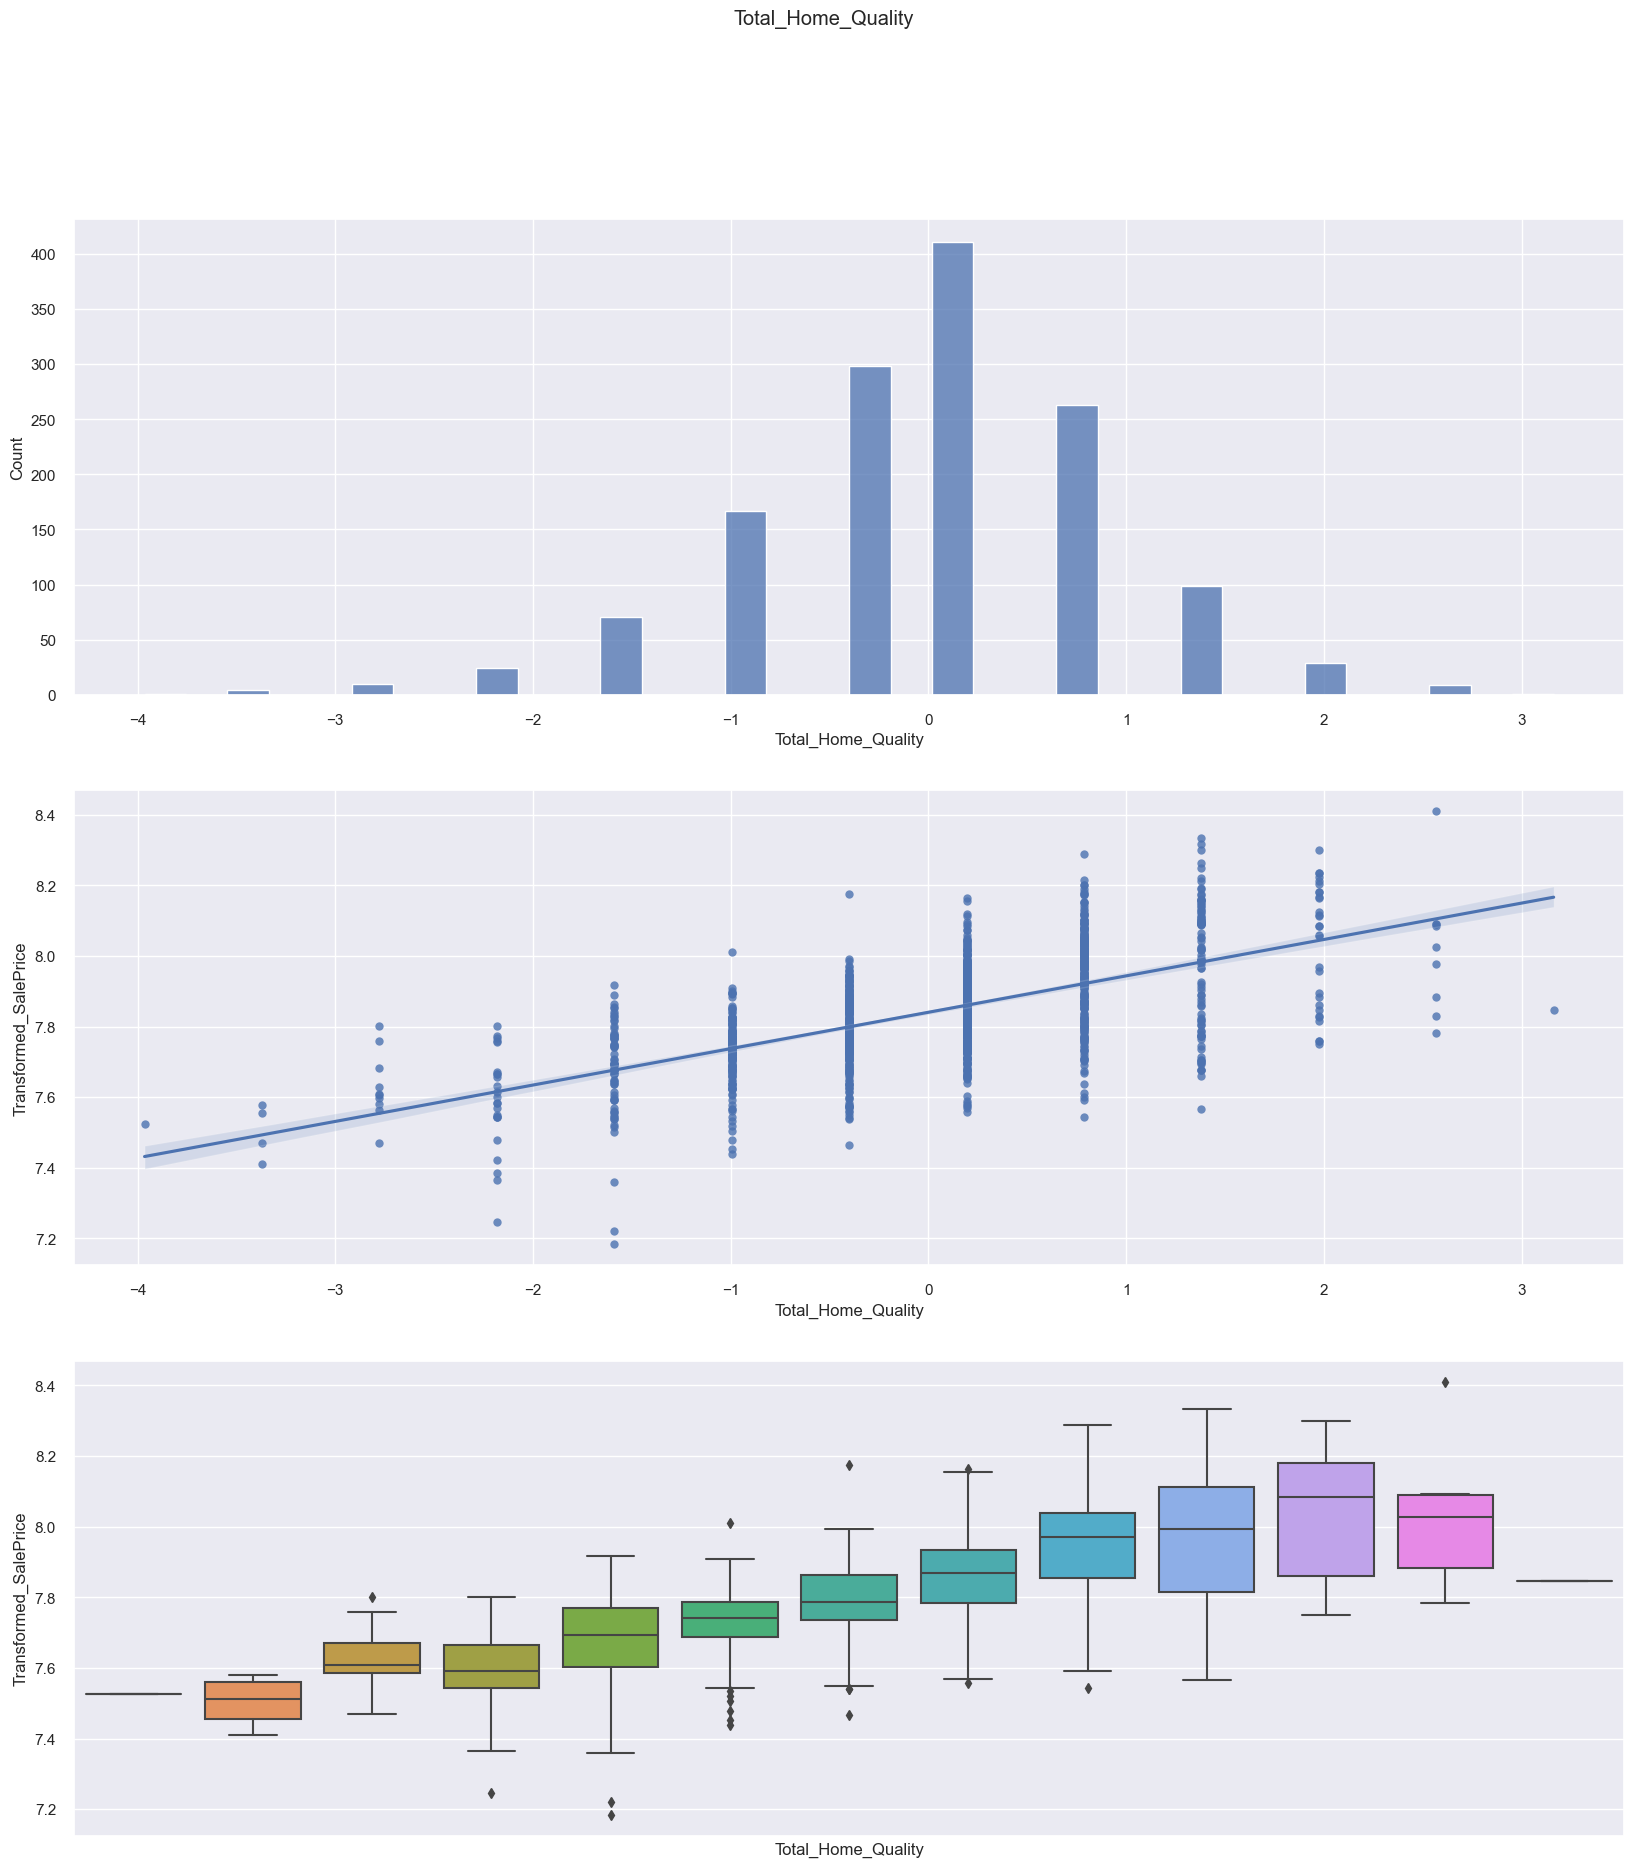

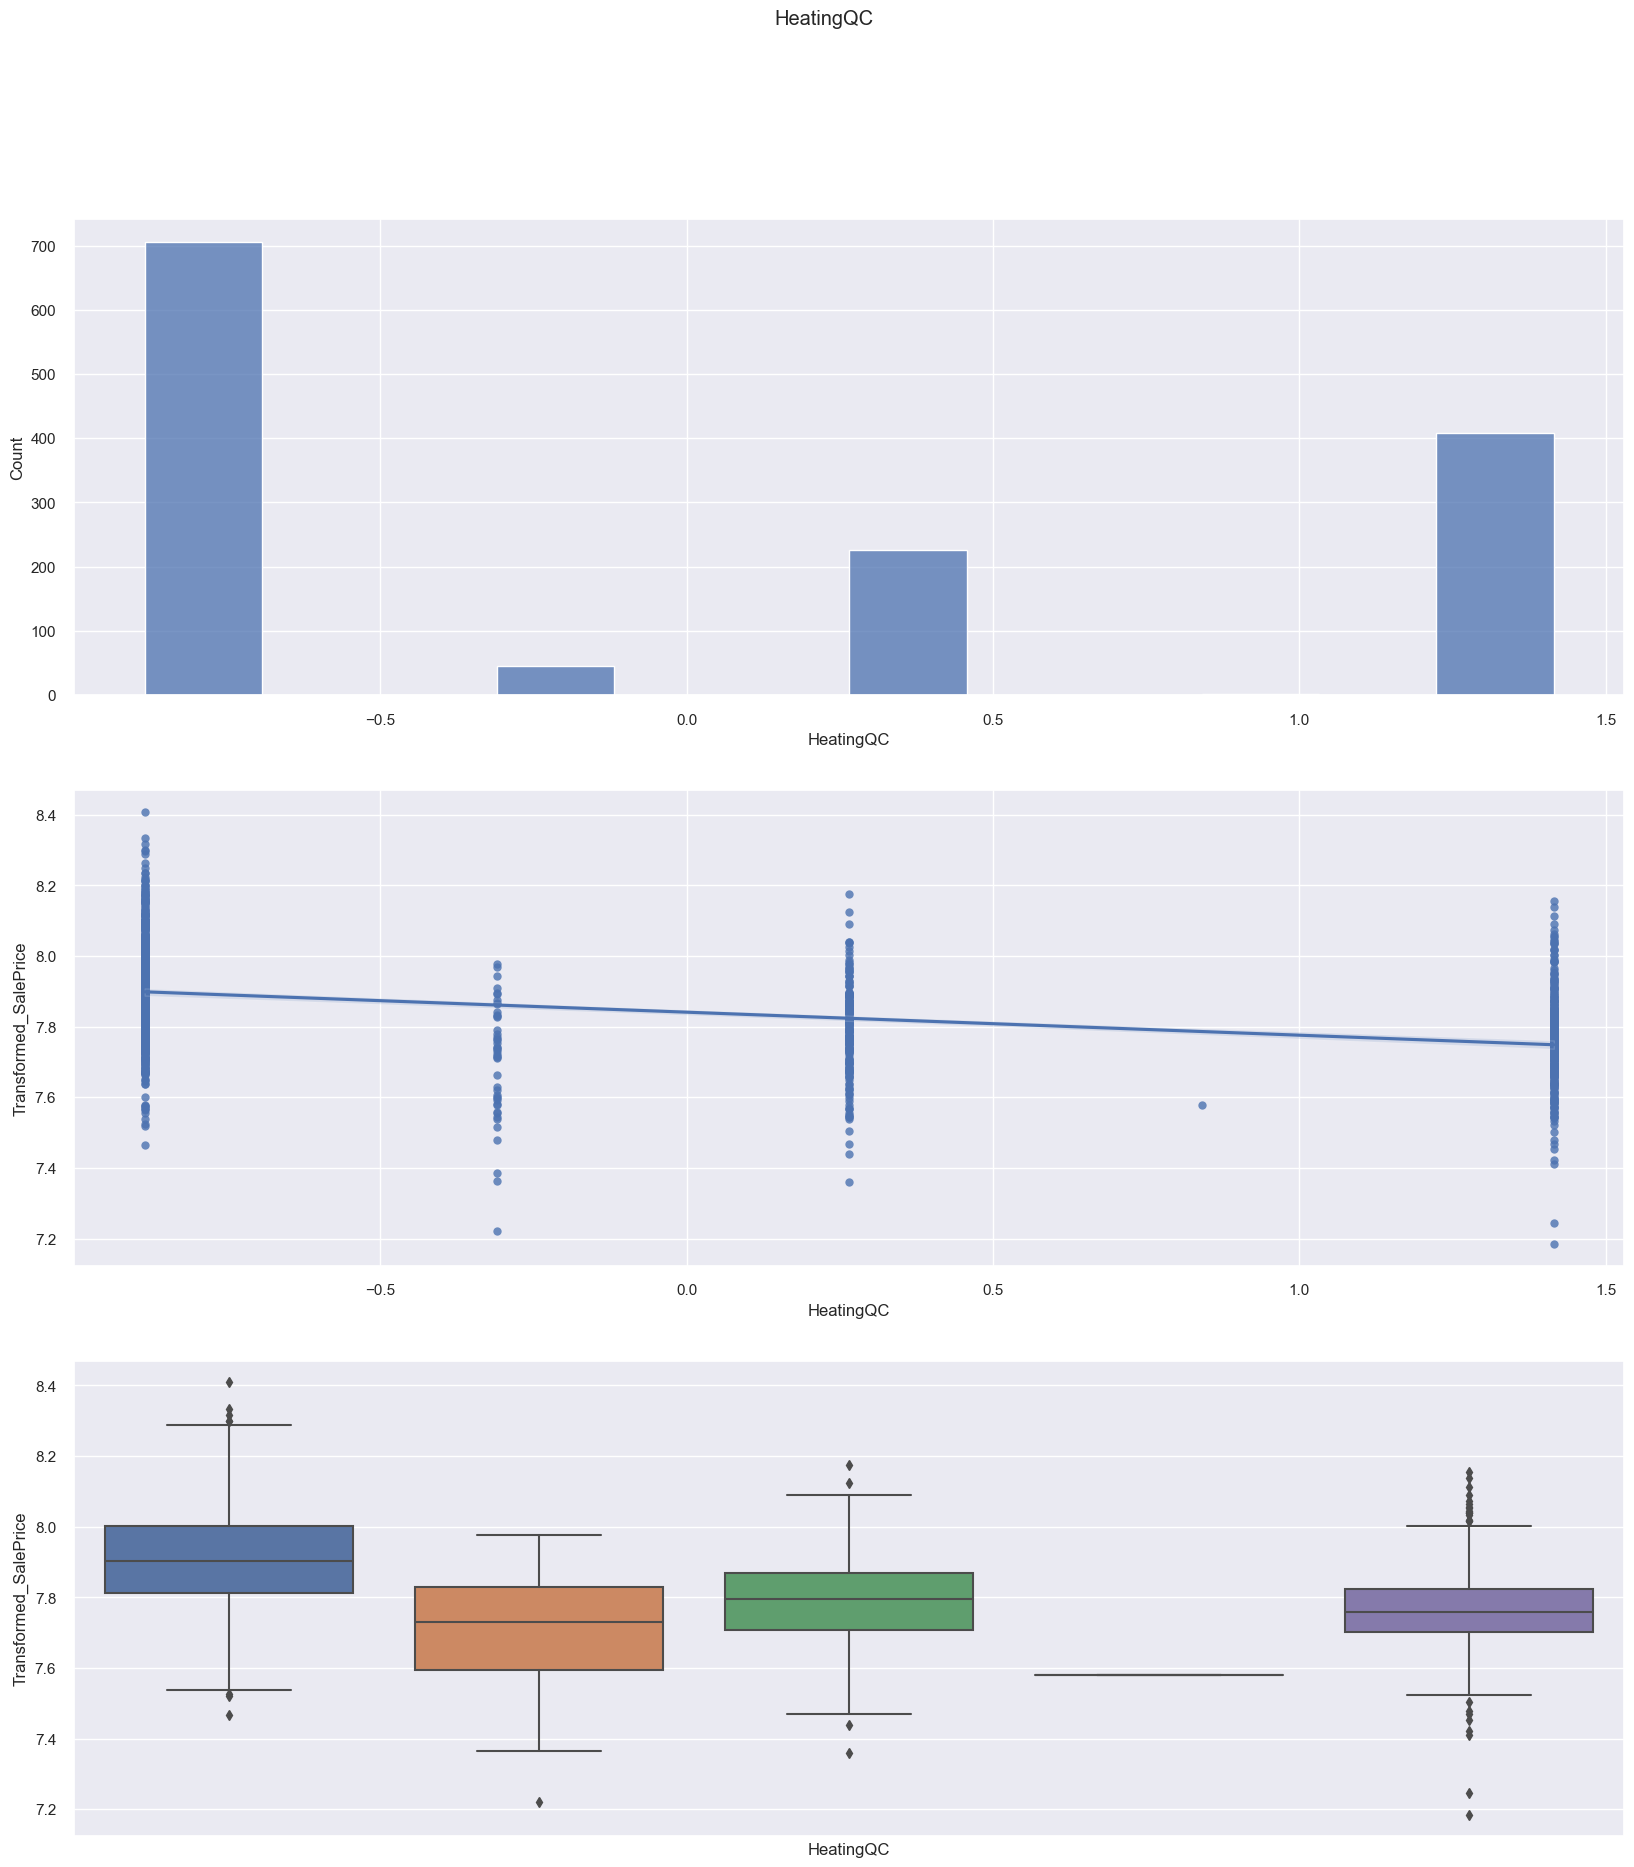

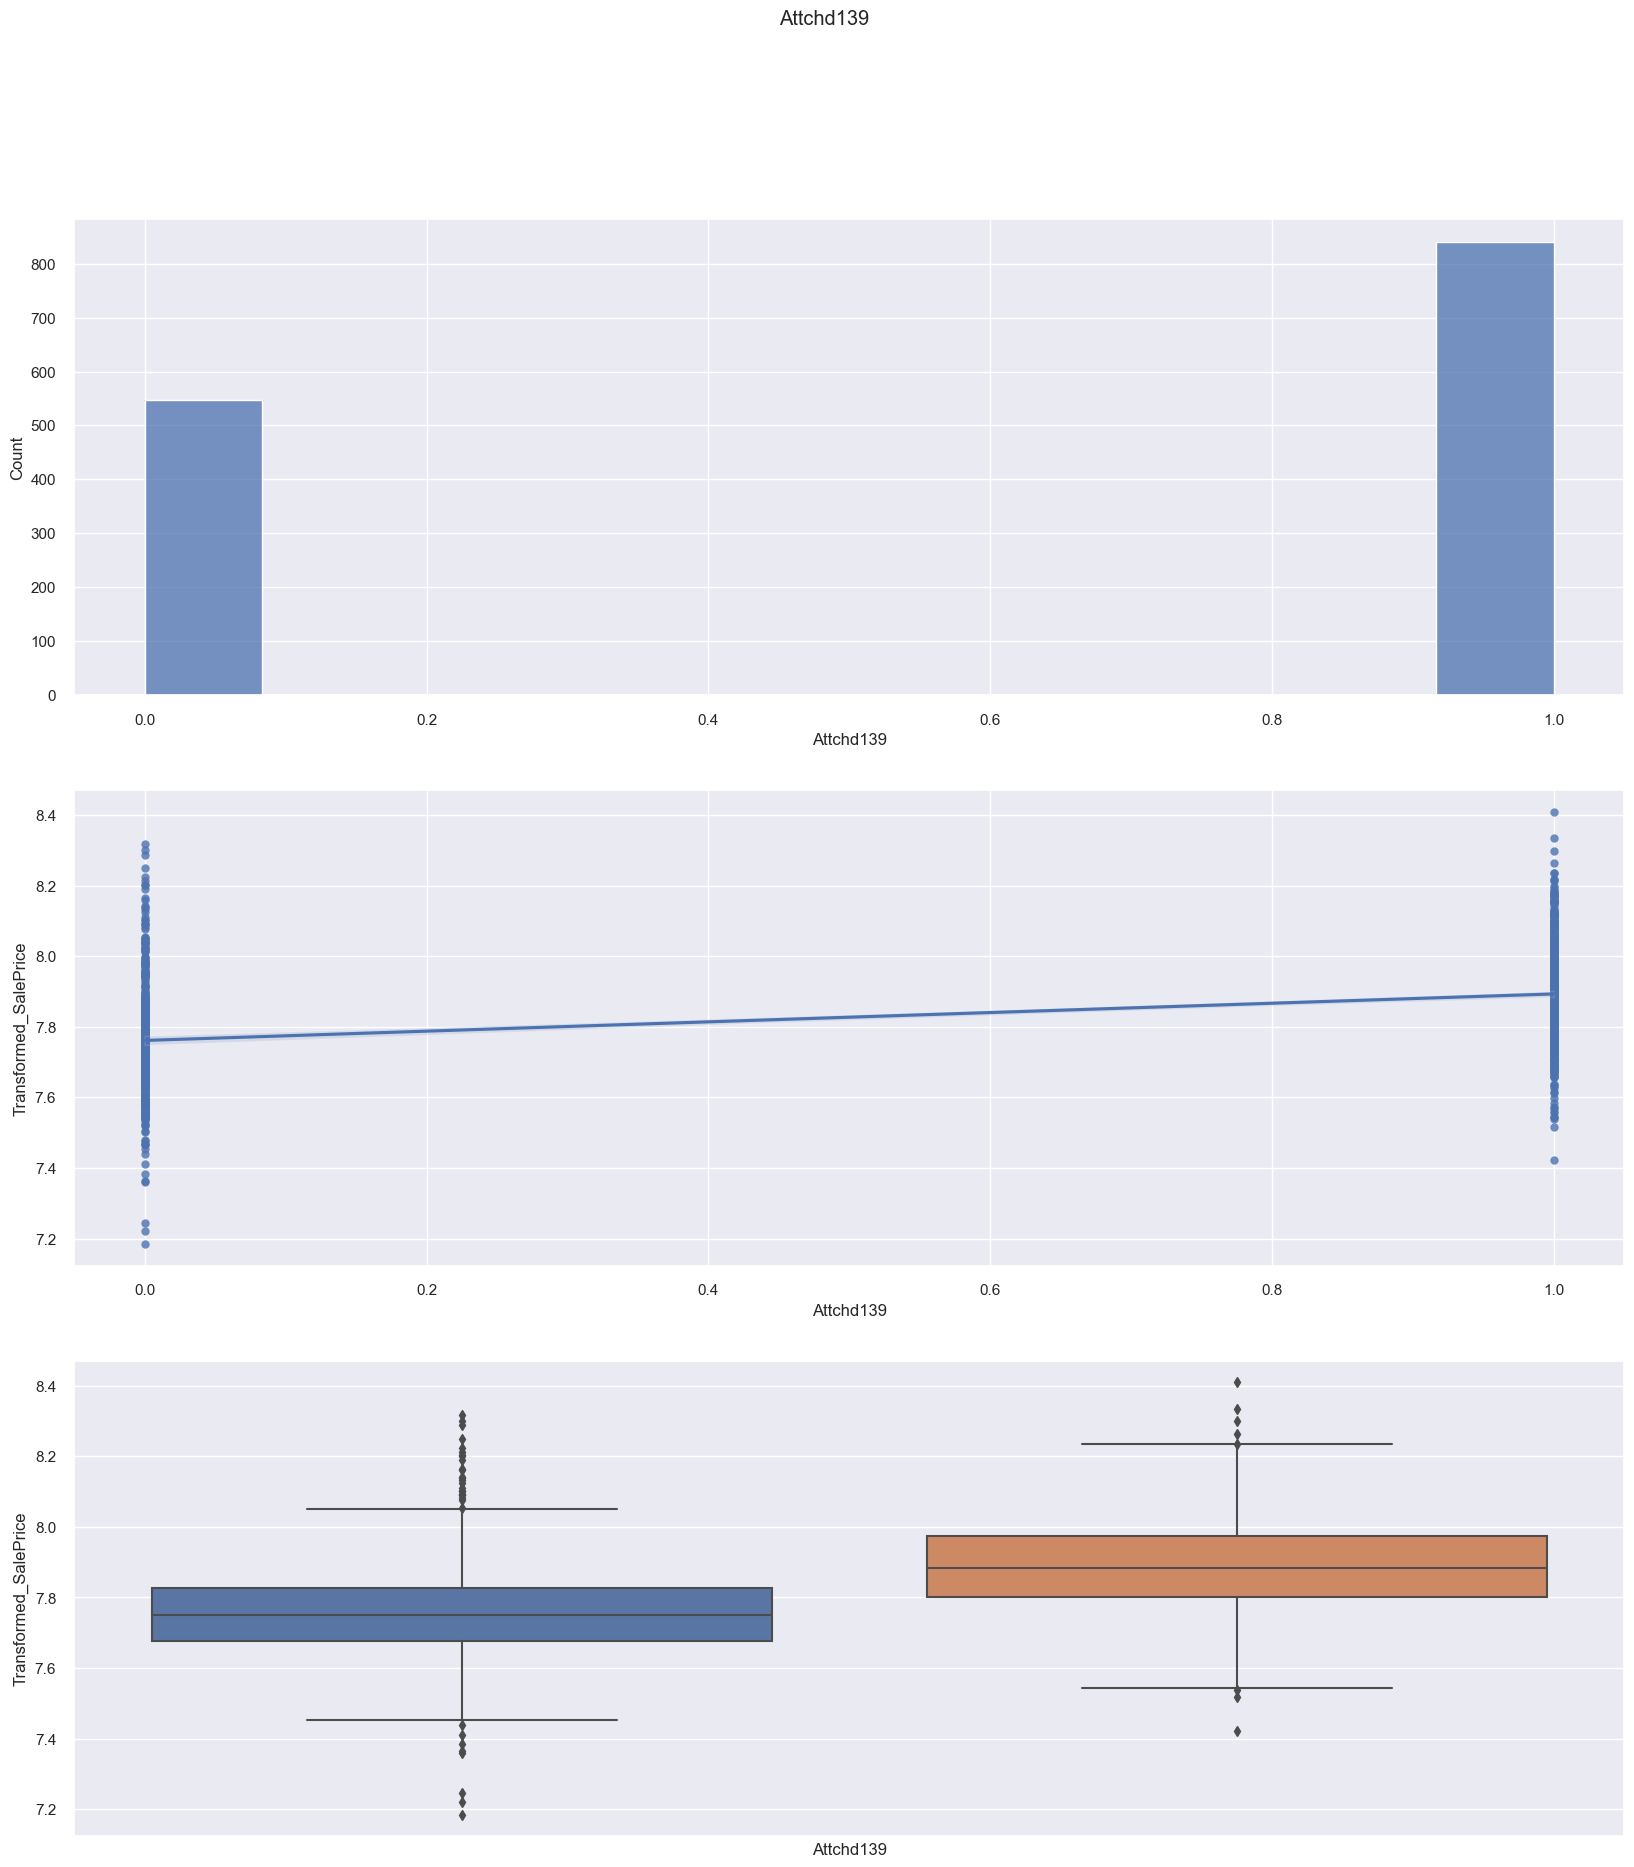

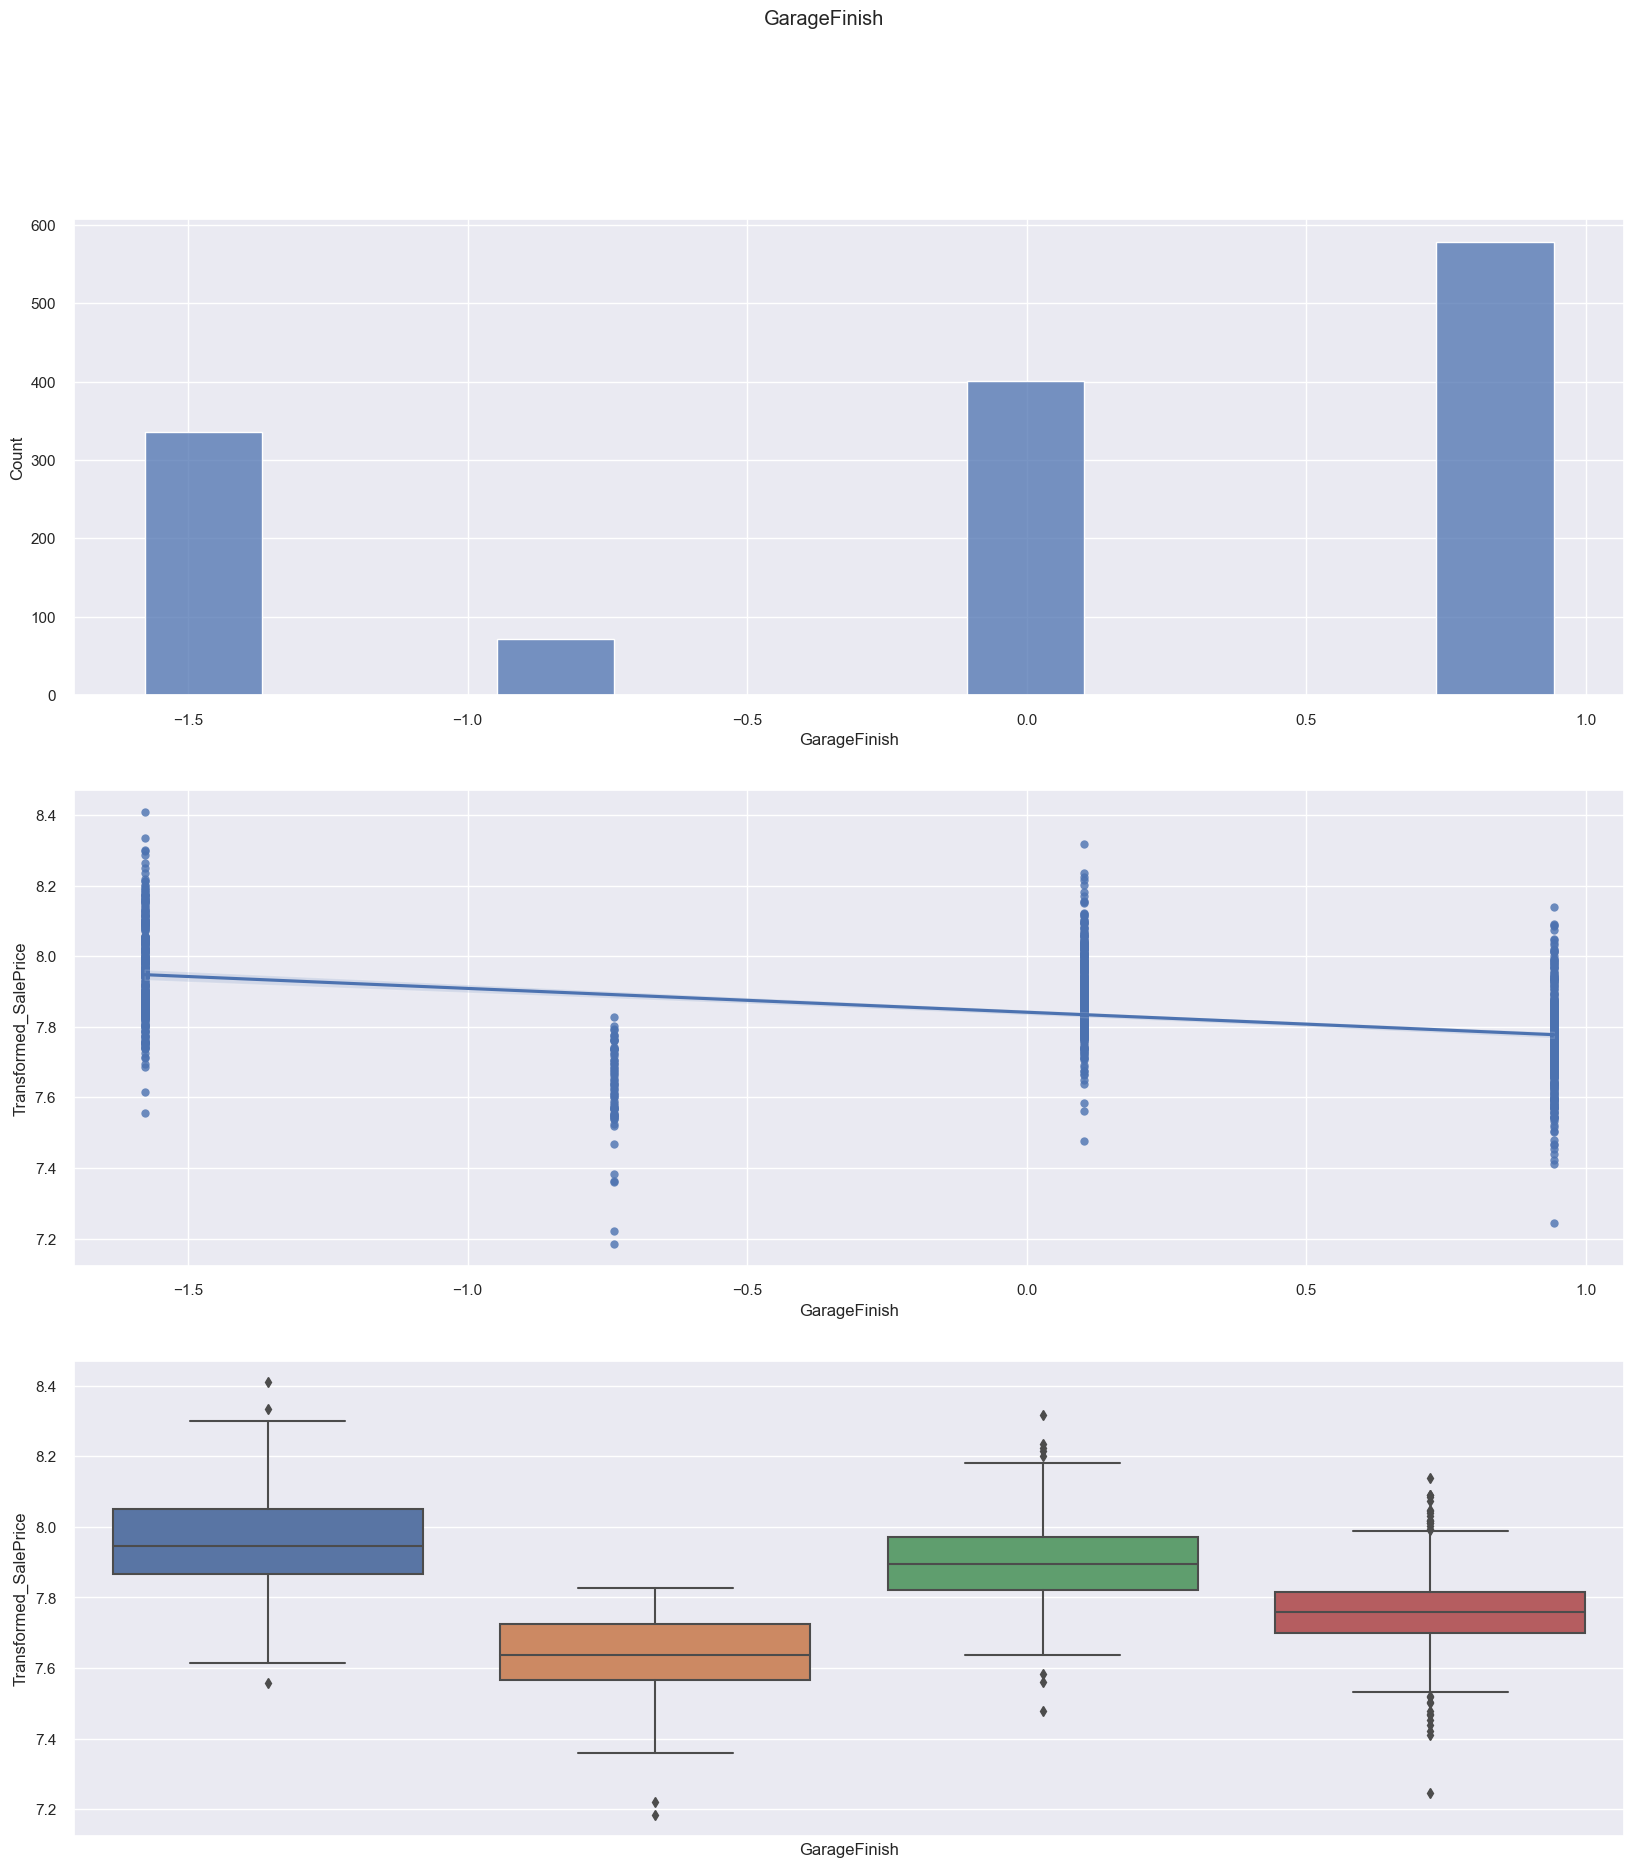

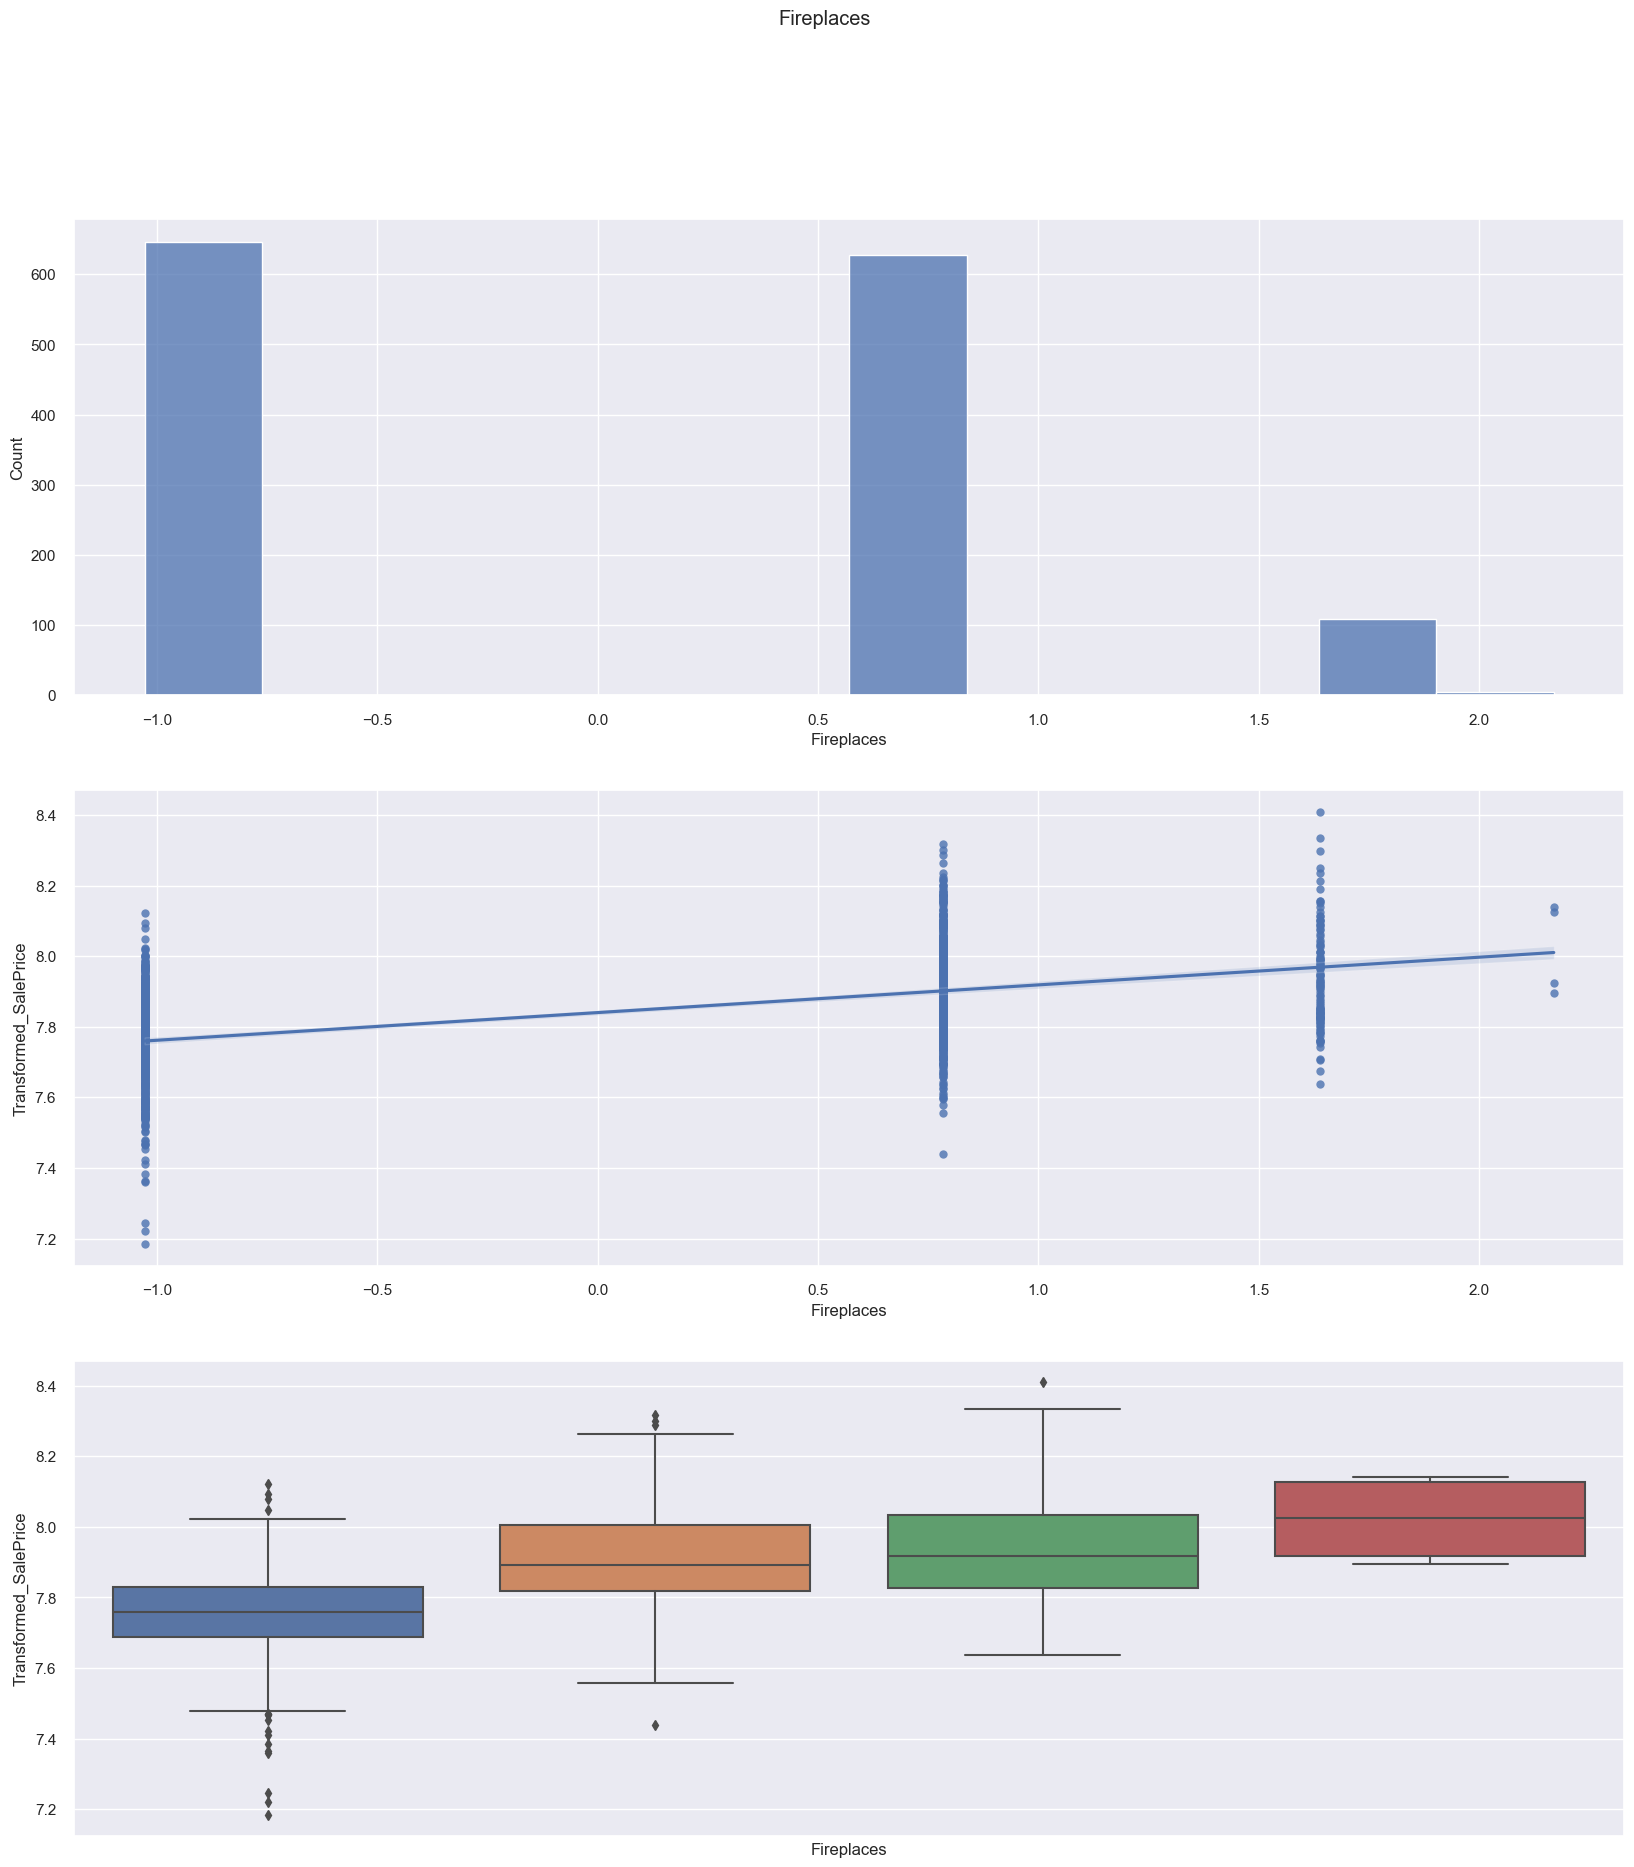

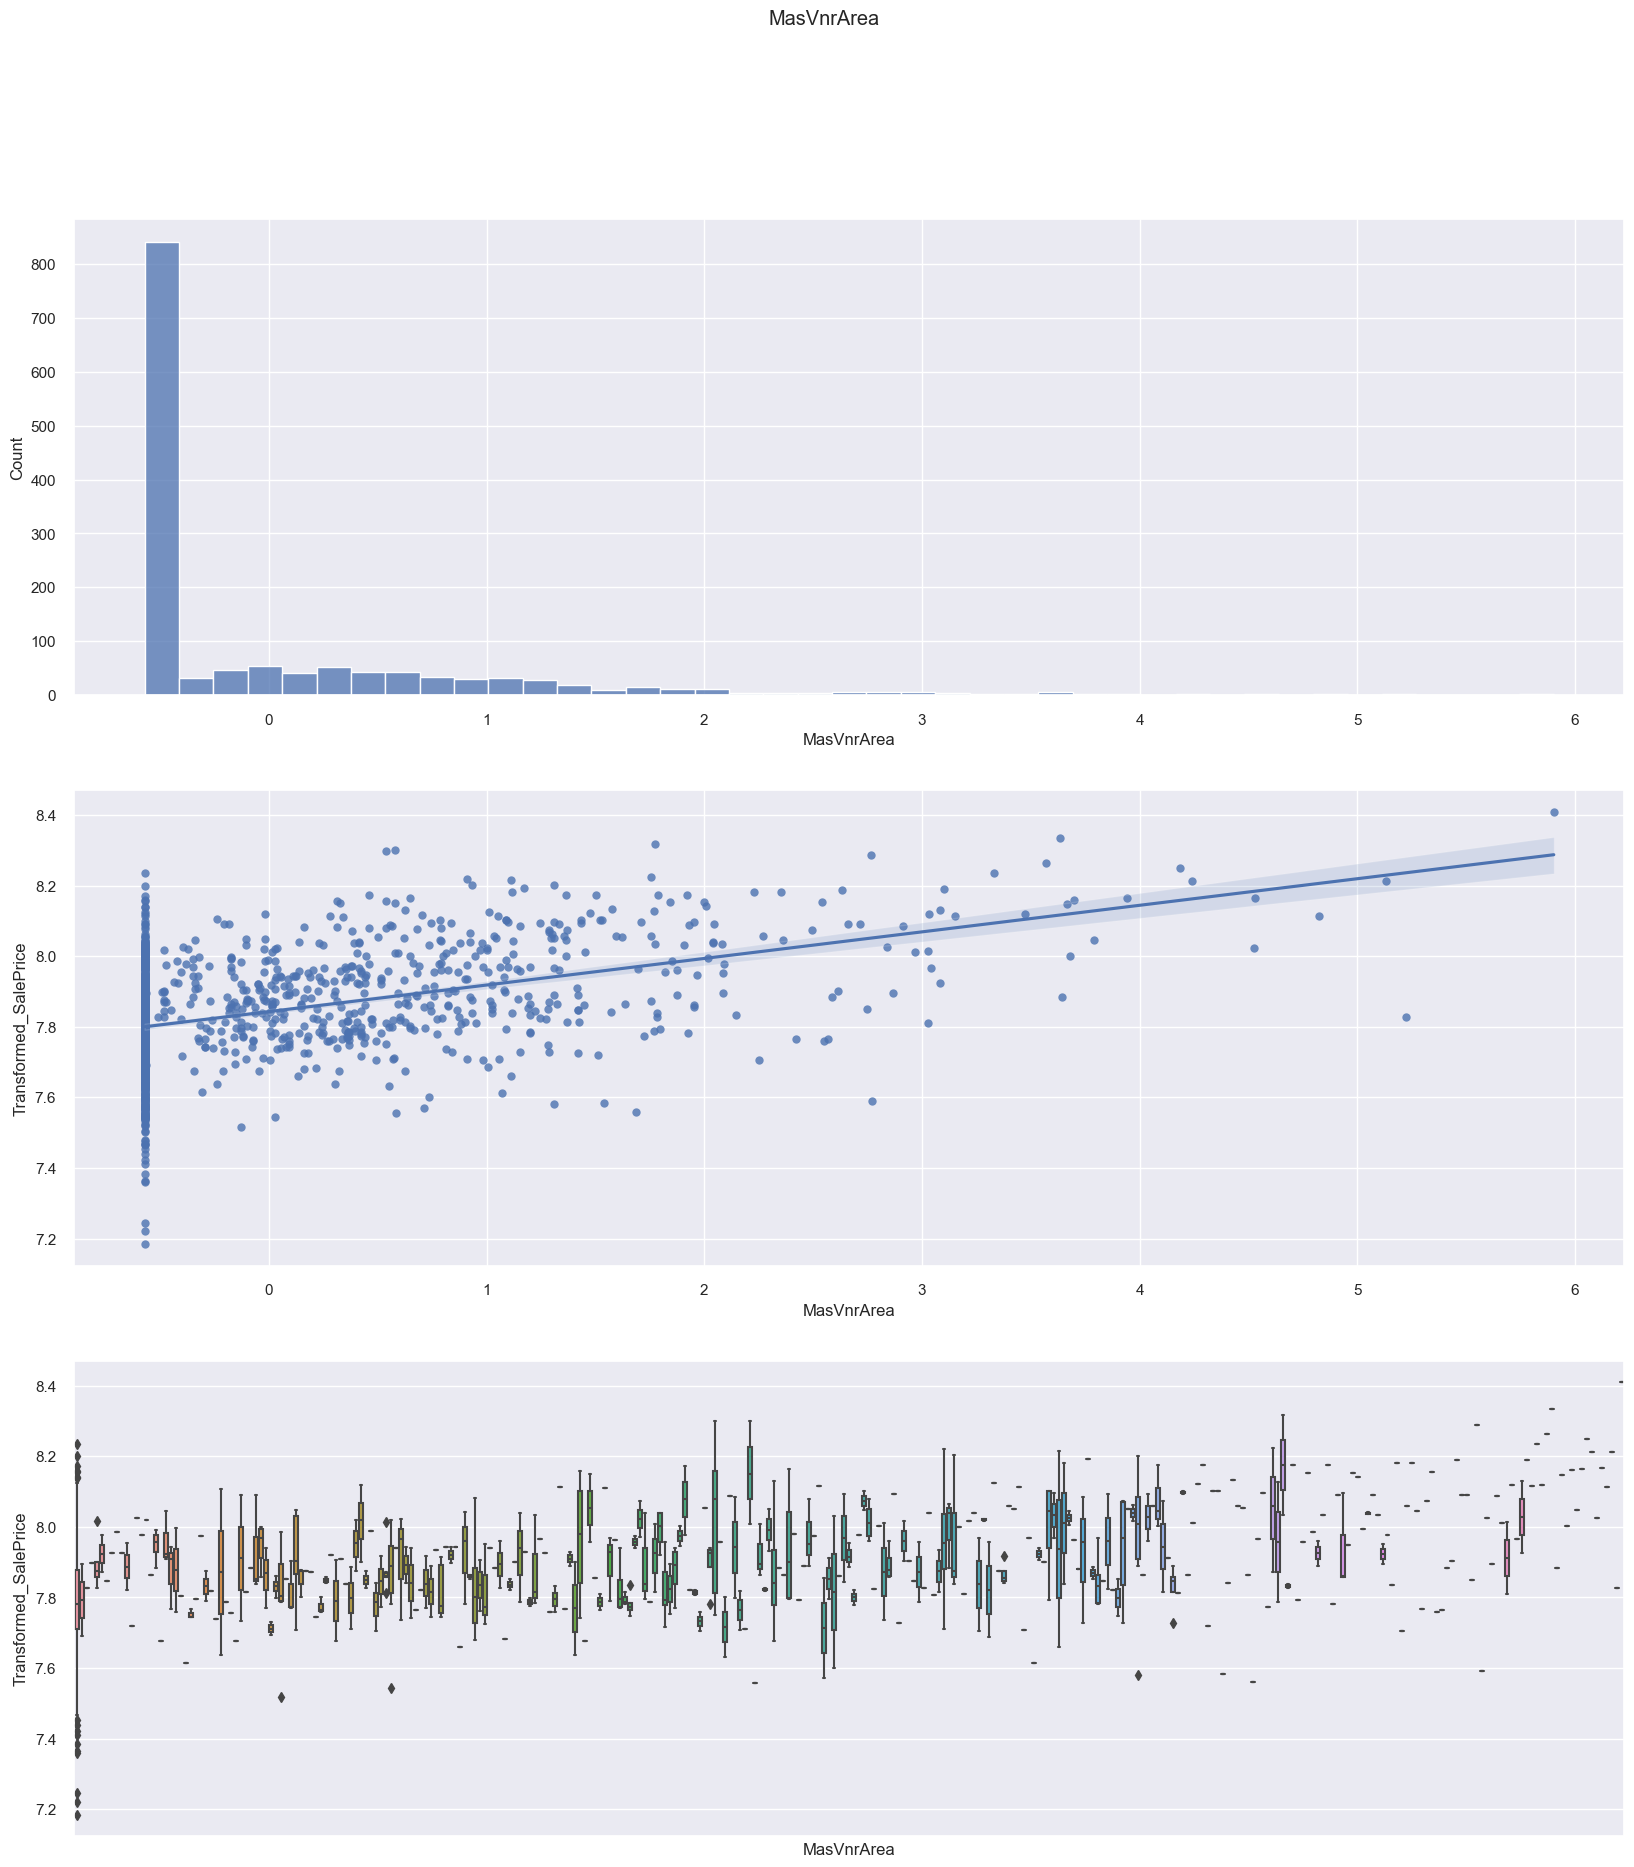

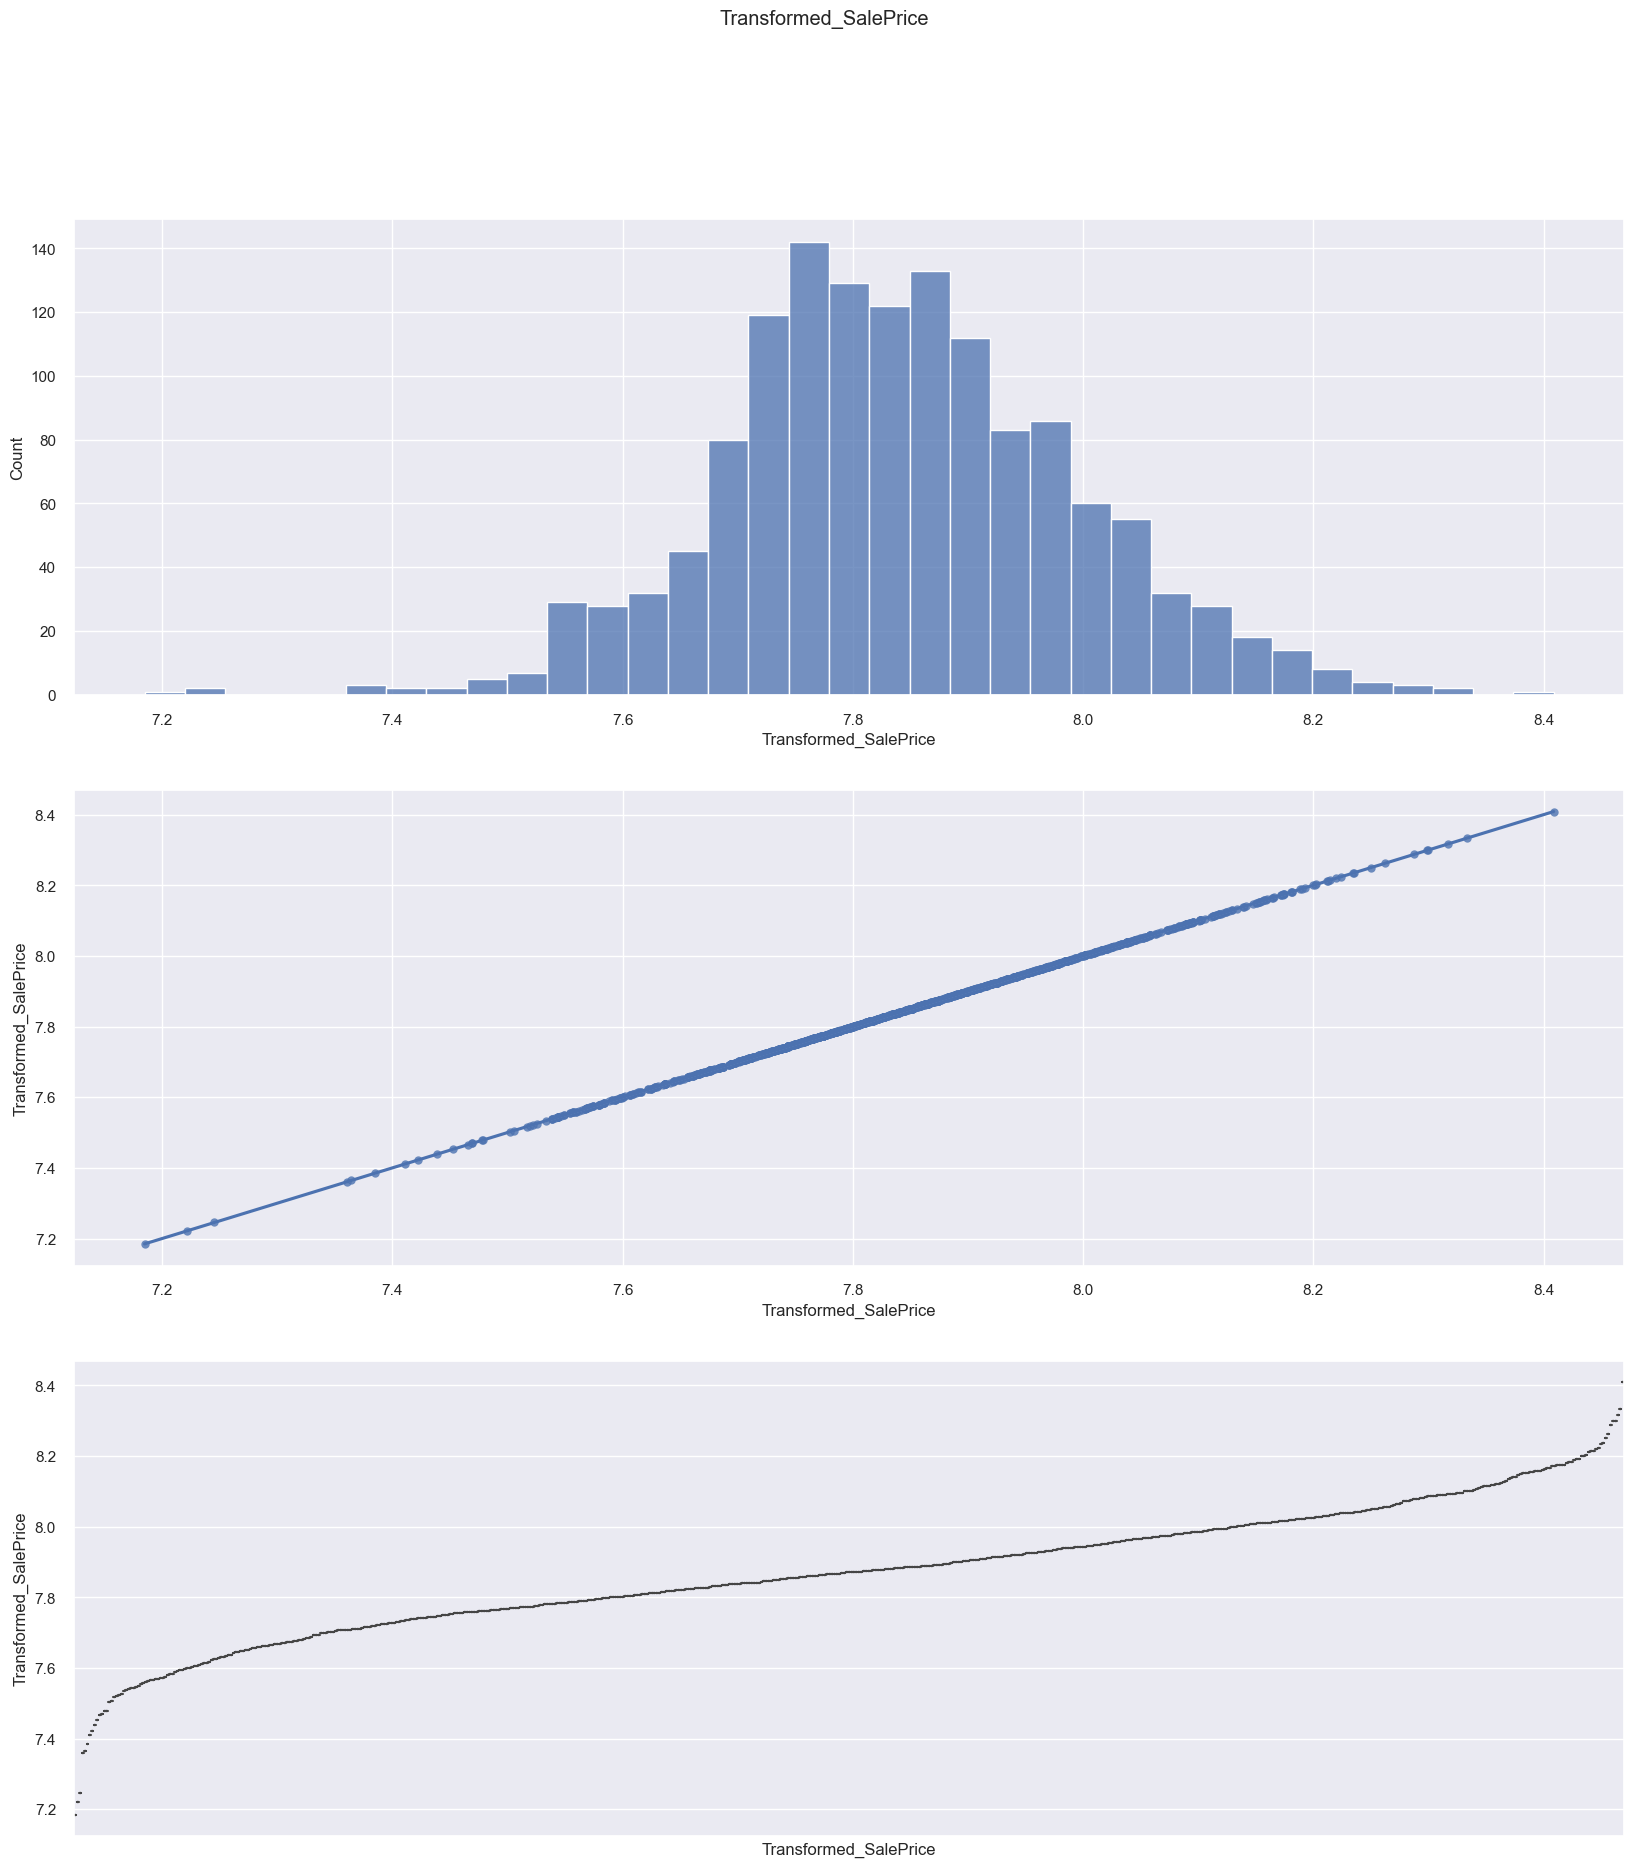

In [47]:
for i in df10.columns:
    simple_graph(df10, y='Transformed_SalePrice', x=i)

In [48]:
df11 = df10.copy()

# 10) Splitting Data

In [49]:
X = df11.drop(['Transformed_SalePrice'], axis=1)
y = df11['Transformed_SalePrice']

X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.8, random_state=12345)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=12345)

# 11) Model Selection

In [50]:
_ = pr.setup(data=df11, target='Transformed_SalePrice', session_id=12345)

## I) Model Selection

In [51]:
top3 = pr.compare_models(n_select=3)

## II) Finding 'Optimal' Hyper Parameters for Future HyperParameter Optimization

### i) Bayesian Ridge Regression

In [52]:
br = pr.create_model('br')
tuned_br = pr.tune_model(br, search_library='optuna')

In [53]:
tuned_br

BayesianRidge(alpha_1=0.0005927739485670543, alpha_2=1.3531272990961577e-05,
              alpha_init=None, compute_score=True, copy_X=True,
              fit_intercept=True, lambda_1=0.42358472854508705,
              lambda_2=3.6410440332725633e-10, lambda_init=None, n_iter=300,
              normalize=False, tol=0.001, verbose=False)

### ii) Linear Regression

In [54]:
lr = pr.create_model('lr')
tuned_lr = pr.tune_model(lr, search_library='optuna')

In [55]:
lr

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

### iii) Least Angle Regression

In [56]:
lar = pr.create_model('lar')
tuned_lar = pr.tune_model(lar, search_library='optuna')

In [57]:
lar

Lars(copy_X=True, eps=2.220446049250313e-16, fit_intercept=True, fit_path=True,
     jitter=None, n_nonzero_coefs=500, normalize=True, precompute='auto',
     random_state=12345, verbose=False)

# 12) HyperParameter Optimization

In [58]:
kf = KFold(n_splits=10, shuffle=True, random_state=12345)

scores = {'Regressor':[], 'RMSE':[]}

## I) Bayesian Ridge Regression

In [59]:
def br_optimizer(trial):
    
    alpha_1 = trial.suggest_loguniform('alpha_1', 1e-7, 1e-5)
    alpha_2 = trial.suggest_loguniform('alpha_2', 1e-8, 1e-6)
    lambda_1 = trial.suggest_loguniform('lambda_1', 1e-9, 1e-7)
    lambda_2 = trial.suggest_loguniform('lambda_2', 1e-7, 1e-5)
    
    compute_score = trial.suggest_categorical('compute_score', [False, True])
    fit_intercept = trial.suggest_categorical('fit_intercept', [False, True])
    
    parameters = {'alpha_1':alpha_1, 'alpha_2':alpha_2, 'lambda_1':lambda_1, 'lambda_2':lambda_2, 'compute_score':compute_score, 'fit_intercept':fit_intercept, 'tol':1e-7, 'n_iter':700}
    
    model = BayesianRidge(**parameters)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    """cv_scores = target_transformer.inverse_transform(np.sqrt(-cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)).reshape(-1, 1))
    cv_score = np.mean(cv_scores)"""
    
    test_score = target_transformer.inverse_transform([[np.sqrt(mean_squared_error(y_test, predictions))]])[0][0]
    
    return test_score

In [60]:
study = optuna.create_study(direction='minimize')
study.optimize(br_optimizer, n_trials=100)

In [61]:
br_params = study.best_params
br_params['tol'] = 1e-5
br_params['n_iter'] = 500
pd.DataFrame(data=br_params.values(), index=br_params.keys(), columns=['Value'])

Value
alpha_1        0.000002
alpha_2             0.0
lambda_1            0.0
lambda_2        0.00001
compute_score      True
fit_intercept      True
tol             0.00001
n_iter              500

In [62]:
scores['Regressor'].append('BayesianRidgeRegression')
scores['RMSE'].append(study.best_value)
pd.DataFrame(data=scores)

Regressor      RMSE
0  BayesianRidgeRegression  0.054654

In [63]:
optuna.visualization.plot_optimization_history(study)

## II) Linear Regression

In [64]:
def lr_optimizer(trial):

    fit_intercept = trial.suggest_categorical('fit_intercept', [False, True])
    
    parameters = {'fit_intercept':fit_intercept}
    
    model = LinearRegression(**parameters)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    """cv_scores = target_transformer.inverse_transform(np.sqrt(-cross_val_score(model, X_test, y_test, scoring='neg_mean_squared_error', cv=kf)).reshape(-1, 1))
    cv_score = np.mean(cv_scores)"""
    
    test_score = target_transformer.inverse_transform([[np.sqrt(mean_squared_error(y_test, predictions))]])[0][0]
    
    return test_score

In [65]:
dummy_params = {'fit_intercept':[False, True]}
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.GridSampler(dummy_params))
study.optimize(lr_optimizer, n_trials=2)

In [66]:
lr_params = study.best_params
pd.DataFrame(data=lr_params.values(), index=lr_params.keys(), columns=['Value'])

Value
fit_intercept   True

In [67]:
scores['Regressor'].append('LinearRegression')
scores['RMSE'].append(study.best_value)
pd.DataFrame(data=scores)

Regressor      RMSE
0  BayesianRidgeRegression  0.054654
1         LinearRegression  0.054634

In [68]:
optuna.visualization.plot_optimization_history(study)

## III) Least Angle Regression

In [69]:
def lar_optimizer(trial):

    fit_intercept = trial.suggest_categorical('fit_intercept', [False, True])
    
    parameters = {'fit_intercept':fit_intercept, 'normalize':False, 'n_nonzero_coefs':np.inf}
    
    model = Lars(**parameters)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    """cv_scores = target_transformer.inverse_transform(np.sqrt(-cross_val_score(model, X_test, y_test, scoring='neg_mean_squared_error', cv=kf)).reshape(-1, 1))
    cv_score = np.mean(cv_scores)"""
    
    test_score = target_transformer.inverse_transform([[np.sqrt(mean_squared_error(y_test, predictions))]])[0][0]
    
    return test_score

In [70]:
dummy_params = {'fit_intercept':[False, True]}
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.GridSampler(dummy_params))
study.optimize(lar_optimizer, n_trials=2)

In [71]:
lar_params = study.best_params
lar_params['normalize'] = False
lar_params['n_nonzero_coefs'] = np.inf
pd.DataFrame(data=lar_params.values(), index=lar_params.keys(), columns=['Value'])

Value
fit_intercept     True
normalize        False
n_nonzero_coefs    inf

In [72]:
scores['Regressor'].append('LeastAngleRegression')
scores['RMSE'].append(study.best_value)
pd.DataFrame(data=scores)

Regressor      RMSE
0  BayesianRidgeRegression  0.054654
1         LinearRegression  0.054634
2     LeastAngleRegression  0.054634

In [73]:
optuna.visualization.plot_optimization_history(study)

In [74]:
pd.DataFrame(scores)[pd.DataFrame(scores)['RMSE'] == np.min(pd.DataFrame(scores)['RMSE'])]

Regressor      RMSE
1      LinearRegression  0.054634
2  LeastAngleRegression  0.054634

In [75]:
pd.DataFrame(data=scores)

Regressor      RMSE
0  BayesianRidgeRegression  0.054654
1         LinearRegression  0.054634
2     LeastAngleRegression  0.054634

# 13) Model Training & Results

In [76]:
def train_results(model, X_train, y_train, X_test, y_test, X_valid, y_valid):
    
    model = model.fit(X_train, y_train)
    
    train_pred = br.predict(X_train)
    test_pred = br.predict(X_test)
    valid_pred = br.predict(X_valid)
    
    train_RMSE = target_transformer.inverse_transform([[np.sqrt(mean_squared_error(y_train, train_pred))]])[0][0]
    train_R2 = r2_score(y_train, train_pred)
    
    test_RMSE = target_transformer.inverse_transform([[np.sqrt(mean_squared_error(y_test, test_pred))]])[0][0]
    test_R2 = r2_score(y_test, test_pred)
    
    valid_RMSE = target_transformer.inverse_transform([[np.sqrt(mean_squared_error(y_valid, valid_pred))]])[0][0]
    valid_R2 = r2_score(y_valid, valid_pred)
    
    scores = {'Data':['Train', 'Test', 'Validation'], 'RMSE':[train_RMSE, test_RMSE, valid_RMSE], 'R2':[train_R2, test_R2, valid_R2]}
    
    return pd.DataFrame(data=scores)

## I) Bayesian Ridge Regression

In [77]:
train_results(BayesianRidge(**br_params), X_train, y_train, X_test, y_test, X_valid, y_valid)

Data      RMSE        R2
0       Train  0.094799  0.642193
1        Test  0.109513  0.605089
2  Validation  0.099218  0.642004

## II) Linear Regression

In [78]:
train_results(LinearRegression(**lr_params), X_train, y_train, X_test, y_test, X_valid, y_valid)

Data      RMSE        R2
0       Train  0.094799  0.642193
1        Test  0.109513  0.605089
2  Validation  0.099218  0.642004

## III) Least Angle Regression

In [79]:
train_results(Lars(**lar_params), X_train, y_train, X_test, y_test, X_valid, y_valid)

Data      RMSE        R2
0       Train  0.094799  0.642193
1        Test  0.109513  0.605089
2  Validation  0.099218  0.642004